In [1]:
import numpy as np
import pandas as pd

def Peaks(x, y):
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return z

def GetGrid(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = Peaks(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="HoleEffect")

/tmp/ipykernel_2880/2618868705.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


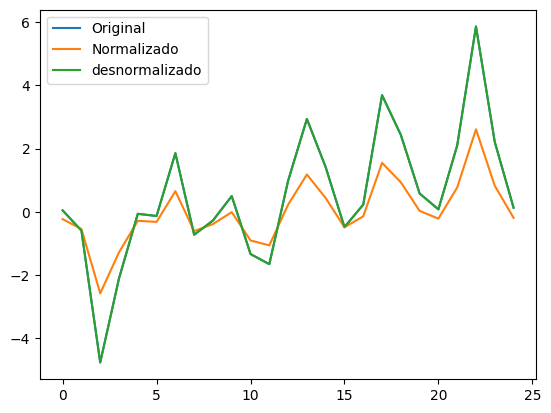

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-15 23:20:12.911842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 23:20:12.912032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 23:20:13.226430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 23:20:13.765610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-15 23:20:20.688488: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_6_5  0.726346  0.252767 -0.233871 -0.082442  0.441718  4.996751   
model_3_6_4  0.726515  0.241298 -0.096404  0.006082  0.441445  5.073447   
model_3_6_3  0.723387  0.230089 -0.199629  0.024036  0.446495  5.148396   
model_3_6_1  0.705488  0.227271 -1.166650  0.099631  0.475386  5.167241   
model_3_6_0  0.694038  0.222326 -0.938591  0.130885  0.493868  5.200309   
model_3_6_2  0.718016  0.222281 -0.215512  0.052980  0.455164  5.200610   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_6_5  4.413486  1.098928  1.074198  0.664619 -0.167591  0.675086   
model_3_6_4  3.921774  1.009056  1.101095  0.664413 -0.166868  0.674877   
model_3_6_3  4.291004  0.990828  1.134155  0.668202 -0.180216  0.678726   
model_3_6_1  7.749982  0.914082  1.239168  0.689483 -0.256585  0.700341   
model_3_6_0  6.934227  0.882352  1.283125  0.702757 -0.305438  0.713825   
model_3_6_2  4.347818  0.961443  1.170120  0.674658 -0.203131  0.685284   

                   aic         bic  
model_3_6_5  99.634165  206.179141  
model_3_6_4  99.635404  206.180380  
model_3_6_3  99.612656  206.157633  
model_3_6_1  99.487255  206.032231  
model_3_6_0  99.410974  205.955950  
model_3_6_2  99.574195  206.119171

DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 9 +++++++++++++++

r2    r2_sup    r2_test    r2_val       mse    mse_sup  \
model_3_7_0  0.727925  0.226813  -0.184380  0.441105  0.439170   5.170303   
model_3_7_1  0.731077  0.009514  -2.783892  0.405980  0.434081   6.623382   
model_3_7_4  0.726547 -0.980799 -14.302684  0.107147  0.441394  13.245612   
model_3_7_5  0.725443 -1.112383 -16.041655  0.067424  0.443176  14.125514   
model_3_7_2  0.722449 -1.226699 -17.632522  0.123158  0.448008  14.889945   
model_3_7_3  0.720660 -1.331090 -19.030090  0.073686  0.450897  15.588009   
model_3_7_6  0.722392 -1.359832 -19.624418  0.007111  0.448100  15.780210   
model_3_7_8  0.693484 -2.593185 -30.274645 -0.845619  0.494763  24.027644   
model_3_7_7  0.699249 -3.475458 -47.702803 -0.365113  0.485457  29.927409   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_7_0    4.236457  0.396069  1.053457  0.662699 -0.160855  0.673136   
model_3_7_1   13.534761  0.420961  1.052974  0.658848 -0.147403  0.669224   
model_3_7_4   54.736813  0.632733  0.975766  0.664375 -0.166732  0.674838   
model_3_7_5   60.957011  0.660883  0.968737  0.665715 -0.171444  0.676199   
model_3_7_2   66.647449  0.621386  1.004256  0.669334 -0.184217  0.679876   
model_3_7_3   71.646469  0.656445  0.996755  0.671488 -0.191852  0.682064   
model_3_7_6   73.772346  0.703624  0.970616  0.669403 -0.184460  0.679945   
model_3_7_8  111.867591  1.307924  1.150293  0.703394 -0.307803  0.714472   
model_3_7_7  174.207102  0.967406  1.015806  0.696747 -0.283204  0.707720   

                   aic         bic  
model_3_7_0  99.645738  206.190714  
model_3_7_1  99.669049  206.214025  
model_3_7_4  99.635637  206.180613  
model_3_7_5  99.627576  206.172552  
model_3_7_2  99.605886  206.150863  
model_3_7_3  99.593034  206.138010  
model_3_7_6  99.605477  206.150453  
model_3_7_8  99.407353  205.952329  
model_3_7_7  99.445331  205.990307

DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_8_9  0.706580  0.014163  0.269517 -0.042768  0.473623  6.592295   
model_3_8_8  0.709719  0.011163  0.263642  0.001286  0.468556  6.612358   
model_3_8_7  0.709894  0.004258  0.195281  0.022267  0.468275  6.658531   
model_3_8_6  0.710238 -0.000708  0.172830  0.050131  0.467719  6.691741   
model_3_8_5  0.715847 -0.044007 -0.103624  0.210467  0.458666  6.981279   
model_3_8_3  0.723847 -0.057061 -0.279620  0.341732  0.445752  7.068574   
model_3_8_4  0.724077 -0.059043 -0.253568  0.314953  0.445380  7.081826   
model_3_8_2  0.723389 -0.068694 -0.427536  0.364743  0.446492  7.146361   
model_3_8_1  0.722347 -0.073445 -0.789635  0.387815  0.448173  7.178132   
model_3_8_0  0.726757 -0.356190 -3.733657  0.576234  0.441054  9.068848   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_8_9   2.612896  0.871870  1.307686  0.688203 -0.251924  0.699041   
model_3_8_8   2.633910  0.835035  1.300275  0.684512 -0.238532  0.695292   
model_3_8_7   2.878433  0.817493  1.302235  0.684306 -0.237787  0.695083   
model_3_8_6   2.958739  0.794196  1.306394  0.683900 -0.236319  0.694671   
model_3_8_5   3.947598  0.660138  1.297113  0.677249 -0.212388  0.687915   
model_3_8_3   4.577125  0.550385  1.278126  0.667647 -0.178254  0.678162   
model_3_8_4   4.483941  0.572775  1.275090  0.667368 -0.177271  0.677879   
model_3_8_2   5.106212  0.531146  1.281037  0.668201 -0.180209  0.678724   
model_3_8_1   6.401419  0.511855  1.289480  0.669457 -0.184651  0.680000   
model_3_8_0  16.932015  0.354316  1.283878  0.664119 -0.165835  0.674578   

                   aic         bic  
model_3_8_9  99.494688  206.039664  
model_3_8_8  99.516197  206.061173  
model_3_8_7  99.517401  206.062377  
model_3_8_6  99.519774  206.064750  
model_3_8_5  99.558866  206.103843  
model_3_8_3  99.615983  206.160960  
model_3_8_4  99.617653  206.162629  
model_3_8_2  99.612668  206.157644  
model_3_8_1  99.605154  206.150130  
model_3_8_0  99.637176  206.182152

DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_9_0  0.714346 -0.041632 -0.070600  0.268193  0.461087  6.965400   
model_3_9_1  0.716028 -0.047315 -0.097131  0.264853  0.458372  7.003397   
model_3_9_2  0.719551 -0.092897 -0.395630  0.281568  0.452686  7.308210   
model_3_9_3  0.731235 -0.098522 -0.583353  0.315794  0.433826  7.345820   
model_3_9_4  0.733286 -0.135844 -0.918727  0.318176  0.430516  7.595393   
model_3_9_5  0.740058 -0.280429 -2.491434  0.306817  0.419584  8.562231   
model_3_9_9  0.785686 -0.293077 -2.526236  0.389911  0.345935  8.646814   
model_3_9_6  0.767680 -0.319624 -2.996797  0.359455  0.374999  8.824334   
model_3_9_8  0.785517 -0.390473 -3.317145  0.398210  0.346207  9.298099   
model_3_9_7  0.784261 -0.391466 -3.322215  0.397613  0.348235  9.304743   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_9_0   3.829473  0.789822  1.287217  0.679034 -0.218788  0.689728   
model_3_9_1   3.924374  0.793427  1.288040  0.677032 -0.211612  0.687694   
model_3_9_2   4.992086  0.775386  1.290034  0.672819 -0.196581  0.683415   
model_3_9_3   5.663561  0.738447  1.291839  0.658655 -0.146730  0.669028   
model_3_9_4   6.863176  0.735876  1.287841  0.656137 -0.137979  0.666470   
model_3_9_5  12.488658  0.748136  1.295086  0.647753 -0.109084  0.657955   
model_3_9_9  12.613141  0.658454  1.298115  0.588162  0.085594  0.597425   
model_3_9_6  14.296310  0.691325  1.293848  0.612372  0.008767  0.622016   
model_3_9_8  15.442177  0.649498  1.295791  0.588393  0.084874  0.597660   
model_3_9_7  15.460311  0.650142  1.296156  0.590114  0.079514  0.599408   

                    aic         bic  
model_3_9_0   99.548336  206.093312  
model_3_9_1   99.560148  206.105124  
model_3_9_2   99.585115  206.130091  
model_3_9_3   99.670222  206.215198  
model_3_9_4   99.685543  206.230520  
model_3_9_5   99.736981  206.281957  
model_3_9_9  100.123011  206.667987  
model_3_9_6   99.961662  206.506638  
model_3_9_8  100.121438  206.666414  
model_3_9_7  100.109757  206.654734

DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_10_5  0.695107  0.107133  0.073576  0.550488  0.492142  5.970609   
model_3_10_4  0.703147  0.106508  0.090625  0.580594  0.479164  5.974784   
model_3_10_3  0.751007  0.018837 -0.505291  0.740825  0.401911  6.561041   
model_3_10_2  0.751109  0.015833 -0.525586  0.745924  0.401746  6.581130   
model_3_10_1  0.752858  0.003560 -0.622076  0.758913  0.398923  6.663200   
model_3_10_0  0.786381 -0.120394 -1.245328  0.846578  0.344813  7.492077   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_10_5  3.313765  1.426374  1.278030  0.701528 -0.300875  0.712577   
model_3_10_4  3.252780  1.330842  1.288993  0.692217 -0.266571  0.703119   
model_3_10_3  5.384338  0.822403  1.290869  0.633965 -0.062369  0.643949   
model_3_10_2  5.456934  0.806225  1.295291  0.633835 -0.061933  0.643817   
model_3_10_1  5.802071  0.765007  1.299319  0.631604 -0.054471  0.641551   
model_3_10_0  8.031407  0.486832  1.300483  0.587207  0.088560  0.596455   

                     aic         bic  
model_3_10_5   99.417977  205.962953  
model_3_10_4   99.471424  206.016400  
model_3_10_3   99.823047  206.368024  
model_3_10_2   99.823869  206.368845  
model_3_10_1   99.837972  206.382949  
model_3_10_0  100.129509  206.674485

DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_12_3  0.706415  0.124905 -0.093902 -0.082615  0.473889  5.851768   
model_3_12_1  0.710051  0.021189 -0.309958  0.030734  0.468020  6.545311   
model_3_12_2  0.710025  0.020379 -0.312624  0.022989  0.468062  6.550727   
model_3_12_0  0.701171 -0.017873  0.042866  0.185085  0.482354  6.806525   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_12_3  3.912825  1.403373  1.059506  0.688396 -0.252628  0.699238   
model_3_12_1  4.685644  1.256442  1.063430  0.684120 -0.237115  0.694894   
model_3_12_2  4.695181  1.266481  1.063274  0.684151 -0.237225  0.694925   
model_3_12_0  3.423613  1.056359  1.084174  0.694517 -0.275003  0.705455   

                    aic         bic  
model_3_12_3  99.493563  206.038539  
model_3_12_1  99.518486  206.063463  
model_3_12_2  99.518309  206.063285  
model_3_12_0  99.458153  206.003129

DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_13] | 9 +++

r2    r2_sup   r2_test    r2_val      mse   mse_sup  \
model_3_13_0  0.696088 -0.242226 -1.518905 -4.006621  0.49056  8.306768   

              mse_test   mse_val     mape    rmse    r2_adj      rsd  \
model_3_13_0  9.009976  1.606747  1.06453  0.7004 -0.296693  0.71143   

                    aic         bic  
model_3_13_0  99.424417  205.969393

DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_14] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_14_2  0.698301 -0.130039 -1.307297 -7.220923  0.486988  7.556576   
model_3_14_4  0.696563 -0.145934 -1.414245 -7.451237  0.489793  7.662867   
model_3_14_3  0.695147 -0.169317 -1.568003 -7.487788  0.492078  7.819226   
model_3_14_6  0.705336 -0.301305 -2.268261 -7.976321  0.475632  8.701834   
model_3_14_5  0.705023 -0.304955 -2.343120 -7.748227  0.476137  8.726237   
model_3_14_0  0.722017 -0.429717 -3.288905 -0.628547  0.448706  9.560523   
model_3_14_1  0.723173 -0.451363 -3.455970 -0.724694  0.446839  9.705268   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_14_2   8.253068  1.159582  1.129903  0.697845 -0.287251  0.708835   
model_3_14_4   8.635616  1.192069  1.132755  0.699852 -0.294665  0.710874   
model_3_14_3   9.185599  1.197224  1.134020  0.701483 -0.300706  0.712530   
model_3_14_6  11.690379  1.266133  1.118892  0.689661 -0.257234  0.700522   
model_3_14_5  11.958145  1.233960  1.116536  0.690027 -0.258570  0.700894   
model_3_14_0  15.341165  0.229711  1.060743  0.669855 -0.186060  0.680405   
model_3_14_1  15.938745  0.243272  1.063293  0.668460 -0.181127  0.678988   

                    aic         bic  
model_3_14_2  99.439033  205.984009  
model_3_14_4  99.427546  205.972522  
model_3_14_3  99.418236  205.963212  
model_3_14_6  99.486222  206.031198  
model_3_14_5  99.484098  206.029074  
model_3_14_0  99.602776  206.147752  
model_3_14_1  99.611112  206.156088

DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_15] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_15_9  0.745097  0.148746  0.205818  0.542628  0.411452  5.692339   
model_3_15_6  0.754737  0.145695  0.240967  0.631226  0.395890  5.712744   
model_3_15_8  0.745853  0.144650  0.205207  0.546218  0.410231  5.719732   
model_3_15_2  0.753449  0.144551  0.187971  0.689493  0.397970  5.720390   
model_3_15_7  0.753738  0.137801  0.193347  0.611107  0.397503  5.765528   
model_3_15_3  0.752274  0.119571  0.191469  0.672785  0.399867  5.887434   
model_3_15_4  0.754756  0.115874  0.185947  0.674335  0.395860  5.912154   
model_3_15_5  0.754914  0.108939  0.189856  0.664867  0.395605  5.958526   
model_3_15_1  0.705702 -0.038355 -0.656400  0.688340  0.475041  6.943485   
model_3_15_0  0.700699 -0.249356 -1.884424  0.703454  0.483115  8.354453   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_15_9   2.840744  0.990552  1.017228  0.641445 -0.087588  0.651547   
model_3_15_6   2.715015  0.798671  1.034724  0.629198 -0.046454  0.639107   
model_3_15_8   2.842929  0.982777  1.017881  0.640493 -0.084361  0.650580   
model_3_15_2   2.904582  0.672480  1.056100  0.630848 -0.051950  0.640784   
model_3_15_7   2.885352  0.842244  1.023929  0.630478 -0.050716  0.640408   
model_3_15_3   2.892068  0.708665  1.055219  0.632350 -0.056965  0.642309   
model_3_15_4   2.911820  0.705308  1.050340  0.629174 -0.046375  0.639083   
model_3_15_5   2.897838  0.725814  1.051632  0.628971 -0.045699  0.638877   
model_3_15_1   5.924846  0.674978  1.116222  0.689232 -0.255671  0.700087   
model_3_15_0  10.317418  0.642243  1.125728  0.695065 -0.277016  0.706012   

                    aic         bic  
model_3_15_9  99.776126  206.321102  
model_3_15_6  99.853236  206.398212  
model_3_15_8  99.782069  206.327045  
model_3_15_2  99.842760  206.387736  
model_3_15_7  99.845107  206.390083  
model_3_15_3  99.833247  206.378223  
model_3_15_4  99.853388  206.398364  
model_3_15_5  99.854680  206.399656  
model_3_15_1  99.488710  206.033686  
model_3_15_0  99.454999  205.999975

DataFrame salvo em ../results/metrics_3_15
+++++++++++ [3_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_16] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_16] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_16_0  0.747268  0.146832  0.202289  0.355077  0.407947  5.705140   
model_3_16_1  0.752537  0.143282  0.193412  0.308638  0.399442  5.728878   
model_3_16_2  0.772977  0.126854  0.145544  0.468638  0.366449  5.838732   
model_3_16_3  0.773433  0.124822  0.140168  0.432782  0.365712  5.852322   
model_3_16_4  0.773543  0.123312  0.134298  0.391888  0.365535  5.862419   
model_3_16_5  0.750530  0.054987  0.006421 -0.680037  0.402681  6.319308   
model_3_16_6  0.750465  0.050672  0.004768 -0.700477  0.402786  6.348158   
model_3_16_7  0.719698 -0.000431 -0.066810 -1.549626  0.452448  6.689887   
model_3_16_8  0.715378 -0.008617 -0.075787 -1.664339  0.459422  6.744624   
model_3_16_9  0.714632 -0.014885 -0.078581 -1.686458  0.460627  6.786543   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_16_0  2.853365  0.254894  1.014952  0.638707 -0.078322  0.648766   
model_3_16_1  2.885118  0.273248  1.011311  0.632014 -0.055843  0.641968   
model_3_16_2  3.056339  0.210011  1.028604  0.605351  0.031367  0.614884   
model_3_16_3  3.075570  0.224182  1.031679  0.604742  0.033315  0.614266   
model_3_16_4  3.096568  0.240345  1.035630  0.604595  0.033783  0.614117   
model_3_16_5  3.553974  0.664004  1.133766  0.634572 -0.064405  0.644566   
model_3_16_6  3.559889  0.672082  1.138033  0.634654 -0.064682  0.644650   
model_3_16_7  3.815916  1.007693  1.159029  0.672643 -0.195954  0.683236   
model_3_16_8  3.848029  1.053031  1.160909  0.677807 -0.214386  0.688481   
model_3_16_9  3.858021  1.061773  1.162140  0.678695 -0.217572  0.689384   

                     aic         bic  
model_3_16_0   99.793238  206.338214  
model_3_16_1   99.835372  206.380349  
model_3_16_2  100.007791  206.552767  
model_3_16_3  100.011816  206.556792  
model_3_16_4  100.012784  206.557760  
model_3_16_5   99.819219  206.364195  
model_3_16_6   99.818699  206.363675  
model_3_16_7   99.586163  206.131139  
model_3_16_8   99.555573  206.100549  
model_3_16_9   99.550334  206.095310

DataFrame salvo em ../results/metrics_3_16
+++++++++++ [3_17] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_17] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_17] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_17] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_17_2  0.732854  0.035431 -0.104571  0.132138  0.431214  6.450080   
model_3_17_1  0.731792  0.033288 -0.104391  0.146221  0.432928  6.464408   
model_3_17_0  0.720175  0.029735 -0.069873  0.286259  0.451679  6.488164   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_17_2  3.950987  0.644813  1.149964  0.656669 -0.139824  0.667011   
model_3_17_1  3.950342  0.634349  1.151575  0.657973 -0.144356  0.668335   
model_3_17_0  3.826873  0.530302  1.152553  0.672070 -0.193919  0.682655   

                    aic         bic  
model_3_17_2  99.682303  206.227279  
model_3_17_1  99.674366  206.219343  
model_3_17_0  99.589569  206.134545

DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_18] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_18] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 5 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_18] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_18_0  0.69549  0.074683 -0.139214  0.788983  0.491524  6.187596   

              mse_test   mse_val      mape      rmse    r2_adj      rsd  \
model_3_18_0  4.074901  0.919071  1.077853  0.701088 -0.299243  0.71213   

                    aic         bic  
model_3_18_0  99.420487  205.965463

DataFrame salvo em ../results/metrics_3_18
+++++++++++ [3_19] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_19] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_19] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_19] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_19] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_19_0  0.714005  0.159514  0.016947 -0.231965  0.461639  5.620335   
model_3_19_1  0.711517  0.158295  0.016002 -0.340037  0.465654  5.628485   
model_3_19_2  0.714153  0.144973  0.005206 -0.578483  0.461399  5.717566   
model_3_19_3  0.717409  0.100362  0.011360 -0.755750  0.456144  6.015883   
model_3_19_4  0.718147  0.099650  0.011666 -0.781012  0.454953  6.020642   
model_3_19_5  0.719359  0.097872  0.012065 -0.834149  0.452997  6.032533   
model_3_19_6  0.719972  0.097105  0.012271 -0.859627  0.452006  6.037663   
model_3_19_7  0.721944  0.093691  0.013066 -0.964540  0.448824  6.060492   
model_3_19_8  0.724428  0.086889  0.010857 -1.177618  0.444814  6.105976   
model_3_19_9  0.724618  0.086037  0.010330 -1.204607  0.444507  6.111674   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_19_0  3.516325  0.450385  1.055517  0.679440 -0.220246  0.690140   
model_3_19_1  3.519703  0.489894  1.058590  0.682388 -0.230859  0.693135   
model_3_19_2  3.558321  0.577066  1.086647  0.679263 -0.219612  0.689961   
model_3_19_3  3.536309  0.641871  1.107139  0.675384 -0.205721  0.686021   
model_3_19_4  3.535214  0.651107  1.106372  0.674502 -0.202574  0.685125   
model_3_19_5  3.533787  0.670533  1.105065  0.673050 -0.197402  0.683650   
model_3_19_6  3.533050  0.679847  1.103938  0.672314 -0.194784  0.682902   
model_3_19_7  3.530204  0.718201  1.100412  0.669943 -0.186373  0.680494   
model_3_19_8  3.538107  0.796099  1.093442  0.666943 -0.175772  0.677447   
model_3_19_9  3.539991  0.805966  1.092661  0.666713 -0.174962  0.677214   

                    aic         bic  
model_3_19_0  99.545946  206.090923  
model_3_19_1  99.528626  206.073602  
model_3_19_2  99.546985  206.091961  
model_3_19_3  99.569896  206.114872  
model_3_19_4  99.575121  206.120098  
model_3_19_5  99.583742  206.128718  
model_3_19_6  99.588119  206.133095  
model_3_19_7  99.602250  206.147226  
model_3_19_8  99.620200  206.165177  
model_3_19_9  99.621580  206.166556

DataFrame salvo em ../results/metrics_3_19
+++++++++++ [3_20] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_20] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_20] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_20] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_20_1  0.744972  0.074145  0.051859 -1.158401  0.411653  6.191194   
model_3_20_0  0.747356  0.074128  0.051493 -1.062422  0.407805  6.191313   
model_3_20_2  0.745580  0.073311  0.053884 -1.182098  0.410671  6.196776   
model_3_20_3  0.746551  0.071646  0.057870 -1.233047  0.409105  6.207905   
model_3_20_4  0.746931  0.070599  0.059900 -1.259614  0.408492  6.214910   
model_3_20_5  0.747321  0.069138  0.062009 -1.284424  0.407862  6.224676   
model_3_20_6  0.747026  0.062024  0.071410 -1.444684  0.408338  6.272249   
model_3_20_7  0.743230  0.053037  0.080248 -1.697984  0.414466  6.332345   
model_3_20_8  0.731211  0.032557  0.092119 -2.416588  0.433866  6.469293   
model_3_20_9  0.733770  0.030298  0.098986 -2.615288  0.429735  6.484401   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_20_1  3.391446  0.658803  1.061547  0.641602 -0.088120  0.651707   
model_3_20_0  3.392753  0.629508  1.059860  0.638596 -0.077948  0.648653   
model_3_20_2  3.384201  0.666037  1.061678  0.640836 -0.085524  0.650929   
model_3_20_3  3.369943  0.681588  1.062472  0.639613 -0.081384  0.649686   
model_3_20_4  3.362684  0.689696  1.063342  0.639133 -0.079763  0.649199   
model_3_20_5  3.355140  0.697269  1.064671  0.638641 -0.078098  0.648699   
model_3_20_6  3.321514  0.746185  1.077622  0.639013 -0.079357  0.649077   
model_3_20_7  3.289901  0.823499  1.102863  0.643790 -0.095554  0.653929   
model_3_20_8  3.247437  1.042837  1.139251  0.658685 -0.146834  0.669058   
model_3_20_9  3.222876  1.103486  1.114390  0.655542 -0.135915  0.665866   

                    aic         bic  
model_3_20_1  99.775149  206.320125  
model_3_20_0  99.793932  206.338908  
model_3_20_2  99.779924  206.324900  
model_3_20_3  99.787567  206.332543  
model_3_20_4  99.790568  206.335544  
model_3_20_5  99.793654  206.338630  
model_3_20_6  99.791319  206.336295  
model_3_20_7  99.761531  206.306507  
model_3_20_8  99.670041  206.215017  
model_3_20_9  99.689174  206.234150

DataFrame salvo em ../results/metrics_3_20
+++++++++++ [3_21] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_21] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_21] | 5 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_21] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_21] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_21_0  0.738804 -0.046984 -0.000977 -0.035112  0.421609  7.001189   
model_3_21_1  0.739227 -0.063308  0.052907 -0.236228  0.420927  7.110342   
model_3_21_2  0.737467 -0.065534  0.058058 -0.306954  0.423767  7.125228   
model_3_21_3  0.733813 -0.068485  0.062597 -0.423297  0.429665  7.144961   
model_3_21_6  0.767511 -0.073361  0.099211 -0.236547  0.375271  7.177567   
model_3_21_7  0.767928 -0.080609  0.101432 -0.297772  0.374598  7.226036   
model_3_21_5  0.747872 -0.131184  0.090740 -0.596068  0.406971  7.564234   
model_3_21_4  0.746924 -0.134273  0.089943 -0.591733  0.408502  7.584888   
model_3_21_8  0.761835 -0.290254  0.026373 -1.301424  0.384434  8.627936   
model_3_21_9  0.760666 -0.299795  0.020300 -1.372101  0.386321  8.691737   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_21_0  3.580436  0.353934  1.107245  0.649314 -0.114436  0.659540   
model_3_21_1  3.387695  0.422701  1.142403  0.648789 -0.112632  0.659006   
model_3_21_2  3.369271  0.446884  1.147985  0.650974 -0.120139  0.661226   
model_3_21_3  3.353037  0.486665  1.155310  0.655488 -0.135729  0.665811   
model_3_21_6  3.222070  0.422810  1.156219  0.612594  0.008048  0.622242   
model_3_21_7  3.214126  0.443745  1.160754  0.612044  0.009827  0.621684   
model_3_21_5  3.252369  0.545740  1.175563  0.637943 -0.075744  0.647990   
model_3_21_4  3.255220  0.544258  1.175507  0.639142 -0.079791  0.649208   
model_3_21_8  3.482606  0.786922  1.188936  0.620027 -0.016172  0.629792   
model_3_21_9  3.504330  0.811088  1.189849  0.621547 -0.021158  0.631336   

                    aic         bic  
model_3_21_0  99.727354  206.272330  
model_3_21_1  99.730593  206.275569  
model_3_21_2  99.717145  206.262121  
model_3_21_3  99.689501  206.234477  
model_3_21_6  99.960212  206.505188  
model_3_21_7  99.963801  206.508778  
model_3_21_5  99.798025  206.343001  
model_3_21_4  99.790515  206.335491  
model_3_21_8  99.911966  206.456943  
model_3_21_9  99.902176  206.447152

DataFrame salvo em ../results/metrics_3_21
+++++++++++ [3_22] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_22] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_22] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_22_5  0.713887 -0.248263 -0.036168 -1.919065  0.461829  8.347138   
model_3_22_0  0.757147 -0.291017  0.033294 -0.292037  0.392001  8.633040   
model_3_22_1  0.751593 -0.336793  0.030803 -0.583417  0.400966  8.939141   
model_3_22_2  0.749701 -0.348873  0.028651 -0.658762  0.404020  9.019921   
model_3_22_3  0.746600 -0.355769  0.025884 -0.748488  0.409026  9.066035   
model_3_22_4  0.739686 -0.410398 -0.003218 -1.175952  0.420185  9.431336   
model_3_22_6  0.710662 -0.445795 -0.053385 -2.049703  0.467034  9.668036   
model_3_22_7  0.694172 -0.469356 -0.169698 -2.769289  0.493653  9.825590   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_22_5  3.706312  0.986060  1.256401  0.679580 -0.220748  0.690283   
model_3_22_0  3.457852  0.436450  1.217929  0.626100 -0.036173  0.635960   
model_3_22_1  3.466761  0.534878  1.228026  0.633219 -0.059870  0.643191   
model_3_22_2  3.474460  0.560330  1.230897  0.635625 -0.067942  0.645636   
model_3_22_3  3.484358  0.590639  1.236334  0.639551 -0.081175  0.649624   
model_3_22_4  3.588452  0.735037  1.236316  0.648217 -0.110672  0.658426   
model_3_22_6  3.767896  1.030190  1.257323  0.683399 -0.234507  0.694162   
model_3_22_7  4.183940  1.273266  1.258147  0.702604 -0.304868  0.713669   

                    aic         bic  
model_3_22_5  99.545122  206.090099  
model_3_22_0  99.872982  206.417958  
model_3_22_1  99.827758  206.372734  
model_3_22_2  99.812584  206.357560  
model_3_22_3  99.787954  206.332930  
model_3_22_4  99.734120  206.279096  
model_3_22_6  99.522707  206.067683  
model_3_22_7  99.411847  205.956823

DataFrame salvo em ../results/metrics_3_22
+++++++++++ [3_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_23] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_23] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_23_7  0.765581 -0.153518 -0.036538 -7.666518  0.378387   7.713578   
model_3_23_6  0.756812 -0.225728 -0.105411 -6.979238  0.392542   8.196452   
model_3_23_5  0.743174 -0.289956 -0.167818 -7.036803  0.414556   8.625941   
model_3_23_8  0.772295 -0.385914 -0.154140 -8.652742  0.367550   9.267614   
model_3_23_1  0.725222 -0.790204 -0.301059 -6.430757  0.443533  11.971102   
model_3_23_4  0.732249 -0.811071 -0.296535 -6.581917  0.432189  12.110638   
model_3_23_2  0.727216 -0.827175 -0.301564 -6.477445  0.440314  12.218324   
model_3_23_0  0.693961 -0.849422 -0.306197 -6.297121  0.493993  12.367096   
model_3_23_3  0.728817 -0.860163 -0.300821 -6.510449  0.437729  12.438918   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_23_7  3.707636  0.571476  1.182045  0.615131 -0.000187  0.624819   
model_3_23_6  3.953991  0.526156  1.186586  0.626532 -0.037604  0.636399   
model_3_23_5  4.177217  0.529952  1.204971  0.643860 -0.095792  0.654000   
model_3_23_8  4.128292  0.636508  1.176392  0.606259  0.028458  0.615807   
model_3_23_1  4.653813  0.489989  1.228355  0.665983 -0.172387  0.676471   
model_3_23_4  4.637630  0.499957  1.218036  0.657411 -0.142403  0.667765   
model_3_23_2  4.655619  0.493068  1.224641  0.663561 -0.163878  0.674012   
model_3_23_0  4.672191  0.481177  1.260306  0.702846 -0.305768  0.713915   
model_3_23_3  4.652961  0.495244  1.222580  0.661611 -0.157046  0.672031   

                     aic         bic  
model_3_23_7   99.943677  206.488654  
model_3_23_6   99.870223  206.415199  
model_3_23_5   99.761096  206.306072  
model_3_23_8  100.001793  206.546769  
model_3_23_1   99.625967  206.170943  
model_3_23_4   99.677783  206.222760  
model_3_23_2   99.640535  206.185511  
model_3_23_0   99.410469  205.955445  
model_3_23_3   99.652311  206.197287

DataFrame salvo em ../results/metrics_3_23
+++++++++++ [3_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_24] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_24] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_24_9  0.787765 -0.311776 -0.146778  0.904048  0.342580   8.771852   
model_3_24_8  0.786977 -0.320042 -0.148209  0.904337  0.343850   8.827126   
model_3_24_7  0.783740 -0.349300 -0.152707  0.904131  0.349075   9.022772   
model_3_24_6  0.775807 -0.410598 -0.162469  0.902528  0.361880   9.432678   
model_3_24_0  0.731353 -0.493913 -0.177157  0.902836  0.433635   9.989802   
model_3_24_1  0.734607 -0.497496 -0.180637  0.900276  0.428384  10.013762   
model_3_24_5  0.761013 -0.517106 -0.167276  0.899589  0.385760  10.144892   
model_3_24_4  0.759223 -0.536015 -0.169494  0.899065  0.388650  10.271342   
model_3_24_3  0.745781 -0.641529 -0.185462  0.896778  0.410347  10.976913   
model_3_24_2  0.736974 -0.730156 -0.191207  0.897905  0.424563  11.569559   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_24_9  4.101960  0.540276  1.037700  0.585303  0.094462  0.594521   
model_3_24_8  4.107078  0.538651  1.039943  0.586387  0.091103  0.595622   
model_3_24_7  4.123165  0.539810  1.048247  0.590826  0.077292  0.600131   
model_3_24_6  4.158085  0.548835  1.067629  0.601565  0.043444  0.611039   
model_3_24_0  4.210622  0.547103  1.196325  0.658510 -0.146225  0.668881   
model_3_24_1  4.223070  0.561517  1.192164  0.654511 -0.132345  0.664819   
model_3_24_5  4.175280  0.565387  1.107370  0.621096 -0.019676  0.630877   
model_3_24_4  4.183212  0.568335  1.112211  0.623418 -0.027316  0.633236   
model_3_24_3  4.240327  0.581213  1.149523  0.640583 -0.084667  0.650672   
model_3_24_2  4.260880  0.574864  1.177611  0.651585 -0.122244  0.661847   

                     aic         bic  
model_3_24_9  100.142503  206.687479  
model_3_24_8  100.135098  206.680074  
model_3_24_7  100.104936  206.649912  
model_3_24_6  100.032883  206.577859  
model_3_24_0   99.671102  206.216079  
model_3_24_1   99.695469  206.240445  
model_3_24_5   99.905080  206.450056  
model_3_24_4   99.890152  206.435129  
model_3_24_3   99.781504  206.326480  
model_3_24_2   99.713390  206.258367

DataFrame salvo em ../results/metrics_3_24
+++++++++++ [3_25] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_25] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_25_0  0.797799 -0.012283  0.016166  0.690237  0.326382  6.769143   
model_3_25_1  0.796366 -0.054752 -0.033079  0.682676  0.328696  7.053134   
model_3_25_5  0.802004 -0.061654  0.000522  0.651825  0.319596  7.099288   
model_3_25_2  0.798193 -0.064135 -0.025357  0.673334  0.325747  7.115873   
model_3_25_3  0.798457 -0.072236 -0.031772  0.672007  0.325320  7.170046   
model_3_25_4  0.800437 -0.072561 -0.015602  0.657109  0.322124  7.172221   
model_3_25_6  0.803233 -0.088421 -0.014278  0.647534  0.317612  7.278277   
model_3_25_7  0.803713 -0.114117 -0.019436  0.645133  0.316836  7.450106   
model_3_25_8  0.805193 -0.116805 -0.024705  0.632415  0.314447  7.468077   
model_3_25_9  0.805438 -0.142518 -0.029772  0.628262  0.314052  7.640023   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_25_0  3.519117  0.503489  1.065856  0.571299  0.137277  0.580296   
model_3_25_1  3.695263  0.515778  1.066834  0.573320  0.131161  0.582349   
model_3_25_5  3.575075  0.565923  1.110209  0.565328  0.155215  0.574231   
model_3_25_2  3.667642  0.530962  1.071160  0.570742  0.138956  0.579731   
model_3_25_3  3.690587  0.533119  1.072465  0.570369  0.140083  0.579351   
model_3_25_4  3.632750  0.557335  1.093571  0.567560  0.148531  0.576499   
model_3_25_6  3.628015  0.572897  1.124588  0.563571  0.160459  0.572446   
model_3_25_7  3.646462  0.576799  1.131422  0.562882  0.162511  0.571746   
model_3_25_8  3.665310  0.597472  1.185387  0.560756  0.168825  0.569587   
model_3_25_9  3.683436  0.604223  1.210879  0.560404  0.169868  0.569229   

                     aic         bic  
model_3_25_0  100.239373  206.784349  
model_3_25_1  100.225245  206.770222  
model_3_25_5  100.281398  206.826374  
model_3_25_2  100.243269  206.788245  
model_3_25_3  100.245890  206.790866  
model_3_25_4  100.265635  206.810611  
model_3_25_6  100.293851  206.838827  
model_3_25_7  100.298744  206.843721  
model_3_25_8  100.313880  206.858856  
model_3_25_9  100.316392  206.861368

DataFrame salvo em ../results/metrics_3_25
+++++++++++ [3_26] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_26] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_26] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_26] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_26] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_26] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_26_3  0.791695  0.023795  0.120093  0.214580  0.336235  6.527890   
model_3_26_4  0.791724  0.022905  0.119160  0.207643  0.336188  6.533839   
model_3_26_5  0.790771  0.020864  0.119551  0.188224  0.337726  6.547488   
model_3_26_7  0.782393  0.015305  0.122130  0.057047  0.351249  6.584658   
model_3_26_2  0.792915  0.011839  0.110789  0.235264  0.334266  6.607840   
model_3_26_8  0.782606  0.004921  0.124560  0.050554  0.350906  6.654095   
model_3_26_9  0.782628  0.002569  0.123868  0.044964  0.350871  6.669823   
model_3_26_6  0.788608 -0.016610  0.103620  0.135648  0.341217  6.798077   
model_3_26_0  0.806690 -0.031833  0.004222  0.518970  0.312031  6.899873   
model_3_26_1  0.804940 -0.095853 -0.033213  0.432843  0.314856  7.327975   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_26_3  3.147377  0.679825  1.152793  0.579857  0.111234  0.588989   
model_3_26_4  3.150712  0.685829  1.149827  0.579817  0.111358  0.588948   
model_3_26_5  3.149314  0.702637  1.145465  0.581142  0.107291  0.590294   
model_3_26_7  3.140092  0.816178  1.122782  0.592663  0.071545  0.601997   
model_3_26_2  3.180657  0.661921  1.157861  0.578157  0.116437  0.587263   
model_3_26_8  3.131399  0.821798  1.115951  0.592373  0.072453  0.601702   
model_3_26_9  3.133873  0.826637  1.113245  0.592344  0.072546  0.601672   
model_3_26_6  3.206298  0.748145  1.131569  0.584138  0.098063  0.593338   
model_3_26_0  3.561840  0.416358  1.210120  0.558598  0.175210  0.567395   
model_3_26_1  3.695742  0.490906  1.186129  0.561121  0.167742  0.569958   

                     aic         bic  
model_3_26_3  100.179893  206.724869  
model_3_26_4  100.180171  206.725148  
model_3_26_5  100.171040  206.716016  
model_3_26_7  100.092517  206.637494  
model_3_26_2  100.191636  206.736612  
model_3_26_8  100.094474  206.639451  
model_3_26_9  100.094674  206.639650  
model_3_26_6  100.150471  206.695448  
model_3_26_0  100.329303  206.874279  
model_3_26_1  100.311277  206.856253

DataFrame salvo em ../results/metrics_3_26
+++++++++++ [3_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_27] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_27] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_27] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_27_0  0.783293  0.000957  0.121170  0.678487  0.349797  6.680608   
model_3_27_1  0.784833 -0.008571  0.104472  0.669647  0.347312  6.744321   
model_3_27_2  0.784753 -0.017072  0.095569  0.620564  0.347440  6.801168   
model_3_27_3  0.782096 -0.046260  0.061587  0.565190  0.351730  6.996344   
model_3_27_5  0.781268 -0.055633  0.051333  0.550059  0.353066  7.059021   
model_3_27_4  0.781714 -0.055928  0.050348  0.559768  0.352345  7.060998   
model_3_27_6  0.778481 -0.060826  0.053702  0.510911  0.357565  7.093746   
model_3_27_7  0.777933 -0.070019  0.042661  0.504887  0.358448  7.155222   
model_3_27_8  0.767212 -0.137312 -0.013709  0.403713  0.375754  7.605208   
model_3_27_9  0.747571 -0.275926 -0.063926  0.252097  0.407458  8.532126   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_27_0  3.143523  0.431983  1.113824  0.591436  0.075384  0.600751   
model_3_27_1  3.203253  0.443861  1.120430  0.589332  0.081954  0.598613   
model_3_27_2  3.235096  0.509810  1.149620  0.589441  0.081614  0.598724   
model_3_27_3  3.356648  0.584210  1.169503  0.593068  0.070275  0.602409   
model_3_27_5  3.393327  0.604540  1.173273  0.594194  0.066743  0.603552   
model_3_27_4  3.396850  0.591495  1.171018  0.593587  0.068648  0.602935   
model_3_27_6  3.384854  0.657139  1.182237  0.597967  0.054852  0.607384   
model_3_27_7  3.424346  0.665232  1.183720  0.598706  0.052516  0.608135   
model_3_27_8  3.625979  0.801169  1.204370  0.612988  0.006772  0.622642   
model_3_27_9  3.805601  1.004881  1.229839  0.638324 -0.077031  0.648377   

                     aic         bic  
model_3_27_0  100.100805  206.645781  
model_3_27_1  100.115065  206.660042  
model_3_27_2  100.114325  206.659301  
model_3_27_3  100.089783  206.634759  
model_3_27_5  100.082200  206.627176  
model_3_27_4  100.086287  206.631263  
model_3_27_6  100.056879  206.601855  
model_3_27_7  100.051941  206.596917  
model_3_27_8   99.957641  206.502618  
model_3_27_9   99.795635  206.340611

DataFrame salvo em ../results/metrics_3_27
+++++++++++ [3_28] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_28] | 4 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 5 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_28] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_28] | 9 ++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_28_0  0.769142 -0.152348 -0.090466  0.797860  0.372640   7.705759   
model_3_28_7  0.804383 -0.233574 -0.304963  0.771102  0.315754   8.248917   
model_3_28_9  0.805294 -0.353738 -0.452654  0.757798  0.314284   9.052451   
model_3_28_1  0.776800 -0.376512 -0.185255  0.799729  0.360278   9.204745   
model_3_28_3  0.791893 -0.392919 -0.269437  0.799449  0.335915   9.314458   
model_3_28_2  0.777760 -0.398509 -0.191823  0.799679  0.358729   9.351838   
model_3_28_4  0.800006 -0.399632 -0.354456  0.786305  0.322820   9.359344   
model_3_28_8  0.804911 -0.402892 -0.447557  0.764438  0.314903   9.381147   
model_3_28_5  0.800711 -0.539238 -0.374007  0.784579  0.321682  10.292889   
model_3_28_6  0.802483 -0.560944 -0.421067  0.777271  0.318822  10.438037   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_28_0  3.900533  0.440633  1.240200  0.610442  0.015004  0.620056   
model_3_28_7  4.667777  0.498960  1.273744  0.561920  0.165370  0.570770   
model_3_28_9  5.196058  0.527961  1.289328  0.560610  0.169256  0.569439   
model_3_28_1  4.239587  0.436557  1.247015  0.600231  0.047680  0.609685   
model_3_28_3  4.540703  0.437169  1.253168  0.579582  0.112079  0.588709   
model_3_28_2  4.263081  0.436667  1.246396  0.598940  0.051775  0.608372   
model_3_28_4  4.844811  0.465819  1.263919  0.568173  0.146692  0.577121   
model_3_28_8  5.177826  0.513487  1.280008  0.561162  0.167620  0.570000   
model_3_28_5  4.914743  0.469583  1.266417  0.567170  0.149700  0.576103   
model_3_28_6  5.083074  0.485514  1.271329  0.564643  0.157260  0.573536   

                     aic         bic  
model_3_28_0   99.974287  206.519263  
model_3_28_7  100.305583  206.850559  
model_3_28_9  100.314918  206.859894  
model_3_28_1  100.041760  206.586736  
model_3_28_3  100.181795  206.726772  
model_3_28_2  100.050377  206.595353  
model_3_28_4  100.261321  206.806297  
model_3_28_8  100.310984  206.855960  
model_3_28_5  100.268382  206.813358  
model_3_28_6  100.286245  206.831221

DataFrame salvo em ../results/metrics_3_28
+++++++++++ [3_29] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 4 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 5 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_29] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_29_9  0.798006  0.152900 -0.060003 -0.225481  0.326049  5.664561   
model_3_29_8  0.799288  0.141699 -0.038390 -0.125420  0.323978  5.739465   
model_3_29_7  0.798801  0.137651 -0.037511 -0.129403  0.324765  5.766533   
model_3_29_6  0.798701  0.136121 -0.036771 -0.126971  0.324927  5.776761   
model_3_29_5  0.799875  0.114042 -0.066398 -0.068088  0.323032  5.924402   
model_3_29_4  0.801845  0.039921 -0.174003  0.010436  0.319852  6.420056   
model_3_29_3  0.805911 -0.083586 -0.251148  0.229403  0.313289  7.245943   
model_3_29_2  0.805958 -0.096115 -0.207099  0.355996  0.313213  7.329726   
model_3_29_0  0.805580 -0.331654 -0.439965  0.381952  0.313822  8.904779   
model_3_29_1  0.805368 -0.343307 -0.443500  0.375702  0.314164  8.982700   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_29_9  3.791568  0.548549  1.310055  0.571007  0.138158  0.579999   
model_3_29_8  3.714261  0.503760  1.310581  0.569191  0.143631  0.578155   
model_3_29_7  3.711117  0.505543  1.311328  0.569881  0.141552  0.578856   
model_3_29_6  3.708469  0.504454  1.311526  0.570024  0.141123  0.579001   
model_3_29_5  3.814445  0.478097  1.314322  0.568359  0.146131  0.577310   
model_3_29_4  4.199342  0.442948  1.314485  0.565554  0.154538  0.574461   
model_3_29_3  4.475284  0.344935  1.300040  0.559722  0.171886  0.568537   
model_3_29_2  4.317724  0.288269  1.291300  0.559655  0.172086  0.568469   
model_3_29_0  5.150670  0.276650  1.290087  0.560198  0.170476  0.569021   
model_3_29_1  5.163316  0.279448  1.290775  0.560504  0.169572  0.569331   

                     aic         bic  
model_3_29_9  100.241417  206.786393  
model_3_29_8  100.254157  206.799134  
model_3_29_7  100.249309  206.794286  
model_3_29_6  100.248309  206.793285  
model_3_29_5  100.260006  206.804982  
model_3_29_4  100.279795  206.824771  
model_3_29_3  100.321259  206.866235  
model_3_29_2  100.321742  206.866718  
model_3_29_0  100.317857  206.862833  
model_3_29_1  100.315678  206.860654

DataFrame salvo em ../results/metrics_3_29
+++++++++++ [3_30] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_30] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_30] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_30_2  0.782580  0.170089  0.014048  0.876665  0.350949  5.549616   
model_3_30_3  0.775584  0.163127  0.012206  0.846924  0.362241  5.596176   
model_3_30_4  0.774129  0.161967  0.012045  0.841132  0.364589  5.603928   
model_3_30_5  0.773661  0.161588  0.012045  0.839227  0.365345  5.606464   
model_3_30_6  0.767231  0.154615  0.002357  0.823606  0.375724  5.653092   
model_3_30_7  0.764513  0.152432 -0.001654  0.816879  0.380112  5.667688   
model_3_30_1  0.780116  0.151665 -0.021382  0.908766  0.354925  5.672817   
model_3_30_8  0.756517  0.145686 -0.008132  0.794320  0.393018  5.712799   
model_3_30_0  0.797065  0.138800 -0.040945  0.953211  0.327567  5.758849   
model_3_30_9  0.738425  0.129308 -0.010363  0.749274  0.422222  5.822325   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_30_2  3.526693  0.598425  1.268185  0.592409  0.072340  0.601739   
model_3_30_3  3.533283  0.742729  1.254985  0.601865  0.042491  0.611343   
model_3_30_4  3.533858  0.770832  1.252598  0.603812  0.036285  0.613321   
model_3_30_5  3.533859  0.780072  1.251842  0.604438  0.034287  0.613957   
model_3_30_6  3.568510  0.855865  1.247791  0.612963  0.006853  0.622616   
model_3_30_7  3.582858  0.888505  1.245872  0.616532 -0.004746  0.626242   
model_3_30_1  3.653425  0.442668  1.316031  0.595756  0.061830  0.605138   
model_3_30_8  3.606031  0.997962  1.237661  0.626911 -0.038861  0.636784   
model_3_30_0  3.723400  0.227021  1.312359  0.572335  0.134144  0.581349   
model_3_30_9  3.614011  1.216526  1.219571  0.649786 -0.116055  0.660019   

                     aic         bic  
model_3_30_2  100.094231  206.639207  
model_3_30_3  100.030891  206.575867  
model_3_30_4  100.017970  206.562946  
model_3_30_5  100.013827  206.558803  
model_3_30_6   99.957803  206.502780  
model_3_30_7   99.934580  206.479557  
model_3_30_1  100.071700  206.616676  
model_3_30_8   99.867801  206.412778  
model_3_30_0  100.232123  206.777099  
model_3_30_9   99.724450  206.269426

DataFrame salvo em ../results/metrics_3_30
+++++++++++ [3_31] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_31] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_31] | 4 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_31] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_31] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_31] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_31] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_31] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_31_7  0.703339  0.141792  0.071338  0.564118  0.478855  5.738840   
model_3_31_1  0.738077  0.134608  0.021982  0.806599  0.422783  5.786879   
model_3_31_6  0.709584  0.134343  0.088686  0.603314  0.468775  5.788650   
model_3_31_0  0.737553  0.133660  0.006420  0.809612  0.423629  5.793218   
model_3_31_2  0.736606  0.132684  0.098678  0.794190  0.425157  5.799748   
model_3_31_5  0.712496  0.128634  0.093334  0.618248  0.464074  5.826830   
model_3_31_3  0.730363  0.123436  0.081427  0.739184  0.435235  5.861588   
model_3_31_4  0.726978  0.117771  0.082371  0.726431  0.440698  5.899471   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_31_7  3.321769  1.406601  1.246361  0.691993 -0.265754  0.702892   
model_3_31_1  3.498315  0.624110  1.209597  0.650218 -0.117540  0.660458   
model_3_31_6  3.259717  1.280117  1.195566  0.684671 -0.239109  0.695454   
model_3_31_0  3.553978  0.614386  1.210400  0.650868 -0.119775  0.661118   
model_3_31_2  3.223977  0.664155  1.216667  0.652041 -0.123815  0.662310   
model_3_31_5  3.243090  1.231924  1.195835  0.681229 -0.226682  0.691958   
model_3_31_3  3.285683  0.841659  1.213514  0.659723 -0.150452  0.670113   
model_3_31_4  3.282305  0.882813  1.229977  0.663851 -0.164894  0.674306   

                    aic         bic  
model_3_31_7  99.472715  206.017691  
model_3_31_1  99.721792  206.266768  
model_3_31_6  99.515266  206.060242  
model_3_31_0  99.717795  206.262771  
model_3_31_2  99.710593  206.255569  
model_3_31_5  99.535425  206.080401  
model_3_31_3  99.663740  206.208716  
model_3_31_4  99.638790  206.183767

DataFrame salvo em ../results/metrics_3_31
+++++++++++ [3_32] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_32] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_32] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_32] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_32] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_32_1  0.731079  0.172194  0.122436  0.445725  0.434079  5.535540   
model_3_32_6  0.768056  0.164222  0.061382  0.387483  0.374392  5.588851   
model_3_32_0  0.725969  0.162407  0.089373  0.460237  0.442327  5.600987   
model_3_32_2  0.737994  0.157800  0.103446  0.410828  0.422916  5.631795   
model_3_32_3  0.740945  0.150139  0.100835  0.408925  0.418153  5.683024   
model_3_32_4  0.742421  0.148566  0.099497  0.407767  0.415771  5.693543   
model_3_32_5  0.753816  0.145529  0.083353  0.398952  0.397378  5.713854   
model_3_32_8  0.777280  0.127513  0.065770  0.370052  0.359503  5.834325   
model_3_32_7  0.776474  0.126847  0.067797  0.371117  0.360804  5.838777   
model_3_32_9  0.789175  0.123259  0.045805  0.343004  0.340302  5.862771   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_32_1  3.138996  0.368661  1.280993  0.658847 -0.147397  0.669223   
model_3_32_6  3.357381  0.407399  1.259404  0.611876  0.010372  0.621513   
model_3_32_0  3.257259  0.359009  1.279740  0.665077 -0.169199  0.675551   
model_3_32_2  3.206920  0.391872  1.292160  0.650320 -0.117890  0.660562   
model_3_32_3  3.216260  0.393138  1.289613  0.646648 -0.105302  0.656832   
model_3_32_4  3.221048  0.393908  1.288013  0.644803 -0.099004  0.654958   
model_3_32_5  3.278794  0.399771  1.279026  0.630379 -0.050386  0.640307   
model_3_32_8  3.341685  0.418993  1.249398  0.599585  0.049729  0.609028   
model_3_32_7  3.334437  0.418285  1.250227  0.600670  0.046288  0.610130   
model_3_32_9  3.413099  0.436983  1.238235  0.583354  0.100481  0.592542   

                     aic         bic  
model_3_32_1   99.669058  206.214034  
model_3_32_6   99.964902  206.509878  
model_3_32_0   99.631413  206.176389  
model_3_32_2   99.721164  206.266140  
model_3_32_3   99.743814  206.288790  
model_3_32_4   99.755241  206.300217  
model_3_32_5   99.845735  206.390712  
model_3_32_8  100.046067  206.591043  
model_3_32_7  100.038838  206.583814  
model_3_32_9  100.155841  206.700817

DataFrame salvo em ../results/metrics_3_32
+++++++++++ [3_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 5 ++++++++++++++++++


2024-09-15 23:58:12.145241: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  20
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_33] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_33] | 9 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_33] | 10 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_33_3  0.781658  0.133759  0.078932  0.105411  0.352436  5.792559   
model_3_33_1  0.788460  0.132010  0.053059  0.267101  0.341457  5.804254   
model_3_33_2  0.785889  0.131594  0.058183  0.205569  0.345607  5.807038   
model_3_33_4  0.783003  0.125520  0.066552  0.032919  0.350266  5.847650   
model_3_33_6  0.779473  0.121182  0.074380 -0.060161  0.355963  5.876662   
model_3_33_5  0.783503  0.120208  0.052881  0.014187  0.349458  5.883173   
model_3_33_0  0.788682  0.117626  0.054854  0.308557  0.341099  5.900441   
model_3_33_7  0.778197  0.117354  0.071281 -0.097594  0.358023  5.902260   
model_3_33_8  0.777571  0.115908  0.071911 -0.111583  0.359033  5.911926   
model_3_33_9  0.778235  0.113367  0.067019 -0.120152  0.357962  5.928922   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_33_3  3.294607  0.640676  1.291512  0.593664  0.068407  0.603013   
model_3_33_1  3.387155  0.524879  1.246778  0.584343  0.097430  0.593546   
model_3_33_2  3.368826  0.568945  1.268546  0.587883  0.086460  0.597142   
model_3_33_4  3.338888  0.692592  1.280028  0.591832  0.074146  0.601153   
model_3_33_6  3.310890  0.759253  1.283965  0.596626  0.059086  0.606022   
model_3_33_5  3.387791  0.706007  1.274508  0.591150  0.076280  0.600460   
model_3_33_0  3.380734  0.495189  1.239294  0.584037  0.098375  0.593235   
model_3_33_7  3.321975  0.786061  1.281934  0.598350  0.053640  0.607774   
model_3_33_8  3.319719  0.796080  1.281850  0.599194  0.050971  0.608630   
model_3_33_9  3.337219  0.802216  1.277275  0.598299  0.053803  0.607722   

                     aic         bic  
model_3_33_3  100.085770  206.630746  
model_3_33_1  100.149070  206.694046  
model_3_33_2  100.124907  206.669883  
model_3_33_4  100.098128  206.643104  
model_3_33_6  100.065858  206.610834  
model_3_33_5  100.102743  206.647719  
model_3_33_0  100.151165  206.696141  
model_3_33_7  100.054316  206.599292  
model_3_33_8  100.048682  206.593658  
model_3_33_9  100.054659  206.599635

DataFrame salvo em ../results/metrics_3_33
+++++++++++ [3_34] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_34] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_34_0  0.784610  0.108659  0.048321  0.782164  0.347672  5.960403   
model_3_34_1  0.786875  0.106271  0.042287  0.781045  0.344016  5.976373   
model_3_34_2  0.787540  0.105302  0.038351  0.780079  0.342942  5.982847   
model_3_34_3  0.791377  0.088219 -0.011171  0.761000  0.336748  6.097082   
model_3_34_4  0.791371  0.087345 -0.016008  0.758420  0.336758  6.102931   
model_3_34_5  0.791345  0.086515 -0.020834  0.755781  0.336800  6.108478   
model_3_34_6  0.791087  0.085281 -0.026298  0.752547  0.337216  6.116727   
model_3_34_7  0.790813  0.080771 -0.045158  0.741148  0.337659  6.146888   
model_3_34_8  0.790593  0.080142 -0.050015  0.738138  0.338015  6.151095   
model_3_34_9  0.789567  0.077678 -0.061990  0.730518  0.339670  6.167574   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_34_0  3.404101  0.507378  1.251353  0.589637  0.081002  0.598923   
model_3_34_1  3.425685  0.509985  1.249095  0.586528  0.090666  0.595766   
model_3_34_2  3.439761  0.512235  1.247434  0.585612  0.093504  0.594835   
model_3_34_3  3.616901  0.556674  1.248541  0.580300  0.109877  0.589439   
model_3_34_4  3.634202  0.562683  1.247415  0.580308  0.109850  0.589448   
model_3_34_5  3.651464  0.568830  1.246182  0.580344  0.109740  0.589484   
model_3_34_6  3.671007  0.576361  1.245278  0.580703  0.108638  0.589849   
model_3_34_7  3.738469  0.602912  1.247881  0.581084  0.107469  0.590236   
model_3_34_8  3.755842  0.609923  1.246611  0.581390  0.106529  0.590546   
model_3_34_9  3.798678  0.627671  1.245075  0.582812  0.102153  0.591991   

                     aic         bic  
model_3_34_0  100.112993  206.657969  
model_3_34_1  100.134137  206.679113  
model_3_34_2  100.140388  206.685364  
model_3_34_3  100.176841  206.721817  
model_3_34_4  100.176782  206.721758  
model_3_34_5  100.176534  206.721511  
model_3_34_6  100.174060  206.719037  
model_3_34_7  100.171439  206.716416  
model_3_34_8  100.169333  206.714309  
model_3_34_9  100.159563  206.704539

DataFrame salvo em ../results/metrics_3_34
+++++++++++ [3_35] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_35] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_35] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_35] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_35] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_35] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_35_9  0.732393  0.111251  0.087848  0.633481  0.431958  5.943067   
model_3_35_8  0.735813  0.110483  0.086263  0.644501  0.426437  5.948205   
model_3_35_2  0.789555  0.064675  0.026183  0.874058  0.339689  6.254523   
model_3_35_1  0.787061  0.059824  0.008258  0.873956  0.343715  6.286964   
model_3_35_0  0.786366  0.057563 -0.000751  0.877376  0.344837  6.302081   
model_3_35_7  0.733769  0.054853  0.126628  0.650403  0.429736  6.320202   
model_3_35_5  0.743998  0.038367  0.077726  0.707621  0.413224  6.430448   
model_3_35_6  0.735960  0.031802  0.122103  0.661599  0.426200  6.474345   
model_3_35_3  0.750544  0.030845  0.066398  0.748401  0.402660  6.480744   
model_3_35_4  0.746449  0.021789  0.079325  0.720713  0.409269  6.541300   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_35_9  3.262715  1.034465  1.255624  0.657235 -0.141791  0.667586   
model_3_35_8  3.268384  1.003362  1.254576  0.653021 -0.127198  0.663306   
model_3_35_2  3.483285  0.355460  1.248365  0.582829  0.102101  0.592008   
model_3_35_1  3.547404  0.355747  1.252853  0.586272  0.091462  0.595505   
model_3_35_0  3.579627  0.346094  1.255442  0.587228  0.088495  0.596476   
model_3_35_7  3.124001  0.986707  1.268695  0.655542 -0.135918  0.665867   
model_3_35_5  3.298919  0.825212  1.274516  0.642825 -0.092273  0.652949   
model_3_35_6  3.140186  0.955105  1.270029  0.652840 -0.126573  0.663122   
model_3_35_3  3.339439  0.710114  1.285515  0.634555 -0.064347  0.644548   
model_3_35_4  3.293200  0.788262  1.277506  0.639741 -0.081818  0.649817   

                     aic         bic  
model_3_35_9   99.678854  206.223830  
model_3_35_8   99.704581  206.249557  
model_3_35_2  100.159447  206.704423  
model_3_35_1  100.135887  206.680863  
model_3_35_0  100.129368  206.674344  
model_3_35_7   99.689169  206.234145  
model_3_35_5   99.767529  206.312505  
model_3_35_6   99.705691  206.250667  
model_3_35_3   99.819327  206.364303  
model_3_35_4   99.786765  206.331741

DataFrame salvo em ../results/metrics_3_35
+++++++++++ [3_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_36_9  0.755144  0.212377  0.157964 -0.927423  0.395234  5.266838   
model_3_36_8  0.754892  0.211061  0.157408 -0.900416  0.395641  5.275642   
model_3_36_7  0.754606  0.209710  0.156848 -0.873563  0.396102  5.284673   
model_3_36_6  0.753923  0.206991  0.155641 -0.821068  0.397205  5.302858   
model_3_36_5  0.752711  0.202612  0.153803 -0.741853  0.399162  5.332140   
model_3_36_4  0.751207  0.197941  0.151805 -0.664020  0.401588  5.363371   
model_3_36_3  0.748655  0.191440  0.148851 -0.563700  0.405708  5.406844   
model_3_36_2  0.741038  0.178472  0.135610 -0.387223  0.418004  5.493559   
model_3_36_1  0.739300  0.162065  0.110360 -0.104808  0.420808  5.603277   
model_3_36_0  0.733856  0.120350  0.086685  0.068909  0.429596  5.882227   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_36_9  3.011913  0.523749  1.249982  0.628677 -0.044720  0.638578   
model_3_36_8  3.013903  0.516411  1.250588  0.629000 -0.045796  0.638906   
model_3_36_7  3.015907  0.509114  1.251246  0.629367 -0.047014  0.639278   
model_3_36_6  3.020224  0.494849  1.252516  0.630242 -0.049930  0.640168   
model_3_36_5  3.026796  0.473323  1.254575  0.631793 -0.055102  0.641743   
model_3_36_4  3.033944  0.452173  1.256648  0.633710 -0.061515  0.643690   
model_3_36_3  3.044510  0.424913  1.259625  0.636952 -0.072404  0.646983   
model_3_36_2  3.091872  0.376958  1.260981  0.646532 -0.104906  0.656714   
model_3_36_1  3.182190  0.300216  1.256436  0.648697 -0.112318  0.658913   
model_3_36_0  3.266874  0.253011  1.254674  0.655436 -0.135548  0.665758   

                    aic         bic  
model_3_36_9  99.856552  206.401528  
model_3_36_8  99.854494  206.399470  
model_3_36_7  99.852166  206.397142  
model_3_36_6  99.846605  206.391581  
model_3_36_5  99.836776  206.381753  
model_3_36_4  99.824656  206.369632  
model_3_36_3  99.804244  206.349220  
model_3_36_2  99.744531  206.289507  
model_3_36_1  99.731158  206.276134  
model_3_36_0  99.689820  206.234797

DataFrame salvo em ../results/metrics_3_36
+++++++++++ [3_37] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_37] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_37] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_37] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_37] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_37_0  0.761730  0.210951  0.140174  0.397183  0.384603  5.276375   
model_3_37_1  0.762896  0.210477  0.136967  0.392343  0.382720  5.279543   
model_3_37_2  0.763916  0.210197  0.133335  0.387761  0.381074  5.281419   
model_3_37_3  0.764900  0.209902  0.129760  0.383112  0.379486  5.283387   
model_3_37_4  0.770966  0.206185  0.106362  0.350403  0.369695  5.308242   
model_3_37_5  0.773064  0.204385  0.099920  0.340113  0.366309  5.320279   
model_3_37_6  0.778167  0.198643  0.074312  0.302736  0.358072  5.358681   
model_3_37_7  0.778704  0.197923  0.070999  0.298341  0.357204  5.363490   
model_3_37_8  0.779222  0.197194  0.067695  0.293925  0.356368  5.368369   
model_3_37_9  0.779724  0.196450  0.064425  0.289549  0.355558  5.373341   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_37_0  3.075549  0.453656  1.250712  0.620164 -0.016619  0.629931   
model_3_37_1  3.087019  0.457299  1.251147  0.618644 -0.011642  0.628387   
model_3_37_2  3.100010  0.460747  1.251570  0.617312 -0.007290  0.627034   
model_3_37_3  3.112797  0.464245  1.252024  0.616024 -0.003092  0.625726   
model_3_37_4  3.196490  0.488861  1.257094  0.608026  0.022787  0.617602   
model_3_37_5  3.219535  0.496605  1.256851  0.605234  0.031739  0.614766   
model_3_37_6  3.311133  0.524733  1.269098  0.598391  0.053512  0.607815   
model_3_37_7  3.322984  0.528041  1.270706  0.597666  0.055804  0.607078   
model_3_37_8  3.334802  0.531364  1.272357  0.596966  0.058015  0.606367   
model_3_37_9  3.346499  0.534657  1.273919  0.596287  0.060157  0.605677   

                     aic         bic  
model_3_37_0   99.911085  206.456061  
model_3_37_1   99.920901  206.465878  
model_3_37_2   99.929524  206.474500  
model_3_37_3   99.937876  206.482853  
model_3_37_4   99.990151  206.535128  
model_3_37_5  100.008558  206.553534  
model_3_37_6  100.054044  206.599020  
model_3_37_7  100.058895  206.603871  
model_3_37_8  100.063582  206.608559  
model_3_37_9  100.068136  206.613112

DataFrame salvo em ../results/metrics_3_37
+++++++++++ [3_38] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_38] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_38] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_38] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_38] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_38_0  0.784902  0.184173  0.058288  0.933063  0.347199  5.455441   
model_3_38_1  0.785705  0.182201  0.056608  0.931526  0.345904  5.468623   
model_3_38_2  0.789793  0.169201  0.046043  0.921709  0.339305  5.555560   
model_3_38_3  0.791404  0.162133  0.040145  0.916493  0.336705  5.602823   
model_3_38_4  0.791888  0.159678  0.038057  0.914692  0.335924  5.619236   
model_3_38_5  0.794038  0.140377  0.025094  0.900973  0.332454  5.748301   
model_3_38_6  0.794310  0.137538  0.022701  0.899060  0.332014  5.767289   
model_3_38_7  0.795655  0.112288  0.002770  0.882621  0.329844  5.936133   
model_3_38_8  0.795763  0.102083 -0.005741  0.876306  0.329668  6.004374   
model_3_38_9  0.795764  0.098579 -0.008662  0.874182  0.329668  6.027809   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_38_0  3.368448  0.209445  1.261709  0.589236  0.082250  0.598516   
model_3_38_1  3.374458  0.214257  1.259248  0.588136  0.085674  0.597399   
model_3_38_2  3.412250  0.244973  1.245595  0.582499  0.103119  0.591672   
model_3_38_3  3.433344  0.261295  1.241017  0.580262  0.109991  0.589401   
model_3_38_4  3.440813  0.266929  1.239919  0.579590  0.112053  0.588718   
model_3_38_5  3.487184  0.309856  1.236266  0.576588  0.121227  0.585669   
model_3_38_6  3.495742  0.315843  1.235484  0.576206  0.122391  0.585281   
model_3_38_7  3.567034  0.367278  1.230187  0.574320  0.128126  0.583365   
model_3_38_8  3.597477  0.387040  1.229050  0.574167  0.128590  0.583210   
model_3_38_9  3.607927  0.393685  1.228737  0.574167  0.128592  0.583209   

                     aic         bic  
model_3_38_0  100.115712  206.660688  
model_3_38_1  100.123186  206.668162  
model_3_38_2  100.161714  206.706690  
model_3_38_3  100.177099  206.722075  
model_3_38_4  100.181738  206.726714  
model_3_38_5  100.202508  206.747484  
model_3_38_6  100.205159  206.750135  
model_3_38_7  100.218271  206.763248  
model_3_38_8  100.219337  206.764313  
model_3_38_9  100.219341  206.764317

DataFrame salvo em ../results/metrics_3_38
+++++++++++ [3_39] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_39] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step


2024-09-15 23:59:40.685543: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 9 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 10 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_39_0  0.798147  0.079506 -0.030922  0.813197  0.325821  6.155350   
model_3_39_1  0.798552  0.075677 -0.035344  0.811762  0.325167  6.180953   
model_3_39_2  0.798933  0.071853 -0.039742  0.810314  0.324552  6.206522   
model_3_39_3  0.801298  0.030437 -0.082290  0.794084  0.320735  6.483472   
model_3_39_4  0.801467  0.026568 -0.086763  0.792567  0.320462  6.509344   
model_3_39_5  0.801633  0.022803 -0.091197  0.791044  0.320193  6.534523   
model_3_39_6  0.801785  0.019040 -0.095644  0.789527  0.319948  6.559682   
model_3_39_7  0.801920  0.015277 -0.100083  0.788007  0.319730  6.584850   
model_3_39_8  0.801643 -0.028850 -0.142557  0.771320  0.320178  6.879925   
model_3_39_9  0.801459 -0.040179 -0.154372  0.766835  0.320475  6.955679   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_39_0  3.687547  0.539609  1.242829  0.570807  0.138761  0.579797   
model_3_39_1  3.703365  0.543755  1.245731  0.570234  0.140489  0.579215   
model_3_39_2  3.719098  0.547938  1.248538  0.569694  0.142115  0.578666   
model_3_39_3  3.871288  0.594821  1.275939  0.566334  0.152204  0.575254   
model_3_39_4  3.887287  0.599201  1.278558  0.566094  0.152925  0.575009   
model_3_39_5  3.903148  0.603603  1.281045  0.565856  0.153635  0.574768   
model_3_39_6  3.919055  0.607984  1.283611  0.565640  0.154283  0.574548   
model_3_39_7  3.934933  0.612375  1.286294  0.565447  0.154861  0.574352   
model_3_39_8  4.086861  0.660578  1.318634  0.565843  0.153676  0.574754   
model_3_39_9  4.129120  0.673533  1.326494  0.566105  0.152890  0.575021   

                     aic         bic  
model_3_39_0  100.242816  206.787792  
model_3_39_1  100.246833  206.791810  
model_3_39_2  100.250621  206.795597  
model_3_39_3  100.274282  206.819258  
model_3_39_4  100.275983  206.820959  
model_3_39_5  100.277660  206.822637  
model_3_39_6  100.279193  206.824169  
model_3_39_7  100.280558  206.825534  
model_3_39_8  100.277757  206.822733  
model_3_39_9  100.275900  206.820876

DataFrame salvo em ../results/metrics_3_39
+++++++++++ [3_40] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_40] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_40] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_40] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_40_2  0.802558 -0.005443 -0.129658  0.469810  0.318701  6.723404   
model_3_40_1  0.803073 -0.019608 -0.151459  0.569387  0.317869  6.818120   
model_3_40_0  0.802986 -0.024597 -0.151451  0.583251  0.318010  6.851486   
model_3_40_9  0.798930 -0.037561 -0.053050  0.367768  0.324556  6.938172   
model_3_40_8  0.799638 -0.039637 -0.049818  0.383361  0.323414  6.952057   
model_3_40_7  0.799862 -0.040393 -0.048731  0.388632  0.323053  6.957111   
model_3_40_6  0.800078 -0.041188 -0.047645  0.393918  0.322703  6.962430   
model_3_40_5  0.800289 -0.042050 -0.046561  0.399252  0.322364  6.968192   
model_3_40_4  0.800679 -0.043861 -0.044407  0.409996  0.321734  6.980302   
model_3_40_3  0.801666 -0.050323 -0.037991  0.442814  0.320140  7.023516   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_40_2  4.040721  0.613747  1.358021  0.564536  0.157579  0.573427   
model_3_40_1  4.118701  0.498476  1.344516  0.563799  0.159780  0.572678   
model_3_40_0  4.118673  0.482428  1.341116  0.563923  0.159408  0.572805   
model_3_40_9  3.766697  0.731869  1.388076  0.569698  0.142103  0.578671   
model_3_40_8  3.755139  0.713819  1.385754  0.568695  0.145121  0.577652   
model_3_40_7  3.751251  0.707717  1.384943  0.568377  0.146077  0.577329   
model_3_40_6  3.747367  0.701599  1.384118  0.568070  0.147000  0.577016   
model_3_40_5  3.743488  0.695424  1.383234  0.567771  0.147898  0.576713   
model_3_40_4  3.735784  0.682987  1.381493  0.567216  0.149564  0.576149   
model_3_40_3  3.712832  0.644997  1.375361  0.565810  0.153775  0.574721   

                     aic         bic  
model_3_40_2  100.287002  206.831978  
model_3_40_1  100.292233  206.837209  
model_3_40_0  100.291348  206.836324  
model_3_40_9  100.250593  206.795569  
model_3_40_8  100.257642  206.802618  
model_3_40_7  100.259880  206.804856  
model_3_40_6  100.262043  206.807019  
model_3_40_5  100.264149  206.809125  
model_3_40_4  100.268063  206.813039  
model_3_40_3  100.277991  206.822967

DataFrame salvo em ../results/metrics_3_40
+++++++++++ [3_41] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_41_9  0.812580  0.053776 -0.098243  0.406239  0.302524  6.327408   
model_3_41_8  0.812405  0.053208 -0.099398  0.411008  0.302806  6.331200   
model_3_41_7  0.812218  0.028584 -0.014519  0.415749  0.303107  6.495861   
model_3_41_6  0.810829  0.009037 -0.020414  0.443608  0.305349  6.626575   
model_3_41_5  0.810256  0.007878 -0.022122  0.452697  0.306275  6.634324   
model_3_41_4  0.809619  0.002576 -0.023868  0.461593  0.307303  6.669779   
model_3_41_3  0.806841 -0.029769 -0.032651  0.493826  0.311787  6.886070   
model_3_41_2  0.803088 -0.033695 -0.043178  0.524225  0.317845  6.912325   
model_3_41_1  0.802452 -0.034301 -0.044744  0.528438  0.318872  6.916376   
model_3_41_0  0.800430 -0.036212 -0.049681  0.540573  0.322136  6.929153   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_41_9  3.928351  0.376882  1.280273  0.550022  0.200340  0.558684   
model_3_41_8  3.932482  0.373855  1.283036  0.550278  0.199596  0.558944   
model_3_41_7  3.628876  0.370846  1.285865  0.550552  0.198799  0.559223   
model_3_41_6  3.649961  0.353163  1.303696  0.552584  0.192872  0.561287   
model_3_41_5  3.656072  0.347394  1.309848  0.553421  0.190426  0.562137   
model_3_41_4  3.662316  0.341747  1.316129  0.554349  0.187708  0.563080   
model_3_41_3  3.693734  0.321288  1.338139  0.558379  0.175857  0.567173   
model_3_41_2  3.731387  0.301992  1.363724  0.563777  0.159843  0.572656   
model_3_41_1  3.736989  0.299318  1.367641  0.564688  0.157127  0.573581   
model_3_41_0  3.754649  0.291616  1.379768  0.567570  0.148500  0.576509   

                     aic         bic  
model_3_41_9  100.391188  206.936164  
model_3_41_8  100.389327  206.934304  
model_3_41_7  100.387336  206.932313  
model_3_41_6  100.372598  206.917574  
model_3_41_5  100.366545  206.911522  
model_3_41_4  100.359841  206.904817  
model_3_41_3  100.330872  206.875848  
model_3_41_2  100.292384  206.837360  
model_3_41_1  100.285928  206.830904  
model_3_41_0  100.265562  206.810538

DataFrame salvo em ../results/metrics_3_41
+++++++++++ [3_42] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_42] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_42] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 4 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_42] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_42_8  0.733870  0.152751  0.043391 -0.266017  0.429573  5.665557   
model_3_42_3  0.763548  0.097437 -0.013474  0.060866  0.381668  6.035442   
model_3_42_4  0.762613  0.091776 -0.016272  0.049660  0.383178  6.073295   
model_3_42_5  0.758787  0.060698 -0.024611  0.004725  0.389354  6.281116   
model_3_42_7  0.750839  0.059321 -0.028180 -0.082657  0.402183  6.290324   
model_3_42_6  0.757818  0.038245 -0.026127 -0.006463  0.390917  6.431263   
model_3_42_0  0.785368  0.025607 -0.009743  0.397969  0.346448  6.515774   
model_3_42_9  0.724895  0.014313 -0.034817 -0.352833  0.444061  6.591294   
model_3_42_1  0.782054  0.006842 -0.011980  0.318353  0.351797  6.641250   
model_3_42_2  0.780968  0.002755 -0.012714  0.298862  0.353549  6.668579   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_42_8  3.421736  1.170768  1.411520  0.655418 -0.135487  0.665740   
model_3_42_3  3.625139  0.868478  1.375259  0.617793 -0.008861  0.627523   
model_3_42_4  3.635147  0.878841  1.376605  0.619014 -0.012851  0.628762   
model_3_42_5  3.664973  0.920395  1.382096  0.623982 -0.029177  0.633810   
model_3_42_7  3.677741  1.001203  1.393267  0.634179 -0.063088  0.644167   
model_3_42_6  3.670397  0.930742  1.383443  0.625234 -0.033308  0.635080   
model_3_42_0  3.611793  0.556737  1.316674  0.588599  0.084236  0.597868   
model_3_42_9  3.701479  1.251053  1.422582  0.666379 -0.173783  0.676874   
model_3_42_1  3.619793  0.630363  1.332189  0.593125  0.070096  0.602466   
model_3_42_2  3.622418  0.648388  1.335676  0.594600  0.065465  0.603965   

                     aic         bic  
model_3_42_8   99.689928  206.234904  
model_3_42_3   99.926406  206.471383  
model_3_42_4   99.918512  206.463488  
model_3_42_5   99.886532  206.431508  
model_3_42_7   99.821695  206.366672  
model_3_42_6   99.878519  206.423496  
model_3_42_0  100.120044  206.665020  
model_3_42_9   99.623587  206.168563  
model_3_42_1  100.089399  206.634376  
model_3_42_2  100.079464  206.624440

DataFrame salvo em ../results/metrics_3_42
+++++++++++ [3_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_43] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_43] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_43] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_43_0  0.719525 -0.103504 -0.038839  0.154266  0.452728  7.379138   
model_3_43_1  0.721191 -0.105390 -0.040582  0.151414  0.450039  7.391749   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_43_0  3.715867  0.351607  1.427285  0.672851 -0.196693  0.683447   
model_3_43_1  3.722101  0.352793  1.428546  0.670850 -0.189585  0.681415   

                    aic         bic  
model_3_43_0  99.584928  206.129904  
model_3_43_1  99.596841  206.141818

DataFrame salvo em ../results/metrics_3_43
+++++++++++ [3_44] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 6 ++++++++++++++++++
Stopped at epoch:  37
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_44] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_44_4  0.700502 -0.219559  0.128786 -0.444255  0.483435  8.155194   
model_3_44_3  0.701601 -0.231413  0.105071 -0.202527  0.481660  8.234463   
model_3_44_2  0.700116 -0.237154  0.092725 -0.084425  0.484058  8.272854   
model_3_44_1  0.697544 -0.239034  0.076376  0.005291  0.488209  8.285426   
model_3_44_0  0.696356 -0.249293  0.070409  0.054546  0.490126  8.354029   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_44_4  3.116280  1.157604  1.474019  0.695295 -0.277860  0.706245   
model_3_44_3  3.201111  0.963854  1.543805  0.694018 -0.273170  0.704948   
model_3_44_2  3.245270  0.869192  1.576944  0.695742 -0.279506  0.706700   
model_3_44_1  3.303750  0.797283  1.604515  0.698720 -0.290480  0.709724   
model_3_44_0  3.325092  0.757803  1.617253  0.700090 -0.295547  0.711116   

                    aic         bic  
model_3_44_4  99.453677  205.998653  
model_3_44_3  99.461032  206.006008  
model_3_44_2  99.451103  205.996079  
model_3_44_1  99.434022  205.978999  
model_3_44_0  99.426184  205.971161

DataFrame salvo em ../results/metrics_3_44
+++++++++++ [3_45] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_45] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_45] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_45_0  0.710126 -0.226958  0.134691  0.642076  0.467900  8.204676   
model_3_45_1  0.729900 -0.307739  0.118434  0.595033  0.435981  8.744857   
model_3_45_2  0.730250 -0.313893  0.118036  0.591105  0.435417  8.786009   
model_3_45_3  0.730287 -0.325855  0.118573  0.581134  0.435357  8.865999   
model_3_45_4  0.731249 -0.330618  0.117240  0.577855  0.433805  8.897846   
model_3_45_5  0.733053 -0.340387  0.114658  0.570976  0.430893  8.963174   
model_3_45_6  0.735527 -0.354686  0.110648  0.560494  0.426898  9.058793   
model_3_45_7  0.736527 -0.364246  0.108924  0.553001  0.425285  9.122719   
model_3_45_8  0.737787 -0.373244  0.106611  0.544929  0.423251  9.182890   
model_3_45_9  0.737784 -0.378360  0.106164  0.539784  0.423255  9.217101   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_45_0  3.095161  0.314955  1.451637  0.684032 -0.236796  0.694805   
model_3_45_1  3.153311  0.356351  1.407959  0.660289 -0.152426  0.670688   
model_3_45_2  3.154734  0.359807  1.409280  0.659862 -0.150935  0.670254   
model_3_45_3  3.152812  0.368581  1.416339  0.659816 -0.150775  0.670207   
model_3_45_4  3.157580  0.371466  1.413799  0.658638 -0.146672  0.669011   
model_3_45_5  3.166817  0.377520  1.408822  0.656424 -0.138975  0.666762   
model_3_45_6  3.181161  0.386744  1.401884  0.653374 -0.128417  0.663664   
model_3_45_7  3.187328  0.393336  1.399076  0.652139 -0.124152  0.662409   
model_3_45_8  3.195600  0.400439  1.396184  0.650577 -0.118775  0.660823   
model_3_45_9  3.197201  0.404967  1.398673  0.650581 -0.118788  0.660827   

                    aic         bic  
model_3_45_0  99.519002  206.063978  
model_3_45_1  99.660313  206.205289  
model_3_45_2  99.662901  206.207877  
model_3_45_3  99.663179  206.208155  
model_3_45_4  99.670322  206.215298  
model_3_45_5  99.683792  206.228769  
model_3_45_6  99.702420  206.247396  
model_3_45_7  99.709992  206.254968  
model_3_45_8  99.719582  206.264558  
model_3_45_9  99.719559  206.264535

DataFrame salvo em ../results/metrics_3_45
+++++++++++ [3_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_46] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_46] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_46] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_46] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_46] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_46_0  0.738197 -0.382087  0.106250 -0.557826  0.422588   9.242019   
model_3_46_1  0.742299 -0.398132  0.106108 -0.687478  0.415968   9.349316   
model_3_46_2  0.745440 -0.412000  0.105399 -0.791860  0.410898   9.442050   
model_3_46_3  0.744807 -0.493751  0.083271 -1.050278  0.411919   9.988719   
model_3_46_4  0.744650 -0.501587  0.080892 -1.071463  0.412173  10.041121   
model_3_46_5  0.744040 -0.524972  0.073974 -1.134259  0.413157  10.197494   
model_3_46_6  0.743844 -0.532603  0.071633 -1.155167  0.413474  10.248522   
model_3_46_7  0.743395 -0.547659  0.067053 -1.197091  0.414199  10.349206   
model_3_46_8  0.743143 -0.555175  0.064792 -1.217893  0.414605  10.399462   
model_3_46_9  0.741773 -0.565555  0.064757 -1.259638  0.416817  10.468872   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_46_0  3.196891  0.603641  1.396319  0.650068 -0.117024  0.660306   
model_3_46_1  3.197399  0.653879  1.377334  0.644956 -0.099525  0.655113   
model_3_46_2  3.199937  0.694326  1.362882  0.641013 -0.086123  0.651108   
model_3_46_3  3.279086  0.794460  1.340165  0.641809 -0.088823  0.651917   
model_3_46_4  3.287597  0.802670  1.338614  0.642007 -0.089494  0.652118   
model_3_46_5  3.312340  0.827002  1.334626  0.642773 -0.092095  0.652896   
model_3_46_6  3.320714  0.835104  1.333103  0.643019 -0.092932  0.653146   
model_3_46_7  3.337099  0.851349  1.330214  0.643583 -0.094850  0.653719   
model_3_46_8  3.345183  0.859410  1.328858  0.643898 -0.095922  0.654039   
model_3_46_9  3.345309  0.875585  1.330076  0.645614 -0.101770  0.655782   

                    aic         bic  
model_3_46_0  99.722714  206.267690  
model_3_46_1  99.754293  206.299270  
model_3_46_2  99.778821  206.323798  
model_3_46_3  99.773857  206.318833  
model_3_46_4  99.772624  206.317601  
model_3_46_5  99.767856  206.312832  
model_3_46_6  99.766323  206.311299  
model_3_46_7  99.762816  206.307793  
model_3_46_8  99.760859  206.305835  
model_3_46_9  99.750215  206.295191

DataFrame salvo em ../results/metrics_3_46
+++++++++++ [3_47] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 4 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_47] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_47_3  0.763888 -0.349904  0.124119  0.316732  0.381120  9.026814   
model_3_47_2  0.759924 -0.361894  0.134010  0.412895  0.387519  9.106992   
model_3_47_5  0.765078 -0.377756  0.109950  0.252101  0.379198  9.213062   
model_3_47_4  0.765024 -0.379013  0.110994  0.256534  0.379286  9.221467   
model_3_47_6  0.765166 -0.382798  0.107848  0.243266  0.379057  9.246775   
model_3_47_7  0.765136 -0.398744  0.106036  0.234071  0.379105  9.353405   
model_3_47_9  0.764520 -0.403757  0.090993  0.160299  0.380100  9.386930   
model_3_47_8  0.765184 -0.404092  0.103080  0.220655  0.379028  9.389171   
model_3_47_1  0.753681 -0.430609  0.111949  0.465920  0.397595  9.566489   
model_3_47_0  0.753051 -0.437776  0.109554  0.470270  0.398612  9.614413   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_47_3  3.132975  0.323176  1.280708  0.617349 -0.007411  0.627072   
model_3_47_2  3.097596  0.277692  1.286319  0.622510 -0.024325  0.632314   
model_3_47_5  3.183656  0.353745  1.276468  0.615791 -0.002332  0.625489   
model_3_47_4  3.179924  0.351649  1.276922  0.615862 -0.002565  0.625561   
model_3_47_6  3.191176  0.357924  1.275607  0.615676 -0.001958  0.625372   
model_3_47_7  3.197658  0.362273  1.275285  0.615715 -0.002085  0.625412   
model_3_47_9  3.251464  0.397166  1.278486  0.616523 -0.004716  0.626232   
model_3_47_8  3.208232  0.368619  1.274455  0.615652 -0.001881  0.625348   
model_3_47_1  3.176506  0.252612  1.302795  0.630551 -0.050959  0.640482   
model_3_47_0  3.185072  0.250555  1.304336  0.631358 -0.053649  0.641301   

                    aic         bic  
model_3_47_3  99.929283  206.474260  
model_3_47_2  99.895983  206.440959  
model_3_47_5  99.939391  206.484367  
model_3_47_4  99.938928  206.483904  
model_3_47_6  99.940139  206.485115  
model_3_47_7  99.939886  206.484862  
model_3_47_9  99.934641  206.479617  
model_3_47_8  99.940292  206.485268  
model_3_47_1  99.844644  206.389620  
model_3_47_0  99.839532  206.384508

DataFrame salvo em ../results/metrics_3_47
+++++++++++ [3_48] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_48] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_48] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_48] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_48] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_48] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_48] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_48] | 9 ++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_48_0  0.740844 -0.408771  0.106080  0.286618  0.418317   9.420457   
model_3_48_1  0.738860 -0.428633  0.091530  0.248167  0.421519   9.553278   
model_3_48_2  0.735148 -0.433773  0.057582  0.186624  0.427511   9.587648   
model_3_48_3  0.730258 -0.455525  0.023511  0.118995  0.435404   9.733104   
model_3_48_4  0.728659 -0.464793  0.012561  0.097246  0.437984   9.795074   
model_3_48_5  0.728125 -0.465837  0.008853  0.089972  0.438847   9.802059   
model_3_48_9  0.738799 -0.492429 -0.165509  0.124293  0.421617   9.979877   
model_3_48_6  0.723217 -0.544678 -0.021764  0.027964  0.446768  10.329272   
model_3_48_7  0.719064 -0.569189 -0.046729 -0.022801  0.453472  10.493175   
model_3_48_8  0.742174 -0.571532 -0.141664  0.165218  0.416170  10.508844   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_48_0  3.197499  0.677268  1.319333  0.646774 -0.105734  0.656960   
model_3_48_1  3.249544  0.713773  1.310107  0.649245 -0.114199  0.659470   
model_3_48_2  3.370974  0.772201  1.297093  0.653843 -0.130036  0.664140   
model_3_48_3  3.492846  0.836406  1.289432  0.659851 -0.150899  0.670243   
model_3_48_4  3.532013  0.857054  1.286702  0.661804 -0.157721  0.672227   
model_3_48_5  3.545275  0.863959  1.285730  0.662455 -0.160000  0.672888   
model_3_48_9  4.168958  0.831376  1.229850  0.649320 -0.114456  0.659546   
model_3_48_6  3.654789  0.922829  1.279549  0.668407 -0.180939  0.678934   
model_3_48_7  3.744090  0.971024  1.274323  0.673403 -0.198658  0.684008   
model_3_48_8  4.083667  0.792522  1.233956  0.645112 -0.100059  0.655272   

                    aic         bic  
model_3_48_0  99.743032  206.288008  
model_3_48_1  99.727779  206.272755  
model_3_48_2  99.699552  206.244528  
model_3_48_3  99.662963  206.207939  
model_3_48_4  99.651144  206.196120  
model_3_48_5  99.647210  206.192186  
model_3_48_9  99.727318  206.272294  
model_3_48_6  99.611431  206.156407  
model_3_48_7  99.581645  206.126621  
model_3_48_8  99.753324  206.298300

DataFrame salvo em ../results/metrics_3_48
+++++++++++ [3_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 6 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_49] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_49_0  0.738492 -0.515627 -0.182487  0.746846  0.422113  10.135003   
model_3_49_1  0.739558 -0.526188 -0.176848  0.743610  0.420393  10.205624   
model_3_49_2  0.740598 -0.552277 -0.171570  0.740274  0.418713  10.380081   
model_3_49_4  0.742485 -0.565653 -0.161378  0.734106  0.415667  10.469532   
model_3_49_3  0.741552 -0.569073 -0.166194  0.737334  0.417173  10.492398   
model_3_49_6  0.753013 -0.570590 -0.113308  0.665705  0.398674  10.502546   
model_3_49_5  0.752734 -0.570675 -0.114406  0.669431  0.399124  10.503108   
model_3_49_7  0.753262 -0.570685 -0.112263  0.662040  0.398273  10.503177   
model_3_49_8  0.753498 -0.570855 -0.111286  0.658395  0.397891  10.504316   
model_3_49_9  0.753701 -0.571067 -0.110475  0.654642  0.397563  10.505732   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_49_0  4.229688  0.410804  1.219688  0.649702 -0.115767  0.659934   
model_3_49_1  4.209518  0.416055  1.219100  0.648377 -0.111221  0.658588   
model_3_49_2  4.190638  0.421468  1.218316  0.647081 -0.106781  0.657271   
model_3_49_4  4.154181  0.431476  1.217875  0.644723 -0.098730  0.654876   
model_3_49_3  4.171409  0.426239  1.218298  0.645890 -0.102711  0.656062   
model_3_49_6  3.982240  0.542475  1.211420  0.631406 -0.053812  0.641350   
model_3_49_5  3.986165  0.536427  1.211590  0.631762 -0.055001  0.641712   
model_3_49_7  3.978499  0.548422  1.211405  0.631088 -0.052751  0.641027   
model_3_49_8  3.975007  0.554336  1.211375  0.630786 -0.051742  0.640720   
model_3_49_9  3.972105  0.560427  1.211272  0.630526 -0.050876  0.640456   

                    aic         bic  
model_3_49_0  99.724967  206.269943  
model_3_49_1  99.733132  206.278108  
model_3_49_2  99.741138  206.286114  
model_3_49_4  99.755740  206.300716  
model_3_49_3  99.748507  206.293483  
model_3_49_6  99.839223  206.384199  
model_3_49_5  99.836967  206.381943  
model_3_49_7  99.841237  206.386214  
model_3_49_8  99.843155  206.388131  
model_3_49_9  99.844803  206.389779

DataFrame salvo em ../results/metrics_3_49
Testando combinacao4: Hidden Size=[24], regularizer=0.02, learning_rate=0.01
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_14_8  0.732883  0.006684  0.180808  0.098011  0.431166  6.642310   
model_4_14_7  0.728809  0.004520  0.176981  0.117171  0.437743  6.656777   
model_4_14_6  0.724517  0.002270  0.172895  0.133354  0.444671  6.671827   
model_4_14_5  0.719986 -0.000057  0.168564  0.145960  0.451984  6.687386   
model_4_14_4  0.715213 -0.002450  0.164000  0.154866  0.459688  6.703389   
model_4_14_3  0.710180 -0.004906  0.159188  0.159713  0.467813  6.719808   
model_4_14_2  0.704891 -0.007431  0.154139  0.160619  0.476349  6.736695   
model_4_14_1  0.699341 -0.010028  0.148833  0.157496  0.485309  6.754064   
model_4_14_0  0.693530 -0.012700  0.143283  0.150506  0.494688  6.771932   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_14_8  2.930203  0.285283  1.068196  0.656632  1.518044  0.666973   
model_4_14_7  2.943891  0.279223  1.075533  0.661622  1.525947  0.672041   
model_4_14_6  2.958505  0.274104  1.082991  0.666836  1.534271  0.677338   
model_4_14_5  2.973999  0.270117  1.090587  0.672298  1.543058  0.682886   
model_4_14_4  2.990324  0.267300  1.098284  0.678003  1.552314  0.688681   
model_4_14_3  3.007536  0.265768  1.106153  0.683969  1.562076  0.694740   
model_4_14_2  3.025597  0.265481  1.114149  0.690180  1.572332  0.701050   
model_4_14_1  3.044574  0.266469  1.122284  0.696641  1.583097  0.707613   
model_4_14_0  3.064428  0.268680  1.130543  0.703341  1.594366  0.714418   

                     aic         bic  
model_4_14_8  195.682525  406.598091  
model_4_14_7  195.652246  406.567811  
model_4_14_6  195.620842  406.536407  
model_4_14_5  195.588215  406.503780  
model_4_14_4  195.554414  406.469980  
model_4_14_3  195.519373  406.434938  
model_4_14_2  195.483209  406.398774  
model_4_14_1  195.445939  406.361504  
model_4_14_0  195.407656  406.323221

DataFrame salvo em ../results/metrics_4_14
+++++++++++ [4_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_15_0  0.737372  0.004106  0.176621 -0.301521  0.423920  6.659549   
model_4_15_1  0.741637  0.001441  0.172540 -0.356120  0.417037  6.677369   
model_4_15_2  0.745684 -0.001291  0.168539 -0.420738  0.410504  6.695638   
model_4_15_3  0.749525 -0.004068  0.164611 -0.494680  0.404304  6.714205   
model_4_15_4  0.753170 -0.006871  0.160736 -0.577102  0.398421  6.732954   
model_4_15_5  0.756630 -0.009688  0.156916 -0.667218  0.392835  6.751790   
model_4_15_6  0.759920 -0.012505  0.153159 -0.763973  0.387524  6.770627   
model_4_15_7  0.763059 -0.015314  0.149480 -0.866087  0.382458  6.789409   
model_4_15_8  0.766065 -0.018103  0.145915 -0.972184  0.377606  6.808058   
model_4_15_9  0.768960 -0.020862  0.142497 -1.080581  0.372933  6.826506   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_15_0  2.945179  0.126181  1.064424  0.651091  1.509338  0.661345   
model_4_15_1  2.959776  0.131474  1.061028  0.645784  1.501068  0.655954   
model_4_15_2  2.974088  0.137739  1.057980  0.640706  1.493219  0.650796   
model_4_15_3  2.988139  0.144907  1.056095  0.635849  1.485770  0.645863   
model_4_15_4  3.001999  0.152898  1.055233  0.631206  1.478701  0.641147   
model_4_15_5  3.015663  0.161635  1.054440  0.626766  1.471990  0.636637   
model_4_15_6  3.029103  0.171015  1.053607  0.622515  1.465609  0.632319   
model_4_15_7  3.042261  0.180915  1.052621  0.618432  1.459522  0.628172   
model_4_15_8  3.055014  0.191201  1.051411  0.614497  1.453693  0.624175   
model_4_15_9  3.067237  0.201710  1.049838  0.610683  1.448078  0.620300   

                     aic         bic  
model_4_15_0  195.716421  406.631986  
model_4_15_1  195.749162  406.664727  
model_4_15_2  195.780740  406.696306  
model_4_15_3  195.811177  406.726742  
model_4_15_4  195.840493  406.756058  
model_4_15_5  195.868729  406.784294  
model_4_15_6  195.895953  406.811518  
model_4_15_7  195.922272  406.837837  
model_4_15_8  195.947806  406.863371  
model_4_15_9  195.972711  406.888276

DataFrame salvo em ../results/metrics_4_15
+++++++++++ [4_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_16_0  0.770798 -0.021393  0.140862  0.053195  0.369966  6.830057   
model_4_16_1  0.772497 -0.021879  0.139076  0.019047  0.367224  6.833312   
model_4_16_2  0.774064 -0.022329  0.137122 -0.016197  0.364694  6.836318   
model_4_16_3  0.775504 -0.022744  0.134988 -0.052476  0.362369  6.839091   
model_4_16_4  0.776826 -0.023130  0.132674 -0.089646  0.360236  6.841673   
model_4_16_5  0.778034 -0.023492  0.130181 -0.127639  0.358286  6.844098   
model_4_16_6  0.779141 -0.023841  0.127514 -0.166289  0.356499  6.846433   
model_4_16_7  0.780153 -0.024184  0.124680 -0.205504  0.354867  6.848724   
model_4_16_8  0.781077 -0.024526  0.121698 -0.245147  0.353374  6.851009   
model_4_16_9  0.781925 -0.024872  0.118582 -0.285057  0.352005  6.853323   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_16_0  3.073085  0.414918  1.048234  0.608248  1.444513  0.617828   
model_4_16_1  3.079474  0.429883  1.046656  0.605990  1.441218  0.615534   
model_4_16_2  3.086464  0.445328  1.045100  0.603899  1.438178  0.613410   
model_4_16_3  3.094098  0.461227  1.043551  0.601971  1.435385  0.611452   
model_4_16_4  3.102373  0.477516  1.041995  0.600197  1.432823  0.609650   
model_4_16_5  3.111292  0.494165  1.040427  0.598570  1.430479  0.607997   
model_4_16_6  3.120830  0.511103  1.038830  0.597075  1.428332  0.606479   
model_4_16_7  3.130968  0.528288  1.037203  0.595707  1.426371  0.605089   
model_4_16_8  3.141635  0.545661  1.035533  0.594453  1.424578  0.603815   
model_4_16_9  3.152780  0.563151  1.033813  0.593300  1.422933  0.602644   

                     aic         bic  
model_4_16_0  195.988687  406.904252  
model_4_16_1  196.003566  406.919132  
model_4_16_2  196.017394  406.932960  
model_4_16_3  196.030183  406.945749  
model_4_16_4  196.041989  406.957555  
model_4_16_5  196.052848  406.968413  
model_4_16_6  196.062849  406.978414  
model_4_16_7  196.072027  406.987592  
model_4_16_8  196.080455  406.996021  
model_4_16_9  196.088219  407.003784

DataFrame salvo em ../results/metrics_4_16
+++++++++++ [4_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_17] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_17_7  0.792094 -0.021872  0.164907  0.859688  0.335590  6.833264   
model_4_17_6  0.791560 -0.021914  0.160449  0.862448  0.336454  6.833545   
model_4_17_8  0.792426 -0.021922  0.168994  0.856693  0.335055  6.833594   
model_4_17_5  0.790821 -0.022050  0.155613  0.864972  0.337646  6.834454   
model_4_17_9  0.792559 -0.022064  0.172711  0.853467  0.334841  6.834546   
model_4_17_4  0.789873 -0.022280  0.150398  0.867255  0.339176  6.835993   
model_4_17_3  0.788714 -0.022604  0.144805  0.869294  0.341047  6.838155   
model_4_17_2  0.787341 -0.023023  0.138826  0.871089  0.343263  6.840962   
model_4_17_1  0.785752 -0.023540  0.132464  0.872635  0.345828  6.844414   
model_4_17_0  0.783946 -0.024154  0.125715  0.873935  0.348744  6.848524   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_17_7  2.987080  0.745832  0.985793  0.579302  1.403211  0.588425   
model_4_17_6  3.003025  0.731162  0.990585  0.580046  1.404248  0.589181   
model_4_17_8  2.972460  0.761753  0.980964  0.578839  1.402567  0.587955   
model_4_17_5  3.020322  0.717747  0.995329  0.581074  1.405681  0.590225   
model_4_17_9  2.959166  0.778901  0.976093  0.578654  1.402310  0.587767   
model_4_17_4  3.038977  0.705610  1.000036  0.582388  1.407519  0.591560   
model_4_17_3  3.058981  0.694769  1.004709  0.583992  1.409767  0.593190   
model_4_17_2  3.080370  0.685232  1.009348  0.585886  1.412429  0.595114   
model_4_17_1  3.103126  0.677013  1.017018  0.588072  1.415512  0.597333   
model_4_17_0  3.127267  0.670101  1.025399  0.590545  1.419014  0.599846   

                     aic         bic  
model_4_17_7  196.183728  407.099293  
model_4_17_6  196.178590  407.094155  
model_4_17_8  196.186922  407.102487  
model_4_17_5  196.171512  407.087077  
model_4_17_9  196.188201  407.103766  
model_4_17_4  196.162471  407.078036  
model_4_17_3  196.151470  407.067035  
model_4_17_2  196.138517  407.054082  
model_4_17_1  196.123625  407.039190  
model_4_17_0  196.106837  407.022402

DataFrame salvo em ../results/metrics_4_17
+++++++++++ [4_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_18_9  0.807392 -0.000368  0.171437  0.753538  0.310898  6.689466   
model_4_18_8  0.806254 -0.002692  0.171166  0.757915  0.312735  6.705004   
model_4_18_7  0.805076 -0.004979  0.170993  0.762325  0.314636  6.720297   
model_4_18_6  0.803842 -0.007229  0.170914  0.766722  0.316628  6.735346   
model_4_18_5  0.802542 -0.009445  0.170924  0.771073  0.318727  6.750164   
model_4_18_4  0.801161 -0.011623  0.171030  0.775332  0.320955  6.764725   
model_4_18_3  0.799687 -0.013763  0.171222  0.779464  0.323335  6.779041   
model_4_18_2  0.798101 -0.015877  0.171489  0.783408  0.325895  6.793174   
model_4_18_1  0.796394 -0.017962  0.171832  0.787139  0.328651  6.807113   
model_4_18_0  0.794549 -0.020022  0.172240  0.790606  0.331628  6.820893   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_18_9  2.963722  0.586872  0.896013  0.557582  1.373542  0.566363   
model_4_18_8  2.964692  0.576450  0.902617  0.559227  1.375750  0.568034   
model_4_18_7  2.965309  0.565949  0.909346  0.560924  1.378034  0.569758   
model_4_18_6  2.965593  0.555480  0.916199  0.562697  1.380427  0.571559   
model_4_18_5  2.965556  0.545120  0.923169  0.564559  1.382949  0.573450   
model_4_18_4  2.965178  0.534978  0.930264  0.566529  1.385627  0.575452   
model_4_18_3  2.964492  0.525139  0.938309  0.568625  1.388485  0.577580   
model_4_18_2  2.963534  0.515746  0.947582  0.570872  1.391562  0.579863   
model_4_18_1  2.962310  0.506862  0.956981  0.573281  1.394873  0.582309   
model_4_18_0  2.960850  0.498606  0.966491  0.575872  1.398450  0.584941   

                     aic         bic  
model_4_18_9  196.336583  407.252148  
model_4_18_8  196.324799  407.240364  
model_4_18_7  196.312678  407.228243  
model_4_18_6  196.300056  407.215621  
model_4_18_5  196.286843  407.202409  
model_4_18_4  196.272906  407.188472  
model_4_18_3  196.258135  407.173700  
model_4_18_2  196.242361  407.157926  
model_4_18_1  196.225518  407.141083  
model_4_18_0  196.207480  407.123045

DataFrame salvo em ../results/metrics_4_18
+++++++++++ [4_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_19_0  0.810270 -0.004258  0.168575  0.179901  0.306252  6.715481   
model_4_19_1  0.813015 -0.008027  0.165846  0.166655  0.301822  6.740680   
model_4_19_2  0.815629 -0.011671  0.163234  0.151629  0.297601  6.765046   
model_4_19_3  0.818118 -0.015199  0.160709  0.134818  0.293584  6.788641   
model_4_19_4  0.820486 -0.018613  0.158260  0.116373  0.289763  6.811472   
model_4_19_5  0.822735 -0.021918  0.155866  0.096359  0.286131  6.833572   
model_4_19_6  0.824870 -0.025123  0.153506  0.074808  0.282685  6.855003   
model_4_19_7  0.826895 -0.028234  0.151171  0.051836  0.279417  6.875807   
model_4_19_8  0.828813 -0.031262  0.148847  0.027456  0.276321  6.896052   
model_4_19_9  0.830627 -0.034212  0.146519  0.001762  0.273394  6.915781   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_19_0  2.973959  0.236054  0.889768  0.553400  1.367961  0.562116   
model_4_19_1  2.983721  0.239867  0.883576  0.549383  1.362638  0.558036   
model_4_19_2  2.993063  0.244192  0.877417  0.545529  1.357567  0.554120   
model_4_19_3  3.002094  0.249031  0.871290  0.541834  1.352741  0.550368   
model_4_19_4  3.010855  0.254340  0.865155  0.538296  1.348149  0.546774   
model_4_19_5  3.019418  0.260101  0.858991  0.534913  1.343786  0.543337   
model_4_19_6  3.027861  0.266304  0.852775  0.531681  1.339645  0.540055   
model_4_19_7  3.036211  0.272916  0.846505  0.528599  1.335718  0.536924   
model_4_19_8  3.044526  0.279934  0.840161  0.525662  1.331999  0.533941   
model_4_19_9  3.052853  0.287329  0.833733  0.522871  1.328482  0.531105   

                     aic         bic  
model_4_19_0  196.366695  407.282260  
model_4_19_1  196.395835  407.311400  
model_4_19_2  196.424001  407.339566  
model_4_19_3  196.451181  407.366746  
model_4_19_4  196.477384  407.392950  
model_4_19_5  196.502608  407.418173  
model_4_19_6  196.526843  407.442408  
model_4_19_7  196.550102  407.465667  
model_4_19_8  196.572384  407.487949  
model_4_19_9  196.593685  407.509250

DataFrame salvo em ../results/metrics_4_19
+++++++++++ [4_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_20_9  0.841294 -0.033161  0.171938  0.783339  0.256175  6.908755   
model_4_20_8  0.840454 -0.033355  0.169088  0.787603  0.257530  6.910048   
model_4_20_7  0.839556 -0.033548  0.166233  0.791813  0.258980  6.911340   
model_4_20_6  0.838606 -0.033723  0.163417  0.795989  0.260513  6.912508   
model_4_20_5  0.837604 -0.033884  0.160639  0.800135  0.262131  6.913586   
model_4_20_4  0.836552 -0.034025  0.157928  0.804259  0.263830  6.914532   
model_4_20_3  0.835452 -0.034140  0.155319  0.808376  0.265604  6.915299   
model_4_20_2  0.834308 -0.034222  0.152835  0.812499  0.267451  6.915846   
model_4_20_0  0.831893 -0.034266  0.148399  0.820780  0.271349  6.916140   
model_4_20_1  0.833121 -0.034268  0.150512  0.816628  0.269368  6.916154   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_20_9  2.961928  0.482449  0.789025  0.506137  1.307793  0.514108   
model_4_20_8  2.972123  0.472954  0.793597  0.507475  1.309422  0.515467   
model_4_20_7  2.982337  0.463581  0.798138  0.508901  1.311164  0.516915   
model_4_20_6  2.992410  0.454282  0.802641  0.510405  1.313006  0.518443   
model_4_20_5  3.002346  0.445050  0.807112  0.511988  1.314950  0.520051   
model_4_20_4  3.012044  0.435865  0.811564  0.513644  1.316991  0.521733   
model_4_20_3  3.021374  0.426698  0.815988  0.515368  1.319123  0.523485   
model_4_20_2  3.030259  0.417518  0.820409  0.517157  1.321341  0.525301   
model_4_20_0  3.046128  0.399078  0.829264  0.520912  1.326025  0.529115   
model_4_20_1  3.038571  0.408324  0.824820  0.519007  1.323645  0.527180   

                     aic         bic  
model_4_20_9  196.723791  407.639357  
model_4_20_8  196.713235  407.628800  
model_4_20_7  196.702009  407.617574  
model_4_20_6  196.690203  407.605769  
model_4_20_5  196.677819  407.593385  
model_4_20_4  196.664902  407.580467  
model_4_20_3  196.651494  407.567060  
model_4_20_2  196.637639  407.553204  
model_4_20_0  196.608700  407.524265  
model_4_20_1  196.623355  407.538920

DataFrame salvo em ../results/metrics_4_20
+++++++++++ [4_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_21_0  0.842876 -0.033887  0.176850  0.823067  0.253621  6.913609   
model_4_21_1  0.844336 -0.034528  0.181471  0.817526  0.251265  6.917893   
model_4_21_2  0.845687 -0.035067  0.185806  0.811612  0.249084  6.921497   
model_4_21_3  0.846934 -0.035498  0.189866  0.805341  0.247071  6.924382   
model_4_21_4  0.848080 -0.035819  0.193664  0.798726  0.245222  6.926528   
model_4_21_9  0.852054 -0.035912  0.209083  0.759216  0.238807  6.927146   
model_4_21_5  0.849118 -0.036033  0.197203  0.791742  0.243546  6.927957   
model_4_21_8  0.851523 -0.036076  0.206430  0.768157  0.239664  6.928244   
model_4_21_6  0.850045 -0.036141  0.200509  0.784354  0.242050  6.928683   
model_4_21_7  0.850850 -0.036157  0.203571  0.776518  0.240750  6.928789   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_21_0  2.944359  0.253401  0.777846  0.503608  1.304725  0.511539   
model_4_21_1  2.927830  0.261338  0.766935  0.501264  1.301894  0.509158   
model_4_21_2  2.912324  0.269807  0.756308  0.499083  1.299274  0.506943   
model_4_21_3  2.897802  0.278789  0.745967  0.497062  1.296855  0.504891   
model_4_21_4  2.884216  0.288262  0.735918  0.495199  1.294633  0.502998   
model_4_21_9  2.829065  0.344849  0.728569  0.488678  1.286925  0.496375   
model_4_21_5  2.871557  0.298265  0.726507  0.493504  1.292619  0.501276   
model_4_21_8  2.838552  0.332043  0.728459  0.489555  1.287955  0.497265   
model_4_21_6  2.859735  0.308846  0.727541  0.491986  1.290823  0.499735   
model_4_21_7  2.848780  0.320069  0.728159  0.490663  1.289260  0.498390   

                     aic         bic  
model_4_21_0  196.743830  407.659395  
model_4_21_1  196.762493  407.678058  
model_4_21_2  196.779930  407.695495  
model_4_21_3  196.796160  407.711725  
model_4_21_4  196.811184  407.726749  
model_4_21_9  196.864203  407.779768  
model_4_21_5  196.824901  407.740466  
model_4_21_8  196.857036  407.772601  
model_4_21_6  196.837218  407.752784  
model_4_21_7  196.847993  407.763559

DataFrame salvo em ../results/metrics_4_21
+++++++++++ [4_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_22_0  0.853360 -0.037833  0.210845  0.856664  0.236699  6.939993   
model_4_22_1  0.854575 -0.039833  0.212416  0.848396  0.234738  6.953367   
model_4_22_2  0.855701 -0.041915  0.213790  0.839863  0.232920  6.967288   
model_4_22_3  0.856740 -0.044082  0.214961  0.831065  0.231244  6.981778   
model_4_22_4  0.857691 -0.046336  0.215925  0.821996  0.229708  6.996852   
model_4_22_5  0.858555 -0.048678  0.216680  0.812654  0.228313  7.012518   
model_4_22_6  0.859332 -0.051111  0.217225  0.803030  0.227059  7.028787   
model_4_22_7  0.860021 -0.053634  0.217562  0.793115  0.225947  7.045658   
model_4_22_8  0.860622 -0.056248  0.217697  0.782901  0.224977  7.063132   
model_4_22_9  0.861133 -0.058948  0.217636  0.772370  0.224152  7.081190   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_22_0  2.822761  0.175102  0.724461  0.486517  1.284393  0.494180   
model_4_22_1  2.817144  0.185202  0.720395  0.484498  1.282037  0.492128   
model_4_22_2  2.812228  0.195627  0.716372  0.482618  1.279853  0.490219   
model_4_22_3  2.808040  0.206375  0.712384  0.480878  1.277838  0.488451   
model_4_22_4  2.804591  0.217453  0.708436  0.479278  1.275993  0.486827   
model_4_22_5  2.801892  0.228866  0.704530  0.477821  1.274317  0.485346   
model_4_22_6  2.799940  0.240622  0.700665  0.476507  1.272811  0.484012   
model_4_22_7  2.798734  0.252734  0.696842  0.475339  1.271474  0.482825   
model_4_22_8  2.798253  0.265212  0.693059  0.474317  1.270309  0.481787   
model_4_22_9  2.798471  0.278078  0.689321  0.473447  1.269318  0.480903   

                     aic         bic  
model_4_22_0  196.881930  407.797495  
model_4_22_1  196.898568  407.814133  
model_4_22_2  196.914118  407.829683  
model_4_22_3  196.928567  407.844132  
model_4_22_4  196.941894  407.857459  
model_4_22_5  196.954078  407.869644  
model_4_22_6  196.965089  407.880654  
model_4_22_7  196.974911  407.890476  
model_4_22_8  196.983516  407.899081  
model_4_22_9  196.990863  407.906428

DataFrame salvo em ../results/metrics_4_22
+++++++++++ [4_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_23_9  0.874156 -0.044650  0.250620  0.121907  0.203131  6.985578   
model_4_23_8  0.873552 -0.045657  0.247645  0.153038  0.204106  6.992314   
model_4_23_7  0.872817 -0.046751  0.244598  0.181837  0.205291  6.999631   
model_4_23_6  0.871945 -0.047932  0.241479  0.208151  0.206700  7.007525   
model_4_23_5  0.870925 -0.049202  0.238288  0.231744  0.208346  7.016018   
model_4_23_4  0.869749 -0.050567  0.235027  0.252413  0.210245  7.025148   
model_4_23_3  0.868405 -0.052029  0.231695  0.269891  0.212414  7.034925   
model_4_23_2  0.866883 -0.053594  0.228290  0.283939  0.214871  7.045391   
model_4_23_1  0.865171 -0.055267  0.224812  0.294293  0.217634  7.056578   
model_4_23_0  0.863260 -0.057049  0.221261  0.300696  0.220719  7.068495   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_23_9  2.680489  0.282473  0.655804  0.450700  1.244061  0.457798   
model_4_23_8  2.691131  0.272459  0.658837  0.451780  1.245232  0.458896   
model_4_23_7  2.702029  0.263194  0.661929  0.453091  1.246657  0.460227   
model_4_23_6  2.713184  0.254729  0.665083  0.454643  1.248349  0.461803   
model_4_23_5  2.724598  0.247140  0.668300  0.456450  1.250327  0.463638   
model_4_23_4  2.736263  0.240491  0.671587  0.458525  1.252609  0.465746   
model_4_23_3  2.748184  0.234868  0.674958  0.460884  1.255215  0.468142   
model_4_23_2  2.760362  0.230349  0.678412  0.463542  1.258167  0.470842   
model_4_23_1  2.772801  0.227018  0.681953  0.466512  1.261486  0.473859   
model_4_23_0  2.785503  0.224959  0.685584  0.469808  1.265193  0.477207   

                     aic         bic  
model_4_23_9  197.187813  408.103378  
model_4_23_8  197.178236  408.093801  
model_4_23_7  197.166649  408.082214  
model_4_23_6  197.152975  408.068541  
model_4_23_5  197.137107  408.052672  
model_4_23_4  197.118963  408.034528  
model_4_23_3  197.098435  408.014000  
model_4_23_2  197.075434  407.990999  
model_4_23_1  197.049885  407.965450  
model_4_23_0  197.021729  407.937294

DataFrame salvo em ../results/metrics_4_23
+++++++++++ [4_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_24_0  0.876254 -0.045946  0.251795  0.873902  0.199745  6.994247   
model_4_24_1  0.878212 -0.047284  0.252855  0.874598  0.196585  7.003190   
model_4_24_2  0.880036 -0.048659  0.253806  0.874936  0.193639  7.012385   
model_4_24_3  0.881734 -0.050072  0.254656  0.874937  0.190899  7.021837   
model_4_24_4  0.883311 -0.051518  0.255406  0.874621  0.188354  7.031505   
model_4_24_5  0.884773 -0.052995  0.256063  0.874008  0.185994  7.041382   
model_4_24_6  0.886126 -0.054503  0.256632  0.873119  0.183809  7.051465   
model_4_24_7  0.887377 -0.056035  0.257119  0.871972  0.181790  7.061714   
model_4_24_8  0.888530 -0.057592  0.257527  0.870582  0.179929  7.072121   
model_4_24_9  0.889589 -0.059170  0.257860  0.868963  0.178220  7.082674   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_24_0  2.676286  0.280327  0.653405  0.446928  1.239992  0.453967   
model_4_24_1  2.672496  0.278781  0.650972  0.443379  1.236196  0.450361   
model_4_24_2  2.669094  0.278030  0.648502  0.440044  1.232656  0.446974   
model_4_24_3  2.666051  0.278026  0.645998  0.436920  1.229364  0.443801   
model_4_24_4  2.663368  0.278730  0.643456  0.433997  1.226306  0.440832   
model_4_24_5  2.661019  0.280091  0.640888  0.431270  1.223471  0.438062   
model_4_24_6  2.658985  0.282068  0.638472  0.428729  1.220846  0.435482   
model_4_24_7  2.657243  0.284618  0.636255  0.426368  1.218420  0.433083   
model_4_24_8  2.655782  0.287709  0.634019  0.424181  1.216184  0.430861   
model_4_24_9  2.654592  0.291308  0.631764  0.422161  1.214131  0.428810   

                     aic         bic  
model_4_24_0  197.221432  408.136997  
model_4_24_1  197.253325  408.168890  
model_4_24_2  197.283520  408.199086  
model_4_24_3  197.312023  408.227588  
model_4_24_4  197.338868  408.254434  
model_4_24_5  197.364083  408.279648  
model_4_24_6  197.387717  408.303282  
model_4_24_7  197.409808  408.325374  
model_4_24_8  197.430383  408.345948  
model_4_24_9  197.449474  408.365039

DataFrame salvo em ../results/metrics_4_24
+++++++++++ [4_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_25_0  0.891040 -0.063567  0.257242  0.929059  0.175877  7.112078   
model_4_25_1  0.892362 -0.068002  0.256661  0.927086  0.173744  7.141737   
model_4_25_2  0.893557 -0.072469  0.256116  0.924744  0.171815  7.171603   
model_4_25_3  0.894628 -0.076964  0.255611  0.922043  0.170086  7.201663   
model_4_25_4  0.895576 -0.081481  0.255143  0.918982  0.168556  7.231868   
model_4_25_5  0.896403 -0.086013  0.254706  0.915569  0.167221  7.262176   
model_4_25_6  0.897109 -0.090562  0.254294  0.911802  0.166082  7.292594   
model_4_25_7  0.897694 -0.095127  0.253901  0.907680  0.165136  7.323120   
model_4_25_8  0.898160 -0.099707  0.253517  0.903203  0.164384  7.353746   
model_4_25_9  0.898507 -0.104300  0.253133  0.898373  0.163825  7.384457   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_25_0  2.656802  0.142409  0.627409  0.419377  1.211316  0.425982   
model_4_25_1  2.658881  0.146372  0.623208  0.416826  1.208753  0.423391   
model_4_25_2  2.660831  0.151071  0.619161  0.414506  1.206435  0.421034   
model_4_25_3  2.662636  0.156495  0.615362  0.412415  1.204358  0.418910   
model_4_25_4  2.664310  0.162639  0.613157  0.410556  1.202520  0.417022   
model_4_25_5  2.665875  0.169491  0.611077  0.408927  1.200916  0.415367   
model_4_25_6  2.667346  0.177053  0.609089  0.407532  1.199547  0.413950   
model_4_25_7  2.668754  0.185327  0.607187  0.406370  1.198411  0.412770   
model_4_25_8  2.670127  0.194314  0.605366  0.405443  1.197507  0.411829   
model_4_25_9  2.671499  0.204012  0.603629  0.404752  1.196835  0.411127   

                     aic         bic  
model_4_25_0  197.475936  408.391501  
model_4_25_1  197.500346  408.415911  
model_4_25_2  197.522673  408.438239  
model_4_25_3  197.542899  408.458464  
model_4_25_4  197.560972  408.476537  
model_4_25_5  197.576873  408.492439  
model_4_25_6  197.590548  408.506113  
model_4_25_7  197.601968  408.517533  
model_4_25_8  197.611097  408.526662  
model_4_25_9  197.617919  408.533484

DataFrame salvo em ../results/metrics_4_25
+++++++++++ [4_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_26_0  0.899943 -0.104975  0.250188  0.848526  0.161507  7.388970   
model_4_26_1  0.901328 -0.105745  0.247399  0.845619  0.159271  7.394125   
model_4_26_2  0.902667 -0.106607  0.244749  0.842564  0.157109  7.399884   
model_4_26_3  0.903962 -0.107550  0.242213  0.839387  0.155019  7.406194   
model_4_26_4  0.905216 -0.108566  0.239780  0.836111  0.152995  7.412986   
model_4_26_5  0.906431 -0.109647  0.237427  0.832753  0.151034  7.420215   
model_4_26_6  0.907608 -0.110787  0.235136  0.829322  0.149134  7.427841   
model_4_26_7  0.908750 -0.111980  0.232896  0.825830  0.147291  7.435815   
model_4_26_8  0.909856 -0.113217  0.230700  0.822285  0.145506  7.444085   
model_4_26_9  0.910928 -0.114493  0.228534  0.818686  0.143776  7.452619   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_26_0  2.682035  0.124205  0.600062  0.401879  1.194050  0.408208   
model_4_26_1  2.692009  0.126589  0.596636  0.399087  1.191363  0.405373   
model_4_26_2  2.701488  0.129094  0.593287  0.396370  1.188766  0.402613   
model_4_26_3  2.710561  0.131699  0.589953  0.393725  1.186255  0.399926   
model_4_26_4  2.719262  0.134385  0.586635  0.391146  1.183823  0.397306   
model_4_26_5  2.727679  0.137138  0.583335  0.388631  1.181467  0.394752   
model_4_26_6  2.735875  0.139952  0.580152  0.386179  1.179184  0.392260   
model_4_26_7  2.743887  0.142815  0.577122  0.383786  1.176970  0.389830   
model_4_26_8  2.751743  0.145722  0.574094  0.381453  1.174825  0.387460   
model_4_26_9  2.759488  0.148673  0.571063  0.379178  1.172746  0.385149   

                     aic         bic  
model_4_26_0  197.646416  408.561982  
model_4_26_1  197.674299  408.589865  
model_4_26_2  197.701627  408.617193  
model_4_26_3  197.728412  408.643977  
model_4_26_4  197.754698  408.670263  
model_4_26_5  197.780495  408.696061  
model_4_26_6  197.805822  408.721387  
model_4_26_7  197.830684  408.746249  
model_4_26_8  197.855076  408.770641  
model_4_26_9  197.879003  408.794568

DataFrame salvo em ../results/metrics_4_26
+++++++++++ [4_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_27] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_27_9  0.909640 -0.100684  0.231522  0.846098  0.145855  7.360282   
model_4_27_8  0.910267 -0.101609  0.231866  0.853184  0.144842  7.366463   
model_4_27_7  0.910778 -0.102624  0.232091  0.859872  0.144017  7.373255   
model_4_27_6  0.911175 -0.103735  0.232185  0.866171  0.143376  7.380684   
model_4_27_5  0.911460 -0.104946  0.232139  0.872091  0.142917  7.388779   
model_4_27_4  0.911633 -0.106261  0.231946  0.877643  0.142637  7.397569   
model_4_27_3  0.911699 -0.107681  0.231599  0.882838  0.142531  7.407070   
model_4_27_2  0.911659 -0.109213  0.231089  0.887688  0.142595  7.417312   
model_4_27_1  0.911516 -0.110858  0.230412  0.892206  0.142827  7.428311   
model_4_27_0  0.911271 -0.112617  0.229561  0.896403  0.143221  7.440074   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_27_9  2.748799  0.297701  0.534105  0.381910  1.175244  0.387925   
model_4_27_8  2.747569  0.283995  0.535210  0.380582  1.174028  0.386575   
model_4_27_7  2.746766  0.271058  0.536378  0.379496  1.173036  0.385472   
model_4_27_6  2.746429  0.258874  0.538460  0.378651  1.172266  0.384614   
model_4_27_5  2.746594  0.247421  0.542671  0.378044  1.171715  0.383998   
model_4_27_4  2.747283  0.236683  0.546954  0.377673  1.171378  0.383621   
model_4_27_3  2.748527  0.226633  0.551313  0.377532  1.171250  0.383478   
model_4_27_2  2.750350  0.217252  0.555744  0.377618  1.171328  0.383565   
model_4_27_1  2.752771  0.208512  0.560317  0.377925  1.171606  0.383876   
model_4_27_0  2.755814  0.200393  0.565632  0.378446  1.172080  0.384406   

                     aic         bic  
model_4_27_9  197.850282  408.765847  
model_4_27_8  197.864218  408.779783  
model_4_27_7  197.875650  408.791215  
model_4_27_6  197.884563  408.800128  
model_4_27_5  197.890979  408.806544  
model_4_27_4  197.894906  408.810471  
model_4_27_3  197.896398  408.811963  
model_4_27_2  197.895489  408.811054  
model_4_27_1  197.892243  408.807808  
model_4_27_0  197.886727  408.802292

DataFrame salvo em ../results/metrics_4_27
+++++++++++ [4_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_28_0  0.910802 -0.101453  0.231107  0.901357  0.143978  7.365421   
model_4_28_1  0.911914 -0.102212  0.230654  0.899478  0.142184  7.370500   
model_4_28_2  0.912976 -0.102965  0.230162  0.897473  0.140470  7.375534   
model_4_28_3  0.913989 -0.103711  0.229632  0.895348  0.138835  7.380523   
model_4_28_4  0.914954 -0.104450  0.229069  0.893104  0.137278  7.385462   
model_4_28_5  0.915872 -0.105183  0.228470  0.890749  0.135794  7.390365   
model_4_28_6  0.916746 -0.105912  0.227836  0.888284  0.134385  7.395237   
model_4_28_7  0.917575 -0.106637  0.227165  0.885716  0.133046  7.400089   
model_4_28_8  0.918362 -0.107359  0.226463  0.883046  0.131776  7.404914   
model_4_28_9  0.919107 -0.108077  0.225726  0.880277  0.130573  7.409718   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_28_0  2.750285  0.137590  0.531075  0.379445  1.172989  0.385420   
model_4_28_1  2.751905  0.140211  0.528119  0.377073  1.170833  0.383011   
model_4_28_2  2.753666  0.143008  0.525246  0.374793  1.168774  0.380696   
model_4_28_3  2.755560  0.145972  0.522535  0.372606  1.166810  0.378474   
model_4_28_4  2.757575  0.149101  0.519892  0.370510  1.164939  0.376345   
model_4_28_5  2.759717  0.152386  0.517312  0.368503  1.163157  0.374307   
model_4_28_6  2.761986  0.155824  0.514797  0.366586  1.161463  0.372359   
model_4_28_7  2.764385  0.159406  0.512337  0.364755  1.159854  0.370499   
model_4_28_8  2.766899  0.163131  0.509936  0.363009  1.158328  0.368726   
model_4_28_9  2.769535  0.166994  0.507590  0.361349  1.156883  0.367040   

                     aic         bic  
model_4_28_0  197.876187  408.791753  
model_4_28_1  197.901270  408.816835  
model_4_28_2  197.925524  408.841089  
model_4_28_3  197.948936  408.864501  
model_4_28_4  197.971501  408.887066  
model_4_28_5  197.993226  408.908791  
model_4_28_6  198.014093  408.929658  
model_4_28_7  198.034123  408.949688  
model_4_28_8  198.053310  408.968875  
model_4_28_9  198.071648  408.987213

DataFrame salvo em ../results/metrics_4_28
+++++++++++ [4_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_29_0  0.920126 -0.109363  0.226813  0.780068  0.128928  7.418318   
model_4_29_1  0.921061 -0.110667  0.227799  0.772528  0.127420  7.427033   
model_4_29_2  0.921913 -0.111988  0.228687  0.763982  0.126044  7.435869   
model_4_29_3  0.922687 -0.113327  0.229483  0.754479  0.124794  7.444821   
model_4_29_4  0.923385 -0.114684  0.230192  0.744060  0.123669  7.453899   
model_4_29_5  0.924009 -0.116060  0.230817  0.732762  0.122661  7.463101   
model_4_29_6  0.924563 -0.117456  0.231363  0.720626  0.121767  7.472431   
model_4_29_7  0.925048 -0.118870  0.231833  0.707692  0.120983  7.481890   
model_4_29_8  0.925467 -0.120302  0.232232  0.693986  0.120307  7.491467   
model_4_29_9  0.925824 -0.121754  0.232564  0.679558  0.119731  7.501172   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_29_0  2.765646  0.097382  0.506161  0.359066  1.154907  0.364721   
model_4_29_1  2.762119  0.100721  0.504861  0.356959  1.153094  0.362581   
model_4_29_2  2.758943  0.104505  0.503682  0.355026  1.151441  0.360618   
model_4_29_3  2.756094  0.108712  0.502603  0.353263  1.149940  0.358826   
model_4_29_4  2.753558  0.113326  0.501609  0.351665  1.148587  0.357204   
model_4_29_5  2.751323  0.118329  0.500755  0.350230  1.147377  0.355746   
model_4_29_6  2.749370  0.123702  0.500028  0.348951  1.146303  0.354447   
model_4_29_7  2.747690  0.129429  0.499356  0.347827  1.145361  0.353305   
model_4_29_8  2.746261  0.135498  0.498725  0.346852  1.144548  0.352315   
model_4_29_9  2.745073  0.141886  0.498126  0.346021  1.143856  0.351471   

                     aic         bic  
model_4_29_0  198.096998  409.012563  
model_4_29_1  198.120537  409.036102  
model_4_29_2  198.142255  409.057820  
model_4_29_3  198.162175  409.077740  
model_4_29_4  198.180301  409.095866  
model_4_29_5  198.196662  409.112227  
model_4_29_6  198.211292  409.126857  
model_4_29_7  198.224203  409.139768  
model_4_29_8  198.235424  409.150990  
model_4_29_9  198.245019  409.160584

DataFrame salvo em ../results/metrics_4_29
+++++++++++ [4_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_30_0  0.925500 -0.122443  0.234253  0.962728  0.120254  7.505779   
model_4_30_1  0.925106 -0.123155  0.235848  0.960759  0.120890  7.510542   
model_4_30_2  0.924645 -0.123889  0.237350  0.958720  0.121634  7.515453   
model_4_30_3  0.924118 -0.124647  0.238769  0.956612  0.122485  7.520517   
model_4_30_4  0.923526 -0.125426  0.240108  0.954437  0.123440  7.525732   
model_4_30_5  0.922872 -0.126228  0.241372  0.952197  0.124496  7.531089   
model_4_30_6  0.922156 -0.127049  0.242570  0.949893  0.125652  7.536580   
model_4_30_7  0.921379 -0.127889  0.243701  0.947526  0.126905  7.542198   
model_4_30_8  0.920542 -0.128748  0.244772  0.945095  0.128258  7.547942   
model_4_30_9  0.919644 -0.129623  0.245787  0.942601  0.129707  7.553797   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_30_0  2.739031  0.207758  0.504207  0.346777  1.144485  0.352238   
model_4_30_1  2.733326  0.218734  0.510291  0.347692  1.145249  0.353168   
model_4_30_2  2.727954  0.230100  0.516381  0.348761  1.146143  0.354254   
model_4_30_3  2.722881  0.241848  0.522459  0.349978  1.147165  0.355490   
model_4_30_4  2.718090  0.253970  0.528539  0.351340  1.148312  0.356873   
model_4_30_5  2.713567  0.266456  0.534613  0.352840  1.149582  0.358397   
model_4_30_6  2.709284  0.279301  0.540683  0.354475  1.150971  0.360057   
model_4_30_7  2.705238  0.292493  0.546744  0.356238  1.152476  0.361848   
model_4_30_8  2.701405  0.306043  0.552810  0.358131  1.154101  0.363771   
model_4_30_9  2.697775  0.319946  0.558874  0.360148  1.155842  0.365820   

                     aic         bic  
model_4_30_0  198.236293  409.151858  
model_4_30_1  198.225748  409.141313  
model_4_30_2  198.213470  409.129035  
model_4_30_3  198.199539  409.115104  
model_4_30_4  198.184007  409.099572  
model_4_30_5  198.166959  409.082524  
model_4_30_6  198.148473  409.064038  
model_4_30_7  198.128626  409.044191  
model_4_30_8  198.107430  409.022995  
model_4_30_9  198.084961  409.000526

DataFrame salvo em ../results/metrics_4_30
+++++++++++ [4_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_31_0  0.919814 -0.129989  0.245402  0.852446  0.129432  7.556240   
model_4_31_1  0.919939 -0.130374  0.244997  0.849749  0.129230  7.558819   
model_4_31_2  0.920021 -0.130781  0.244573  0.846950  0.129098  7.561538   
model_4_31_3  0.920063 -0.131213  0.244125  0.844056  0.129030  7.564427   
model_4_31_4  0.920066 -0.131670  0.243657  0.841076  0.129025  7.567480   
model_4_31_5  0.920035 -0.132152  0.243161  0.838019  0.129076  7.570705   
model_4_31_6  0.919969 -0.132662  0.242638  0.834892  0.129181  7.574115   
model_4_31_7  0.919874 -0.133200  0.242088  0.831704  0.129335  7.577715   
model_4_31_8  0.919750 -0.133766  0.241507  0.828464  0.129535  7.581498   
model_4_31_9  0.919600 -0.134359  0.240897  0.825179  0.129777  7.585465   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_31_0  2.699155  0.310723  0.553852  0.359766  1.155512  0.365432   
model_4_31_1  2.700602  0.316404  0.548942  0.359486  1.155269  0.365147   
model_4_31_2  2.702118  0.322299  0.545269  0.359302  1.155110  0.364960   
model_4_31_3  2.703721  0.328392  0.542114  0.359208  1.155030  0.364865   
model_4_31_4  2.705394  0.334668  0.539653  0.359200  1.155023  0.364857   
model_4_31_5  2.707168  0.341106  0.537678  0.359272  1.155084  0.364930   
model_4_31_6  2.709038  0.347691  0.535724  0.359418  1.155211  0.365078   
model_4_31_7  2.711009  0.354403  0.533784  0.359632  1.155396  0.365296   
model_4_31_8  2.713085  0.361226  0.531858  0.359910  1.155636  0.365578   
model_4_31_9  2.715269  0.368145  0.529983  0.360246  1.155927  0.365919   

                     aic         bic  
model_4_31_0  198.089202  409.004767  
model_4_31_1  198.092325  409.007890  
model_4_31_2  198.094371  409.009936  
model_4_31_3  198.095415  409.010980  
model_4_31_4  198.095503  409.011068  
model_4_31_5  198.094707  409.010272  
model_4_31_6  198.093079  409.008644  
model_4_31_7  198.090693  409.006258  
model_4_31_8  198.087608  409.003173  
model_4_31_9  198.083876  408.999441

DataFrame salvo em ../results/metrics_4_31
+++++++++++ [4_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_32_9  0.917969 -0.125107  0.251424 -1.452996  0.132410  7.523596   
model_4_32_8  0.918469 -0.125777  0.250627 -1.317378  0.131603  7.528074   
model_4_32_7  0.918898 -0.126489  0.249788 -1.185904  0.130911  7.532835   
model_4_32_6  0.919255 -0.127248  0.248903 -1.058618  0.130334  7.537913   
model_4_32_5  0.919540 -0.128061  0.247961 -0.935592  0.129875  7.543348   
model_4_32_4  0.919749 -0.128932  0.246962 -0.816972  0.129537  7.549172   
model_4_32_3  0.919882 -0.129867  0.245898 -0.702822  0.129322  7.555427   
model_4_32_2  0.919937 -0.130872  0.244765 -0.593316  0.129234  7.562149   
model_4_32_1  0.919910 -0.131953  0.243556 -0.488587  0.129278  7.569372   
model_4_32_0  0.919799 -0.133114  0.242267 -0.388840  0.129457  7.577141   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_32_9  2.677614  0.231205  0.522109  0.363882  1.159090  0.369613   
model_4_32_8  2.680463  0.218422  0.522739  0.362772  1.158121  0.368485   
model_4_32_7  2.683463  0.206030  0.523390  0.361816  1.157289  0.367514   
model_4_32_6  2.686631  0.194033  0.524063  0.361018  1.156596  0.366704   
model_4_32_5  2.690000  0.182438  0.524763  0.360381  1.156044  0.366057   
model_4_32_4  2.693572  0.171257  0.525481  0.359912  1.155638  0.365580   
model_4_32_3  2.697378  0.160498  0.526222  0.359613  1.155380  0.365277   
model_4_32_2  2.701433  0.150177  0.526987  0.359492  1.155275  0.365153   
model_4_32_1  2.705756  0.140305  0.527773  0.359552  1.155327  0.365215   
model_4_32_0  2.710366  0.130904  0.528583  0.359801  1.155542  0.365468   

                     aic         bic  
model_4_32_9  198.043702  408.959267  
model_4_32_8  198.055925  408.971490  
model_4_32_7  198.066479  408.982044  
model_4_32_6  198.075308  408.990874  
model_4_32_5  198.082369  408.997934  
model_4_32_4  198.087583  409.003148  
model_4_32_3  198.090903  409.006468  
model_4_32_2  198.092256  409.007821  
model_4_32_1  198.091582  409.007147  
model_4_32_0  198.088814  409.004379

DataFrame salvo em ../results/metrics_4_32
+++++++++++ [4_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_33_0  0.918900 -0.125097  0.250384  0.954327  0.130908  7.523526   
model_4_33_1  0.919695 -0.125114  0.249289  0.952743  0.129624  7.523640   
model_4_33_2  0.920360 -0.125157  0.248141  0.950844  0.128551  7.523930   
model_4_33_3  0.920897 -0.125225  0.246943  0.948639  0.127684  7.524387   
model_4_33_4  0.921310 -0.125318  0.245699  0.946138  0.127017  7.525004   
model_4_33_5  0.921603 -0.125433  0.244413  0.943348  0.126545  7.525775   
model_4_33_6  0.921779 -0.125570  0.243086  0.940283  0.126260  7.526694   
model_4_33_7  0.921843 -0.125729  0.241720  0.936949  0.126157  7.527754   
model_4_33_8  0.921798 -0.125907  0.240321  0.933358  0.126229  7.528944   
model_4_33_9  0.921648 -0.126104  0.238889  0.929519  0.126472  7.530259   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_33_0  2.681332  0.122206  0.516917  0.361812  1.157286  0.367510   
model_4_33_1  2.685248  0.126443  0.511648  0.360033  1.155743  0.365703   
model_4_33_2  2.689355  0.131524  0.506308  0.358541  1.154454  0.364187   
model_4_33_3  2.693640  0.137424  0.500905  0.357329  1.153412  0.362957   
model_4_33_4  2.698089  0.144117  0.495570  0.356395  1.152611  0.362008   
model_4_33_5  2.702691  0.151580  0.490586  0.355731  1.152043  0.361333   
model_4_33_6  2.707439  0.159783  0.485554  0.355330  1.151700  0.360926   
model_4_33_7  2.712324  0.168704  0.480479  0.355186  1.151577  0.360780   
model_4_33_8  2.717328  0.178312  0.475376  0.355287  1.151664  0.360883   
model_4_33_9  2.722448  0.188582  0.470253  0.355629  1.151956  0.361230   

                     aic         bic  
model_4_33_0  198.066519  408.982085  
model_4_33_1  198.086236  409.001801  
model_4_33_2  198.102854  409.018419  
model_4_33_3  198.116388  409.031953  
model_4_33_4  198.126862  409.042428  
model_4_33_5  198.134322  409.049887  
model_4_33_6  198.138831  409.054396  
model_4_33_7  198.140457  409.056022  
model_4_33_8  198.139313  409.054878  
model_4_33_9  198.135470  409.051035

DataFrame salvo em ../results/metrics_4_33
+++++++++++ [4_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_34_0  0.922372 -0.127475  0.237831  0.942097  0.125302  7.539428   
model_4_34_1  0.923044 -0.128841  0.236774  0.940832  0.124218  7.548562   
model_4_34_2  0.923664 -0.130201  0.235714  0.939488  0.123217  7.557662   
model_4_34_3  0.924234 -0.131555  0.234653  0.938066  0.122297  7.566717   
model_4_34_4  0.924757 -0.132902  0.233590  0.936571  0.121453  7.575723   
model_4_34_5  0.925232 -0.134243  0.232524  0.935005  0.120686  7.584691   
model_4_34_6  0.925663 -0.135577  0.231455  0.933372  0.119992  7.593609   
model_4_34_7  0.926049 -0.136903  0.230385  0.931676  0.119367  7.602476   
model_4_34_8  0.926395 -0.138222  0.229307  0.929919  0.118810  7.611294   
model_4_34_9  0.926700 -0.139533  0.228226  0.928106  0.118317  7.620059   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_34_0  2.726233  0.169217  0.468520  0.353981  1.150551  0.359556   
model_4_34_1  2.730016  0.172914  0.466845  0.352446  1.149248  0.357997   
model_4_34_2  2.733808  0.176843  0.465605  0.351023  1.148045  0.356551   
model_4_34_3  2.737600  0.180999  0.464813  0.349710  1.146939  0.355217   
model_4_34_4  2.741405  0.185368  0.464304  0.348502  1.145926  0.353990   
model_4_34_5  2.745215  0.189944  0.463818  0.347399  1.145004  0.352870   
model_4_34_6  2.749041  0.194715  0.463354  0.346398  1.144169  0.351853   
model_4_34_7  2.752870  0.199673  0.462910  0.345496  1.143419  0.350937   
model_4_34_8  2.756725  0.204806  0.462481  0.344688  1.142749  0.350116   
model_4_34_9  2.760591  0.210105  0.462072  0.343973  1.142158  0.349390   

                     aic         bic  
model_4_34_0  198.154049  409.069614  
model_4_34_1  198.171427  409.086992  
model_4_34_2  198.187612  409.103178  
model_4_34_3  198.202608  409.118174  
model_4_34_4  198.216448  409.132013  
model_4_34_5  198.229122  409.144688  
model_4_34_6  198.240668  409.156233  
model_4_34_7  198.251103  409.166668  
model_4_34_8  198.260466  409.176031  
model_4_34_9  198.268773  409.184338

DataFrame salvo em ../results/metrics_4_34
+++++++++++ [4_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_35_0  0.926968 -0.141372  0.225375  0.645751  0.117885  7.632360   
model_4_35_1  0.927071 -0.143229  0.222488  0.619978  0.117719  7.644777   
model_4_35_2  0.927022 -0.145098  0.219568  0.591084  0.117798  7.657276   
model_4_35_3  0.926833 -0.146977  0.216623  0.559358  0.118102  7.669843   
model_4_35_4  0.926517 -0.148867  0.213655  0.525057  0.118612  7.682479   
model_4_35_5  0.926083 -0.150763  0.210670  0.488435  0.119312  7.695158   
model_4_35_6  0.925542 -0.152666  0.207669  0.449717  0.120187  7.707882   
model_4_35_7  0.924901 -0.154572  0.204656  0.409111  0.121220  7.720625   
model_4_35_8  0.924170 -0.156480  0.201634  0.366789  0.122401  7.733386   
model_4_35_9  0.923355 -0.158389  0.198604  0.322924  0.123716  7.746150   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_35_0  2.770787  0.117686  0.473565  0.343344  1.141639  0.348751   
model_4_35_1  2.781117  0.126248  0.484781  0.343102  1.141439  0.348505   
model_4_35_2  2.791560  0.135848  0.495738  0.343217  1.141534  0.348622   
model_4_35_3  2.802095  0.146387  0.507288  0.343659  1.141899  0.349071   
model_4_35_4  2.812710  0.157782  0.520777  0.344401  1.142512  0.349825   
model_4_35_5  2.823389  0.169949  0.533925  0.345416  1.143353  0.350856   
model_4_35_6  2.834122  0.182811  0.546743  0.346679  1.144404  0.352139   
model_4_35_7  2.844900  0.196301  0.559365  0.348167  1.145646  0.353650   
model_4_35_8  2.855710  0.210361  0.571816  0.349858  1.147064  0.355368   
model_4_35_9  2.866549  0.224934  0.583966  0.351733  1.148645  0.357273   

                     aic         bic  
model_4_35_0  198.276089  409.191654  
model_4_35_1  198.278911  409.194476  
model_4_35_2  198.277570  409.193136  
model_4_35_3  198.272419  409.187985  
model_4_35_4  198.263795  409.179360  
model_4_35_5  198.252022  409.167588  
model_4_35_6  198.237420  409.152985  
model_4_35_7  198.220291  409.135856  
model_4_35_8  198.200913  409.116478  
model_4_35_9  198.179529  409.095095

DataFrame salvo em ../results/metrics_4_35
+++++++++++ [4_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_36_9  0.928882 -0.150950  0.216074  0.873673  0.114795  7.696406   
model_4_36_8  0.928618 -0.151579  0.214610  0.882710  0.115221  7.700613   
model_4_36_7  0.928295 -0.152232  0.213089  0.891416  0.115743  7.704983   
model_4_36_6  0.927911 -0.152910  0.211510  0.899775  0.116362  7.709515   
model_4_36_5  0.927466 -0.153612  0.209870  0.907773  0.117081  7.714210   
model_4_36_4  0.926955 -0.154341  0.208165  0.915395  0.117906  7.719080   
model_4_36_3  0.926378 -0.155095  0.206394  0.922625  0.118837  7.724127   
model_4_36_2  0.925731 -0.155877  0.204556  0.929448  0.119881  7.729353   
model_4_36_1  0.925014 -0.156686  0.202646  0.935846  0.121039  7.734763   
model_4_36_0  0.924222 -0.157523  0.200662  0.941802  0.122316  7.740361   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_36_9  2.804058  0.104422  0.562903  0.338814  1.137925  0.344149   
model_4_36_8  2.809295  0.096952  0.564961  0.339442  1.138438  0.344788   
model_4_36_7  2.814734  0.089756  0.567031  0.340210  1.139065  0.345568   
model_4_36_6  2.820382  0.082846  0.569110  0.341119  1.139808  0.346491   
model_4_36_5  2.826249  0.076235  0.571199  0.342171  1.140673  0.347560   
model_4_36_4  2.832349  0.069934  0.573303  0.343374  1.141663  0.348782   
model_4_36_3  2.838682  0.063958  0.575415  0.344728  1.142783  0.350157   
model_4_36_2  2.845258  0.058318  0.577537  0.346238  1.144037  0.351691   
model_4_36_1  2.852088  0.053030  0.579672  0.347907  1.145428  0.353386   
model_4_36_0  2.859184  0.048106  0.581815  0.349738  1.146963  0.355246   

                     aic         bic  
model_4_36_9  198.329222  409.244787  
model_4_36_8  198.321803  409.237368  
model_4_36_7  198.312768  409.228333  
model_4_36_6  198.302101  409.217666  
model_4_36_5  198.289775  409.205340  
model_4_36_4  198.275740  409.191305  
model_4_36_3  198.259998  409.175563  
model_4_36_2  198.242511  409.158076  
model_4_36_1  198.223279  409.138845  
model_4_36_0  198.202288  409.117853

DataFrame salvo em ../results/metrics_4_36
+++++++++++ [4_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_37_9  0.932670 -0.150448  0.219961  0.935739  0.108680  7.693054   
model_4_37_8  0.932654 -0.150453  0.219761  0.939619  0.108706  7.693086   
model_4_37_7  0.932571 -0.150469  0.219537  0.943323  0.108841  7.693194   
model_4_37_6  0.932415 -0.150496  0.219285  0.946840  0.109092  7.693369   
model_4_37_5  0.932183 -0.150532  0.218997  0.950150  0.109466  7.693612   
model_4_37_4  0.931870 -0.150578  0.218664  0.953238  0.109972  7.693921   
model_4_37_3  0.931470 -0.150633  0.218283  0.956084  0.110617  7.694290   
model_4_37_2  0.930978 -0.150699  0.217840  0.958666  0.111413  7.694728   
model_4_37_1  0.930386 -0.150773  0.217331  0.960961  0.112368  7.695223   
model_4_37_0  0.929690 -0.150856  0.216744  0.962951  0.113491  7.695781   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_37_9  2.790154  0.136542  0.540743  0.329667  1.130579  0.334859   
model_4_37_8  2.790870  0.128297  0.542150  0.329706  1.130610  0.334899   
model_4_37_7  2.791671  0.120427  0.543718  0.329911  1.130772  0.335107   
model_4_37_6  2.792573  0.112955  0.545447  0.330291  1.131074  0.335493   
model_4_37_5  2.793604  0.105922  0.547353  0.330857  1.131523  0.336067   
model_4_37_4  2.794794  0.099359  0.549445  0.331620  1.132131  0.336843   
model_4_37_3  2.796156  0.093312  0.551730  0.332591  1.132906  0.337829   
model_4_37_2  2.797741  0.087827  0.554218  0.333785  1.133862  0.339042   
model_4_37_1  2.799562  0.082949  0.556912  0.335213  1.135009  0.340492   
model_4_37_0  2.801661  0.078722  0.559809  0.336885  1.136360  0.342191   

                     aic         bic  
model_4_37_9  198.438692  409.354257  
model_4_37_8  198.438215  409.353781  
model_4_37_7  198.435730  409.351296  
model_4_37_6  198.431125  409.346691  
model_4_37_5  198.424280  409.339845  
model_4_37_4  198.415060  409.330625  
model_4_37_3  198.403362  409.318928  
model_4_37_2  198.389031  409.304596  
model_4_37_1  198.371961  409.287526  
model_4_37_0  198.352055  409.267620

DataFrame salvo em ../results/metrics_4_37
+++++++++++ [4_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_38_9  0.931910 -0.138820  0.203835  0.886657  0.109907  7.615295   
model_4_38_8  0.932088 -0.139879  0.205412  0.889193  0.109621  7.622377   
model_4_38_7  0.932245 -0.140961  0.206998  0.891707  0.109366  7.629612   
model_4_38_6  0.932381 -0.142066  0.208590  0.894196  0.109147  7.636999   
model_4_38_5  0.932495 -0.143194  0.210191  0.896659  0.108963  7.644543   
model_4_38_4  0.932586 -0.144344  0.211800  0.899093  0.108816  7.652235   
model_4_38_3  0.932653 -0.145518  0.213415  0.901497  0.108707  7.660086   
model_4_38_2  0.932696 -0.146715  0.215038  0.903870  0.108638  7.668092   
model_4_38_1  0.932714 -0.147936  0.216671  0.906211  0.108610  7.676253   
model_4_38_0  0.932706 -0.149180  0.218311  0.908517  0.108623  7.684574   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_38_9  2.847837  0.295036  0.536106  0.331522  1.132053  0.336743   
model_4_38_8  2.842196  0.288434  0.536444  0.331090  1.131709  0.336304   
model_4_38_7  2.836523  0.281890  0.536805  0.330706  1.131403  0.335914   
model_4_38_6  2.830828  0.275412  0.537194  0.330374  1.131139  0.335577   
model_4_38_5  2.825102  0.269001  0.537610  0.330095  1.130919  0.335294   
model_4_38_4  2.819347  0.262665  0.538054  0.329872  1.130742  0.335068   
model_4_38_3  2.813570  0.256406  0.538528  0.329708  1.130611  0.334900   
model_4_38_2  2.807763  0.250230  0.539031  0.329603  1.130528  0.334794   
model_4_38_1  2.801922  0.244137  0.539570  0.329560  1.130494  0.334750   
model_4_38_0  2.796057  0.238133  0.540138  0.329580  1.130510  0.334771   

                     aic         bic  
model_4_38_9  198.416242  409.331807  
model_4_38_8  198.421461  409.337026  
model_4_38_7  198.426106  409.341671  
model_4_38_6  198.430126  409.345691  
model_4_38_5  198.433494  409.349060  
model_4_38_4  198.436196  409.351762  
model_4_38_3  198.438193  409.353759  
model_4_38_2  198.439468  409.355033  
model_4_38_1  198.439992  409.355557  
model_4_38_0  198.439743  409.355308

DataFrame salvo em ../results/metrics_4_38
+++++++++++ [4_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_39_0  0.932642 -0.140323  0.204624  0.797561  0.108725  7.625342   
model_4_39_1  0.933299 -0.141834  0.205381  0.795184  0.107665  7.635450   
model_4_39_2  0.933883 -0.143354  0.206103  0.792298  0.106723  7.645611   
model_4_39_3  0.934396 -0.144880  0.206793  0.788921  0.105894  7.655818   
model_4_39_4  0.934841 -0.146414  0.207451  0.785067  0.105176  7.666074   
model_4_39_5  0.935220 -0.147953  0.208078  0.780756  0.104564  7.676366   
model_4_39_6  0.935535 -0.149496  0.208677  0.776004  0.104057  7.686685   
model_4_39_7  0.935788 -0.151043  0.209244  0.770828  0.103648  7.697031   
model_4_39_8  0.935981 -0.152594  0.209786  0.765245  0.103337  7.707398   
model_4_39_9  0.936116 -0.154146  0.210300  0.759271  0.103119  7.717782   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_39_0  2.845013  0.175133  0.532678  0.329735  1.130633  0.334928   
model_4_39_1  2.842307  0.177189  0.529976  0.328124  1.129359  0.333291   
model_4_39_2  2.839722  0.179686  0.527309  0.326684  1.128227  0.331829   
model_4_39_3  2.837256  0.182608  0.524679  0.325413  1.127231  0.330538   
model_4_39_4  2.834901  0.185942  0.522079  0.324308  1.126368  0.329416   
model_4_39_5  2.832657  0.189671  0.519518  0.323364  1.125634  0.328457   
model_4_39_6  2.830518  0.193782  0.516986  0.322578  1.125024  0.327658   
model_4_39_7  2.828488  0.198260  0.514484  0.321945  1.124533  0.327015   
model_4_39_8  2.826548  0.203089  0.512013  0.321460  1.124159  0.326523   
model_4_39_9  2.824712  0.208258  0.509580  0.321121  1.123897  0.326178   

                     aic         bic  
model_4_39_0  198.437862  409.353428  
model_4_39_1  198.457461  409.373026  
model_4_39_2  198.475045  409.390610  
model_4_39_3  198.490637  409.406202  
model_4_39_4  198.504244  409.419810  
model_4_39_5  198.515906  409.431471  
model_4_39_6  198.525640  409.441205  
model_4_39_7  198.533500  409.449065  
model_4_39_8  198.539524  409.455089  
model_4_39_9  198.543749  409.459314

DataFrame salvo em ../results/metrics_4_39
+++++++++++ [4_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_40_0  0.936882 -0.154452  0.211017  0.950691  0.101882  7.719826   
model_4_40_1  0.937611 -0.154751  0.211743  0.949971  0.100705  7.721826   
model_4_40_2  0.938305 -0.155047  0.212478  0.949198  0.099585  7.723802   
model_4_40_3  0.938963 -0.155337  0.213220  0.948372  0.098523  7.725746   
model_4_40_4  0.939586 -0.155624  0.213969  0.947495  0.097517  7.727665   
model_4_40_5  0.940176 -0.155908  0.214728  0.946566  0.096565  7.729562   
model_4_40_6  0.940732 -0.156189  0.215492  0.945588  0.095667  7.731439   
model_4_40_7  0.941256 -0.156466  0.216261  0.944562  0.094821  7.733292   
model_4_40_8  0.941748 -0.156741  0.217035  0.943488  0.094027  7.735133   
model_4_40_9  0.942209 -0.157013  0.217815  0.942368  0.093283  7.736949   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_40_0  2.822147  0.124263  0.506025  0.319189  1.122411  0.324216   
model_4_40_1  2.819551  0.126078  0.502502  0.317340  1.120996  0.322338   
model_4_40_2  2.816922  0.128027  0.499013  0.315571  1.119651  0.320541   
model_4_40_3  2.814268  0.130108  0.495556  0.313883  1.118375  0.318827   
model_4_40_4  2.811586  0.132319  0.492136  0.312276  1.117166  0.317194   
model_4_40_5  2.808873  0.134661  0.488746  0.310749  1.116023  0.315643   
model_4_40_6  2.806141  0.137124  0.485390  0.309301  1.114944  0.314172   
model_4_40_7  2.803390  0.139711  0.482068  0.307931  1.113928  0.312781   
model_4_40_8  2.800620  0.142417  0.478875  0.306638  1.112973  0.311468   
model_4_40_9  2.797830  0.145239  0.475822  0.305422  1.112079  0.310233   

                     aic         bic  
model_4_40_0  198.567882  409.483447  
model_4_40_1  198.591124  409.506689  
model_4_40_2  198.613485  409.529050  
model_4_40_3  198.634934  409.550499  
model_4_40_4  198.655467  409.571032  
model_4_40_5  198.675078  409.590643  
model_4_40_6  198.693765  409.609330  
model_4_40_7  198.711519  409.627084  
model_4_40_8  198.728345  409.643910  
model_4_40_9  198.744238  409.659803

DataFrame salvo em ../results/metrics_4_40
+++++++++++ [4_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_41_0  0.942748 -0.157909  0.217445  0.906355  0.092414  7.742942   
model_4_41_1  0.943239 -0.158807  0.217031  0.904657  0.091620  7.748947   
model_4_41_2  0.943687 -0.159708  0.216576  0.902804  0.090898  7.754972   
model_4_41_3  0.944092 -0.160611  0.216081  0.900803  0.090244  7.761008   
model_4_41_4  0.944456 -0.161514  0.215551  0.898662  0.089656  7.767052   
model_4_41_5  0.944781 -0.162420  0.214986  0.896387  0.089132  7.773108   
model_4_41_6  0.945067 -0.163327  0.214390  0.893983  0.088670  7.779171   
model_4_41_7  0.945317 -0.164235  0.213762  0.891458  0.088267  7.785243   
model_4_41_8  0.945531 -0.165144  0.213106  0.888816  0.087921  7.791323   
model_4_41_9  0.945711 -0.166054  0.212423  0.886065  0.087630  7.797405   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_41_0  2.799155  0.137840  0.472109  0.303997  1.111035  0.308784   
model_4_41_1  2.800635  0.140339  0.468433  0.302688  1.110081  0.307455   
model_4_41_2  2.802261  0.143066  0.464788  0.301492  1.109213  0.306241   
model_4_41_3  2.804033  0.146012  0.461178  0.300406  1.108427  0.305137   
model_4_41_4  2.805928  0.149163  0.457597  0.299426  1.107721  0.304142   
model_4_41_5  2.807951  0.152512  0.454047  0.298550  1.107092  0.303252   
model_4_41_6  2.810083  0.156050  0.450530  0.297775  1.106537  0.302465   
model_4_41_7  2.812329  0.159766  0.447043  0.297098  1.106053  0.301777   
model_4_41_8  2.814674  0.163655  0.443590  0.296515  1.105637  0.301185   
model_4_41_9  2.817118  0.167705  0.440163  0.296024  1.105287  0.300686   

                     aic         bic  
model_4_41_0  198.762954  409.678519  
model_4_41_1  198.780206  409.695771  
model_4_41_2  198.796041  409.711606  
model_4_41_3  198.810484  409.726049  
model_4_41_4  198.823551  409.739117  
model_4_41_5  198.835274  409.750839  
model_4_41_6  198.845663  409.761228  
model_4_41_7  198.854777  409.770343  
model_4_41_8  198.862632  409.778197  
model_4_41_9  198.869263  409.784828

DataFrame salvo em ../results/metrics_4_41
+++++++++++ [4_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_42_0  0.946054 -0.167156  0.212941  0.687179  0.087077  7.804780   
model_4_42_1  0.946291 -0.168253  0.213391  0.667049  0.086694  7.812113   
model_4_42_2  0.946428 -0.169340  0.213776  0.644353  0.086473  7.819382   
model_4_42_3  0.946471 -0.170417  0.214098  0.619266  0.086403  7.826587   
model_4_42_4  0.946426 -0.171485  0.214362  0.591949  0.086477  7.833723   
model_4_42_5  0.946298 -0.172541  0.214571  0.562566  0.086683  7.840787   
model_4_42_6  0.946092 -0.173587  0.214728  0.531268  0.087015  7.847782   
model_4_42_7  0.945814 -0.174622  0.214836  0.498208  0.087464  7.854700   
model_4_42_8  0.945469 -0.175644  0.214900  0.463536  0.088022  7.861538   
model_4_42_9  0.945060 -0.176655  0.214923  0.427365  0.088681  7.868300   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_42_0  2.815263  0.080768  0.433254  0.295087  1.104622  0.299735   
model_4_42_1  2.813654  0.085965  0.426472  0.294439  1.104163  0.299076   
model_4_42_2  2.812277  0.091825  0.419823  0.294063  1.103897  0.298694   
model_4_42_3  2.811126  0.098302  0.420385  0.293945  1.103814  0.298574   
model_4_42_4  2.810182  0.105355  0.426418  0.294070  1.103902  0.298701   
model_4_42_5  2.809436  0.112941  0.432279  0.294420  1.104150  0.299057   
model_4_42_6  2.808872  0.121022  0.437959  0.294984  1.104549  0.299629   
model_4_42_7  2.808488  0.129558  0.443459  0.295743  1.105088  0.300401   
model_4_42_8  2.808256  0.138510  0.448777  0.296685  1.105758  0.301357   
model_4_42_9  2.808176  0.147849  0.454543  0.297794  1.106551  0.302484   

                     aic         bic  
model_4_42_0  198.881935  409.797501  
model_4_42_1  198.890740  409.806306  
model_4_42_2  198.895848  409.811413  
model_4_42_3  198.897454  409.813020  
model_4_42_4  198.895756  409.811321  
model_4_42_5  198.890986  409.806551  
model_4_42_6  198.883342  409.798907  
model_4_42_7  198.873053  409.788619  
model_4_42_8  198.860343  409.775909  
model_4_42_9  198.845408  409.760973

DataFrame salvo em ../results/metrics_4_42
+++++++++++ [4_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_43_0  0.946034 -0.177757  0.215379  0.963423  0.087109  7.875669   
model_4_43_1  0.946920 -0.178875  0.215780  0.961798  0.085679  7.883142   
model_4_43_2  0.947721 -0.180008  0.216130  0.959449  0.084385  7.890718   
model_4_43_3  0.948441 -0.181155  0.216429  0.956402  0.083223  7.898390   
model_4_43_4  0.949082 -0.182316  0.216678  0.952683  0.082189  7.906154   
model_4_43_5  0.949646 -0.183490  0.216878  0.948316  0.081279  7.914004   
model_4_43_6  0.950136 -0.184677  0.217028  0.943322  0.080488  7.921942   
model_4_43_7  0.950555 -0.185876  0.217133  0.937726  0.079812  7.929960   
model_4_43_8  0.950904 -0.187086  0.217190  0.931545  0.079248  7.938047   
model_4_43_9  0.951187 -0.188306  0.217201  0.924802  0.078792  7.946207   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_43_0  2.806545  0.025514  0.460495  0.295143  1.104661  0.299791   
model_4_43_1  2.805109  0.026647  0.467118  0.292709  1.102942  0.297319   
model_4_43_2  2.803857  0.028286  0.473620  0.290491  1.101389  0.295066   
model_4_43_3  2.802790  0.030412  0.480002  0.288485  1.099993  0.293028   
model_4_43_4  2.801896  0.033006  0.486279  0.286687  1.098750  0.291202   
model_4_43_5  2.801182  0.036052  0.493163  0.285095  1.097657  0.289585   
model_4_43_6  2.800644  0.039535  0.500346  0.283705  1.096706  0.288173   
model_4_43_7  2.800271  0.043439  0.508354  0.282510  1.095894  0.286959   
model_4_43_8  2.800066  0.047750  0.516451  0.281510  1.095216  0.285943   
model_4_43_9  2.800028  0.052454  0.524470  0.280699  1.094668  0.285120   

                     aic         bic  
model_4_43_0  198.881187  409.796752  
model_4_43_1  198.914307  409.829872  
model_4_43_2  198.944724  409.860289  
model_4_43_3  198.972454  409.888019  
model_4_43_4  198.997459  409.913024  
model_4_43_5  199.019730  409.935295  
model_4_43_6  199.039286  409.954851  
model_4_43_7  199.056169  409.971734  
model_4_43_8  199.070350  409.985915  
model_4_43_9  199.081889  409.997455

DataFrame salvo em ../results/metrics_4_43
+++++++++++ [4_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_44_9  0.952470 -0.178010  0.232030  0.920005  0.076720  7.877360   
model_4_44_8  0.952515 -0.179018  0.230565  0.921483  0.076648  7.884101   
model_4_44_7  0.952521 -0.180033  0.229090  0.922871  0.076637  7.890887   
model_4_44_6  0.952491 -0.181054  0.227614  0.924171  0.076687  7.897712   
model_4_44_5  0.952421 -0.182080  0.226131  0.925381  0.076799  7.904576   
model_4_44_4  0.952313 -0.183111  0.224644  0.926501  0.076974  7.911469   
model_4_44_3  0.952166 -0.184146  0.223155  0.927532  0.077211  7.918387   
model_4_44_2  0.951981 -0.185183  0.221665  0.928472  0.077510  7.925325   
model_4_44_1  0.951755 -0.186223  0.220176  0.929322  0.077874  7.932279   
model_4_44_0  0.951491 -0.187265  0.218687  0.930082  0.078301  7.939243   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_44_9  2.746984  0.210077  0.499272  0.276984  1.092179  0.281346   
model_4_44_8  2.752226  0.206198  0.501579  0.276854  1.092093  0.281215   
model_4_44_7  2.757499  0.202551  0.503920  0.276835  1.092080  0.281195   
model_4_44_6  2.762781  0.199137  0.506278  0.276924  1.092139  0.281286   
model_4_44_5  2.768084  0.195959  0.508677  0.277126  1.092274  0.281491   
model_4_44_4  2.773402  0.193018  0.511103  0.277441  1.092484  0.281811   
model_4_44_3  2.778730  0.190311  0.513559  0.277868  1.092768  0.282244   
model_4_44_2  2.784060  0.187843  0.516117  0.278407  1.093129  0.282792   
model_4_44_1  2.789387  0.185611  0.518871  0.279059  1.093565  0.283454   
model_4_44_0  2.794712  0.183616  0.521654  0.279822  1.094078  0.284229   

                     aic         bic  
model_4_44_9  199.135182  410.050747  
model_4_44_8  199.137054  410.052619  
model_4_44_7  199.137339  410.052904  
model_4_44_6  199.136045  410.051610  
model_4_44_5  199.133127  410.048692  
model_4_44_4  199.128581  410.044146  
model_4_44_3  199.122438  410.038003  
model_4_44_2  199.114684  410.030250  
model_4_44_1  199.105330  410.020895  
model_4_44_0  199.094400  410.009965

DataFrame salvo em ../results/metrics_4_44
+++++++++++ [4_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_45_9  0.949499 -0.163817  0.267539  0.931406  0.081516  7.782447   
model_4_45_8  0.950442 -0.165002  0.264862  0.937537  0.079994  7.790375   
model_4_45_7  0.951265 -0.166236  0.262006  0.943264  0.078665  7.798626   
model_4_45_6  0.951961 -0.167518  0.258967  0.948561  0.077542  7.807198   
model_4_45_5  0.952521 -0.168851  0.255735  0.953391  0.076639  7.816115   
model_4_45_4  0.952935 -0.170240  0.252307  0.957723  0.075970  7.825398   
model_4_45_3  0.953194 -0.171680  0.248678  0.961520  0.075552  7.835029   
model_4_45_2  0.953288 -0.173177  0.244838  0.964746  0.075399  7.845041   
model_4_45_1  0.953207 -0.174730  0.240787  0.967360  0.075531  7.855428   
model_4_45_0  0.952938 -0.176341  0.236519  0.969319  0.075965  7.866196   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_45_9  2.619971  0.145332  0.507885  0.285509  1.097941  0.290006   
model_4_45_8  2.629546  0.132342  0.504312  0.282832  1.096112  0.287286   
model_4_45_7  2.639761  0.120208  0.500553  0.280473  1.094516  0.284891   
model_4_45_6  2.650631  0.108986  0.496591  0.278463  1.093166  0.282849   
model_4_45_5  2.662192  0.098752  0.492430  0.276837  1.092081  0.281197   
model_4_45_4  2.674456  0.089573  0.488059  0.275626  1.091278  0.279967   
model_4_45_3  2.687436  0.081528  0.488323  0.274867  1.090775  0.279196   
model_4_45_2  2.701171  0.074694  0.490077  0.274590  1.090592  0.278914   
model_4_45_1  2.715660  0.069155  0.492007  0.274829  1.090750  0.279157   
model_4_45_0  2.730927  0.065005  0.494129  0.275617  1.091272  0.279958   

                     aic         bic  
model_4_45_9  199.013921  409.929487  
model_4_45_8  199.051612  409.967177  
model_4_45_7  199.085104  410.000670  
model_4_45_6  199.113873  410.029439  
model_4_45_5  199.137304  410.052869  
model_4_45_4  199.154838  410.070403  
model_4_45_3  199.165875  410.081440  
model_4_45_2  199.169911  410.085476  
model_4_45_1  199.166431  410.081997  
model_4_45_0  199.154967  410.070532

DataFrame salvo em ../results/metrics_4_45
+++++++++++ [4_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_46_0  0.949753 -0.165258  0.265749  0.972965  0.081106  7.792082   
model_4_46_1  0.949868 -0.166716  0.263944  0.970216  0.080920  7.801837   
model_4_46_2  0.949853 -0.168192  0.262122  0.967050  0.080945  7.811706   
model_4_46_3  0.949715 -0.169685  0.260289  0.963497  0.081167  7.821687   
model_4_46_4  0.949464 -0.171195  0.258444  0.959585  0.081573  7.831784   
model_4_46_5  0.949107 -0.172720  0.256590  0.955347  0.082149  7.841987   
model_4_46_6  0.948654 -0.174262  0.254729  0.950809  0.082880  7.852298   
model_4_46_7  0.948111 -0.175818  0.252862  0.946000  0.083756  7.862704   
model_4_46_8  0.947486 -0.177390  0.250992  0.940942  0.084765  7.873210   
model_4_46_9  0.946786 -0.178975  0.249118  0.935663  0.085895  7.883808   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_46_0  2.626373  0.059096  0.503169  0.284790  1.097448  0.289276   
model_4_46_1  2.632831  0.065105  0.500484  0.284464  1.097225  0.288945   
model_4_46_2  2.639347  0.072026  0.497781  0.284509  1.097256  0.288990   
model_4_46_3  2.645905  0.079792  0.495057  0.284899  1.097522  0.289386   
model_4_46_4  2.652502  0.088343  0.492310  0.285610  1.098010  0.290109   
model_4_46_5  2.659133  0.097607  0.489530  0.286616  1.098701  0.291130   
model_4_46_6  2.665793  0.107526  0.486718  0.287889  1.099580  0.292423   
model_4_46_7  2.672468  0.118039  0.483871  0.289406  1.100632  0.293964   
model_4_46_8  2.679157  0.129094  0.482705  0.291144  1.101845  0.295730   
model_4_46_9  2.685860  0.140635  0.482818  0.293079  1.103203  0.297695   

                     aic         bic  
model_4_46_0  199.024006  409.939571  
model_4_46_1  199.028588  409.944153  
model_4_46_2  199.027960  409.943526  
model_4_46_3  199.022481  409.938047  
model_4_46_4  199.012506  409.928071  
model_4_46_5  198.998453  409.914018  
model_4_46_6  198.980722  409.896287  
model_4_46_7  198.959698  409.875263  
model_4_46_8  198.935745  409.851310  
model_4_46_9  198.909250  409.824815

DataFrame salvo em ../results/metrics_4_46
+++++++++++ [4_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_47_0  0.947634 -0.180559  0.248507  0.978907  0.084527  7.894405   
model_4_47_1  0.948429 -0.182138  0.247833  0.978342  0.083244  7.904965   
model_4_47_2  0.949171 -0.183712  0.247102  0.977643  0.082045  7.915488   
model_4_47_3  0.949864 -0.185278  0.246313  0.976818  0.080928  7.925961   
model_4_47_4  0.950508 -0.186840  0.245472  0.975873  0.079887  7.936404   
model_4_47_5  0.951107 -0.188393  0.244581  0.974813  0.078920  7.946791   
model_4_47_6  0.951662 -0.189939  0.243644  0.973647  0.078025  7.957124   
model_4_47_7  0.952175 -0.191474  0.242667  0.972378  0.077197  7.967391   
model_4_47_8  0.952647 -0.193001  0.241651  0.971015  0.076434  7.977604   
model_4_47_9  0.953081 -0.194520  0.240601  0.969560  0.075734  7.987760   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_47_0  2.688046  0.042486  0.481568  0.290734  1.101558  0.295313   
model_4_47_1  2.690458  0.043624  0.481320  0.288520  1.100017  0.293064   
model_4_47_2  2.693073  0.045032  0.481382  0.286435  1.098577  0.290946   
model_4_47_3  2.695895  0.046694  0.481408  0.284478  1.097234  0.288958   
model_4_47_4  2.698903  0.048599  0.481413  0.282643  1.095984  0.287094   
model_4_47_5  2.702090  0.050732  0.481380  0.280927  1.094822  0.285352   
model_4_47_6  2.705442  0.053082  0.481313  0.279329  1.093746  0.283728   
model_4_47_7  2.708936  0.055637  0.481209  0.277844  1.092752  0.282220   
model_4_47_8  2.712571  0.058383  0.481078  0.276468  1.091836  0.280822   
model_4_47_9  2.716326  0.061313  0.480915  0.275199  1.090994  0.279533   

                     aic         bic  
model_4_47_0  198.941380  409.856945  
model_4_47_1  198.971960  409.887525  
model_4_47_2  199.000971  409.916537  
model_4_47_3  199.028399  409.943965  
model_4_47_4  199.054289  409.969854  
model_4_47_5  199.078636  409.994201  
model_4_47_6  199.101461  410.017026  
model_4_47_7  199.122782  410.038347  
model_4_47_8  199.142648  410.058213  
model_4_47_9  199.161049  410.076614

DataFrame salvo em ../results/metrics_4_47
+++++++++++ [4_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_48_0  0.953588 -0.195656  0.240900  0.972390  0.074916  7.995356   
model_4_48_1  0.954053 -0.196793  0.241176  0.971343  0.074166  8.002963   
model_4_48_2  0.954479 -0.197934  0.241424  0.970213  0.073478  8.010589   
model_4_48_3  0.954866 -0.199076  0.241646  0.969003  0.072853  8.018224   
model_4_48_4  0.955215 -0.200217  0.241837  0.967716  0.072289  8.025854   
model_4_48_5  0.955529 -0.201357  0.242000  0.966357  0.071782  8.033482   
model_4_48_6  0.955809 -0.202497  0.242130  0.964929  0.071331  8.041102   
model_4_48_7  0.956055 -0.203634  0.242231  0.963434  0.070933  8.048707   
model_4_48_8  0.956270 -0.204768  0.242298  0.961877  0.070587  8.056292   
model_4_48_9  0.956453 -0.205901  0.242332  0.960259  0.070291  8.063864   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_48_0  2.715257  0.064681  0.481016  0.273708  1.090011  0.278019   
model_4_48_1  2.714268  0.067136  0.481126  0.272333  1.089110  0.276622   
model_4_48_2  2.713382  0.069782  0.481241  0.271069  1.088284  0.275338   
model_4_48_3  2.712589  0.072616  0.481364  0.269914  1.087533  0.274165   
model_4_48_4  2.711906  0.075633  0.481491  0.268867  1.086855  0.273101   
model_4_48_5  2.711322  0.078816  0.481846  0.267922  1.086246  0.272141   
model_4_48_6  2.710857  0.082162  0.482496  0.267078  1.085704  0.271285   
model_4_48_7  2.710494  0.085664  0.483141  0.266333  1.085226  0.270527   
model_4_48_8  2.710255  0.089312  0.483783  0.265682  1.084810  0.269866   
model_4_48_9  2.710134  0.093101  0.484420  0.265124  1.084454  0.269299   

                     aic         bic  
model_4_48_0  199.182775  410.098340  
model_4_48_1  199.202912  410.118477  
model_4_48_2  199.221531  410.137096  
model_4_48_3  199.238611  410.154176  
model_4_48_4  199.254158  410.169724  
model_4_48_5  199.268238  410.183803  
model_4_48_6  199.280852  410.196417  
model_4_48_7  199.292034  410.207599  
model_4_48_8  199.301818  410.217383  
model_4_48_9  199.310232  410.225797

DataFrame salvo em ../results/metrics_4_48
+++++++++++ [4_49] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_49_9  0.958211 -0.192852  0.255035  0.773354  0.067454  7.976604   
model_4_49_8  0.958235 -0.193813  0.254108  0.781368  0.067415  7.983034   
model_4_49_7  0.958235 -0.194781  0.253173  0.789178  0.067416  7.989508   
model_4_49_6  0.958209 -0.195758  0.252232  0.796778  0.067458  7.996037   
model_4_49_5  0.958157 -0.196741  0.251281  0.804168  0.067542  8.002613   
model_4_49_4  0.958078 -0.197732  0.250323  0.811343  0.067668  8.009236   
model_4_49_3  0.957974 -0.198729  0.249356  0.818301  0.067837  8.015907   
model_4_49_2  0.957841 -0.199734  0.248379  0.825039  0.068050  8.022629   
model_4_49_1  0.957682 -0.200746  0.247395  0.831553  0.068308  8.029392   
model_4_49_0  0.957494 -0.201764  0.246401  0.837840  0.068611  8.036201   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_49_9  2.664698  0.126563  0.455406  0.259719  1.081045  0.263809   
model_4_49_8  2.668014  0.122088  0.457344  0.259643  1.080999  0.263733   
model_4_49_7  2.671355  0.117727  0.459314  0.259645  1.081000  0.263734   
model_4_49_6  2.674723  0.113483  0.461312  0.259726  1.081050  0.263816   
model_4_49_5  2.678125  0.109356  0.463347  0.259888  1.081151  0.263981   
model_4_49_4  2.681552  0.105350  0.465417  0.260130  1.081302  0.264227   
model_4_49_3  2.685010  0.101464  0.467517  0.260455  1.081506  0.264557   
model_4_49_2  2.688504  0.097701  0.469820  0.260864  1.081762  0.264972   
model_4_49_1  2.692025  0.094064  0.472161  0.261358  1.082072  0.265474   
model_4_49_0  2.695581  0.090553  0.474536  0.261937  1.082436  0.266063   

                     aic         bic  
model_4_49_9  199.392625  410.308191  
model_4_49_8  199.393783  410.309349  
model_4_49_7  199.393757  410.309322  
model_4_49_6  199.392512  410.308077  
model_4_49_5  199.390025  410.305590  
model_4_49_4  199.386295  410.301860  
model_4_49_3  199.381299  410.296864  
model_4_49_2  199.375022  410.290587  
model_4_49_1  199.367459  410.283024  
model_4_49_0  199.358599  410.274164

DataFrame salvo em ../results/metrics_4_49
Testando combinacao5: Hidden Size=[36], regularizer=0.02, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_18_0  0.691687  0.082666  0.055987  0.501855  0.497663  6.134215   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_18_0  3.376681  0.433032  1.267905  0.705452  1.243605  0.716562   

                     aic        bic  
model_5_18_0  291.395666  606.68182

DataFrame salvo em ../results/metrics_5_18
+++++++++++ [5_19] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_19] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_19_0  0.721999  0.073608  0.068257  0.715061  0.448734  6.194786   
model_5_19_1  0.727205  0.071520  0.069169  0.719117  0.440332  6.208747   
model_5_19_2  0.732174  0.069347  0.069587  0.721975  0.432311  6.223281   
model_5_19_3  0.736928  0.067085  0.069501  0.723781  0.424637  6.238404   
model_5_19_4  0.741484  0.064735  0.068899  0.724653  0.417284  6.254123   
model_5_19_5  0.745856  0.062294  0.067779  0.724705  0.410226  6.270443   
model_5_19_6  0.750062  0.059759  0.066103  0.724043  0.403437  6.287396   
model_5_19_7  0.754112  0.057129  0.063887  0.722730  0.396900  6.304986   
model_5_19_8  0.758009  0.054399  0.061125  0.720802  0.390609  6.323237   
model_5_19_9  0.761766  0.051569  0.057791  0.718331  0.384545  6.342159   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_19_0  3.332791  0.282626  1.189044  0.669876  1.219655  0.680426   
model_5_19_1  3.329528  0.278603  1.175173  0.663575  1.215542  0.674026   
model_5_19_2  3.328032  0.275768  1.161940  0.657504  1.211616  0.667859   
model_5_19_3  3.328341  0.273977  1.149320  0.651642  1.207859  0.661905   
model_5_19_4  3.330493  0.273111  1.137312  0.645975  1.204260  0.656149   
model_5_19_5  3.334501  0.273060  1.125904  0.640489  1.200805  0.650576   
model_5_19_6  3.340497  0.273717  1.115046  0.635167  1.197482  0.645170   
model_5_19_7  3.348421  0.275019  1.104740  0.630000  1.194282  0.639922   
model_5_19_8  3.358302  0.276932  1.094981  0.624987  1.191203  0.634830   
model_5_19_9  3.370227  0.279383  1.085832  0.620117  1.188234  0.629883   

                     aic         bic  
model_5_19_0  291.602648  606.888803  
model_5_19_1  291.640453  606.926607  
model_5_19_2  291.677220  606.963374  
model_5_19_3  291.713039  606.999194  
model_5_19_4  291.747977  607.034131  
model_5_19_5  291.782093  607.068248  
model_5_19_6  291.815468  607.101622  
model_5_19_7  291.848141  607.134295  
model_5_19_8  291.880095  607.166249  
model_5_19_9  291.911389  607.197543

DataFrame salvo em ../results/metrics_5_19
+++++++++++ [5_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_20_0  0.764866  0.050542  0.053620  0.864883  0.379541  6.349028   
model_5_20_1  0.767863  0.049500  0.049420  0.863013  0.374703  6.356000   
model_5_20_2  0.770760  0.048444  0.045197  0.861069  0.370027  6.363056   
model_5_20_3  0.773560  0.047375  0.040958  0.859054  0.365508  6.370205   
model_5_20_4  0.776263  0.046296  0.036713  0.856968  0.361145  6.377425   
model_5_20_5  0.778873  0.045206  0.032466  0.854813  0.356932  6.384715   
model_5_20_6  0.781391  0.044105  0.028223  0.852593  0.352868  6.392072   
model_5_20_7  0.783818  0.042998  0.023995  0.850306  0.348950  6.399479   
model_5_20_8  0.786157  0.041883  0.019786  0.847954  0.345174  6.406935   
model_5_20_9  0.788410  0.040761  0.015601  0.845540  0.341537  6.414435   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_20_0  3.385146  0.399195  1.075322  0.616069  1.185785  0.625772   
model_5_20_1  3.400170  0.404719  1.064975  0.612130  1.183417  0.621771   
model_5_20_2  3.415274  0.410463  1.054786  0.608299  1.181128  0.617879   
model_5_20_3  3.430438  0.416416  1.044748  0.604572  1.178916  0.614094   
model_5_20_4  3.445623  0.422579  1.034867  0.600953  1.176780  0.610418   
model_5_20_5  3.460814  0.428946  1.025134  0.597438  1.174718  0.606847   
model_5_20_6  3.475990  0.435506  1.015548  0.594027  1.172728  0.603382   
model_5_20_7  3.491114  0.442264  1.006102  0.590719  1.170810  0.600023   
model_5_20_8  3.506167  0.449212  0.996798  0.587515  1.168962  0.596768   
model_5_20_9  3.521138  0.456342  0.987630  0.584412  1.167182  0.593616   

                     aic         bic  
model_5_20_0  291.937583  607.223737  
model_5_20_1  291.963241  607.249395  
model_5_20_2  291.988358  607.274512  
model_5_20_3  292.012936  607.299090  
model_5_20_4  292.036952  607.323106  
model_5_20_5  292.060417  607.346571  
model_5_20_6  292.083322  607.369476  
model_5_20_7  292.105656  607.391810  
model_5_20_8  292.127412  607.413566  
model_5_20_9  292.148597  607.434751

DataFrame salvo em ../results/metrics_5_20
+++++++++++ [5_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_21_0  0.792118  0.039697  0.014893  0.499444  0.335552  6.421548   
model_5_21_1  0.795539  0.038702  0.014620  0.492243  0.330030  6.428202   
model_5_21_2  0.798671  0.037761  0.014721  0.479414  0.324975  6.434498   
model_5_21_3  0.801521  0.036860  0.015110  0.461093  0.320375  6.440519   
model_5_21_4  0.804092  0.035981  0.015732  0.437301  0.316225  6.446400   
model_5_21_5  0.806378  0.035116  0.016484  0.407811  0.312535  6.452183   
model_5_21_6  0.808381  0.034236  0.017308  0.372709  0.309301  6.458067   
model_5_21_7  0.810105  0.033321  0.018083  0.332119  0.306519  6.464187   
model_5_21_8  0.811548  0.032363  0.018785  0.285858  0.304189  6.470595   
model_5_21_9  0.812721  0.031344  0.019327  0.234184  0.302296  6.477409   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_21_0  3.523672  0.154984  0.978622  0.579268  1.164252  0.588391   
model_5_21_1  3.524648  0.157213  0.971283  0.574483  1.161549  0.583530   
model_5_21_2  3.524287  0.161185  0.965966  0.570066  1.159075  0.579044   
model_5_21_3  3.522895  0.166858  0.961078  0.566017  1.156823  0.574931   
model_5_21_4  3.520668  0.174224  0.956562  0.562339  1.154792  0.571195   
model_5_21_5  3.517979  0.183355  0.952444  0.559048  1.152985  0.567852   
model_5_21_6  3.515033  0.194224  0.948636  0.556149  1.151403  0.564908   
model_5_21_7  3.512261  0.206791  0.945007  0.553642  1.150041  0.562361   
model_5_21_8  3.509750  0.221115  0.941526  0.551533  1.148900  0.560219   
model_5_21_9  3.507812  0.237114  0.938060  0.549814  1.147973  0.558473   

                     aic         bic  
model_5_21_0  292.183958  607.470112  
model_5_21_1  292.217143  607.503297  
model_5_21_2  292.248013  607.534167  
model_5_21_3  292.276528  607.562682  
model_5_21_4  292.302604  607.588758  
model_5_21_5  292.326081  607.612235  
model_5_21_6  292.346878  607.633032  
model_5_21_7  292.364951  607.651105  
model_5_21_8  292.380214  607.666368  
model_5_21_9  292.392699  607.678853

DataFrame salvo em ../results/metrics_5_21
+++++++++++ [5_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_22_0  0.813714  0.028422  0.013853  0.609956  0.300693  6.496943   
model_5_22_1  0.814529  0.025528  0.008396  0.598823  0.299378  6.516296   
model_5_22_2  0.815165  0.022672  0.003006  0.586817  0.298350  6.535399   
model_5_22_3  0.815615  0.019866 -0.002275  0.573888  0.297625  6.554163   
model_5_22_4  0.815878  0.017117 -0.007412  0.560044  0.297200  6.572542   
model_5_22_5  0.815960  0.014435 -0.012371  0.545306  0.297067  6.590480   
model_5_22_6  0.815860  0.011813 -0.017151  0.529657  0.297230  6.608008   
model_5_22_7  0.815584  0.009261 -0.021725  0.513146  0.297676  6.625074   
model_5_22_8  0.815136  0.006771 -0.026095  0.495802  0.298398  6.641725   
model_5_22_9  0.814529  0.004347 -0.030251  0.477698  0.299378  6.657939   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_22_0  3.527389  0.479823  0.931596  0.548355  1.147189  0.556991   
model_5_22_1  3.546909  0.493519  0.925122  0.547155  1.146545  0.555772   
model_5_22_2  3.566188  0.508288  0.918630  0.546215  1.146042  0.554817   
model_5_22_3  3.585080  0.524194  0.912157  0.545550  1.145687  0.554142   
model_5_22_4  3.603455  0.541224  0.905697  0.545160  1.145479  0.553746   
model_5_22_5  3.621192  0.559355  0.899234  0.545039  1.145414  0.553623   
model_5_22_6  3.638289  0.578605  0.892768  0.545188  1.145493  0.553774   
model_5_22_7  3.654651  0.598917  0.886307  0.545596  1.145712  0.554189   
model_5_22_8  3.670284  0.620253  0.879843  0.546259  1.146066  0.554862   
model_5_22_9  3.685149  0.642525  0.873373  0.547155  1.146545  0.555772   

                     aic         bic  
model_5_22_0  292.403328  607.689482  
model_5_22_1  292.412094  607.698248  
model_5_22_2  292.418973  607.705127  
model_5_22_3  292.423842  607.709996  
model_5_22_4  292.426703  607.712857  
model_5_22_5  292.427592  607.713746  
model_5_22_6  292.426501  607.712655  
model_5_22_7  292.423502  607.709657  
model_5_22_8  292.418652  607.704806  
model_5_22_9  292.412095  607.698249

DataFrame salvo em ../results/metrics_5_22
+++++++++++ [5_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_23_0  0.815416  0.003305 -0.033974  0.739736  0.297946  6.664902   
model_5_23_1  0.815995  0.002187 -0.037473  0.722036  0.297011  6.672381   
model_5_23_2  0.816257  0.001002 -0.040749  0.702336  0.296588  6.680305   
model_5_23_3  0.816210 -0.000254 -0.043831  0.680721  0.296664  6.688700   
model_5_23_4  0.815861 -0.001574 -0.046713  0.657207  0.297227  6.697532   
model_5_23_5  0.815222 -0.002957 -0.049414  0.631858  0.298260  6.706779   
model_5_23_6  0.814297 -0.004400 -0.051948  0.604714  0.299752  6.716427   
model_5_23_7  0.813101 -0.005904 -0.054344  0.575879  0.301682  6.726486   
model_5_23_8  0.811636 -0.007461 -0.056584  0.545348  0.304047  6.736893   
model_5_23_9  0.809913 -0.009076 -0.058717  0.513192  0.306829  6.747693   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_23_0  3.698463  0.274230  0.868669  0.545845  1.145844  0.554441   
model_5_23_1  3.710981  0.292880  0.864171  0.544987  1.145387  0.553570   
model_5_23_2  3.722701  0.313637  0.859711  0.544599  1.145179  0.553176   
model_5_23_3  3.733722  0.336412  0.855301  0.544669  1.145217  0.553247   
model_5_23_4  3.744031  0.361188  0.851394  0.545185  1.145492  0.553771   
model_5_23_5  3.753694  0.387898  0.849767  0.546132  1.145998  0.554733   
model_5_23_6  3.762757  0.416498  0.848112  0.547496  1.146728  0.556119   
model_5_23_7  3.771326  0.446880  0.846432  0.549256  1.147673  0.557906   
model_5_23_8  3.779338  0.479050  0.844720  0.551404  1.148831  0.560089   
model_5_23_9  3.786968  0.512932  0.842965  0.553921  1.150192  0.562645   

                     aic         bic  
model_5_23_0  292.421684  607.707838  
model_5_23_1  292.427972  607.714126  
model_5_23_2  292.430823  607.716977  
model_5_23_3  292.430308  607.716462  
model_5_23_4  292.426519  607.712673  
model_5_23_5  292.419580  607.705735  
model_5_23_6  292.409597  607.695751  
model_5_23_7  292.396762  607.682916  
model_5_23_8  292.381147  607.667301  
model_5_23_9  292.362931  607.649085

DataFrame salvo em ../results/metrics_5_23
+++++++++++ [5_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_24_9  0.838468 -0.004663 -0.042562  0.817682  0.260737  6.718187   
model_5_24_8  0.835824 -0.004979 -0.043872  0.815849  0.265005  6.720298   
model_5_24_7  0.833132 -0.005309 -0.045221  0.814003  0.269350  6.722507   
model_5_24_6  0.830396 -0.005660 -0.046624  0.812162  0.273765  6.724856   
model_5_24_5  0.827617 -0.006038 -0.048094  0.810327  0.278252  6.727381   
model_5_24_4  0.824794 -0.006449 -0.049639  0.808498  0.282809  6.730127   
model_5_24_3  0.821922 -0.006896 -0.051273  0.806665  0.287444  6.733121   
model_5_24_2  0.819003 -0.007382 -0.052993  0.804828  0.292157  6.736366   
model_5_24_1  0.816029 -0.007906 -0.054805  0.802978  0.296956  6.739875   
model_5_24_0  0.813000 -0.008471 -0.056713  0.801105  0.301846  6.743649   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_24_9  3.729183  0.464328  0.772911  0.510624  1.127630  0.518666   
model_5_24_8  3.733871  0.468995  0.779849  0.514786  1.129719  0.522893   
model_5_24_7  3.738696  0.473697  0.786829  0.518989  1.131846  0.527163   
model_5_24_6  3.743713  0.478384  0.793829  0.523226  1.134008  0.531466   
model_5_24_5  3.748971  0.483058  0.800849  0.527496  1.136204  0.535803   
model_5_24_4  3.754498  0.487716  0.807871  0.531798  1.138434  0.540173   
model_5_24_3  3.760344  0.492385  0.814895  0.536138  1.140704  0.544582   
model_5_24_2  3.766494  0.497062  0.821916  0.540515  1.143010  0.549028   
model_5_24_1  3.772978  0.501775  0.828933  0.544937  1.145360  0.553519   
model_5_24_0  3.779802  0.506544  0.835952  0.549406  1.147753  0.558058   

                     aic         bic  
model_5_24_9  292.688486  607.974640  
model_5_24_8  292.656017  607.942171  
model_5_24_7  292.623488  607.909642  
model_5_24_6  292.590968  607.877122  
model_5_24_5  292.558457  607.844611  
model_5_24_4  292.525970  607.812124  
model_5_24_3  292.493453  607.779607  
model_5_24_2  292.460930  607.747084  
model_5_24_1  292.428343  607.714497  
model_5_24_0  292.395673  607.681828

DataFrame salvo em ../results/metrics_5_24
+++++++++++ [5_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_25] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_25_9  0.842742  0.004195  0.001592  0.870865  0.253837  6.658953   
model_5_25_8  0.844501  0.003744 -0.001608  0.885861  0.250998  6.661966   
model_5_25_7  0.845647  0.002981 -0.005477  0.898824  0.249149  6.667073   
model_5_25_6  0.846255  0.002047 -0.009838  0.910028  0.248167  6.673316   
model_5_25_5  0.846393  0.001060 -0.014496  0.919707  0.247944  6.679913   
model_5_25_4  0.846104  0.000095 -0.019275  0.928005  0.248411  6.686370   
model_5_25_3  0.845401 -0.000833 -0.024045  0.934946  0.249546  6.692572   
model_5_25_2  0.844279 -0.001744 -0.028741  0.940529  0.251356  6.698664   
model_5_25_1  0.842743 -0.002674 -0.033384  0.944760  0.253837  6.704886   
model_5_25_0  0.840804 -0.003643 -0.037977  0.947678  0.256966  6.711367   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_25_9  3.571248  0.277778  0.800347  0.503823  1.124253  0.511758   
model_5_25_8  3.582692  0.245520  0.785542  0.500997  1.122863  0.508887   
model_5_25_7  3.596534  0.217636  0.775031  0.499148  1.121958  0.507009   
model_5_25_6  3.612133  0.193536  0.766282  0.498164  1.121478  0.506010   
model_5_25_5  3.628794  0.172715  0.759113  0.497940  1.121368  0.505782   
model_5_25_4  3.645887  0.154867  0.755263  0.498408  1.121597  0.506257   
model_5_25_3  3.662950  0.139936  0.754227  0.499546  1.122153  0.507413   
model_5_25_2  3.679746  0.127927  0.755715  0.501354  1.123039  0.509250   
model_5_25_1  3.696354  0.118825  0.760842  0.503822  1.124253  0.511757   
model_5_25_0  3.712784  0.112549  0.766603  0.506919  1.125785  0.514902   

                     aic         bic  
model_5_25_9  292.742122  608.028277  
model_5_25_8  292.764619  608.050773  
model_5_25_7  292.779412  608.065566  
model_5_25_6  292.787303  608.073457  
model_5_25_5  292.789105  608.075259  
model_5_25_4  292.785345  608.071499  
model_5_25_3  292.776221  608.062376  
model_5_25_2  292.761768  608.047922  
model_5_25_1  292.742129  608.028284  
model_5_25_0  292.717619  608.003773

DataFrame salvo em ../results/metrics_5_25
+++++++++++ [5_26] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_26_0  0.859936  0.002801  0.019073  0.385212  0.226083  6.668271   
model_5_26_1  0.862329  0.002347  0.021805  0.384500  0.222221  6.671312   
model_5_26_2  0.864577  0.001790  0.024474  0.380463  0.218593  6.675033   
model_5_26_3  0.866680  0.001115  0.027066  0.372992  0.215199  6.679548   
model_5_26_4  0.868636  0.000308  0.029576  0.362042  0.212041  6.684948   
model_5_26_5  0.870446 -0.000643  0.031990  0.347564  0.209120  6.691306   
model_5_26_6  0.872109 -0.001747  0.034302  0.329498  0.206435  6.698688   
model_5_26_7  0.873629 -0.003018  0.036499  0.307878  0.203982  6.707183   
model_5_26_8  0.875004 -0.004457  0.038573  0.282724  0.201761  6.716805   
model_5_26_9  0.876240 -0.006073  0.040522  0.254042  0.199767  6.727614   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_26_0  3.508719  0.138987  0.775782  0.475482  1.110668  0.482971   
model_5_26_1  3.498946  0.139148  0.772751  0.471403  1.108777  0.478827   
model_5_26_2  3.489401  0.140061  0.769656  0.467539  1.107001  0.474902   
model_5_26_3  3.480129  0.141750  0.766479  0.463895  1.105339  0.471201   
model_5_26_4  3.471152  0.144225  0.764059  0.460479  1.103794  0.467731   
model_5_26_5  3.462517  0.147499  0.764653  0.457296  1.102364  0.464498   
model_5_26_6  3.454247  0.151583  0.765411  0.454351  1.101049  0.461506   
model_5_26_7  3.446386  0.156470  0.766127  0.451644  1.099849  0.458757   
model_5_26_8  3.438969  0.162157  0.766702  0.449179  1.098762  0.456253   
model_5_26_9  3.431996  0.168641  0.767109  0.446953  1.097786  0.453992   

                     aic         bic  
model_5_26_0  292.973703  608.259857  
model_5_26_1  293.008165  608.294319  
model_5_26_2  293.041092  608.327246  
model_5_26_3  293.072389  608.358543  
model_5_26_4  293.101950  608.388104  
model_5_26_5  293.129696  608.415850  
model_5_26_6  293.155544  608.441698  
model_5_26_7  293.179447  608.465601  
model_5_26_8  293.201339  608.487494  
model_5_26_9  293.221209  608.507363

DataFrame salvo em ../results/metrics_5_26
+++++++++++ [5_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_27_9  0.833168  0.076983  0.186222 -0.412970  0.269292  6.172222   
model_5_27_8  0.843244  0.071019  0.169970 -0.192712  0.253027  6.212099   
model_5_27_7  0.852118  0.064534  0.153838  0.006124  0.238704  6.255463   
model_5_27_6  0.859768  0.057459  0.137983  0.183090  0.226355  6.302779   
model_5_27_5  0.866127  0.049734  0.122456  0.336888  0.216091  6.354433   
model_5_27_4  0.871138  0.041375  0.107324  0.466333  0.208002  6.410327   
model_5_27_3  0.874708  0.032531  0.092779  0.569509  0.202239  6.469466   
model_5_27_2  0.876900  0.023236  0.078731  0.647711  0.198702  6.531628   
model_5_27_1  0.877788  0.013634  0.065301  0.702272  0.197268  6.595836   
model_5_27_0  0.877516  0.003838  0.052563  0.735842  0.197707  6.661338   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_27_9  2.910838  0.617749  0.872183  0.518934  1.131818  0.527107   
model_5_27_8  2.968970  0.521452  0.858305  0.503018  1.123856  0.510940   
model_5_27_7  3.026674  0.434521  0.843761  0.488573  1.116845  0.496268   
model_5_27_6  3.083385  0.357152  0.830419  0.475768  1.110800  0.483261   
model_5_27_5  3.138924  0.289912  0.819327  0.464856  1.105776  0.472177   
model_5_27_4  3.193051  0.233319  0.807758  0.456072  1.101817  0.463255   
model_5_27_3  3.245078  0.188210  0.796222  0.449710  1.098996  0.456793   
model_5_27_2  3.295325  0.154020  0.785158  0.445760  1.097264  0.452781   
model_5_27_1  3.343363  0.130166  0.774843  0.444149  1.096563  0.451144   
model_5_27_0  3.388927  0.115490  0.768874  0.444642  1.096777  0.451645   

                     aic         bic  
model_5_27_9  292.623915  607.910069  
model_5_27_8  292.748516  608.034670  
model_5_27_7  292.865064  608.151219  
model_5_27_6  292.971301  608.257456  
model_5_27_5  293.064110  608.350264  
model_5_27_4  293.140415  608.426569  
model_5_27_3  293.196606  608.482760  
model_5_27_2  293.231896  608.518050  
model_5_27_1  293.246379  608.532534  
model_5_27_0  293.241941  608.528095

DataFrame salvo em ../results/metrics_5_27
+++++++++++ [5_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_28_0  0.835073  0.073596  0.180272  0.820323  0.266217  6.194866   
model_5_28_1  0.836906  0.070270  0.174461  0.811553  0.263258  6.217112   
model_5_28_2  0.838669  0.067003  0.168787  0.802687  0.260411  6.238955   
model_5_28_3  0.840373  0.063809  0.163279  0.793796  0.257662  6.260315   
model_5_28_4  0.842027  0.060694  0.157947  0.784943  0.254992  6.281147   
model_5_28_5  0.843634  0.057664  0.152797  0.776161  0.252398  6.301408   
model_5_28_6  0.845198  0.054718  0.147830  0.767465  0.249873  6.321106   
model_5_28_7  0.846723  0.051861  0.143051  0.758872  0.247412  6.340212   
model_5_28_8  0.848214  0.049090  0.138442  0.750437  0.245005  6.358742   
model_5_28_9  0.849672  0.046404  0.134007  0.742153  0.242651  6.376699   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_28_0  2.932119  0.169808  0.864892  0.515962  1.130313  0.524088   
model_5_28_1  2.952905  0.178096  0.857592  0.513087  1.128864  0.521167   
model_5_28_2  2.973199  0.186475  0.850296  0.510305  1.127471  0.518342   
model_5_28_3  2.992904  0.194878  0.842990  0.507604  1.126125  0.515598   
model_5_28_4  3.011974  0.203245  0.835891  0.504968  1.124818  0.512920   
model_5_28_5  3.030395  0.211544  0.829812  0.502392  1.123548  0.510304   
model_5_28_6  3.048164  0.219763  0.823656  0.499873  1.122312  0.507745   
model_5_28_7  3.065256  0.227883  0.817442  0.497405  1.121108  0.505239   
model_5_28_8  3.081743  0.235855  0.811170  0.494980  1.119930  0.502775   
model_5_28_9  3.097609  0.243684  0.804858  0.492596  1.118777  0.500354   

                     aic         bic  
model_5_28_0  292.646889  607.933043  
model_5_28_1  292.669242  607.955396  
model_5_28_2  292.690985  607.977139  
model_5_28_3  292.712214  607.998369  
model_5_28_4  292.733043  608.019197  
model_5_28_5  292.753498  608.039653  
model_5_28_6  292.773607  608.059761  
model_5_28_7  292.793402  608.079556  
model_5_28_8  292.812955  608.099109  
model_5_28_9  292.832262  608.118416

DataFrame salvo em ../results/metrics_5_28
+++++++++++ [5_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [5_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_29] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_29_1  0.856026  0.046827  0.125064  0.967788  0.232395  6.373870   
model_5_29_2  0.858638  0.046760  0.120822  0.967732  0.228179  6.374322   
model_5_29_0  0.853053  0.046718  0.129454  0.966965  0.237194  6.374604   
model_5_29_3  0.860928  0.046539  0.116704  0.966904  0.224483  6.375799   
model_5_29_4  0.862928  0.046184  0.112689  0.965395  0.221255  6.378169   
model_5_29_5  0.864665  0.045718  0.108757  0.963278  0.218451  6.381291   
model_5_29_6  0.866162  0.045154  0.104895  0.960614  0.216035  6.385061   
model_5_29_7  0.867436  0.044508  0.101086  0.957450  0.213978  6.389380   
model_5_29_8  0.868504  0.043790  0.097327  0.953831  0.212254  6.394178   
model_5_29_9  0.869378  0.043009  0.093603  0.949791  0.210843  6.399403   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_29_1  3.129597  0.091140  0.785111  0.482073  1.113757  0.489665   
model_5_29_2  3.144770  0.091300  0.775431  0.477681  1.111693  0.485204   
model_5_29_0  3.113892  0.093469  0.794916  0.487026  1.116106  0.494696   
model_5_29_3  3.159497  0.093642  0.768600  0.473796  1.109884  0.481258   
model_5_29_4  3.173859  0.097911  0.768890  0.470377  1.108304  0.477785   
model_5_29_5  3.187924  0.103899  0.769189  0.467387  1.106931  0.474748   
model_5_29_6  3.201739  0.111439  0.769427  0.464795  1.105749  0.472115   
model_5_29_7  3.215362  0.120391  0.769791  0.462577  1.104742  0.469862   
model_5_29_8  3.228808  0.130630  0.770404  0.460710  1.103898  0.467966   
model_5_29_9  3.242129  0.142062  0.770961  0.459176  1.103207  0.466408   

                     aic         bic  
model_5_29_1  292.918636  608.204790  
model_5_29_2  292.955251  608.241405  
model_5_29_0  292.877753  608.163907  
model_5_29_3  292.987912  608.274067  
model_5_29_4  293.016879  608.303033  
model_5_29_5  293.042392  608.328546  
model_5_29_6  293.064633  608.350788  
model_5_29_7  293.083767  608.369921  
model_5_29_8  293.099943  608.386097  
model_5_29_9  293.113284  608.399438

DataFrame salvo em ../results/metrics_5_29
+++++++++++ [5_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_30_0  0.872195  0.041769  0.095970  0.933811  0.206297  6.407692   
model_5_30_1  0.874824  0.040355  0.098294  0.935348  0.202053  6.417149   
model_5_30_2  0.877261  0.038749  0.100596  0.936510  0.198120  6.427887   
model_5_30_3  0.879500  0.036951  0.102907  0.937281  0.194506  6.439915   
model_5_30_4  0.881528  0.034947  0.105233  0.937631  0.191231  6.453315   
model_5_30_5  0.883330  0.032733  0.107586  0.937517  0.188323  6.468122   
model_5_30_6  0.884884  0.030289  0.109956  0.936885  0.185814  6.484463   
model_5_30_7  0.886168  0.027613  0.112318  0.935673  0.183741  6.502353   
model_5_30_8  0.887158  0.024699  0.114638  0.933826  0.182143  6.521839   
model_5_30_9  0.887832  0.021545  0.116880  0.931284  0.181055  6.542933   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_30_0  3.233663  0.214069  0.765159  0.454199  1.100982  0.461352   
model_5_30_1  3.225349  0.209099  0.759190  0.449503  1.098905  0.456583   
model_5_30_2  3.217117  0.205341  0.753009  0.445106  1.096979  0.452116   
model_5_30_3  3.208849  0.202847  0.746587  0.441028  1.095210  0.447974   
model_5_30_4  3.200531  0.201716  0.740624  0.437300  1.093607  0.444187   
model_5_30_5  3.192113  0.202083  0.734668  0.433962  1.092184  0.440797   
model_5_30_6  3.183636  0.204129  0.728522  0.431061  1.090956  0.437850   
model_5_30_7  3.175188  0.208047  0.722208  0.428651  1.089941  0.435402   
model_5_30_8  3.166887  0.214021  0.718431  0.426782  1.089159  0.433504   
model_5_30_9  3.158868  0.222242  0.715075  0.425506  1.088626  0.432207   

                     aic         bic  
model_5_30_0  293.156881  608.443035  
model_5_30_1  293.198448  608.484602  
model_5_30_2  293.237768  608.523922  
model_5_30_3  293.274589  608.560743  
model_5_30_4  293.308546  608.594700  
model_5_30_5  293.339192  608.625346  
model_5_30_6  293.366022  608.652176  
model_5_30_7  293.388452  608.674606  
model_5_30_8  293.405923  608.692078  
model_5_30_9  293.417906  608.704061

DataFrame salvo em ../results/metrics_5_30
+++++++++++ [5_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_31_0  0.889292  0.020537  0.117053  0.510468  0.178700  6.549674   
model_5_31_1  0.890345  0.019356  0.117277  0.494026  0.176999  6.557569   
model_5_31_2  0.891060  0.018137  0.117690  0.470429  0.175846  6.565722   
model_5_31_3  0.891502  0.016966  0.118379  0.441253  0.175132  6.573553   
model_5_31_4  0.891720  0.015864  0.119322  0.407598  0.174780  6.580920   
model_5_31_5  0.891744  0.014834  0.120477  0.370187  0.174741  6.587810   
model_5_31_6  0.891593  0.013862  0.121784  0.329430  0.174985  6.594313   
model_5_31_7  0.891278  0.012928  0.123185  0.285567  0.175493  6.600557   
model_5_31_8  0.890802  0.012015  0.124637  0.238667  0.176262  6.606663   
model_5_31_9  0.890174  0.011112  0.126104  0.188948  0.177275  6.612697   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_31_0  3.158250  0.170003  0.710323  0.422729  1.087473  0.429387   
model_5_31_1  3.157449  0.175713  0.705824  0.420712  1.086641  0.427338   
model_5_31_2  3.155971  0.183908  0.701399  0.419340  1.086076  0.425944   
model_5_31_3  3.153507  0.194040  0.697262  0.418488  1.085727  0.425078   
model_5_31_4  3.150134  0.205728  0.693879  0.418067  1.085555  0.424652   
model_5_31_5  3.146001  0.218719  0.690342  0.418021  1.085536  0.424604   
model_5_31_6  3.141328  0.232873  0.686886  0.418312  1.085655  0.424900   
model_5_31_7  3.136316  0.248106  0.683477  0.418919  1.085904  0.425517   
model_5_31_8  3.131124  0.264393  0.680132  0.419836  1.086280  0.426448   
model_5_31_9  3.125876  0.281660  0.676940  0.421041  1.086776  0.427672   

                     aic         bic  
model_5_31_0  293.444094  608.730249  
model_5_31_1  293.463224  608.749378  
model_5_31_2  293.476294  608.762448  
model_5_31_3  293.484432  608.770586  
model_5_31_4  293.488450  608.774604  
model_5_31_5  293.488896  608.775051  
model_5_31_6  293.486111  608.772265  
model_5_31_7  293.480307  608.766461  
model_5_31_8  293.471565  608.757719  
model_5_31_9  293.460103  608.746257

DataFrame salvo em ../results/metrics_5_31
+++++++++++ [5_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_32_9  0.837168  0.060505  0.050042 -0.353233  0.262835  6.282408   
model_5_32_8  0.844134  0.056883  0.058496 -0.228865  0.251591  6.306625   
model_5_32_7  0.851118  0.052972  0.066910 -0.103752  0.240317  6.332780   
model_5_32_6  0.858034  0.048766  0.075213  0.020717  0.229154  6.360909   
model_5_32_5  0.864738  0.044221  0.083336  0.142460  0.218333  6.391299   
model_5_32_4  0.871086  0.039353  0.091265  0.259299  0.208087  6.423848   
model_5_32_3  0.876788  0.034201  0.098844  0.366983  0.198883  6.458300   
model_5_32_2  0.881671  0.028781  0.106067  0.462838  0.191001  6.494543   
model_5_32_1  0.885603  0.023073  0.112993  0.545001  0.184654  6.532714   
model_5_32_0  0.888445  0.017157  0.119630  0.611307  0.180067  6.572275   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_32_9  3.397943  0.738652  0.817706  0.512674  1.128657  0.520748   
model_5_32_8  3.367704  0.670766  0.807457  0.501589  1.123154  0.509488   
model_5_32_7  3.337610  0.602474  0.795509  0.490221  1.117635  0.497942   
model_5_32_6  3.307908  0.534534  0.781654  0.478700  1.112170  0.486239   
model_5_32_5  3.278854  0.468081  0.765841  0.467261  1.106874  0.474620   
model_5_32_4  3.250491  0.404306  0.750591  0.456166  1.101858  0.463350   
model_5_32_3  3.223384  0.345527  0.736567  0.445963  1.097353  0.452986   
model_5_32_2  3.197547  0.293206  0.721331  0.437037  1.093495  0.443920   
model_5_32_1  3.172773  0.248357  0.705370  0.429714  1.090388  0.436482   
model_5_32_0  3.149033  0.212165  0.690643  0.424343  1.088142  0.431026   

                     aic         bic  
model_5_32_9  292.672459  607.958613  
model_5_32_8  292.759899  608.046053  
model_5_32_7  292.851594  608.137748  
model_5_32_6  292.946725  608.232879  
model_5_32_5  293.043470  608.329625  
model_5_32_4  293.139598  608.425752  
model_5_32_3  293.230077  608.516231  
model_5_32_2  293.310951  608.597105  
model_5_32_1  293.378541  608.664695  
model_5_32_0  293.428854  608.715008

DataFrame salvo em ../results/metrics_5_32
+++++++++++ [5_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_33] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_33_0  0.839598  0.059054  0.052349 -0.004580  0.258912  6.292111   
model_5_33_1  0.841925  0.057571  0.054570 -0.032919  0.255157  6.302025   
model_5_33_2  0.844147  0.056058  0.056710 -0.063813  0.251569  6.312146   
model_5_33_3  0.846269  0.054513  0.058769 -0.097256  0.248144  6.322476   
model_5_33_4  0.848291  0.052938  0.060746 -0.133239  0.244881  6.333010   
model_5_33_5  0.850213  0.051333  0.062651 -0.171765  0.241778  6.343741   
model_5_33_6  0.852038  0.049699  0.064481 -0.212785  0.238832  6.354668   
model_5_33_7  0.853766  0.048036  0.066238 -0.256315  0.236044  6.365786   
model_5_33_8  0.855399  0.046344  0.067924 -0.302331  0.233408  6.377101   
model_5_33_9  0.856939  0.044623  0.069538 -0.350754  0.230921  6.388611   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_33_0  3.389694  0.145898  0.816553  0.508834  1.126737  0.516848   
model_5_33_1  3.381748  0.150013  0.815495  0.505131  1.124899  0.513086   
model_5_33_2  3.374094  0.154500  0.814539  0.501567  1.123143  0.509466   
model_5_33_3  3.366729  0.159357  0.813686  0.498140  1.121466  0.505986   
model_5_33_4  3.359656  0.164583  0.812948  0.494854  1.119869  0.502648   
model_5_33_5  3.352844  0.170178  0.812329  0.491709  1.118350  0.499453   
model_5_33_6  3.346298  0.176136  0.811834  0.488705  1.116908  0.496402   
model_5_33_7  3.340013  0.182458  0.811471  0.485843  1.115543  0.493495   
model_5_33_8  3.333981  0.189141  0.811240  0.483123  1.114253  0.490732   
model_5_33_9  3.328209  0.196173  0.811140  0.480542  1.113035  0.488110   

                     aic         bic  
model_5_33_0  292.702534  607.988688  
model_5_33_1  292.731752  608.017906  
model_5_33_2  292.760075  608.046229  
model_5_33_3  292.787493  608.073647  
model_5_33_4  292.813967  608.100121  
model_5_33_5  292.839472  608.125626  
model_5_33_6  292.863986  608.150140  
model_5_33_7  292.887476  608.173630  
model_5_33_8  292.909937  608.196091  
model_5_33_9  292.931359  608.217514

DataFrame salvo em ../results/metrics_5_33
+++++++++++ [5_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_34_0  0.858437  0.042535  0.069162 -0.604053  0.228504  6.402571   
model_5_34_1  0.859836  0.040414  0.068720 -0.631865  0.226245  6.416753   
model_5_34_2  0.861141  0.038261  0.068208 -0.661939  0.224140  6.431156   
model_5_34_3  0.862352  0.036072  0.067627 -0.694196  0.222184  6.445793   
model_5_34_4  0.863474  0.033850  0.066978 -0.728576  0.220374  6.460647   
model_5_34_5  0.864508  0.031597  0.066261 -0.764987  0.218703  6.475718   
model_5_34_6  0.865458  0.029312  0.065480 -0.803360  0.217171  6.490998   
model_5_34_7  0.866327  0.026997  0.064637 -0.843591  0.215769  6.506478   
model_5_34_8  0.867116  0.024653  0.063734 -0.885606  0.214494  6.522149   
model_5_34_9  0.867830  0.022283  0.062772 -0.929309  0.213342  6.537999   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_34_0  3.329553  0.307910  0.803242  0.478021  1.111852  0.485549   
model_5_34_1  3.331134  0.313249  0.795483  0.475652  1.110747  0.483143   
model_5_34_2  3.332965  0.319022  0.788032  0.473434  1.109716  0.480890   
model_5_34_3  3.335045  0.325214  0.781297  0.471364  1.108759  0.478787   
model_5_34_4  3.337365  0.331813  0.774683  0.469440  1.107873  0.476833   
model_5_34_5  3.339929  0.338803  0.768289  0.467657  1.107055  0.475023   
model_5_34_6  3.342725  0.346169  0.762441  0.466016  1.106305  0.473355   
model_5_34_7  3.345741  0.353891  0.756692  0.464509  1.105618  0.471825   
model_5_34_8  3.348970  0.361956  0.751039  0.463135  1.104994  0.470429   
model_5_34_9  3.352411  0.370346  0.745482  0.461890  1.104431  0.469164   

                     aic         bic  
model_5_34_0  292.952403  608.238557  
model_5_34_1  292.972273  608.258427  
model_5_34_2  292.990971  608.277125  
model_5_34_3  293.008500  608.294654  
model_5_34_4  293.024863  608.311017  
model_5_34_5  293.040077  608.326231  
model_5_34_6  293.054144  608.340298  
model_5_34_7  293.067097  608.353251  
model_5_34_8  293.078948  608.365102  
model_5_34_9  293.089717  608.375872

DataFrame salvo em ../results/metrics_5_34
+++++++++++ [5_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_35_0  0.868410  0.019493  0.058445  0.032352  0.212406  6.556656   
model_5_35_1  0.868789  0.016710  0.054094  0.004536  0.211794  6.575263   
model_5_35_2  0.868974  0.013933  0.049724 -0.026672  0.211495  6.593834   
model_5_35_3  0.868968  0.011170  0.045352 -0.061230  0.211505  6.612308   
model_5_35_4  0.868775  0.008425  0.040991 -0.099050  0.211817  6.630666   
model_5_35_5  0.868395  0.005696  0.036640 -0.140130  0.212429  6.648915   
model_5_35_6  0.867835  0.002988  0.032317 -0.184366  0.213334  6.667025   
model_5_35_7  0.867094  0.000302  0.028019 -0.231755  0.214530  6.684985   
model_5_35_8  0.866177 -0.002359  0.023759 -0.282237  0.216010  6.702777   
model_5_35_9  0.865084 -0.004995  0.019539 -0.335783  0.217774  6.720408   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_35_0  3.367888  0.370202  0.746979  0.460876  1.103973  0.468134   
model_5_35_1  3.383451  0.380844  0.753440  0.460211  1.103673  0.467459   
model_5_35_2  3.399081  0.392783  0.760218  0.459886  1.103526  0.467128   
model_5_35_3  3.414720  0.406004  0.767371  0.459897  1.103531  0.467140   
model_5_35_4  3.430321  0.420473  0.775252  0.460235  1.103684  0.467484   
model_5_35_5  3.445883  0.436190  0.783339  0.460901  1.103984  0.468159   
model_5_35_6  3.461347  0.453113  0.791609  0.461881  1.104427  0.469155   
model_5_35_7  3.476719  0.471244  0.800079  0.463173  1.105012  0.470468   
model_5_35_8  3.491958  0.490557  0.808743  0.464769  1.105737  0.472089   
model_5_35_9  3.507054  0.511043  0.817613  0.466663  1.106600  0.474012   

                     aic         bic  
model_5_35_0  293.098508  608.384662  
model_5_35_1  293.104279  608.390433  
model_5_35_2  293.107110  608.393264  
model_5_35_3  293.107014  608.393168  
model_5_35_4  293.104068  608.390222  
model_5_35_5  293.098291  608.384445  
model_5_35_6  293.089793  608.375947  
model_5_35_7  293.078615  608.364770  
model_5_35_8  293.064857  608.351011  
model_5_35_9  293.048595  608.334749

DataFrame salvo em ../results/metrics_5_35
+++++++++++ [5_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_36_6  0.865168 -0.003312  0.026673  0.856381  0.217639  6.709150   
model_5_36_5  0.866184 -0.003328  0.026217  0.864411  0.215998  6.709256   
model_5_36_7  0.863816 -0.003375  0.026948  0.847476  0.219821  6.709572   
model_5_36_4  0.866862 -0.003420  0.025573  0.871558  0.214904  6.709872   
model_5_36_8  0.862136 -0.003516  0.027043  0.837711  0.222534  6.710518   
model_5_36_3  0.867196 -0.003589  0.024742  0.877809  0.214365  6.711002   
model_5_36_9  0.860133 -0.003734  0.026964  0.827105  0.225766  6.711974   
model_5_36_2  0.867187 -0.003832  0.023723  0.883164  0.214380  6.712630   
model_5_36_1  0.866832 -0.004150  0.022516  0.887621  0.214953  6.714753   
model_5_36_0  0.866131 -0.004538  0.021120  0.891182  0.216085  6.717350   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_36_6  3.481535  0.397937  0.821091  0.466518  1.106534  0.473865   
model_5_36_5  3.483167  0.375687  0.819979  0.464756  1.105731  0.472076   
model_5_36_7  3.480550  0.422611  0.822182  0.468851  1.107602  0.476234   
model_5_36_4  3.485470  0.355887  0.818846  0.463578  1.105195  0.470879   
model_5_36_8  3.480210  0.449669  0.823245  0.471735  1.108930  0.479164   
model_5_36_3  3.488440  0.338566  0.817842  0.462996  1.104931  0.470287   
model_5_36_9  3.480493  0.479056  0.824283  0.475148  1.110512  0.482631   
model_5_36_2  3.492087  0.323729  0.817195  0.463012  1.104939  0.470304   
model_5_36_1  3.496405  0.311377  0.817002  0.463631  1.105219  0.470932   
model_5_36_0  3.501398  0.301512  0.817172  0.464849  1.105773  0.472170   

                     aic         bic  
model_5_36_6  293.049834  608.335988  
model_5_36_5  293.064968  608.351122  
model_5_36_7  293.029885  608.316039  
model_5_36_4  293.075125  608.361280  
model_5_36_8  293.005355  608.291509  
model_5_36_3  293.080151  608.366305  
model_5_36_9  292.976515  608.262669  
model_5_36_2  293.080009  608.366163  
model_5_36_1  293.074669  608.360823  
model_5_36_0  293.064167  608.350321

DataFrame salvo em ../results/metrics_5_36
+++++++++++ [5_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_37_0  0.861754 -0.003751  0.025366  0.192289  0.223150  6.712088   
model_5_37_1  0.863284 -0.003789  0.023714  0.178599  0.220680  6.712345   
model_5_37_2  0.864727 -0.003850  0.022015  0.163804  0.218350  6.712746   
model_5_37_3  0.866086 -0.003929  0.020273  0.147934  0.216158  6.713279   
model_5_37_4  0.867362 -0.004029  0.018490  0.131036  0.214097  6.713946   
model_5_37_5  0.868558 -0.004148  0.016674  0.113157  0.212166  6.714744   
model_5_37_6  0.869678 -0.004286  0.014826  0.094332  0.210360  6.715664   
model_5_37_7  0.870722 -0.004442  0.012952  0.074610  0.208674  6.716706   
model_5_37_8  0.871695 -0.004616  0.011054  0.054035  0.207103  6.717870   
model_5_37_9  0.872598 -0.004807  0.009135  0.032636  0.205646  6.719147   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_37_0  3.486210  0.267695  0.819801  0.472388  1.109232  0.479827   
model_5_37_1  3.492119  0.272232  0.815386  0.469766  1.108022  0.477164   
model_5_37_2  3.498197  0.277136  0.811038  0.467280  1.106882  0.474639   
model_5_37_3  3.504428  0.282395  0.806752  0.464928  1.105809  0.472250   
model_5_37_4  3.510804  0.287996  0.802525  0.462707  1.104800  0.469994   
model_5_37_5  3.517299  0.293921  0.798357  0.460615  1.103855  0.467869   
model_5_37_6  3.523909  0.300160  0.794247  0.458650  1.102971  0.465873   
model_5_37_7  3.530613  0.306697  0.790192  0.456808  1.102145  0.464002   
model_5_37_8  3.537403  0.313516  0.786190  0.455086  1.101377  0.462253   
model_5_37_9  3.544267  0.320608  0.782236  0.453482  1.100663  0.460624   

                     aic         bic  
model_5_37_0  292.999820  608.285974  
model_5_37_1  293.022086  608.308241  
model_5_37_2  293.043310  608.329464  
model_5_37_3  293.063494  608.349648  
model_5_37_4  293.082649  608.368803  
model_5_37_5  293.100771  608.386925  
model_5_37_6  293.117872  608.404026  
model_5_37_7  293.133969  608.420123  
model_5_37_8  293.149074  608.435228  
model_5_37_9  293.163199  608.449353

DataFrame salvo em ../results/metrics_5_37
+++++++++++ [5_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_38_0  0.873450 -0.005916  0.011271  0.969277  0.204270  6.726566   
model_5_38_1  0.874115 -0.007104  0.013423  0.967062  0.203196  6.734509   
model_5_38_2  0.874593 -0.008368  0.015599  0.964619  0.202425  6.742964   
model_5_38_3  0.874881 -0.009712  0.017811  0.961942  0.201961  6.751952   
model_5_38_4  0.874974 -0.011136  0.020082  0.959020  0.201811  6.761474   
model_5_38_5  0.874869 -0.012640  0.022406  0.955849  0.201981  6.771526   
model_5_38_6  0.874562 -0.014217  0.024803  0.952420  0.202475  6.782071   
model_5_38_7  0.874051 -0.015862  0.027286  0.948725  0.203301  6.793073   
model_5_38_8  0.873328 -0.017574  0.029866  0.944753  0.204467  6.804524   
model_5_38_9  0.872392 -0.019349  0.032543  0.940498  0.205979  6.816393   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_38_0  3.536628  0.158339  0.777711  0.451963  1.099990  0.459081   
model_5_38_1  3.528928  0.169750  0.773472  0.450773  1.099464  0.457872   
model_5_38_2  3.521147  0.182341  0.770138  0.449917  1.099087  0.457003   
model_5_38_3  3.513233  0.196139  0.769146  0.449401  1.098860  0.456478   
model_5_38_4  3.505109  0.211196  0.768737  0.449234  1.098786  0.456309   
model_5_38_5  3.496798  0.227538  0.768482  0.449423  1.098869  0.456501   
model_5_38_6  3.488222  0.245213  0.768366  0.449972  1.099111  0.457059   
model_5_38_7  3.479340  0.264257  0.768389  0.450889  1.099515  0.457990   
model_5_38_8  3.470114  0.284725  0.768535  0.452181  1.100086  0.459302   
model_5_38_9  3.460538  0.306654  0.768802  0.453849  1.100826  0.460997   

                     aic         bic  
model_5_38_0  293.176622  608.462776  
model_5_38_1  293.187164  608.473318  
model_5_38_2  293.194769  608.480923  
model_5_38_3  293.199363  608.485517  
model_5_38_4  293.200845  608.487000  
model_5_38_5  293.199166  608.485320  
model_5_38_6  293.194279  608.480434  
model_5_38_7  293.186138  608.472292  
model_5_38_8  293.174694  608.460849  
model_5_38_9  293.159962  608.446116

DataFrame salvo em ../results/metrics_5_38
+++++++++++ [5_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_39_0  0.873032 -0.019574  0.034440  0.891535  0.204945  6.817898   
model_5_39_1  0.872753 -0.019893  0.035898  0.883699  0.205395  6.820032   
model_5_39_2  0.871659 -0.020303  0.036981  0.873037  0.207162  6.822768   
model_5_39_3  0.869857 -0.020793  0.037742  0.859933  0.210071  6.826046   
model_5_39_4  0.867461 -0.021353  0.038231  0.844789  0.213938  6.829792   
model_5_39_5  0.864587 -0.021969  0.038500  0.828031  0.218576  6.833913   
model_5_39_6  0.861351 -0.022649  0.038571  0.810071  0.223800  6.838460   
model_5_39_7  0.857832 -0.023374  0.038488  0.791185  0.229481  6.843305   
model_5_39_8  0.854126 -0.024123  0.038280  0.771725  0.235462  6.848313   
model_5_39_9  0.850299 -0.024900  0.037965  0.751926  0.241640  6.853510   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_39_0  3.453753  0.240282  0.784132  0.452708  1.100320  0.459838   
model_5_39_1  3.448538  0.257640  0.798755  0.453205  1.100541  0.460343   
model_5_39_2  3.444663  0.281260  0.812793  0.455151  1.101406  0.462319   
model_5_39_3  3.441943  0.310289  0.826319  0.458335  1.102829  0.465553   
model_5_39_4  3.440192  0.343839  0.841710  0.462535  1.104723  0.469819   
model_5_39_5  3.439231  0.380963  0.859700  0.467522  1.106993  0.474885   
model_5_39_6  3.438975  0.420750  0.876503  0.473075  1.109550  0.480526   
model_5_39_7  3.439273  0.462587  0.892194  0.479041  1.112330  0.486586   
model_5_39_8  3.440018  0.505698  0.907614  0.485245  1.115259  0.492887   
model_5_39_9  3.441144  0.549557  0.922390  0.491569  1.118283  0.499311   

                     aic         bic  
model_5_39_0  293.170031  608.456185  
model_5_39_1  293.165640  608.451794  
model_5_39_2  293.148507  608.434661  
model_5_39_3  293.120621  608.406775  
model_5_39_4  293.084134  608.370288  
model_5_39_5  293.041239  608.327394  
model_5_39_6  292.994003  608.280157  
model_5_39_7  292.943874  608.230028  
model_5_39_8  292.892407  608.178561  
model_5_39_9  292.840609  608.126763

DataFrame salvo em ../results/metrics_5_39
+++++++++++ [5_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_40_9  0.855573  0.011188  0.049499 -0.022980  0.233127  6.612192   
model_5_40_8  0.855975  0.008166  0.047766  0.047545  0.232477  6.632398   
model_5_40_7  0.856206  0.004991  0.046104  0.114530  0.232105  6.653630   
model_5_40_6  0.856253  0.001662  0.044519  0.177754  0.232028  6.675892   
model_5_40_5  0.856105 -0.001815  0.043038  0.236867  0.232268  6.699145   
model_5_40_4  0.855745 -0.005434  0.041681  0.291470  0.232849  6.723340   
model_5_40_3  0.855160 -0.009177  0.040485  0.341244  0.233793  6.748375   
model_5_40_2  0.854334 -0.013019  0.039476  0.385748  0.235127  6.774065   
model_5_40_1  0.853255 -0.016945  0.038697  0.424751  0.236868  6.800313   
model_5_40_0  0.851913 -0.020915  0.038177  0.457963  0.239035  6.826866   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_40_9  3.399886  0.301959  0.908378  0.482832  1.114115  0.490437   
model_5_40_8  3.406086  0.281142  0.909768  0.482159  1.113797  0.489753   
model_5_40_7  3.412032  0.261370  0.911122  0.481773  1.113615  0.489360   
model_5_40_6  3.417699  0.242707  0.912451  0.481693  1.113578  0.489279   
model_5_40_5  3.422997  0.225258  0.913749  0.481942  1.113695  0.489532   
model_5_40_4  3.427850  0.209141  0.915039  0.482545  1.113979  0.490144   
model_5_40_3  3.432129  0.194449  0.916341  0.483522  1.114441  0.491137   
model_5_40_2  3.435738  0.181312  0.917693  0.484899  1.115094  0.492536   
model_5_40_1  3.438525  0.169800  0.919124  0.486691  1.115946  0.494356   
model_5_40_0  3.440385  0.159996  0.920681  0.488912  1.117007  0.496612   

                     aic         bic  
model_5_40_9  292.912342  608.198497  
model_5_40_8  292.917925  608.204079  
model_5_40_7  292.921129  608.207283  
model_5_40_6  292.921791  608.207945  
model_5_40_5  292.919725  608.205880  
model_5_40_4  292.914728  608.200882  
model_5_40_3  292.906637  608.192791  
model_5_40_2  292.895258  608.181412  
model_5_40_1  292.880506  608.166661  
model_5_40_0  292.862290  608.148444

DataFrame salvo em ../results/metrics_5_40
+++++++++++ [5_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [5_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_41_9  0.847378  0.017940  0.047894  0.163011  0.246354  6.567040   
model_5_41_8  0.849252  0.017587  0.049593  0.212362  0.243330  6.569399   
model_5_41_7  0.850915  0.017156  0.050981  0.259403  0.240646  6.572284   
model_5_41_6  0.852355  0.016646  0.052040  0.303962  0.238321  6.575696   
model_5_41_5  0.853562  0.016060  0.052757  0.345924  0.236373  6.579612   
model_5_41_4  0.854527  0.015402  0.053122  0.385190  0.234815  6.584008   
model_5_41_3  0.855245  0.014676  0.053125  0.421682  0.233656  6.588869   
model_5_41_2  0.855710  0.013886  0.052763  0.455343  0.232906  6.594149   
model_5_41_1  0.855919  0.013037  0.052036  0.486156  0.232568  6.599825   
model_5_41_0  0.855873  0.012137  0.050946  0.514119  0.232642  6.605846   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_41_9  3.405630  0.506224  0.889341  0.496341  1.120590  0.504158   
model_5_41_8  3.399550  0.476376  0.885852  0.493285  1.119110  0.501054   
model_5_41_7  3.394588  0.447925  0.882321  0.490557  1.117796  0.498282   
model_5_41_6  3.390798  0.420975  0.878753  0.488181  1.116658  0.495870   
model_5_41_5  3.388234  0.395595  0.875174  0.486182  1.115704  0.493839   
model_5_41_4  3.386928  0.371847  0.871598  0.484577  1.114941  0.492208   
model_5_41_3  3.386918  0.349776  0.868037  0.483380  1.114375  0.490993   
model_5_41_2  3.388211  0.329417  0.876692  0.482604  1.114007  0.490204   
model_5_41_1  3.390813  0.310781  0.887022  0.482253  1.113842  0.489848   
model_5_41_0  3.394711  0.293869  0.897600  0.482330  1.113878  0.489926   

                     aic         bic  
model_5_41_9  292.801968  608.088122  
model_5_41_8  292.826670  608.112824  
model_5_41_7  292.848858  608.135012  
model_5_41_6  292.868274  608.154428  
model_5_41_5  292.884687  608.170842  
model_5_41_4  292.897918  608.184072  
model_5_41_3  292.907807  608.193961  
model_5_41_2  292.914239  608.200393  
model_5_41_1  292.917147  608.203301  
model_5_41_0  292.916510  608.202664

DataFrame salvo em ../results/metrics_5_41
+++++++++++ [5_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_42_9  0.860362  0.018529  0.058374  0.621620  0.225396  6.563103   
model_5_42_8  0.859356  0.018426  0.057239  0.633470  0.227021  6.563788   
model_5_42_7  0.858290  0.018333  0.056135  0.645150  0.228741  6.564413   
model_5_42_6  0.857162  0.018250  0.055060  0.656632  0.230562  6.564970   
model_5_42_5  0.855972  0.018174  0.054007  0.667913  0.232483  6.565473   
model_5_42_4  0.854716  0.018109  0.052977  0.678983  0.234510  6.565910   
model_5_42_3  0.853392  0.018054  0.051957  0.689821  0.236647  6.566276   
model_5_42_2  0.851999  0.018009  0.050947  0.700420  0.238896  6.566580   
model_5_42_1  0.850534  0.017975  0.049935  0.710767  0.241261  6.566806   
model_5_42_0  0.848994  0.017952  0.048918  0.720842  0.243746  6.566960   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_42_9  3.368142  0.285044  0.845233  0.474759  1.110331  0.482236   
model_5_42_8  3.372200  0.276117  0.849130  0.476467  1.111126  0.483971   
model_5_42_7  3.376151  0.267319  0.853070  0.478269  1.111968  0.485801   
model_5_42_6  3.379997  0.258669  0.857062  0.480168  1.112860  0.487730   
model_5_42_5  3.383761  0.250170  0.861104  0.482165  1.113800  0.489758   
model_5_42_4  3.387447  0.241831  0.865197  0.484262  1.114792  0.491889   
model_5_42_3  3.391094  0.233667  0.869344  0.486464  1.115838  0.494125   
model_5_42_2  3.394709  0.225682  0.874169  0.488770  1.116939  0.496467   
model_5_42_1  3.398329  0.217887  0.879171  0.491183  1.118097  0.498919   
model_5_42_0  3.401965  0.210298  0.884226  0.493706  1.119313  0.501482   

                     aic         bic  
model_5_42_9  292.979795  608.265949  
model_5_42_8  292.965428  608.251582  
model_5_42_7  292.950331  608.236485  
model_5_42_6  292.934475  608.220629  
model_5_42_5  292.917878  608.204032  
model_5_42_4  292.900516  608.186670  
model_5_42_3  292.882370  608.168524  
model_5_42_2  292.863456  608.149610  
model_5_42_1  292.843755  608.129909  
model_5_42_0  292.823257  608.109411

DataFrame salvo em ../results/metrics_5_42
+++++++++++ [5_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_43_0  0.860089  0.017173  0.052607  0.867153  0.225837  6.572166   
model_5_43_1  0.859539  0.015801  0.046862  0.858220  0.226725  6.581346   
model_5_43_2  0.858724  0.014412  0.041162  0.848507  0.228040  6.590629   
model_5_43_3  0.857656  0.013011  0.035524  0.838054  0.229764  6.600000   
model_5_43_4  0.856343  0.011598  0.029965  0.826885  0.231883  6.609447   
model_5_43_5  0.854810  0.010176  0.024505  0.815080  0.234359  6.618955   
model_5_43_6  0.853062  0.008749  0.019157  0.802662  0.237180  6.628498   
model_5_43_7  0.851117  0.007319  0.013932  0.789685  0.240320  6.638065   
model_5_43_8  0.848988  0.005884  0.008834  0.776195  0.243756  6.647656   
model_5_43_9  0.846689  0.004451  0.003879  0.762236  0.247467  6.657241   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_43_0  3.388769  0.309321  0.838974  0.475223  1.110547  0.482707   
model_5_43_1  3.409321  0.330120  0.836093  0.476156  1.110981  0.483655   
model_5_43_2  3.429707  0.352735  0.833948  0.477536  1.111625  0.485056   
model_5_43_3  3.449873  0.377074  0.833053  0.479337  1.112469  0.486886   
model_5_43_4  3.469758  0.403082  0.833051  0.481543  1.113507  0.489126   
model_5_43_5  3.489288  0.430567  0.832982  0.484106  1.114718  0.491731   
model_5_43_6  3.508419  0.459482  0.832863  0.487011  1.116099  0.494681   
model_5_43_7  3.527107  0.489697  0.832694  0.490224  1.117636  0.497945   
model_5_43_8  3.545345  0.521107  0.832460  0.493716  1.119318  0.501492   
model_5_43_9  3.563067  0.553610  0.832178  0.497460  1.121135  0.505295   

                     aic         bic  
model_5_43_0  292.975883  608.262038  
model_5_43_1  292.968039  608.254193  
model_5_43_2  292.956467  608.242621  
model_5_43_3  292.941407  608.227561  
model_5_43_4  292.923043  608.209197  
model_5_43_5  292.901803  608.187957  
model_5_43_6  292.877871  608.164025  
model_5_43_7  292.851569  608.137723  
model_5_43_8  292.823176  608.109330  
model_5_43_9  292.792959  608.079113

DataFrame salvo em ../results/metrics_5_43
+++++++++++ [5_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [5_44] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_44_5  0.855967  0.005486 -0.000948  0.819856  0.232490  6.650317   
model_5_44_4  0.854721  0.005485  0.000288  0.832361  0.234501  6.650326   
model_5_44_6  0.857111  0.005409 -0.002362  0.806875  0.230644  6.650832   
model_5_44_3  0.853369  0.005409  0.001345  0.844334  0.236685  6.650833   
model_5_44_2  0.851897  0.005265  0.002229  0.855680  0.239060  6.651797   
model_5_44_7  0.858162  0.005253 -0.003952  0.793478  0.228947  6.651877   
model_5_44_1  0.850300  0.005055  0.002944  0.866333  0.241638  6.653204   
model_5_44_8  0.859129  0.005014 -0.005722  0.779747  0.227387  6.653476   
model_5_44_0  0.848567  0.004781  0.003489  0.876215  0.244435  6.655031   
model_5_44_9  0.860014  0.004693 -0.007659  0.765701  0.225959  6.655622   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_44_5  3.580332  0.150227  0.788027  0.482173  1.113804  0.489766   
model_5_44_4  3.575913  0.139799  0.795354  0.484253  1.114788  0.491880   
model_5_44_6  3.585389  0.161052  0.780721  0.480254  1.112900  0.487817   
model_5_44_3  3.572133  0.129814  0.802676  0.486503  1.115857  0.494165   
model_5_44_2  3.568969  0.120353  0.809978  0.488937  1.117019  0.496637   
model_5_44_7  3.591078  0.172224  0.773791  0.478484  1.112069  0.486020   
model_5_44_1  3.566410  0.111469  0.817336  0.491567  1.118281  0.499308   
model_5_44_8  3.597411  0.183675  0.776904  0.476851  1.111306  0.484361   
model_5_44_0  3.564461  0.103227  0.824792  0.494404  1.119651  0.502190   
model_5_44_9  3.604338  0.195388  0.779914  0.475351  1.110606  0.482837   

                     aic         bic  
model_5_44_5  292.917812  608.203966  
model_5_44_4  292.900589  608.186743  
model_5_44_6  292.933764  608.219918  
model_5_44_3  292.882052  608.168206  
model_5_44_2  292.862085  608.148239  
model_5_44_7  292.948529  608.234683  
model_5_44_1  292.840630  608.126784  
model_5_44_8  292.962201  608.248355  
model_5_44_0  292.817610  608.103764  
model_5_44_9  292.974808  608.260962

DataFrame salvo em ../results/metrics_5_44
+++++++++++ [5_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_45_5  0.861315  0.008685  0.030270  0.604955  0.223858  6.628927   
model_5_45_6  0.861054  0.008581  0.035386  0.574269  0.224280  6.629625   
model_5_45_4  0.861472  0.008571  0.024757  0.634806  0.223605  6.629691   
model_5_45_7  0.860710  0.008269  0.040089  0.543020  0.224835  6.631707   
model_5_45_3  0.861508  0.008225  0.018839  0.663636  0.223547  6.632004   
model_5_45_8  0.860304  0.007767  0.044384  0.511483  0.225490  6.635068   
model_5_45_2  0.861399  0.007649  0.012570  0.691134  0.223723  6.635856   
model_5_45_9  0.859853  0.007099  0.048285  0.479849  0.226218  6.639534   
model_5_45_1  0.861121  0.006857  0.006022  0.716991  0.224171  6.641152   
model_5_45_0  0.860663  0.005862 -0.000753  0.741120  0.224910  6.647807   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_45_5  3.468668  0.249929  0.763103  0.473137  1.109578  0.480588   
model_5_45_6  3.450369  0.269343  0.760544  0.473582  1.109785  0.481040   
model_5_45_4  3.488388  0.231043  0.765625  0.472869  1.109454  0.480316   
model_5_45_7  3.433545  0.289113  0.759395  0.474168  1.110056  0.481635   
model_5_45_3  3.509557  0.212804  0.768137  0.472808  1.109426  0.480254   
model_5_45_8  3.418183  0.309065  0.758941  0.474858  1.110377  0.482336   
model_5_45_2  3.531982  0.195407  0.770710  0.472994  1.109512  0.480443   
model_5_45_9  3.404229  0.329079  0.758464  0.475624  1.110733  0.483114   
model_5_45_1  3.555402  0.179048  0.773395  0.473467  1.109731  0.480924   
model_5_45_0  3.579634  0.163783  0.776216  0.474247  1.110093  0.481716   

                     aic         bic  
model_5_45_5  292.993484  608.279638  
model_5_45_6  292.989721  608.275875  
model_5_45_4  292.995747  608.281901  
model_5_45_7  292.984777  608.270931  
model_5_45_3  292.996266  608.282420  
model_5_45_8  292.978962  608.265116  
model_5_45_2  292.994695  608.280849  
model_5_45_9  292.972513  608.258667  
model_5_45_1  292.990690  608.276844  
model_5_45_0  292.984110  608.270264

DataFrame salvo em ../results/metrics_5_45
+++++++++++ [5_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_46_0  0.861490  0.006809  0.044843  0.720865  0.223576  6.641475   
model_5_46_1  0.863055  0.006524  0.041367  0.716257  0.221049  6.643376   
model_5_46_2  0.864552  0.006245  0.037856  0.711412  0.218634  6.645242   
model_5_46_3  0.865979  0.005972  0.034313  0.706332  0.216329  6.647070   
model_5_46_4  0.867341  0.005704  0.030742  0.701029  0.214132  6.648860   
model_5_46_5  0.868637  0.005443  0.027147  0.695504  0.212039  6.650610   
model_5_46_6  0.869871  0.005186  0.023528  0.689770  0.210048  6.652327   
model_5_46_7  0.871043  0.004934  0.019890  0.683839  0.208156  6.654009   
model_5_46_8  0.872156  0.004688  0.016236  0.677710  0.206360  6.655653   
model_5_46_9  0.873211  0.004447  0.012569  0.671399  0.204657  6.657266   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_46_0  3.416540  0.263154  0.760222  0.472839  1.109440  0.480285   
model_5_46_1  3.428976  0.267498  0.761922  0.470159  1.108203  0.477564   
model_5_46_2  3.441534  0.272066  0.763556  0.467583  1.107021  0.474947   
model_5_46_3  3.454206  0.276855  0.765128  0.465112  1.105893  0.472437   
model_5_46_4  3.466978  0.281854  0.766622  0.462744  1.104817  0.470032   
model_5_46_5  3.479840  0.287063  0.768040  0.460477  1.103793  0.467729   
model_5_46_6  3.492782  0.292468  0.769369  0.458310  1.102818  0.465528   
model_5_46_7  3.505796  0.298060  0.770604  0.456241  1.101892  0.463426   
model_5_46_8  3.518868  0.303838  0.771744  0.454268  1.101013  0.461423   
model_5_46_9  3.531985  0.309788  0.772782  0.452390  1.100179  0.459515   

                     aic         bic  
model_5_46_0  292.996005  608.282159  
model_5_46_1  293.018737  608.304891  
model_5_46_2  293.040713  608.326867  
model_5_46_3  293.061908  608.348062  
model_5_46_4  293.082325  608.368480  
model_5_46_5  293.101971  608.388125  
model_5_46_6  293.120837  608.406992  
model_5_46_7  293.138936  608.425090  
model_5_46_8  293.156269  608.442423  
model_5_46_9  293.172841  608.458995

DataFrame salvo em ../results/metrics_5_46
+++++++++++ [5_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_47_0  0.875255  0.002724  0.012356  0.763969  0.201358  6.668789   
model_5_47_1  0.877227  0.001011  0.012140  0.761967  0.198175  6.680242   
model_5_47_2  0.879129 -0.000692  0.011919  0.759605  0.195104  6.691631   
model_5_47_3  0.880963 -0.002384  0.011695  0.756900  0.192143  6.702945   
model_5_47_4  0.882731 -0.004065  0.011464  0.753861  0.189290  6.714186   
model_5_47_5  0.884434 -0.005734  0.011229  0.750505  0.186541  6.725351   
model_5_47_6  0.886074 -0.007392  0.010987  0.746839  0.183893  6.736434   
model_5_47_7  0.887653 -0.009037  0.010738  0.742876  0.181344  6.747437   
model_5_47_8  0.889173 -0.010670  0.010484  0.738630  0.178891  6.758357   
model_5_47_9  0.890635 -0.012290  0.010220  0.734111  0.176532  6.769191   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_47_0  3.532745  0.146598  0.764597  0.448729  1.098564  0.455796   
model_5_47_1  3.533518  0.147842  0.756561  0.445168  1.097006  0.452179   
model_5_47_2  3.534308  0.149309  0.751911  0.441705  1.095503  0.448662   
model_5_47_3  3.535110  0.150989  0.748129  0.438341  1.094054  0.445245   
model_5_47_4  3.535934  0.152876  0.744379  0.435075  1.092657  0.441927   
model_5_47_5  3.536777  0.154961  0.740663  0.431904  1.091311  0.438706   
model_5_47_6  3.537641  0.157238  0.736978  0.428827  1.090015  0.435581   
model_5_47_7  3.538532  0.159699  0.733328  0.425845  1.088768  0.432552   
model_5_47_8  3.539441  0.162336  0.729710  0.422955  1.087567  0.429616   
model_5_47_9  3.540385  0.165143  0.726121  0.420157  1.086412  0.426774   

                     aic         bic  
model_5_47_0  293.205345  608.491499  
model_5_47_1  293.237214  608.523368  
model_5_47_2  293.268448  608.554602  
model_5_47_3  293.299031  608.585185  
model_5_47_4  293.328950  608.615104  
model_5_47_5  293.358211  608.644365  
model_5_47_6  293.386804  608.672958  
model_5_47_7  293.414718  608.700872  
model_5_47_8  293.441961  608.728115  
model_5_47_9  293.468512  608.754666

DataFrame salvo em ../results/metrics_5_47
+++++++++++ [5_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_48] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_48_0  0.891087 -0.012801  0.018169  0.890080  0.175802  6.772607   
model_5_48_1  0.891371 -0.013392  0.025975  0.885999  0.175343  6.776558   
model_5_48_2  0.891497 -0.014058  0.033629  0.881489  0.175141  6.781012   
model_5_48_3  0.891470 -0.014795  0.041128  0.876568  0.175184  6.785936   
model_5_48_4  0.891297 -0.015597  0.048479  0.871257  0.175463  6.791304   
model_5_48_5  0.890986 -0.016463  0.055666  0.865581  0.175964  6.797093   
model_5_48_6  0.890545 -0.017387  0.062694  0.859562  0.176677  6.803273   
model_5_48_7  0.889981 -0.018366  0.069554  0.853224  0.177586  6.809817   
model_5_48_8  0.889301 -0.019394  0.076255  0.846586  0.178685  6.816692   
model_5_48_9  0.888511 -0.020470  0.082789  0.839671  0.179960  6.823885   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_48_0  3.511954  0.266252  0.722844  0.419288  1.086055  0.425891   
model_5_48_1  3.484030  0.276135  0.720545  0.418740  1.085830  0.425335   
model_5_48_2  3.456655  0.287060  0.719476  0.418498  1.085731  0.425089   
model_5_48_3  3.429830  0.298979  0.718471  0.418550  1.085752  0.425142   
model_5_48_4  3.403534  0.311845  0.717538  0.418884  1.085889  0.425481   
model_5_48_5  3.377827  0.325592  0.716668  0.419481  1.086134  0.426087   
model_5_48_6  3.352690  0.340173  0.716368  0.420330  1.086483  0.426949   
model_5_48_7  3.328153  0.355523  0.716116  0.421410  1.086928  0.428047   
model_5_48_8  3.304181  0.371602  0.715898  0.422711  1.087466  0.429369   
model_5_48_9  3.280810  0.388354  0.715711  0.424217  1.088090  0.430898   

                     aic         bic  
model_5_48_0  293.476793  608.762947  
model_5_48_1  293.482019  608.768173  
model_5_48_2  293.484333  608.770487  
model_5_48_3  293.483836  608.769990  
model_5_48_4  293.480650  608.766804  
model_5_48_5  293.474951  608.761105  
model_5_48_6  293.466865  608.753019  
model_5_48_7  293.456596  608.742750  
model_5_48_8  293.444261  608.730416  
model_5_48_9  293.430041  608.716196

DataFrame salvo em ../results/metrics_5_48
+++++++++++ [5_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_49_0  0.889701 -0.022775  0.081644  0.709262  0.178040  6.839302   
model_5_49_1  0.890795 -0.025081  0.080551  0.702829  0.176273  6.854723   
model_5_49_2  0.891797 -0.027387  0.079508  0.695744  0.174656  6.870143   
model_5_49_3  0.892709 -0.029691  0.078519  0.688031  0.173184  6.885550   
model_5_49_4  0.893535 -0.031993  0.077583  0.679724  0.171851  6.900943   
model_5_49_5  0.894278 -0.034292  0.076696  0.670842  0.170652  6.916318   
model_5_49_6  0.894941 -0.036586  0.075857  0.661423  0.169582  6.931658   
model_5_49_7  0.895527 -0.038875  0.075069  0.651490  0.168635  6.946965   
model_5_49_8  0.896040 -0.041159  0.074330  0.641076  0.167807  6.962234   
model_5_49_9  0.896484 -0.043435  0.073635  0.630213  0.167091  6.977455   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_49_0  3.284906  0.212321  0.711480  0.421948  1.087150  0.428593   
model_5_49_1  3.288817  0.217019  0.707369  0.419849  1.086286  0.426462   
model_5_49_2  3.292545  0.222192  0.703317  0.417919  1.085494  0.424501   
model_5_49_3  3.296082  0.227825  0.699322  0.416154  1.084773  0.422708   
model_5_49_4  3.299432  0.233892  0.695387  0.414549  1.084121  0.421078   
model_5_49_5  3.302605  0.240378  0.691508  0.413100  1.083534  0.419606   
model_5_49_6  3.305606  0.247257  0.687696  0.411803  1.083010  0.418288   
model_5_49_7  3.308424  0.254511  0.683938  0.410652  1.082547  0.417119   
model_5_49_8  3.311069  0.262116  0.680236  0.409642  1.082141  0.416094   
model_5_49_9  3.313554  0.270049  0.676591  0.408767  1.081791  0.415205   

                     aic         bic  
model_5_49_0  293.451497  608.737651  
model_5_49_1  293.471438  608.757592  
model_5_49_2  293.489870  608.776024  
model_5_49_3  293.506802  608.792956  
model_5_49_4  293.522256  608.808410  
model_5_49_5  293.536263  608.822417  
model_5_49_6  293.548843  608.834997  
model_5_49_7  293.560037  608.846192  
model_5_49_8  293.569882  608.856036  
model_5_49_9  293.578436  608.864590

DataFrame salvo em ../results/metrics_5_49
Testando combinacao6: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_7_25_0  0.691043 -0.504790 -1.022774 -0.237611  0.498702  10.062540   
model_7_25_1  0.695912 -0.505164 -1.025742 -0.235327  0.490844  10.065041   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_25_0  7.235344  0.583563  1.027873  0.706188  20.773219  0.717310   
model_7_25_1  7.245960  0.582486  1.023404  0.700602  20.461655  0.711636   

                     aic         bic  
model_7_25_0  131.391494  272.726667  
model_7_25_1  131.423259  272.758431

DataFrame salvo em ../results/metrics_7_25
+++++++++++ [7_26] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_26] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_7_26_0  0.760104 -0.469224 -1.141701  0.353161  0.387229   9.824708   
model_7_26_1  0.761452 -0.471192 -1.170668  0.327662  0.385052   9.837867   
model_7_26_2  0.761941 -0.474224 -1.204397  0.293258  0.384262   9.858143   
model_7_26_3  0.761122 -0.478914 -1.243673  0.244562  0.385585   9.889506   
model_7_26_4  0.758645 -0.485135 -1.281222  0.178041  0.389582   9.931102   
model_7_26_5  0.756472 -0.489658 -1.295396  0.116048  0.393091   9.961349   
model_7_26_6  0.754920 -0.491781 -1.302166  0.061565  0.395595   9.975548   
model_7_26_7  0.753010 -0.494155 -1.310942  0.003004  0.398678   9.991424   
model_7_26_8  0.751008 -0.497141 -1.318336 -0.055629  0.401910  10.011388   
model_7_26_9  0.749053 -0.500958 -1.327564 -0.112811  0.405066  10.036911   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_26_0  7.660741  0.463087  0.911057  0.622277  16.353375  0.632077   
model_7_26_1  7.764353  0.481343  0.905158  0.620526  16.267084  0.630298   
model_7_26_2  7.885002  0.505974  0.899804  0.619889  16.235760  0.629651   
model_7_26_3  8.025489  0.540837  0.895869  0.620955  16.288221  0.630735   
model_7_26_4  8.159798  0.588460  0.895273  0.624165  16.446691  0.633995   
model_7_26_5  8.210499  0.632843  0.895769  0.626969  16.585802  0.636844   
model_7_26_6  8.234714  0.671849  0.895048  0.628963  16.685102  0.638869   
model_7_26_7  8.266105  0.713773  0.894054  0.631410  16.807347  0.641354   
model_7_26_8  8.292554  0.755751  0.892954  0.633964  16.935486  0.643948   
model_7_26_9  8.325561  0.796688  0.891058  0.636448  17.060613  0.646471   

                     aic         bic  
model_7_26_0  131.897480  273.232653  
model_7_26_1  131.908753  273.243925  
model_7_26_2  131.912860  273.248033  
model_7_26_3  131.905986  273.241158  
model_7_26_4  131.885361  273.220534  
model_7_26_5  131.867430  273.202603  
model_7_26_6  131.854728  273.189901  
model_7_26_7  131.839201  273.174374  
model_7_26_8  131.823054  273.158227  
model_7_26_9  131.807411  273.142584

DataFrame salvo em ../results/metrics_7_26
+++++++++++ [7_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_7_27_9  0.730536 -0.457994 -1.110910 -3.092207  0.434956   9.749613   
model_7_27_8  0.735800 -0.463115 -1.131685 -2.806319  0.426458   9.783859   
model_7_27_7  0.739987 -0.468135 -1.153446 -2.555772  0.419699   9.817425   
model_7_27_6  0.743170 -0.473005 -1.175787 -2.337893  0.414562   9.849991   
model_7_27_5  0.745566 -0.477647 -1.198331 -2.145050  0.410694   9.881034   
model_7_27_4  0.747302 -0.482079 -1.220932 -1.972742  0.407893   9.910667   
model_7_27_3  0.748515 -0.486334 -1.243474 -1.816210  0.405934   9.939122   
model_7_27_2  0.749244 -0.490368 -1.265539 -1.673865  0.404758   9.966096   
model_7_27_1  0.749549 -0.494149 -1.286999 -1.543845  0.404266   9.991380   
model_7_27_0  0.749481 -0.497699 -1.307731 -1.424085  0.404375  10.015117   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_27_9  7.550603  0.967439  0.884570  0.659512  18.245725  0.669898   
model_7_27_8  7.624912  0.899852  0.881960  0.653038  17.908806  0.663322   
model_7_27_7  7.702751  0.840620  0.880158  0.647842  17.640809  0.658045   
model_7_27_6  7.782665  0.789112  0.879659  0.643865  17.437135  0.654005   
model_7_27_5  7.863301  0.743521  0.879511  0.640854  17.283769  0.650947   
model_7_27_4  7.944144  0.702786  0.880686  0.638665  17.172688  0.648723   
model_7_27_3  8.024778  0.665781  0.882153  0.637130  17.095037  0.647164   
model_7_27_2  8.103703  0.632129  0.883965  0.636206  17.048389  0.646225   
model_7_27_1  8.180463  0.601391  0.886036  0.635819  17.028891  0.645833   
model_7_27_0  8.254620  0.573078  0.888441  0.635905  17.033227  0.645920   

                     aic         bic  
model_7_27_9  131.665022  273.000195  
model_7_27_8  131.704482  273.039654  
model_7_27_7  131.736435  273.071607  
model_7_27_6  131.761065  273.096237  
model_7_27_5  131.779813  273.114986  
model_7_27_4  131.793503  273.128676  
model_7_27_3  131.803129  273.138302  
model_7_27_2  131.808934  273.144107  
model_7_27_1  131.811365  273.146538  
model_7_27_0  131.810824  273.145997

DataFrame salvo em ../results/metrics_7_27
+++++++++++ [7_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_28_0  0.719736 -0.427105 -1.059365 -0.892314  0.452387  9.543057   

              mse_test  mse_val      mape      rmse     r2_adj      rsd  \
model_7_28_0  7.366229  0.71683  0.902212  0.672597  18.936874  0.68319   

                     aic         bic  
model_7_28_0  131.586434  272.921606

DataFrame salvo em ../results/metrics_7_28
+++++++++++ [7_29] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_29] | 6 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_29] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_30_9  0.785210 -0.338996 -1.420011 -0.520464  0.346704  8.953871   
model_7_30_8  0.782352 -0.341618 -1.429141 -0.528585  0.351316  8.971406   
model_7_30_7  0.779413 -0.344118 -1.437979 -0.537266  0.356060  8.988124   
model_7_30_6  0.776333 -0.346589 -1.446483 -0.547396  0.361031  9.004645   
model_7_30_5  0.773148 -0.349005 -1.454666 -0.558340  0.366172  9.020800   
model_7_30_4  0.769782 -0.351473 -1.462566 -0.571317  0.371606  9.037304   
model_7_30_3  0.766250 -0.353969 -1.470110 -0.586034  0.377308  9.053996   
model_7_30_2  0.762523 -0.356520 -1.477227 -0.602957  0.383323  9.071057   
model_7_30_1  0.758636 -0.359117 -1.484026 -0.621538  0.389598  9.088424   
model_7_30_0  0.754555 -0.361750 -1.490392 -0.642206  0.396185  9.106028   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_30_9  8.656240  0.798699  0.862813  0.588815  14.746588  0.598089   
model_7_30_8  8.688898  0.802965  0.869494  0.592719  14.929459  0.602054   
model_7_30_7  8.720508  0.807525  0.876319  0.596707  15.117554  0.606105   
model_7_30_6  8.750928  0.812846  0.883320  0.600859  15.314675  0.610322   
model_7_30_5  8.780197  0.818595  0.890529  0.605122  15.518503  0.614652   
model_7_30_4  8.808454  0.825412  0.897968  0.609595  15.733961  0.619196   
model_7_30_3  8.835440  0.833142  0.905649  0.614254  15.960022  0.623928   
model_7_30_2  8.860896  0.842032  0.913630  0.619131  16.198517  0.628881   
model_7_30_1  8.885217  0.851793  0.921825  0.624178  16.447324  0.634008   
model_7_30_0  8.907988  0.862649  0.930303  0.629433  16.708512  0.639346   

                     aic         bic  
model_7_30_9  132.118570  273.453742  
model_7_30_8  132.092139  273.427312  
model_7_30_7  132.065313  273.400486  
model_7_30_6  132.037581  273.372753  
model_7_30_5  132.009303  273.344476  
model_7_30_4  131.979841  273.315013  
model_7_30_3  131.949388  273.284561  
model_7_30_2  131.917755  273.252928  
model_7_30_1  131.885280  273.220452  
model_7_30_0  131.851746  273.186918

DataFrame salvo em ../results/metrics_7_30
+++++++++++ [7_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_31_9  0.821325 -0.288343 -1.321645  0.944982  0.288408  8.615155   
model_7_31_8  0.818367 -0.291822 -1.327616  0.946107  0.293183  8.638419   
model_7_31_7  0.815222 -0.295634 -1.334880  0.946866  0.298259  8.663912   
model_7_31_6  0.811961 -0.300019 -1.343416  0.947475  0.303523  8.693236   
model_7_31_5  0.808578 -0.304832 -1.352940  0.947933  0.308984  8.725417   
model_7_31_4  0.805039 -0.309877 -1.363031  0.948112  0.314696  8.759152   
model_7_31_3  0.801377 -0.315295 -1.373808  0.948116  0.320607  8.795387   
model_7_31_2  0.797575 -0.320949 -1.384996  0.947905  0.326745  8.833193   
model_7_31_1  0.793610 -0.326735 -1.396401  0.947399  0.333145  8.871884   
model_7_31_0  0.789496 -0.332777 -1.408134  0.946638  0.339784  8.912286   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_31_9  8.304388  0.122828  0.813058  0.537036  12.435194  0.545494   
model_7_31_8  8.325746  0.120317  0.815075  0.541464  12.624543  0.549992   
model_7_31_7  8.351732  0.118622  0.817101  0.546131  12.825784  0.554732   
model_7_31_6  8.382264  0.117263  0.819165  0.550929  13.034491  0.559606   
model_7_31_5  8.416330  0.116240  0.821279  0.555864  13.251037  0.564618   
model_7_31_4  8.452425  0.115840  0.823460  0.560978  13.477498  0.569812   
model_7_31_3  8.490973  0.115832  0.825711  0.566222  13.711881  0.575139   
model_7_31_2  8.530991  0.116303  0.828064  0.571616  13.955221  0.580618   
model_7_31_1  8.571787  0.117434  0.833236  0.577187  14.208983  0.586277   
model_7_31_0  8.613755  0.119132  0.847864  0.582910  14.472230  0.592090   

                     aic         bic  
model_7_31_9  132.486759  273.821932  
model_7_31_8  132.453914  273.789086  
model_7_31_7  132.419587  273.754759  
model_7_31_6  132.384597  273.719770  
model_7_31_5  132.348930  273.684102  
model_7_31_4  132.312297  273.647470  
model_7_31_3  132.275077  273.610249  
model_7_31_2  132.237153  273.572326  
model_7_31_1  132.198357  273.533529  
model_7_31_0  132.158890  273.494063

DataFrame salvo em ../results/metrics_7_31
+++++++++++ [7_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_32] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_32_9  0.833160 -0.195520 -1.045188  0.637474  0.269304  7.994450   
model_7_32_8  0.837653 -0.204661 -1.078106  0.699970  0.262052  8.055576   
model_7_32_7  0.841020 -0.216946 -1.116661  0.752515  0.256617  8.137726   
model_7_32_6  0.841772 -0.230189 -1.155687  0.782128  0.255403  8.226282   
model_7_32_5  0.840001 -0.243776 -1.191273  0.789888  0.258262  8.317135   
model_7_32_4  0.836977 -0.255086 -1.223610  0.786858  0.263144  8.392765   
model_7_32_3  0.833401 -0.265022 -1.252097  0.779646  0.268915  8.459207   
model_7_32_2  0.830418 -0.273560 -1.273497  0.778228  0.273731  8.516303   
model_7_32_1  0.828222 -0.280537 -1.290140  0.784288  0.277276  8.562956   
model_7_32_0  0.825598 -0.285513 -1.305902  0.786980  0.281511  8.596229   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_32_9  7.315518  0.324905  0.890462  0.518945  11.677749  0.527118   
model_7_32_8  7.433266  0.268894  0.875924  0.511910  11.390191  0.519972   
model_7_32_7  7.571175  0.221802  0.858263  0.506573  11.174691  0.514551   
model_7_32_6  7.710766  0.195262  0.840245  0.505375  11.126589  0.513334   
model_7_32_5  7.838055  0.188308  0.827550  0.508194  11.239914  0.516198   
model_7_32_4  7.953724  0.191023  0.817470  0.512975  11.433480  0.521054   
model_7_32_3  8.055621  0.197487  0.808736  0.518570  11.662310  0.526737   
model_7_32_2  8.132169  0.198758  0.802179  0.523193  11.853260  0.531433   
model_7_32_1  8.191698  0.193327  0.800411  0.526570  11.993811  0.534863   
model_7_32_0  8.248077  0.190914  0.807172  0.530576  12.161744  0.538932   

                     aic         bic  
model_7_32_9  132.623827  273.958999  
model_7_32_8  132.678427  274.013599  
model_7_32_7  132.720344  274.055517  
model_7_32_6  132.729822  274.064995  
model_7_32_5  132.707565  274.042737  
model_7_32_4  132.670111  274.005284  
model_7_32_3  132.626721  273.961893  
model_7_32_2  132.591220  273.926393  
model_7_32_1  132.565486  273.900659  
model_7_32_0  132.535167  273.870339

DataFrame salvo em ../results/metrics_7_32
+++++++++++ [7_33] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_33] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_33_4  0.739131 -0.164165 -1.111364  0.658962  0.421082  7.784779   
model_7_33_5  0.710650 -0.164877 -1.133369  0.589524  0.467055  7.789541   
model_7_33_3  0.770314 -0.165720 -1.094380  0.734639  0.370747  7.795178   
model_7_33_2  0.801082 -0.169613 -1.080625  0.809450  0.321084  7.821211   
model_7_33_1  0.822015 -0.174840 -1.070973  0.862085  0.287294  7.856161   
model_7_33_0  0.834979 -0.181133 -1.062759  0.896728  0.266369  7.898244   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_33_4  7.552226  1.213180  0.944843  0.648908  17.695625  0.659128   
model_7_33_5  7.630937  1.460194  0.956260  0.683414  19.518428  0.694177   
model_7_33_3  7.491477  0.943972  0.930501  0.608890  15.699909  0.618480   
model_7_33_2  7.442277  0.677846  0.912832  0.566643  13.730776  0.575567   
model_7_33_1  7.407751  0.490608  0.898820  0.535998  12.391018  0.544439   
model_7_33_0  7.378368  0.367371  0.887697  0.516110  11.561370  0.524238   

                     aic         bic  
model_7_33_4  131.729858  273.065030  
model_7_33_5  131.522618  272.857791  
model_7_33_3  131.984468  273.319641  
model_7_33_2  132.272106  273.607279  
model_7_33_1  132.494501  273.829673  
model_7_33_0  132.645745  273.980918

DataFrame salvo em ../results/metrics_7_33
+++++++++++ [7_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_39_6  0.831651 -0.374036 -1.851347 -5.713451  0.271741  9.188188   
model_7_39_7  0.832387 -0.374631 -1.845700 -5.771064  0.270553  9.192163   
model_7_39_8  0.832966 -0.375326 -1.840398 -5.837809  0.269617  9.196812   
model_7_39_9  0.833418 -0.376014 -1.835303 -5.911763  0.268888  9.201415   
model_7_39_5  0.775957 -0.377134 -2.085554 -5.090498  0.361638  9.208900   
model_7_39_4  0.774433 -0.377434 -2.084133 -4.985762  0.364099  9.210905   
model_7_39_3  0.772836 -0.377687 -2.080909 -4.880986  0.366677  9.212602   
model_7_39_2  0.771112 -0.377938 -2.076120 -4.780004  0.369460  9.214276   
model_7_39_1  0.769207 -0.378098 -2.069533 -4.686431  0.372534  9.215346   
model_7_39_0  0.767083 -0.378200 -2.061581 -4.602973  0.375962  9.216031   

               mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_39_6  10.199104  0.742290  1.085393  0.521287  11.774345  0.529497   
model_7_39_7  10.178905  0.748660  1.090208  0.520147  11.727252  0.528339   
model_7_39_8  10.159939  0.756039  1.095134  0.519247  11.690148  0.527424   
model_7_39_9  10.141715  0.764216  1.099980  0.518544  11.661249  0.526711   
model_7_39_5  11.036847  0.673411  1.009325  0.601363  15.338723  0.610834   
model_7_39_4  11.031766  0.661831  1.009928  0.603406  15.436286  0.612909   
model_7_39_3  11.020234  0.650246  1.010365  0.605539  15.538523  0.615075   
model_7_39_2  11.003101  0.639081  1.010486  0.607832  15.648852  0.617405   
model_7_39_1  10.979541  0.628734  1.010126  0.610356  15.770742  0.619968   
model_7_39_0  10.951099  0.619507  1.009225  0.613158  15.906683  0.622814   

                     aic         bic  
model_7_39_6  132.605815  273.940988  
model_7_39_7  132.614576  273.949749  
model_7_39_8  132.621506  273.956678  
model_7_39_9  132.626920  273.962092  
model_7_39_5  132.034224  273.369396  
model_7_39_4  132.020661  273.355834  
model_7_39_3  132.006547  273.341720  
model_7_39_2  131.991427  273.326600  
model_7_39_1  131.974854  273.310027  
model_7_39_0  131.956532  273.291704

DataFrame salvo em ../results/metrics_7_39
+++++++++++ [7_40] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_40] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_40_9  0.869798 -0.310742 -1.680799  0.887841  0.210165  8.764940   
model_7_40_8  0.869371 -0.312731 -1.686733  0.893060  0.210854  8.778236   
model_7_40_7  0.868864 -0.314824 -1.692789  0.898126  0.211673  8.792232   
model_7_40_6  0.868252 -0.317013 -1.699056  0.902983  0.212660  8.806870   
model_7_40_5  0.867547 -0.319282 -1.705460  0.907660  0.213798  8.822045   
model_7_40_4  0.866757 -0.321536 -1.711623  0.912188  0.215074  8.837116   
model_7_40_3  0.865858 -0.323970 -1.718171  0.916491  0.216524  8.853394   
model_7_40_2  0.864853 -0.326384 -1.724578  0.920578  0.218148  8.869535   
model_7_40_1  0.863759 -0.328909 -1.731210  0.924515  0.219913  8.886422   
model_7_40_0  0.862572 -0.331443 -1.737709  0.928295  0.221829  8.903369   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_40_9  9.589063  0.265879  0.945521  0.458438  9.332933  0.465658   
model_7_40_8  9.610287  0.253506  0.951645  0.459189  9.360250  0.466421   
model_7_40_7  9.631952  0.241498  0.957798  0.460080  9.392716  0.467325   
model_7_40_6  9.654367  0.229984  0.964006  0.461151  9.431846  0.468414   
model_7_40_5  9.677272  0.218897  0.970260  0.462383  9.476965  0.469665   
model_7_40_4  9.699320  0.208162  0.976548  0.463760  9.527534  0.471064   
model_7_40_3  9.722740  0.197963  0.982869  0.465322  9.585059  0.472650   
model_7_40_2  9.745656  0.188275  0.989253  0.467063  9.649431  0.474419   
model_7_40_1  9.769378  0.178941  0.995673  0.468949  9.719407  0.476334   
model_7_40_0  9.792628  0.169981  1.002114  0.470988  9.795399  0.478405   

                     aic         bic  
model_7_40_9  133.119720  274.454893  
model_7_40_8  133.113174  274.448347  
model_7_40_7  133.105423  274.440595  
model_7_40_6  133.096119  274.431292  
model_7_40_5  133.085446  274.420619  
model_7_40_4  133.073551  274.408723  
model_7_40_3  133.060104  274.395277  
model_7_40_2  133.045164  274.380336  
model_7_40_1  133.029048  274.364221  
model_7_40_0  133.011694  274.346866

DataFrame salvo em ../results/metrics_7_40
+++++++++++ [7_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_41_0  0.872473 -0.313486 -1.673793  0.893692  0.205848  8.783287   
model_7_41_1  0.874833 -0.316943 -1.668001  0.894130  0.202038  8.806404   
model_7_41_2  0.876734 -0.321040 -1.663549  0.891414  0.198970  8.833798   
model_7_41_3  0.878006 -0.326189 -1.661702  0.884082  0.196916  8.868235   
model_7_41_4  0.878307 -0.332232 -1.661823  0.869608  0.196431  8.908644   
model_7_41_5  0.877404 -0.339526 -1.665468  0.846180  0.197888  8.957420   
model_7_41_6  0.874827 -0.348445 -1.674037  0.810007  0.202048  9.017060   
model_7_41_7  0.870428 -0.358693 -1.686547  0.759950  0.209149  9.085587   
model_7_41_8  0.864048 -0.370139 -1.702259  0.694956  0.219447  9.162127   
model_7_41_9  0.855472 -0.383358 -1.724138  0.613181  0.233290  9.250522   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_41_0  9.564001  0.110457  0.930256  0.453704   9.161731  0.460850   
model_7_41_1  9.543286  0.110002  0.918138  0.449486   9.010664  0.456565   
model_7_41_2  9.527360  0.112825  0.908860  0.446060   8.889033  0.453085   
model_7_41_3  9.520755  0.120443  0.899520  0.443752   8.807607  0.450741   
model_7_41_4  9.521188  0.135482  0.897375  0.443205   8.788354  0.450185   
model_7_41_5  9.534226  0.159824  0.899149  0.444846   8.846154  0.451852   
model_7_41_6  9.564875  0.197409  0.903316  0.449498   9.011081  0.456577   
model_7_41_7  9.609623  0.249420  0.908883  0.457328   9.292633  0.464531   
model_7_41_8  9.665823  0.316951  0.914623  0.468452   9.700958  0.475830   
model_7_41_9  9.744082  0.401919  0.921112  0.483001  10.249814  0.490608   

                     aic         bic  
model_7_41_0  133.161238  274.496411  
model_7_41_1  133.198604  274.533776  
model_7_41_2  133.229204  274.564376  
model_7_41_3  133.249954  274.585127  
model_7_41_4  133.254892  274.590064  
model_7_41_5  133.240104  274.575277  
model_7_41_6  133.198500  274.533672  
model_7_41_7  133.129416  274.464588  
model_7_41_8  133.033285  274.368457  
model_7_41_9  132.910944  274.246117

DataFrame salvo em ../results/metrics_7_41
+++++++++++ [7_42] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_42_0  0.864720 -0.382666 -1.700236  0.906153  0.218362  9.245897   
model_7_42_1  0.865182 -0.382868 -1.696171  0.892459  0.217616  9.247246   
model_7_42_2  0.865084 -0.383406 -1.692742  0.875134  0.217774  9.250839   
model_7_42_3  0.864447 -0.384188 -1.690249  0.854417  0.218803  9.256072   
model_7_42_4  0.863412 -0.385210 -1.687942  0.831191  0.220473  9.262909   
model_7_42_5  0.862161 -0.386429 -1.686305  0.806714  0.222493  9.271055   
model_7_42_6  0.860518 -0.387926 -1.684983  0.779803  0.225145  9.281067   
model_7_42_7  0.858716 -0.389705 -1.684445  0.752068  0.228053  9.292964   
model_7_42_8  0.856874 -0.391639 -1.684237  0.724355  0.231027  9.305893   
model_7_42_9  0.855064 -0.393469 -1.684200  0.697150  0.233948  9.318135   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_42_0  9.658589  0.107237  0.887294  0.467292   9.657919  0.474652   
model_7_42_1  9.644048  0.122884  0.882376  0.466494   9.628359  0.473841   
model_7_42_2  9.631783  0.142681  0.877472  0.466663   9.634619  0.474012   
model_7_42_3  9.622866  0.166355  0.872608  0.467764   9.675403  0.475131   
model_7_42_4  9.614613  0.192894  0.868180  0.469546   9.741623  0.476940   
model_7_42_5  9.608757  0.220863  0.864424  0.471692   9.821717  0.479120   
model_7_42_6  9.604027  0.251614  0.860755  0.474494   9.926842  0.481967   
model_7_42_7  9.602105  0.283306  0.856932  0.477549  10.042164  0.485070   
model_7_42_8  9.601359  0.314974  0.853193  0.480652  10.160064  0.488222   
model_7_42_9  9.601226  0.346060  0.849431  0.483681  10.275880  0.491299   

                     aic         bic  
model_7_42_0  133.043202  274.378375  
model_7_42_1  133.050042  274.385215  
model_7_42_2  133.048592  274.383764  
model_7_42_3  133.039167  274.374340  
model_7_42_4  133.023959  274.359132  
model_7_42_5  133.005718  274.340890  
model_7_42_6  132.982026  274.317198  
model_7_42_7  132.956354  274.291526  
model_7_42_8  132.930445  274.265617  
model_7_42_9  132.905316  274.240489

DataFrame salvo em ../results/metrics_7_42
+++++++++++ [7_43] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_43] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_43_0  0.861416 -0.397979 -1.601861  0.894860  0.223696  9.348291   
model_7_43_1  0.860021 -0.398691 -1.579343  0.882613  0.225947  9.353056   
model_7_43_2  0.858363 -0.399420 -1.554715  0.869581  0.228623  9.357930   
model_7_43_3  0.856568 -0.400058 -1.528084  0.856208  0.231521  9.362192   
model_7_43_4  0.854723 -0.400690 -1.499644  0.842797  0.234499  9.366418   
model_7_43_5  0.852932 -0.401265 -1.469939  0.829703  0.237390  9.370268   
model_7_43_6  0.851210 -0.401821 -1.438980  0.816985  0.240169  9.373981   
model_7_43_7  0.849657 -0.402192 -1.406914  0.804971  0.242676  9.376466   
model_7_43_8  0.848233 -0.402623 -1.374323  0.793537  0.244975  9.379350   
model_7_43_9  0.847029 -0.402804 -1.341106  0.782996  0.246918  9.380555   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_43_0  9.306705  0.244698  0.805749  0.472965   9.869408  0.480414   
model_7_43_1  9.226159  0.273203  0.799349  0.475339   9.958661  0.482825   
model_7_43_2  9.138067  0.303532  0.793043  0.478145  10.064743  0.485675   
model_7_43_3  9.042811  0.334656  0.786859  0.481166  10.179650  0.488744   
model_7_43_4  8.941081  0.365868  0.780767  0.484251  10.297744  0.491877   
model_7_43_5  8.834827  0.396343  0.774780  0.487227  10.412380  0.494900   
model_7_43_6  8.724089  0.425942  0.768963  0.490071  10.522570  0.497789   
model_7_43_7  8.609392  0.453904  0.763215  0.492622  10.621970  0.500380   
model_7_43_8  8.492815  0.480513  0.757599  0.494950  10.713115  0.502745   
model_7_43_9  8.374001  0.505045  0.752010  0.496909  10.790160  0.504735   

                     aic         bic  
model_7_43_0  132.994935  274.330108  
model_7_43_1  132.974910  274.310082  
model_7_43_2  132.951366  274.286539  
model_7_43_3  132.926173  274.261345  
model_7_43_4  132.900608  274.235780  
model_7_43_5  132.876099  274.211272  
model_7_43_6  132.852822  274.187994  
model_7_43_7  132.832053  274.167226  
model_7_43_8  132.813197  274.148369  
model_7_43_9  132.797396  274.132568

DataFrame salvo em ../results/metrics_7_43
+++++++++++ [7_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_44_2  0.853288 -0.400780 -1.280615  0.968798  0.236815  9.367025   
model_7_44_1  0.852783 -0.400845 -1.301509  0.974716  0.237631  9.367454   
model_7_44_3  0.852272 -0.401381 -1.259452  0.958891  0.238454  9.371039   
model_7_44_0  0.850691 -0.401503 -1.321787  0.976455  0.241007  9.371858   
model_7_44_4  0.849863 -0.402545 -1.238341  0.945309  0.242343  9.378822   
model_7_44_5  0.845993 -0.404377 -1.218032  0.927895  0.248590  9.391078   
model_7_44_6  0.841167 -0.406708 -1.197705  0.908016  0.256379  9.406661   
model_7_44_7  0.835040 -0.409556 -1.179084  0.884715  0.266270  9.425705   
model_7_44_8  0.828038 -0.413077 -1.161933  0.859168  0.277573  9.449252   
model_7_44_9  0.820240 -0.416988 -1.145859  0.831584  0.290159  9.475407   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_44_2  8.157629  0.092492  0.725970  0.486636  10.389565  0.494300   
model_7_44_1  8.232366  0.074949  0.733302  0.487474  10.421908  0.495151   
model_7_44_3  8.081928  0.121860  0.721394  0.488318  10.454562  0.496008   
model_7_44_0  8.304897  0.069795  0.742137  0.490925  10.555781  0.498656   
model_7_44_4  8.006414  0.162123  0.716839  0.492284  10.608764  0.500037   
model_7_44_5  7.933773  0.213742  0.712123  0.498588  10.856450  0.506440   
model_7_44_6  7.861062  0.272669  0.707023  0.506339  11.165281  0.514313   
model_7_44_7  7.794457  0.341742  0.701728  0.516014  11.557460  0.524141   
model_7_44_8  7.733109  0.417473  0.696156  0.526852  12.005582  0.535149   
model_7_44_9  7.675615  0.499239  0.690349  0.538664  12.504642  0.547148   

                     aic         bic  
model_7_44_2  132.880953  274.216126  
model_7_44_1  132.874076  274.209248  
model_7_44_3  132.867156  274.202329  
model_7_44_0  132.845858  274.181031  
model_7_44_4  132.834800  274.169972  
model_7_44_5  132.783899  274.119072  
model_7_44_6  132.722195  274.057367  
model_7_44_7  132.646486  273.981658  
model_7_44_8  132.563346  273.898518  
model_7_44_9  132.474650  273.809822

DataFrame salvo em ../results/metrics_7_44
+++++++++++ [7_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_45_9  0.690411 -0.392685 -1.295437  0.425377  0.499722  9.312890   
model_7_45_8  0.709220 -0.393983 -1.276505  0.482340  0.469362  9.321570   
model_7_45_7  0.727313 -0.395472 -1.258480  0.537451  0.440157  9.331530   
model_7_45_6  0.744271 -0.397150 -1.241198  0.589569  0.412784  9.342749   
model_7_45_5  0.760077 -0.399105 -1.224927  0.638647  0.387271  9.355824   
model_7_45_4  0.774313 -0.401328 -1.209678  0.683544  0.364292  9.370685   
model_7_45_3  0.786933 -0.403837 -1.195242  0.724144  0.343922  9.387466   
model_7_45_2  0.797512 -0.406682 -1.181769  0.759278  0.326846  9.406492   
model_7_45_1  0.806417 -0.409824 -1.168880  0.789950  0.312472  9.427502   
model_7_45_0  0.814045 -0.413252 -1.157062  0.817268  0.300159  9.450421   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_45_9  8.210645  1.694458  0.677461  0.706910  20.813673  0.718043   
model_7_45_8  8.142925  1.526486  0.677151  0.685100  19.609922  0.695890   
model_7_45_7  8.078451  1.363974  0.677128  0.663443  18.451965  0.673892   
model_7_45_6  8.016636  1.210287  0.677444  0.642483  17.366631  0.652601   
model_7_45_5  7.958436  1.065565  0.678055  0.622311  16.355074  0.632112   
model_7_45_4  7.903889  0.933170  0.679019  0.603566  15.443971  0.613072   
model_7_45_3  7.852255  0.813450  0.680427  0.586449  14.636296  0.595685   
model_7_45_2  7.804061  0.709845  0.682385  0.571704  13.959242  0.580708   
model_7_45_1  7.757959  0.619398  0.684649  0.558992  13.389323  0.567795   
model_7_45_0  7.715686  0.538843  0.687231  0.547868  12.901130  0.556496   

                     aic         bic  
model_7_45_9  131.387407  272.722579  
model_7_45_8  131.512761  272.847934  
model_7_45_7  131.641247  272.976419  
model_7_45_6  131.769662  273.104834  
model_7_45_5  131.897259  273.232432  
model_7_45_4  132.019597  273.354769  
model_7_45_3  132.134681  273.469853  
model_7_45_2  132.236533  273.571705  
model_7_45_1  132.326481  273.661654  
model_7_45_0  132.406884  273.742057

DataFrame salvo em ../results/metrics_7_45
+++++++++++ [7_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [7_46] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_46_0  0.693751 -0.399392 -1.278933  0.102682  0.494331  9.357739   
model_7_46_1  0.696690 -0.406092 -1.262593  0.039071  0.489587  9.402547   
model_7_46_2  0.699321 -0.412706 -1.246460 -0.029589  0.485341  9.446769   
model_7_46_3  0.701743 -0.419156 -1.230784 -0.100791  0.481431  9.489902   
model_7_46_4  0.704065 -0.425484 -1.215788 -0.171772  0.477684  9.532218   
model_7_46_5  0.706314 -0.431563 -1.201621 -0.241890  0.474053  9.572869   
model_7_46_6  0.708490 -0.437461 -1.188330 -0.311105  0.470540  9.612310   
model_7_46_7  0.710615 -0.443340 -1.175534 -0.379078  0.467110  9.651619   
model_7_46_8  0.712694 -0.449062 -1.163601 -0.445644  0.463754  9.689884   
model_7_46_9  0.714664 -0.454599 -1.152696 -0.512462  0.460575  9.726908   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_46_0  8.151611  0.276286  0.667664  0.703087  20.599931  0.714160   
model_7_46_1  8.093164  0.295872  0.669589  0.699705  20.411826  0.710725   
model_7_46_2  8.035458  0.317012  0.672395  0.696664  20.243472  0.707636   
model_7_46_3  7.979386  0.338935  0.676914  0.693852  20.088447  0.704780   
model_7_46_4  7.925747  0.360790  0.681319  0.691147  19.939862  0.702031   
model_7_46_5  7.875070  0.382380  0.686014  0.688515  19.795928  0.699359   
model_7_46_6  7.827529  0.403691  0.691009  0.685959  19.656614  0.696762   
model_7_46_7  7.781759  0.424620  0.696315  0.683454  19.520625  0.694218   
model_7_46_8  7.739076  0.445116  0.702029  0.680995  19.387570  0.691720   
model_7_46_9  7.700070  0.465689  0.708541  0.678657  19.261525  0.689345   

                     aic         bic  
model_7_46_0  131.409099  272.744272  
model_7_46_1  131.428386  272.763559  
model_7_46_2  131.445807  272.780980  
model_7_46_3  131.461985  272.797157  
model_7_46_4  131.477613  272.812786  
model_7_46_5  131.492871  272.828043  
model_7_46_6  131.507750  272.842922  
model_7_46_7  131.522381  272.857554  
model_7_46_8  131.536801  272.871974  
model_7_46_9  131.550558  272.885731

DataFrame salvo em ../results/metrics_7_46
+++++++++++ [7_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_7_47_0  0.718269 -0.461463 -1.176487  0.937292  0.454755   9.772813   
model_7_47_1  0.721578 -0.468555 -1.201153  0.932092  0.449414   9.820234   
model_7_47_2  0.724569 -0.475854 -1.226502  0.926287  0.444587   9.869044   
model_7_47_3  0.727215 -0.483369 -1.252692  0.919803  0.440316   9.919294   
model_7_47_4  0.729468 -0.491119 -1.279738  0.912495  0.436679   9.971119   
model_7_47_5  0.731382 -0.498942 -1.307133  0.904509  0.433590  10.023435   
model_7_47_6  0.732798 -0.507020 -1.335316  0.895393  0.431304  10.077448   
model_7_47_7  0.733808 -0.515283 -1.364183  0.885401  0.429673  10.132702   
model_7_47_8  0.734358 -0.523724 -1.393535  0.874367  0.428786  10.189147   
model_7_47_9  0.734431 -0.532293 -1.423376  0.862250  0.428668  10.246453   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_47_0  7.785167  0.179693  0.707095  0.674355  19.030767  0.684976   
model_7_47_1  7.873397  0.194595  0.705883  0.670383  18.818977  0.680941   
model_7_47_2  7.964070  0.211230  0.704894  0.666774  18.627613  0.677275   
model_7_47_3  8.057750  0.229810  0.704073  0.663563  18.458251  0.674013   
model_7_47_4  8.154489  0.250750  0.703504  0.660817  18.314061  0.671224   
model_7_47_5  8.252482  0.273635  0.703059  0.658475  18.191570  0.668846   
model_7_47_6  8.353291  0.299759  0.702900  0.656737  18.100936  0.667080   
model_7_47_7  8.456545  0.328389  0.702889  0.655495  18.036289  0.665818   
model_7_47_8  8.561536  0.360011  0.703068  0.654818  18.001105  0.665130   
model_7_47_9  8.668274  0.394733  0.703402  0.654727  17.996412  0.665039   

                     aic         bic  
model_7_47_0  131.575992  272.911164  
model_7_47_1  131.599623  272.934796  
model_7_47_2  131.621218  272.956390  
model_7_47_3  131.640526  272.975699  
model_7_47_4  131.657113  272.992286  
model_7_47_5  131.671313  273.006485  
model_7_47_6  131.681885  273.017057  
model_7_47_7  131.689460  273.024632  
model_7_47_8  131.693594  273.028767  
model_7_47_9  131.694146  273.029319

DataFrame salvo em ../results/metrics_7_47
+++++++++++ [7_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_7_48_0  0.738433 -0.532362 -1.428808  0.585778  0.422208  10.246913   
model_7_48_1  0.741674 -0.532622 -1.434453  0.581012  0.416977  10.248651   
model_7_48_2  0.744022 -0.533029 -1.440293  0.570855  0.413186  10.251371   
model_7_48_3  0.745351 -0.533627 -1.446290  0.554472  0.411041  10.255374   
model_7_48_4  0.745540 -0.534372 -1.452436  0.531051  0.410736  10.260356   
model_7_48_5  0.744416 -0.535310 -1.458915  0.499462  0.412550  10.266626   
model_7_48_6  0.741809 -0.536465 -1.465414  0.458569  0.416759  10.274349   
model_7_48_7  0.737497 -0.537791 -1.471849  0.406855  0.423719  10.283215   
model_7_48_8  0.731456 -0.539280 -1.478449  0.344193  0.433470  10.293173   
model_7_48_9  0.723397 -0.540941 -1.484976  0.268655  0.446479  10.304281   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_48_0  8.687704  0.506146  0.698716  0.649775  17.740286  0.660009   
model_7_48_1  8.707897  0.511970  0.694799  0.645738  17.532886  0.655907   
model_7_48_2  8.728788  0.524382  0.690982  0.642796  17.382587  0.652919   
model_7_48_3  8.750236  0.544401  0.687072  0.641125  17.297520  0.651222   
model_7_48_4  8.772222  0.573018  0.683141  0.640887  17.285436  0.650980   
model_7_48_5  8.795396  0.611617  0.683710  0.642300  17.357348  0.652416   
model_7_48_6  8.818642  0.661586  0.684888  0.645569  17.524231  0.655736   
model_7_48_7  8.841662  0.724777  0.686262  0.650937  17.800203  0.661189   
model_7_48_8  8.865270  0.801344  0.687845  0.658384  18.186826  0.668753   
model_7_48_9  8.888614  0.893646  0.689584  0.668191  18.702624  0.678714   

                     aic         bic  
model_7_48_0  131.724515  273.059687  
model_7_48_1  131.749448  273.084621  
model_7_48_2  131.767713  273.102886  
model_7_48_3  131.778125  273.113298  
model_7_48_4  131.779609  273.114781  
model_7_48_5  131.770797  273.105969  
model_7_48_6  131.750495  273.085668  
model_7_48_7  131.717369  273.052542  
model_7_48_8  131.671865  273.007037  
model_7_48_9  131.612725  272.947898

DataFrame salvo em ../results/metrics_7_48
+++++++++++ [7_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_7_49_3  0.736095 -0.539875 -1.535828  0.928696  0.425983  10.297149   
model_7_49_2  0.734863 -0.540043 -1.524017  0.947509  0.427971  10.298275   
model_7_49_4  0.736065 -0.540070 -1.547850  0.904202  0.426030  10.298458   
model_7_49_1  0.732316 -0.540244 -1.512308  0.960363  0.432082  10.299620   
model_7_49_5  0.734951 -0.540270 -1.559424  0.874874  0.427829  10.299793   
model_7_49_0  0.728457 -0.540501 -1.499139  0.967321  0.438311  10.301336   
model_7_49_6  0.732800 -0.540560 -1.572070  0.840906  0.431301  10.301729   
model_7_49_7  0.730130 -0.541112 -1.586841  0.804801  0.435610  10.305421   
model_7_49_8  0.726409 -0.541617 -1.598065  0.764146  0.441616  10.308800   
model_7_49_9  0.722462 -0.542077 -1.608694  0.722834  0.447987  10.311874   

              mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_49_3  9.070509  0.117340  0.702795  0.652673  17.889950  0.662952   
model_7_49_2  9.028263  0.086381  0.696567  0.654195  17.968785  0.664498   
model_7_49_4  9.113510  0.157648  0.708980  0.652710  17.891825  0.662989   
model_7_49_1  8.986379  0.065227  0.690260  0.657330  18.131803  0.667682   
model_7_49_5  9.154913  0.205911  0.714983  0.654086  17.963141  0.664387   
model_7_49_0  8.939274  0.053778  0.685525  0.662051  18.378767  0.672477   
model_7_49_6  9.200144  0.261811  0.720580  0.656735  18.100820  0.667078   
model_7_49_7  9.252980  0.321227  0.725228  0.660008  18.271681  0.670402   
model_7_49_8  9.293127  0.388129  0.730465  0.664542  18.509811  0.675008   
model_7_49_9  9.331147  0.456114  0.735224  0.669318  18.762405  0.679859   

                     aic         bic  
model_7_49_3  131.706714  273.041886  
model_7_49_2  131.697400  273.032573  
model_7_49_4  131.706492  273.041664  
model_7_49_1  131.678278  273.013450  
model_7_49_5  131.698065  273.033238  
model_7_49_0  131.649653  272.984825  
model_7_49_6  131.681898  273.017071  
model_7_49_7  131.662015  272.997187  
model_7_49_8  131.634628  272.969801  
model_7_49_9  131.605983  272.941155

DataFrame salvo em ../results/metrics_7_49
Testando combinacao8: Hidden Size=[12, 6], regularizer=0.02, learning_rate=0.01
+++++++++++ [8_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [===

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_11_0  0.690577  0.035337 -0.027721  0.631996  0.499454  6.450704   
model_8_11_1  0.692648  0.032079 -0.025502  0.628606  0.496113  6.472494   
model_8_11_2  0.694530  0.028983 -0.023428  0.624879  0.493075  6.493195   
model_8_11_3  0.696236  0.026039 -0.021491  0.620848  0.490320  6.512880   
model_8_11_4  0.697772  0.023227 -0.019695  0.616525  0.487840  6.531688   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_11_0  3.676099  1.118543  0.806643  0.706721  1.347422  0.717851   
model_8_11_1  3.668160  1.128848  0.800534  0.704353  1.345098  0.715445   
model_8_11_2  3.660742  1.140178  0.794391  0.702193  1.342984  0.713251   
model_8_11_3  3.653813  1.152430  0.788252  0.700229  1.341068  0.711257   
model_8_11_4  3.647391  1.165570  0.783158  0.698456  1.339343  0.709456   

                     aic         bic  
model_8_11_0  243.388478  506.489338  
model_8_11_1  243.401905  506.502765  
model_8_11_2  243.414190  506.515050  
model_8_11_3  243.425393  506.526253  
model_8_11_4  243.435534  506.536394

DataFrame salvo em ../results/metrics_8_11
+++++++++++ [8_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_12_0  0.698138  0.019205 -0.021469  0.652769  0.487249  6.558579   
model_8_12_1  0.698247  0.015287 -0.023276  0.628599  0.487073  6.584778   
model_8_12_2  0.698121  0.011482 -0.025093  0.603691  0.487278  6.610225   
model_8_12_3  0.697778  0.007792 -0.026914  0.578130  0.487831  6.634900   
model_8_12_4  0.697240  0.004214 -0.028729  0.552017  0.488699  6.658826   
model_8_12_5  0.696528  0.000752 -0.030517  0.525451  0.489849  6.681978   
model_8_12_6  0.695657 -0.002605 -0.032283  0.498505  0.491255  6.704426   
model_8_12_7  0.694650 -0.005851 -0.034001  0.471291  0.492880  6.726129   
model_8_12_8  0.693524 -0.008988 -0.035669  0.443881  0.494698  6.747111   
model_8_12_9  0.692291 -0.012028 -0.037294  0.416339  0.496688  6.767439   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_12_0  3.653736  0.532123  0.782653  0.698033  1.338932  0.709026   
model_8_12_1  3.660197  0.569162  0.782140  0.697906  1.338810  0.708898   
model_8_12_2  3.666697  0.607333  0.782190  0.698053  1.338952  0.709046   
model_8_12_3  3.673214  0.646504  0.782189  0.698449  1.339337  0.709449   
model_8_12_4  3.679704  0.686523  0.782147  0.699070  1.339941  0.710080   
model_8_12_5  3.686098  0.727234  0.782044  0.699892  1.340740  0.710915   
model_8_12_6  3.692416  0.768528  0.781886  0.700896  1.341719  0.711934   
model_8_12_7  3.698563  0.810233  0.781658  0.702054  1.342849  0.713111   
model_8_12_8  3.704528  0.852238  0.781367  0.703348  1.344114  0.714425   
model_8_12_9  3.710340  0.894445  0.781000  0.704761  1.345498  0.715860   

                     aic         bic  
model_8_12_0  243.437958  506.538818  
model_8_12_1  243.438681  506.539540  
model_8_12_2  243.437843  506.538703  
model_8_12_3  243.435574  506.536433  
model_8_12_4  243.432017  506.532876  
model_8_12_5  243.427317  506.528177  
model_8_12_6  243.421584  506.522443  
model_8_12_7  243.414980  506.515839  
model_8_12_8  243.407614  506.508473  
model_8_12_9  243.399586  506.500445

DataFrame salvo em ../results/metrics_8_12
+++++++++++ [8_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_13_9  0.730372  0.012958  0.015112 -5.126274  0.435220  6.600352   
model_8_13_8  0.727322  0.010502  0.010242 -4.810815  0.440143  6.616777   
model_8_13_7  0.724126  0.008036  0.005304 -4.504417  0.445302  6.633267   
model_8_13_6  0.720776  0.005561  0.000288 -4.208197  0.450709  6.649815   
model_8_13_5  0.717265  0.003079 -0.004806 -3.923220  0.456377  6.666419   
model_8_13_4  0.713584  0.000587 -0.009981 -3.650586  0.462317  6.683081   
model_8_13_3  0.709725 -0.001913 -0.015243 -3.391695  0.468546  6.699796   
model_8_13_2  0.705678 -0.004422 -0.020598 -3.147899  0.475079  6.716574   
model_8_13_1  0.701431 -0.006942 -0.026053 -2.920919  0.481935  6.733426   
model_8_13_0  0.696973 -0.009476 -0.031616 -2.712395  0.489130  6.750371   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_13_9  3.522887  0.270646  0.750770  0.659712  1.302740  0.670102   
model_8_13_8  3.540306  0.256709  0.753337  0.663433  1.306165  0.673881   
model_8_13_7  3.557971  0.243173  0.755960  0.667310  1.309754  0.677819   
model_8_13_6  3.575912  0.230087  0.758648  0.671349  1.313515  0.681922   
model_8_13_5  3.594131  0.217497  0.761394  0.675557  1.317457  0.686196   
model_8_13_4  3.612643  0.205453  0.764211  0.679939  1.321590  0.690648   
model_8_13_3  3.631464  0.194016  0.767107  0.684505  1.325922  0.695285   
model_8_13_2  3.650619  0.183245  0.770081  0.689260  1.330466  0.700115   
model_8_13_1  3.670131  0.173218  0.773363  0.694215  1.335235  0.705148   
model_8_13_0  3.690032  0.164006  0.777091  0.699378  1.340240  0.710393   

                     aic         bic  
model_8_13_9  243.663808  506.764668  
model_8_13_8  243.641310  506.742170  
model_8_13_7  243.618005  506.718864  
model_8_13_6  243.593865  506.694724  
model_8_13_5  243.568873  506.669733  
model_8_13_4  243.543007  506.643867  
model_8_13_3  243.516240  506.617100  
model_8_13_2  243.488550  506.589409  
model_8_13_1  243.459893  506.560753  
model_8_13_0  243.430254  506.531114

DataFrame salvo em ../results/metrics_8_13
+++++++++++ [8_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_14_9  0.763581  0.033257  0.009513 -0.269562  0.381615  6.464615   
model_8_14_8  0.760896  0.031514  0.010179 -0.199088  0.385949  6.476270   
model_8_14_7  0.758087  0.029702  0.010822 -0.130534  0.390483  6.488388   
model_8_14_6  0.755146  0.027824  0.011443 -0.064147  0.395230  6.500947   
model_8_14_5  0.752068  0.025882  0.012040 -0.000146  0.400198  6.513934   
model_8_14_4  0.748846  0.023877  0.012613  0.061269  0.405399  6.527337   
model_8_14_3  0.745474  0.021813  0.013163  0.119897  0.410842  6.541141   
model_8_14_2  0.741947  0.019688  0.013687  0.175553  0.416536  6.555350   
model_8_14_1  0.738258  0.017505  0.014187  0.228049  0.422490  6.569948   
model_8_14_0  0.734402  0.015262  0.014662  0.277203  0.428715  6.584945   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_14_9  3.542913  0.221897  0.715537  0.617750  1.265453  0.627479   
model_8_14_8  3.540531  0.209580  0.718816  0.621248  1.268467  0.631032   
model_8_14_7  3.538232  0.197598  0.722124  0.624887  1.271622  0.634728   
model_8_14_6  3.536012  0.185994  0.725459  0.628673  1.274923  0.638574   
model_8_14_5  3.533877  0.174808  0.728835  0.632612  1.278379  0.642575   
model_8_14_4  3.531826  0.164074  0.732254  0.636710  1.281997  0.646737   
model_8_14_3  3.529860  0.153826  0.735718  0.640970  1.285783  0.651064   
model_8_14_2  3.527985  0.144099  0.739234  0.645396  1.289744  0.655560   
model_8_14_1  3.526194  0.134923  0.742957  0.649992  1.293886  0.660229   
model_8_14_0  3.524497  0.126332  0.746838  0.654764  1.298216  0.665075   

                     aic         bic  
model_8_14_9  243.926685  507.027545  
model_8_14_8  243.904100  507.004960  
model_8_14_7  243.880740  506.981599  
model_8_14_6  243.856575  506.957435  
model_8_14_5  243.831590  506.932450  
model_8_14_4  243.805765  506.906625  
model_8_14_3  243.779093  506.879953  
model_8_14_2  243.751565  506.852425  
model_8_14_1  243.723178  506.824038  
model_8_14_0  243.693924  506.794784

DataFrame salvo em ../results/metrics_8_14
+++++++++++ [8_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [8_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_15] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_15_0  0.766484  0.032997  0.009388  0.795091  0.376930  6.466350   
model_8_15_1  0.769295  0.032740  0.009269  0.793642  0.372392  6.468074   
model_8_15_2  0.772015  0.032484  0.009150  0.792115  0.368001  6.469781   
model_8_15_3  0.774646  0.032231  0.009036  0.790511  0.363754  6.471478   
model_8_15_4  0.777190  0.031979  0.008925  0.788831  0.359649  6.473163   
model_8_15_5  0.779647  0.031730  0.008821  0.787074  0.355683  6.474825   
model_8_15_6  0.782018  0.031482  0.008715  0.785242  0.351855  6.476486   
model_8_15_7  0.784305  0.031235  0.008615  0.783332  0.348164  6.478138   
model_8_15_8  0.786510  0.030989  0.008515  0.781348  0.344605  6.479780   
model_8_15_9  0.788633  0.030744  0.008414  0.779287  0.341177  6.481418   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_15_0  3.543361  0.545890  0.713033  0.613946  1.262194  0.623616   
model_8_15_1  3.543789  0.549752  0.710729  0.610239  1.259037  0.619850   
model_8_15_2  3.544212  0.553819  0.708615  0.606631  1.255983  0.616185   
model_8_15_3  3.544620  0.558092  0.706690  0.603120  1.253029  0.612619   
model_8_15_4  3.545019  0.562568  0.704949  0.599707  1.250173  0.609152   
model_8_15_5  3.545391  0.567248  0.703385  0.596391  1.247414  0.605784   
model_8_15_6  3.545769  0.572130  0.702000  0.593174  1.244752  0.602516   
model_8_15_7  3.546128  0.577217  0.700786  0.590054  1.242184  0.599347   
model_8_15_8  3.546485  0.582504  0.699733  0.587030  1.239708  0.596276   
model_8_15_9  3.546845  0.587992  0.698837  0.584104  1.237324  0.593303   

                     aic         bic  
model_8_15_0  243.951390  507.052250  
model_8_15_1  243.975615  507.076475  
model_8_15_2  243.999339  507.100198  
model_8_15_3  244.022553  507.123413  
model_8_15_4  244.045256  507.146115  
model_8_15_5  244.067433  507.168293  
model_8_15_6  244.089072  507.189932  
model_8_15_7  244.110166  507.211026  
model_8_15_8  244.130714  507.231574  
model_8_15_9  244.150706  507.251565

DataFrame salvo em ../results/metrics_8_15
+++++++++++ [8_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_16_9  0.813843  0.067207  0.055548  0.671321  0.300486  6.237589   
model_8_16_8  0.811766  0.063850  0.050830  0.682272  0.303838  6.260042   
model_8_16_7  0.809596  0.060422  0.046051  0.692899  0.307341  6.282966   
model_8_16_6  0.807329  0.056925  0.041233  0.703188  0.311000  6.306349   
model_8_16_5  0.804965  0.053362  0.036401  0.713129  0.314816  6.330175   
model_8_16_4  0.802500  0.049735  0.031576  0.722715  0.318795  6.354425   
model_8_16_3  0.799934  0.046048  0.026784  0.731944  0.322936  6.379081   
model_8_16_2  0.797265  0.042302  0.022050  0.740813  0.327244  6.404128   
model_8_16_1  0.794492  0.038502  0.017397  0.749328  0.331720  6.429543   
model_8_16_0  0.791616  0.034648  0.012845  0.757493  0.336363  6.455312   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_16_9  3.378249  0.254630  0.648634  0.548166  1.209019  0.556799   
model_8_16_8  3.395127  0.246145  0.653639  0.551215  1.211350  0.559896   
model_8_16_7  3.412222  0.237913  0.658658  0.554383  1.213787  0.563114   
model_8_16_6  3.429454  0.229941  0.663687  0.557673  1.216332  0.566456   
model_8_16_5  3.446739  0.222240  0.668718  0.561085  1.218987  0.569921   
model_8_16_4  3.463998  0.214814  0.673752  0.564619  1.221755  0.573511   
model_8_16_3  3.481136  0.207664  0.678786  0.568275  1.224635  0.577224   
model_8_16_2  3.498071  0.200794  0.683815  0.572053  1.227632  0.581062   
model_8_16_1  3.514714  0.194197  0.688838  0.575951  1.230745  0.585022   
model_8_16_0  3.530997  0.187871  0.693840  0.579968  1.233975  0.589102   

                     aic         bic  
model_8_16_9  244.404711  507.505571  
model_8_16_8  244.382524  507.483383  
model_8_16_7  244.359596  507.460456  
model_8_16_6  244.335927  507.436787  
model_8_16_5  244.311535  507.412394  
model_8_16_4  244.286417  507.387276  
model_8_16_3  244.260602  507.361461  
model_8_16_2  244.234097  507.334956  
model_8_16_1  244.206929  507.307789  
model_8_16_0  244.179126  507.279986

DataFrame salvo em ../results/metrics_8_16
+++++++++++ [8_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [8_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_17] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_17_9  0.812378  0.090127  0.111258 -0.109721  0.302849  6.084325   
model_8_17_8  0.813490  0.088121  0.106160 -0.021991  0.301054  6.097738   
model_8_17_7  0.814418  0.086051  0.100940  0.062813  0.299557  6.111583   
model_8_17_6  0.815149  0.083916  0.095603  0.144446  0.298376  6.125857   
model_8_17_5  0.815674  0.081716  0.090150  0.222682  0.297530  6.140569   
model_8_17_4  0.815979  0.079452  0.084590  0.297286  0.297037  6.155710   
model_8_17_3  0.816053  0.077124  0.078931  0.368014  0.296917  6.171276   
model_8_17_2  0.815886  0.074735  0.073189  0.434639  0.297187  6.187251   
model_8_17_1  0.815467  0.072284  0.067372  0.496981  0.297863  6.203638   
model_8_17_0  0.814789  0.069774  0.061487  0.554876  0.298958  6.220422   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_17_9  3.178977  0.397640  0.657895  0.550318  1.210663  0.558985   
model_8_17_8  3.197213  0.366204  0.657084  0.548684  1.209414  0.557325   
model_8_17_7  3.215886  0.335817  0.656225  0.547318  1.208373  0.555938   
model_8_17_6  3.234976  0.306566  0.655324  0.546238  1.207551  0.554841   
model_8_17_5  3.254482  0.278532  0.654392  0.545463  1.206963  0.554054   
model_8_17_4  3.274367  0.251799  0.653438  0.545011  1.206620  0.553595   
model_8_17_3  3.294611  0.226456  0.652463  0.544901  1.206537  0.553483   
model_8_17_2  3.315149  0.202583  0.651485  0.545149  1.206724  0.553734   
model_8_17_1  3.335957  0.180244  0.650511  0.545768  1.207195  0.554364   
model_8_17_0  3.357007  0.159499  0.649558  0.546771  1.207956  0.555382   

                     aic         bic  
model_8_17_9  244.389039  507.489899  
model_8_17_8  244.400929  507.501789  
model_8_17_7  244.410901  507.511761  
model_8_17_6  244.418800  507.519660  
model_8_17_5  244.424481  507.525340  
model_8_17_4  244.427794  507.528654  
model_8_17_3  244.428604  507.529464  
model_8_17_2  244.426787  507.527647  
model_8_17_1  244.422243  507.523102  
model_8_17_0  244.414904  507.515764

DataFrame salvo em ../results/metrics_8_17
+++++++++++ [8_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_18_0  0.815421  0.090138  0.115164  0.838289  0.297938  6.084252   
model_8_18_1  0.818284  0.090052  0.118723  0.839274  0.293316  6.084825   
model_8_18_2  0.820969  0.089864  0.121886  0.839904  0.288982  6.086083   
model_8_18_3  0.823484  0.089575  0.124641  0.840198  0.284922  6.088017   
model_8_18_4  0.825838  0.089190  0.126997  0.840177  0.281124  6.090587   
model_8_18_5  0.828037  0.088714  0.128950  0.839859  0.277574  6.093771   
model_8_18_6  0.830089  0.088147  0.130502  0.839260  0.274262  6.097563   
model_8_18_7  0.832002  0.087496  0.131670  0.838403  0.271174  6.101920   
model_8_18_8  0.833783  0.086766  0.132465  0.837304  0.268298  6.106800   
model_8_18_9  0.835442  0.085965  0.132912  0.835986  0.265621  6.112154   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_18_0  3.165005  0.473163  0.651272  0.545837  1.207246  0.554433   
model_8_18_1  3.152278  0.470282  0.644743  0.541587  1.204032  0.550116   
model_8_18_2  3.140964  0.468438  0.638316  0.537571  1.201017  0.546037   
model_8_18_3  3.131107  0.467577  0.631993  0.533781  1.198193  0.542188   
model_8_18_4  3.122680  0.467640  0.626200  0.530211  1.195551  0.538561   
model_8_18_5  3.115695  0.468569  0.621273  0.526853  1.193081  0.535150   
model_8_18_6  3.110143  0.470322  0.616449  0.523700  1.190777  0.531948   
model_8_18_7  3.105966  0.472832  0.611719  0.520744  1.188630  0.528945   
model_8_18_8  3.103123  0.476047  0.607083  0.517975  1.186629  0.526133   
model_8_18_9  3.101525  0.479902  0.602538  0.515384  1.184767  0.523501   

                     aic         bic  
model_8_18_0  244.421742  507.522601  
model_8_18_1  244.453007  507.553867  
model_8_18_2  244.482780  507.583639  
model_8_18_3  244.511077  507.611936  
model_8_18_4  244.537922  507.638781  
model_8_18_5  244.563338  507.664197  
model_8_18_6  244.587344  507.688204  
model_8_18_7  244.609989  507.710849  
model_8_18_8  244.631313  507.732173  
model_8_18_9  244.651373  507.752232

DataFrame salvo em ../results/metrics_8_18
+++++++++++ [8_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_19_9  0.825299  0.097857  0.202575  0.784339  0.281993  6.032634   
model_8_19_8  0.826733  0.096765  0.196367  0.789210  0.279678  6.039936   
model_8_19_7  0.828082  0.095649  0.189980  0.793968  0.277501  6.047397   
model_8_19_6  0.829343  0.094509  0.183413  0.798608  0.275466  6.055022   
model_8_19_5  0.830512  0.093347  0.176675  0.803125  0.273579  6.062795   
model_8_19_4  0.831586  0.092163  0.169766  0.807513  0.271846  6.070709   
model_8_19_3  0.832563  0.090959  0.162696  0.811770  0.270269  6.078760   
model_8_19_2  0.833439  0.089736  0.155465  0.815890  0.268854  6.086941   
model_8_19_1  0.834213  0.088495  0.148085  0.819869  0.267605  6.095241   
model_8_19_0  0.834881  0.087237  0.140565  0.823705  0.266526  6.103650   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_19_9  2.852345  0.937644  0.571095  0.531030  1.196155  0.539393   
model_8_19_8  2.874549  0.916466  0.572716  0.528846  1.194545  0.537175   
model_8_19_7  2.897394  0.895778  0.575383  0.526784  1.193031  0.535080   
model_8_19_6  2.920885  0.875605  0.578747  0.524849  1.191615  0.533115   
model_8_19_5  2.944987  0.855965  0.582117  0.523048  1.190302  0.531285   
model_8_19_4  2.969697  0.836888  0.585500  0.521388  1.189097  0.529600   
model_8_19_3  2.994987  0.818381  0.588891  0.519874  1.188000  0.528061   
model_8_19_2  3.020854  0.800467  0.592292  0.518511  1.187016  0.526677   
model_8_19_1  3.047251  0.783167  0.595701  0.517306  1.186147  0.525453   
model_8_19_0  3.074150  0.766491  0.599115  0.516262  1.185396  0.524392   

                     aic         bic  
model_8_19_9  244.531749  507.632609  
model_8_19_8  244.548233  507.649092  
model_8_19_7  244.563862  507.664722  
model_8_19_6  244.578580  507.679440  
model_8_19_5  244.592330  507.693190  
model_8_19_4  244.605042  507.705902  
model_8_19_3  244.616679  507.717538  
model_8_19_2  244.627176  507.728036  
model_8_19_1  244.636486  507.737345  
model_8_19_0  244.644566  507.745425

DataFrame salvo em ../results/metrics_8_19
+++++++++++ [8_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_20_9  0.810429  0.103402  0.185609  0.218799  0.305995  5.995557   
model_8_20_8  0.812233  0.102944  0.187850  0.247781  0.303084  5.998620   
model_8_20_7  0.813976  0.102463  0.189979  0.276574  0.300270  6.001833   
model_8_20_6  0.815655  0.101961  0.191995  0.305163  0.297560  6.005193   
model_8_20_5  0.817267  0.101436  0.193892  0.333531  0.294958  6.008704   
model_8_20_4  0.818809  0.100889  0.195665  0.361652  0.292470  6.012359   
model_8_20_3  0.820275  0.100321  0.197312  0.389502  0.290103  6.016156   
model_8_20_2  0.821662  0.099733  0.198830  0.417050  0.287863  6.020091   
model_8_20_1  0.822966  0.099125  0.200214  0.444267  0.285759  6.024153   
model_8_20_0  0.824180  0.098500  0.201463  0.471118  0.283799  6.028338   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_20_9  2.913030  0.794669  0.601400  0.553168  1.212851  0.561880   
model_8_20_8  2.905015  0.765187  0.598298  0.550530  1.210826  0.559201   
model_8_20_7  2.897397  0.735897  0.595266  0.547969  1.208869  0.556599   
model_8_20_6  2.890189  0.706816  0.592147  0.545491  1.206984  0.554081   
model_8_20_5  2.883400  0.677959  0.588942  0.543100  1.205174  0.551653   
model_8_20_4  2.877060  0.649352  0.585647  0.540805  1.203443  0.549322   
model_8_20_3  2.871167  0.621022  0.582257  0.538612  1.201796  0.547094   
model_8_20_2  2.865738  0.592999  0.578770  0.536529  1.200239  0.544979   
model_8_20_1  2.860789  0.565313  0.575424  0.534564  1.198775  0.542983   
model_8_20_0  2.856322  0.538000  0.572798  0.532728  1.197412  0.541118   

                     aic         bic  
model_8_20_9  244.368371  507.469231  
model_8_20_8  244.387492  507.488352  
model_8_20_7  244.406145  507.507004  
model_8_20_6  244.424279  507.525139  
model_8_20_5  244.441846  507.542706  
model_8_20_4  244.458787  507.559647  
model_8_20_3  244.475041  507.575901  
model_8_20_2  244.490539  507.591399  
model_8_20_1  244.505213  507.606072  
model_8_20_0  244.518975  507.619835

DataFrame salvo em ../results/metrics_8_20
+++++++++++ [8_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_21_9  0.827995  0.109487  0.198992  0.755130  0.277641  5.954864   
model_8_21_8  0.826503  0.108996  0.197858  0.757911  0.280051  5.958146   
model_8_21_7  0.824955  0.108481  0.196679  0.760654  0.282548  5.961593   
model_8_21_6  0.823351  0.107941  0.195456  0.763354  0.285137  5.965205   
model_8_21_5  0.821689  0.107374  0.194187  0.766011  0.287820  5.968994   
model_8_21_4  0.819969  0.106782  0.192875  0.768625  0.290597  5.972956   
model_8_21_3  0.818187  0.106162  0.191516  0.771192  0.293473  5.977100   
model_8_21_2  0.816344  0.105515  0.190109  0.773712  0.296448  5.981426   
model_8_21_1  0.814438  0.104839  0.188656  0.776185  0.299525  5.985945   
model_8_21_0  0.812466  0.104135  0.187156  0.778604  0.302707  5.990654   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_21_9  2.865158  0.509663  0.558947  0.526917  1.193128  0.535215   
model_8_21_8  2.869216  0.503875  0.562200  0.529198  1.194804  0.537532   
model_8_21_7  2.873434  0.498167  0.566345  0.531553  1.196541  0.539924   
model_8_21_6  2.877806  0.492546  0.570546  0.533982  1.198342  0.542392   
model_8_21_5  2.882346  0.487015  0.574802  0.536489  1.200208  0.544938   
model_8_21_4  2.887039  0.481575  0.579105  0.539071  1.202141  0.547561   
model_8_21_3  2.891900  0.476232  0.583461  0.541732  1.204141  0.550263   
model_8_21_2  2.896933  0.470987  0.587868  0.544471  1.206210  0.553046   
model_8_21_1  2.902129  0.465841  0.592327  0.547288  1.208350  0.555908   
model_8_21_0  2.907496  0.460805  0.596835  0.550188  1.210564  0.558853   

                     aic         bic  
model_8_21_9  244.562851  507.663711  
model_8_21_8  244.545570  507.646430  
model_8_21_7  244.527813  507.628673  
model_8_21_6  244.509570  507.610430  
model_8_21_5  244.490841  507.591700  
model_8_21_4  244.471633  507.572492  
model_8_21_3  244.451939  507.552799  
model_8_21_2  244.431765  507.532624  
model_8_21_1  244.411117  507.511977  
model_8_21_0  244.389978  507.490837

DataFrame salvo em ../results/metrics_8_21
+++++++++++ [8_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_22_9  0.854780  0.123454  0.231533  0.840209  0.234406  5.861468   
model_8_22_8  0.852574  0.122106  0.228870  0.851171  0.237968  5.870483   
model_8_22_7  0.850267  0.120745  0.226077  0.861278  0.241692  5.879584   
model_8_22_6  0.847857  0.119372  0.223162  0.870515  0.245581  5.888762   
model_8_22_5  0.845343  0.117988  0.220110  0.878883  0.249640  5.898021   
model_8_22_4  0.842723  0.116592  0.216923  0.886373  0.253868  5.907352   
model_8_22_3  0.839996  0.115187  0.213607  0.892983  0.258270  5.916747   
model_8_22_2  0.837162  0.113774  0.210158  0.898710  0.262844  5.926200   
model_8_22_1  0.834218  0.112351  0.206572  0.903554  0.267597  5.935712   
model_8_22_0  0.831162  0.110922  0.202848  0.907516  0.272529  5.945271   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_22_9  2.748763  0.067377  0.526582  0.484155  1.163054  0.491780   
model_8_22_8  2.758289  0.062754  0.528022  0.487819  1.165531  0.495502   
model_8_22_7  2.768277  0.058493  0.529473  0.491622  1.168122  0.499364   
model_8_22_6  2.778705  0.054598  0.530945  0.495562  1.170827  0.503366   
model_8_22_5  2.789623  0.051070  0.533544  0.499639  1.173650  0.507508   
model_8_22_4  2.801021  0.047911  0.537671  0.503853  1.176592  0.511788   
model_8_22_3  2.812882  0.045124  0.541823  0.508202  1.179653  0.516206   
model_8_22_2  2.825220  0.042710  0.545988  0.512684  1.182835  0.520758   
model_8_22_1  2.838048  0.040667  0.550169  0.517298  1.186142  0.525445   
model_8_22_0  2.851368  0.038996  0.554530  0.522043  1.189572  0.530265   

                     aic         bic  
model_8_22_9  244.901401  508.002261  
model_8_22_8  244.871240  507.972100  
model_8_22_7  244.840184  507.941044  
model_8_22_6  244.808253  507.909113  
model_8_22_5  244.775474  507.876334  
model_8_22_4  244.741881  507.842740  
model_8_22_3  244.707503  507.808363  
model_8_22_2  244.672386  507.773246  
model_8_22_1  244.636544  507.737403  
model_8_22_0  244.600021  507.700881

DataFrame salvo em ../results/metrics_8_22
+++++++++++ [8_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [8_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_23] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_23_0  0.856020  0.122019  0.232739  0.869948  0.232406  5.871063   
model_8_23_1  0.857216  0.120598  0.233899  0.868283  0.230475  5.880567   
model_8_23_2  0.858369  0.119188  0.235007  0.866602  0.228614  5.889991   
model_8_23_3  0.859480  0.117792  0.236067  0.864908  0.226820  5.899327   
model_8_23_4  0.860552  0.116409  0.237079  0.863199  0.225090  5.908576   
model_8_23_5  0.861582  0.115039  0.238044  0.861477  0.223426  5.917738   
model_8_23_6  0.862574  0.113681  0.238957  0.859740  0.221826  5.926820   
model_8_23_7  0.863528  0.112336  0.239825  0.857991  0.220286  5.935812   
model_8_23_8  0.864444  0.111004  0.240644  0.856228  0.218807  5.944720   
model_8_23_9  0.865324  0.109684  0.241416  0.854453  0.217387  5.953546   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_23_0  2.744447  0.409805  0.523814  0.482085  1.161662  0.489677   
model_8_23_1  2.740299  0.415051  0.521098  0.480078  1.160319  0.487639   
model_8_23_2  2.736334  0.420347  0.518433  0.478136  1.159024  0.485666   
model_8_23_3  2.732543  0.425687  0.515819  0.476256  1.157777  0.483757   
model_8_23_4  2.728923  0.431071  0.513259  0.474437  1.156574  0.481909   
model_8_23_5  2.725473  0.436499  0.510743  0.472680  1.155416  0.480124   
model_8_23_6  2.722205  0.441970  0.508278  0.470984  1.154303  0.478401   
model_8_23_7  2.719102  0.447483  0.505858  0.469346  1.153231  0.476738   
model_8_23_8  2.716171  0.453036  0.503485  0.467768  1.152203  0.475135   
model_8_23_9  2.713409  0.458630  0.501160  0.466248  1.151215  0.473591   

                     aic         bic  
model_8_23_0  244.918541  508.019401  
model_8_23_1  244.935224  508.036083  
model_8_23_2  244.951443  508.052303  
model_8_23_3  244.967199  508.068058  
model_8_23_4  244.982506  508.083366  
model_8_23_5  244.997346  508.098206  
model_8_23_6  245.011728  508.112587  
model_8_23_7  245.025660  508.126519  
model_8_23_8  245.039129  508.139989  
model_8_23_9  245.052151  508.153010

DataFrame salvo em ../results/metrics_8_23
+++++++++++ [8_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_24_0  0.867459  0.107393  0.237600 -0.987787  0.213941  5.968867   
model_8_24_1  0.869480  0.105085  0.233671 -1.113925  0.210678  5.984299   
model_8_24_2  0.871391  0.102766  0.229642 -1.256678  0.207594  5.999808   
model_8_24_3  0.873195  0.100438  0.225525 -1.415587  0.204683  6.015377   
model_8_24_4  0.874892  0.098102  0.221328 -1.590236  0.201943  6.030999   
model_8_24_5  0.876487  0.095763  0.217064 -1.780141  0.199369  6.046638   
model_8_24_6  0.877982  0.093423  0.212744 -1.984899  0.196956  6.062282   
model_8_24_7  0.879378  0.091085  0.208376 -2.204134  0.194702  6.077919   
model_8_24_8  0.880679  0.088751  0.203970 -2.437357  0.192601  6.093527   
model_8_24_9  0.881887  0.086424  0.199534 -2.684228  0.190651  6.109087   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_24_0  2.727059  0.059161  0.500635  0.462538  1.148818  0.469822   
model_8_24_1  2.741115  0.062915  0.501711  0.458997  1.146548  0.466225   
model_8_24_2  2.755526  0.067163  0.502802  0.455625  1.144403  0.462800   
model_8_24_3  2.770254  0.071893  0.503913  0.452419  1.142378  0.459544   
model_8_24_4  2.785264  0.077091  0.505041  0.449380  1.140472  0.456458   
model_8_24_5  2.800515  0.082743  0.506189  0.446507  1.138681  0.453539   
model_8_24_6  2.815969  0.088837  0.507351  0.443797  1.137003  0.450787   
model_8_24_7  2.831595  0.095362  0.508536  0.441250  1.135435  0.448199   
model_8_24_8  2.847352  0.102303  0.510474  0.438864  1.133974  0.445775   
model_8_24_9  2.863219  0.109650  0.512617  0.436636  1.132618  0.443513   

                     aic         bic  
model_8_24_0  245.084110  508.184970  
model_8_24_1  245.114849  508.215708  
model_8_24_2  245.144345  508.245205  
model_8_24_3  245.172588  508.273448  
model_8_24_4  245.199543  508.300403  
model_8_24_5  245.225200  508.326060  
model_8_24_6  245.249551  508.350410  
model_8_24_7  245.272575  508.373435  
model_8_24_8  245.294266  508.395126  
model_8_24_9  245.314620  508.415480

DataFrame salvo em ../results/metrics_8_24
+++++++++++ [8_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_25_4  0.891591  0.086934  0.188849  0.961368  0.174989  6.105675   
model_8_25_5  0.893277  0.086920  0.186176  0.959702  0.172267  6.105770   
model_8_25_3  0.889825  0.086913  0.191361  0.962826  0.177839  6.105820   
model_8_25_6  0.894885  0.086871  0.183351  0.957842  0.169672  6.106097   
model_8_25_2  0.887975  0.086852  0.193694  0.964063  0.180825  6.106227   
model_8_25_7  0.896419  0.086789  0.180382  0.955800  0.167195  6.106645   
model_8_25_1  0.886038  0.086751  0.195843  0.965067  0.183952  6.106899   
model_8_25_8  0.897883  0.086676  0.177284  0.953585  0.164833  6.107400   
model_8_25_0  0.884010  0.086609  0.197793  0.965822  0.187225  6.107850   
model_8_25_9  0.899277  0.086533  0.174061  0.951211  0.162581  6.108358   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_25_4  2.901438  0.060032  0.496270  0.418316  1.121723  0.424904   
model_8_25_5  2.911001  0.062620  0.494050  0.415051  1.119830  0.421588   
model_8_25_3  2.892456  0.057766  0.498558  0.421709  1.123705  0.428351   
model_8_25_6  2.921106  0.065510  0.491830  0.411912  1.118024  0.418399   
model_8_25_2  2.884108  0.055843  0.502013  0.425235  1.125782  0.431932   
model_8_25_7  2.931725  0.068685  0.489608  0.408894  1.116301  0.415334   
model_8_25_1  2.876422  0.054284  0.505510  0.428896  1.127958  0.435651   
model_8_25_8  2.942807  0.072126  0.487390  0.405996  1.114658  0.412390   
model_8_25_0  2.869448  0.053110  0.509043  0.432695  1.130235  0.439510   
model_8_25_9  2.954335  0.075815  0.485213  0.403214  1.113092  0.409564   

                     aic         bic  
model_8_25_4  245.486069  508.586928  
model_8_25_5  245.517415  508.618274  
model_8_25_3  245.453755  508.554615  
model_8_25_6  245.547781  508.648640  
model_8_25_2  245.420451  508.521310  
model_8_25_7  245.577195  508.678054  
model_8_25_1  245.386161  508.487020  
model_8_25_8  245.605649  508.706509  
model_8_25_0  245.350885  508.451744  
model_8_25_9  245.633154  508.734014

DataFrame salvo em ../results/metrics_8_25
+++++++++++ [8_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_26_0  0.900056  0.084001  0.170506  0.956626  0.161325  6.125287   
model_8_26_1  0.900764  0.081502  0.166972  0.954165  0.160182  6.142003   
model_8_26_2  0.901404  0.079033  0.163463  0.951612  0.159148  6.158511   
model_8_26_3  0.901978  0.076595  0.159972  0.948969  0.158222  6.174816   
model_8_26_4  0.902488  0.074186  0.156505  0.946240  0.157399  6.190921   
model_8_26_5  0.902934  0.071808  0.153058  0.943426  0.156680  6.206828   
model_8_26_6  0.903317  0.069457  0.149633  0.940528  0.156060  6.222545   
model_8_26_7  0.903640  0.067135  0.146230  0.937549  0.155539  6.238074   
model_8_26_8  0.903904  0.064840  0.142849  0.934491  0.155113  6.253421   
model_8_26_9  0.904109  0.062573  0.139490  0.931356  0.154782  6.268582   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_26_0  2.967053  0.134425  0.481708  0.401653  1.112218  0.407979   
model_8_26_1  2.979691  0.142052  0.478224  0.400227  1.111423  0.406531   
model_8_26_2  2.992246  0.149964  0.475246  0.398934  1.110704  0.405217   
model_8_26_3  3.004732  0.158154  0.472286  0.397771  1.110059  0.404035   
model_8_26_4  3.017133  0.166612  0.469355  0.396736  1.109488  0.402984   
model_8_26_5  3.029463  0.175334  0.466451  0.395828  1.108987  0.402062   
model_8_26_6  3.041713  0.184314  0.463563  0.395045  1.108556  0.401266   
model_8_26_7  3.053887  0.193548  0.460706  0.394385  1.108194  0.400596   
model_8_26_8  3.065980  0.203024  0.457877  0.393844  1.107897  0.400047   
model_8_26_9  3.077996  0.212739  0.455071  0.393423  1.107667  0.399619   

                     aic         bic  
model_8_26_0  245.648666  508.749526  
model_8_26_1  245.662890  508.763750  
model_8_26_2  245.675838  508.776697  
model_8_26_3  245.687518  508.788378  
model_8_26_4  245.697938  508.798797  
model_8_26_5  245.707103  508.807963  
model_8_26_6  245.715027  508.815886  
model_8_26_7  245.721715  508.822575  
model_8_26_8  245.727198  508.828057  
model_8_26_9  245.731479  508.832339

DataFrame salvo em ../results/metrics_8_26
+++++++++++ [8_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_27_0  0.904357  0.062316  0.140276  0.952900  0.154382  6.270295   
model_8_27_1  0.904506  0.062063  0.141041  0.951194  0.154142  6.271988   
model_8_27_2  0.904556  0.061812  0.141783  0.949380  0.154060  6.273667   
model_8_27_3  0.904513  0.061563  0.142502  0.947462  0.154130  6.275334   
model_8_27_4  0.904379  0.061316  0.143201  0.945443  0.154347  6.276983   
model_8_27_5  0.904155  0.061071  0.143878  0.943327  0.154708  6.278620   
model_8_27_6  0.903846  0.060829  0.144537  0.941116  0.155207  6.280238   
model_8_27_7  0.903452  0.060589  0.145174  0.938815  0.155842  6.281843   
model_8_27_8  0.902978  0.060351  0.145794  0.936426  0.156607  6.283436   
model_8_27_9  0.902426  0.060115  0.146392  0.933952  0.157499  6.285016   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_27_0  3.075183  0.252572  0.451256  0.392915  1.107389  0.399103   
model_8_27_1  3.072447  0.261722  0.447500  0.392610  1.107222  0.398793   
model_8_27_2  3.069794  0.271451  0.443804  0.392505  1.107165  0.398687   
model_8_27_3  3.067222  0.281736  0.440166  0.392593  1.107213  0.398776   
model_8_27_4  3.064719  0.292562  0.436584  0.392870  1.107364  0.399057   
model_8_27_5  3.062299  0.303911  0.433057  0.393329  1.107615  0.399523   
model_8_27_6  3.059942  0.315765  0.429583  0.393963  1.107963  0.400168   
model_8_27_7  3.057662  0.328106  0.426169  0.394769  1.108404  0.400986   
model_8_27_8  3.055447  0.340917  0.422807  0.395737  1.108937  0.401969   
model_8_27_9  3.053306  0.354185  0.419495  0.396862  1.109557  0.403112   

                     aic         bic  
model_8_27_0  245.736652  508.837512  
model_8_27_1  245.739759  508.840618  
model_8_27_2  245.740822  508.841682  
model_8_27_3  245.739923  508.840782  
model_8_27_4  245.737104  508.837964  
model_8_27_5  245.732438  508.833297  
model_8_27_6  245.725989  508.826848  
model_8_27_7  245.717821  508.818681  
model_8_27_8  245.708027  508.808886  
model_8_27_9  245.696666  508.797526

DataFrame salvo em ../results/metrics_8_27
+++++++++++ [8_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_28_9  0.907635  0.064959  0.174779  0.898314  0.149090  6.252622   
model_8_28_8  0.907336  0.064534  0.172270  0.900630  0.149574  6.255465   
model_8_28_7  0.906990  0.064096  0.169691  0.902881  0.150132  6.258397   
model_8_28_6  0.906598  0.063645  0.167043  0.905069  0.150765  6.261411   
model_8_28_5  0.906157  0.063181  0.164320  0.907187  0.151477  6.264515   
model_8_28_4  0.905666  0.062704  0.161526  0.909236  0.152268  6.267705   
model_8_28_3  0.905125  0.062213  0.158654  0.911213  0.153142  6.270987   
model_8_28_2  0.904532  0.061710  0.155707  0.913115  0.154099  6.274352   
model_8_28_1  0.903885  0.061192  0.152682  0.914941  0.155143  6.277814   
model_8_28_0  0.903184  0.060661  0.149578  0.916687  0.156276  6.281366   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_28_9  2.951767  0.294913  0.409606  0.386122  1.103708  0.392203   
model_8_28_8  2.960743  0.288197  0.410208  0.386748  1.104044  0.392839   
model_8_28_7  2.969966  0.281667  0.410819  0.387469  1.104432  0.393571   
model_8_28_6  2.979440  0.275324  0.411800  0.388285  1.104873  0.394400   
model_8_28_5  2.989179  0.269179  0.412864  0.389201  1.105368  0.395330   
model_8_28_4  2.999172  0.263237  0.413938  0.390216  1.105918  0.396361   
model_8_28_3  3.009447  0.257504  0.415022  0.391333  1.106526  0.397496   
model_8_28_2  3.019986  0.251987  0.416120  0.392555  1.107192  0.398737   
model_8_28_1  3.030808  0.246693  0.417233  0.393882  1.107918  0.400086   
model_8_28_0  3.041912  0.241626  0.418354  0.395317  1.108706  0.401543   

                     aic         bic  
model_8_28_9  245.806406  508.907266  
model_8_28_8  245.799925  508.900785  
model_8_28_7  245.792478  508.893338  
model_8_28_6  245.784063  508.884922  
model_8_28_5  245.774640  508.875500  
model_8_28_4  245.764222  508.865082  
model_8_28_3  245.752783  508.853643  
model_8_28_2  245.740314  508.841174  
model_8_28_1  245.726812  508.827671  
model_8_28_0  245.712264  508.813124

DataFrame salvo em ../results/metrics_8_28
+++++++++++ [8_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_29_0  0.907985  0.063505  0.172478  0.748049  0.148526  6.262344   
model_8_29_1  0.908291  0.062070  0.170222  0.741037  0.148032  6.271942   
model_8_29_2  0.908554  0.060652  0.168012  0.733880  0.147607  6.281423   
model_8_29_3  0.908777  0.059253  0.165849  0.726582  0.147247  6.290779   
model_8_29_4  0.908960  0.057872  0.163729  0.719151  0.146951  6.300016   
model_8_29_5  0.909104  0.056509  0.161657  0.711592  0.146719  6.309127   
model_8_29_6  0.909211  0.055164  0.159625  0.703909  0.146547  6.318125   
model_8_29_7  0.909282  0.053837  0.157639  0.696111  0.146433  6.326994   
model_8_29_8  0.909317  0.052528  0.155693  0.688198  0.146376  6.335747   
model_8_29_9  0.909318  0.051237  0.153791  0.680179  0.146375  6.344383   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_29_0  2.959998  0.257864  0.407712  0.385391  1.103315  0.391461   
model_8_29_1  2.968068  0.265041  0.405841  0.384750  1.102972  0.390809   
model_8_29_2  2.975972  0.272365  0.403991  0.384196  1.102676  0.390247   
model_8_29_3  2.983709  0.279835  0.402161  0.383728  1.102426  0.389771   
model_8_29_4  2.991294  0.287441  0.400351  0.383342  1.102220  0.389380   
model_8_29_5  2.998706  0.295177  0.398565  0.383039  1.102058  0.389072   
model_8_29_6  3.005974  0.303041  0.396796  0.382814  1.101938  0.388843   
model_8_29_7  3.013075  0.311022  0.395048  0.382665  1.101859  0.388692   
model_8_29_8  3.020036  0.319120  0.393323  0.382592  1.101820  0.388617   
model_8_29_9  3.026839  0.327328  0.391615  0.382590  1.101819  0.388615   

                     aic         bic  
model_8_29_0  245.813986  508.914845  
model_8_29_1  245.820649  508.921508  
model_8_29_2  245.826407  508.927266  
model_8_29_3  245.831288  508.932147  
model_8_29_4  245.835306  508.936166  
model_8_29_5  245.838473  508.939333  
model_8_29_6  245.840821  508.941681  
model_8_29_7  245.842379  508.943239  
model_8_29_8  245.843148  508.944008  
model_8_29_9  245.843167  508.944027

DataFrame salvo em ../results/metrics_8_29
+++++++++++ [8_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_30_0  0.909628  0.050672  0.153624  0.514391  0.145873  6.348159   
model_8_30_1  0.909912  0.050113  0.153460  0.503210  0.145415  6.351897   
model_8_30_2  0.910170  0.049560  0.153296  0.491968  0.144999  6.355596   
model_8_30_3  0.910402  0.049012  0.153132  0.480672  0.144624  6.359264   
model_8_30_4  0.910610  0.048469  0.152966  0.469330  0.144288  6.362895   
model_8_30_5  0.910795  0.047931  0.152798  0.457952  0.143990  6.366493   
model_8_30_6  0.910957  0.047398  0.152630  0.446532  0.143728  6.370051   
model_8_30_7  0.911097  0.046871  0.152459  0.435088  0.143503  6.373579   
model_8_30_8  0.911216  0.046349  0.152287  0.423613  0.143311  6.377067   
model_8_30_9  0.911314  0.045832  0.152112  0.412112  0.143153  6.380523   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_30_0  3.027436  0.284771  0.390994  0.381933  1.101470  0.387949   
model_8_30_1  3.028024  0.291327  0.390433  0.381333  1.101151  0.387339   
model_8_30_2  3.028609  0.297919  0.389884  0.380787  1.100862  0.386784   
model_8_30_3  3.029199  0.304544  0.389335  0.380295  1.100601  0.386284   
model_8_30_4  3.029793  0.311195  0.388805  0.379853  1.100367  0.385835   
model_8_30_5  3.030394  0.317867  0.388277  0.379460  1.100160  0.385436   
model_8_30_6  3.030995  0.324564  0.387756  0.379115  1.099978  0.385086   
model_8_30_7  3.031606  0.331275  0.387245  0.378818  1.099821  0.384784   
model_8_30_8  3.032220  0.338005  0.386739  0.378564  1.099688  0.384526   
model_8_30_9  3.032846  0.344749  0.386239  0.378355  1.099578  0.384314   

                     aic         bic  
model_8_30_0  245.850036  508.950895  
model_8_30_1  245.856327  508.957187  
model_8_30_2  245.862057  508.962916  
model_8_30_3  245.867237  508.968097  
model_8_30_4  245.871882  508.972742  
model_8_30_5  245.876025  508.976885  
model_8_30_6  245.879659  508.980518  
model_8_30_7  245.882801  508.983660  
model_8_30_8  245.885475  508.986335  
model_8_30_9  245.887685  508.988545

DataFrame salvo em ../results/metrics_8_30
+++++++++++ [8_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_31_9  0.907769  0.057773  0.160242  0.776879  0.148875  6.300677   
model_8_31_8  0.908242  0.056670  0.159535  0.780626  0.148111  6.308050   
model_8_31_7  0.908691  0.055548  0.158805  0.784330  0.147386  6.315552   
model_8_31_6  0.909116  0.054406  0.158053  0.787989  0.146701  6.323188   
model_8_31_5  0.909514  0.053245  0.157278  0.791601  0.146058  6.330956   
model_8_31_4  0.909886  0.052063  0.156480  0.795164  0.145457  6.338860   
model_8_31_3  0.910231  0.050860  0.155657  0.798675  0.144901  6.346904   
model_8_31_2  0.910547  0.049636  0.154809  0.802132  0.144391  6.355091   
model_8_31_1  0.910834  0.048390  0.153937  0.805533  0.143928  6.363420   
model_8_31_0  0.911089  0.047122  0.153039  0.808872  0.143515  6.371898   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_31_9  3.003766  0.510140  0.383545  0.385843  1.103558  0.391920   
model_8_31_8  3.006295  0.501573  0.383701  0.384852  1.103027  0.390913   
model_8_31_7  3.008905  0.493105  0.383851  0.383909  1.102522  0.389955   
model_8_31_6  3.011596  0.484737  0.384006  0.383016  1.102046  0.389048   
model_8_31_5  3.014367  0.476480  0.384161  0.382175  1.101598  0.388194   
model_8_31_4  3.017221  0.468333  0.384320  0.381388  1.101180  0.387394   
model_8_31_3  3.020166  0.460305  0.384479  0.380658  1.100793  0.386653   
model_8_31_2  3.023198  0.452402  0.384641  0.379988  1.100439  0.385972   
model_8_31_1  3.026318  0.444626  0.384809  0.379378  1.100117  0.385353   
model_8_31_0  3.029529  0.436992  0.384975  0.378834  1.099830  0.384800   

                     aic         bic  
model_8_31_9  245.809296  508.910156  
model_8_31_8  245.819586  508.920445  
model_8_31_7  245.829399  508.930259  
model_8_31_6  245.838719  508.939578  
model_8_31_5  245.847509  508.948368  
model_8_31_4  245.855754  508.956614  
model_8_31_3  245.863416  508.964275  
model_8_31_2  245.870466  508.971326  
model_8_31_1  245.876886  508.977746  
model_8_31_0  245.882627  508.983487

DataFrame salvo em ../results/metrics_8_31
+++++++++++ [8_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_32] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_32_0  0.908469  0.056703  0.162503  0.952172  0.147744  6.307829   
model_8_32_1  0.909115  0.055645  0.164737  0.950397  0.146702  6.314906   
model_8_32_2  0.909708  0.054596  0.166944  0.948564  0.145745  6.321918   
model_8_32_3  0.910249  0.053559  0.169123  0.946676  0.144871  6.328858   
model_8_32_4  0.910740  0.052531  0.171272  0.944736  0.144078  6.335730   
model_8_32_5  0.911183  0.051512  0.173393  0.942744  0.143364  6.342543   
model_8_32_6  0.911579  0.050502  0.175482  0.940704  0.142725  6.349296   
model_8_32_7  0.911929  0.049500  0.177540  0.938617  0.142160  6.355995   
model_8_32_8  0.912235  0.048507  0.179568  0.936485  0.141666  6.362638   
model_8_32_9  0.912497  0.047521  0.181564  0.934311  0.141243  6.369233   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_32_0  2.995679  0.166775  0.382336  0.384375  1.102771  0.390429   
model_8_32_1  2.987688  0.172963  0.381134  0.383017  1.102046  0.389049   
model_8_32_2  2.979792  0.179354  0.379987  0.381765  1.101381  0.387778   
model_8_32_3  2.971999  0.185937  0.379154  0.380620  1.100773  0.386614   
model_8_32_4  2.964311  0.192703  0.378335  0.379576  1.100221  0.385554   
model_8_32_5  2.956725  0.199649  0.377526  0.378634  1.099724  0.384597   
model_8_32_6  2.949253  0.206763  0.376728  0.377790  1.099280  0.383740   
model_8_32_7  2.941891  0.214040  0.375936  0.377041  1.098887  0.382979   
model_8_32_8  2.934637  0.221472  0.375158  0.376386  1.098544  0.382314   
model_8_32_9  2.927497  0.229055  0.374384  0.375822  1.098249  0.381741   

                     aic         bic  
model_8_32_0  245.824546  508.925406  
model_8_32_1  245.838703  508.939562  
model_8_32_2  245.851797  508.952657  
model_8_32_3  245.863820  508.964680  
model_8_32_4  245.874799  508.975659  
model_8_32_5  245.884742  508.985602  
model_8_32_6  245.893668  508.994528  
model_8_32_7  245.901604  509.002463  
model_8_32_8  245.908560  509.009420  
model_8_32_9  245.914554  509.015413

DataFrame salvo em ../results/metrics_8_32
+++++++++++ [8_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_33] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_33_9  0.913864  0.061656  0.176599  0.895078  0.139036  6.274710   
model_8_33_8  0.913942  0.060316  0.177070  0.899901  0.138910  6.283674   
model_8_33_7  0.913977  0.058959  0.177545  0.904652  0.138854  6.292746   
model_8_33_6  0.913967  0.057586  0.178028  0.909327  0.138870  6.301925   
model_8_33_5  0.913911  0.056197  0.178516  0.913921  0.138961  6.311215   
model_8_33_4  0.913806  0.054792  0.179008  0.918429  0.139130  6.320612   
model_8_33_3  0.913652  0.053370  0.179507  0.922847  0.139379  6.330116   
model_8_33_2  0.913446  0.051933  0.180013  0.927171  0.139712  6.339729   
model_8_33_1  0.913186  0.050478  0.180523  0.931393  0.140131  6.349455   
model_8_33_0  0.912870  0.049008  0.181042  0.935510  0.140640  6.359287   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_33_9  2.945259  0.222479  0.373004  0.372875  1.096714  0.378748   
model_8_33_8  2.943575  0.212253  0.373140  0.372707  1.096626  0.378576   
model_8_33_7  2.941873  0.202178  0.373277  0.372631  1.096587  0.378500   
model_8_33_6  2.940145  0.192265  0.373415  0.372653  1.096599  0.378522   
model_8_33_5  2.938401  0.182524  0.373551  0.372775  1.096662  0.378645   
model_8_33_4  2.936640  0.172965  0.373687  0.373001  1.096779  0.378875   
model_8_33_3  2.934856  0.163596  0.373823  0.373335  1.096952  0.379214   
model_8_33_2  2.933045  0.154429  0.373961  0.373780  1.097184  0.379667   
model_8_33_1  2.931221  0.145475  0.374102  0.374340  1.097475  0.380236   
model_8_33_0  2.929367  0.136746  0.374241  0.375020  1.097830  0.380926   

                     aic         bic  
model_8_33_9  245.946046  509.046906  
model_8_33_8  245.947855  509.048715  
model_8_33_7  245.948665  509.049525  
model_8_33_6  245.948431  509.049291  
model_8_33_5  245.947125  509.047985  
model_8_33_4  245.944696  509.045556  
model_8_33_3  245.941120  509.041979  
model_8_33_2  245.936351  509.037210  
model_8_33_1  245.930358  509.031218  
model_8_33_0  245.923103  509.023963

DataFrame salvo em ../results/metrics_8_33
+++++++++++ [8_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_34_9  0.927429  0.063551  0.173599  0.955275  0.117141  6.262037   
model_8_34_8  0.926335  0.063401  0.173910  0.958950  0.118906  6.263041   
model_8_34_7  0.925188  0.063243  0.174221  0.962317  0.120758  6.264101   
model_8_34_6  0.923985  0.063076  0.174527  0.965362  0.122699  6.265217   
model_8_34_5  0.922726  0.062901  0.174832  0.968070  0.124732  6.266388   
model_8_34_4  0.921408  0.062717  0.175136  0.970427  0.126860  6.267618   
model_8_34_3  0.920029  0.062524  0.175437  0.972415  0.129085  6.268908   
model_8_34_2  0.918587  0.062321  0.175733  0.974020  0.131412  6.270262   
model_8_34_1  0.917081  0.062109  0.176026  0.975220  0.133844  6.271678   
model_8_34_0  0.915507  0.061888  0.176315  0.975999  0.136384  6.273160   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_34_9  2.955990  0.029591  0.354315  0.342259  1.081484  0.347649   
model_8_34_8  2.954875  0.027160  0.355489  0.344828  1.082712  0.350259   
model_8_34_7  2.953765  0.024932  0.356672  0.347502  1.084000  0.352975   
model_8_34_6  2.952668  0.022918  0.357858  0.350284  1.085350  0.355801   
model_8_34_5  2.951578  0.021125  0.359042  0.353174  1.086764  0.358736   
model_8_34_4  2.950491  0.019566  0.360227  0.356174  1.088244  0.361783   
model_8_34_3  2.949414  0.018251  0.361488  0.359284  1.089792  0.364942   
model_8_34_2  2.948356  0.017189  0.363090  0.362508  1.091411  0.368218   
model_8_34_1  2.947309  0.016395  0.366343  0.365847  1.093102  0.371609   
model_8_34_0  2.946274  0.015880  0.369647  0.369302  1.094869  0.375119   

                     aic         bic  
model_8_34_9  246.288752  509.389612  
model_8_34_8  246.258836  509.359696  
model_8_34_7  246.227936  509.328795  
model_8_34_6  246.196040  509.296899  
model_8_34_5  246.163176  509.264036  
model_8_34_4  246.129345  509.230204  
model_8_34_3  246.094568  509.195427  
model_8_34_2  246.058829  509.159689  
model_8_34_1  246.022162  509.123021  
model_8_34_0  245.984558  509.085418

DataFrame salvo em ../results/metrics_8_34
+++++++++++ [8_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_35_9  0.936375  0.077128  0.189237  0.825764  0.102701  6.171248   
model_8_35_8  0.935670  0.075859  0.187918  0.832633  0.103838  6.179733   
model_8_35_7  0.934927  0.074572  0.186552  0.839209  0.105038  6.188344   
model_8_35_6  0.934144  0.073263  0.185126  0.845484  0.106301  6.197094   
model_8_35_5  0.933320  0.071935  0.183648  0.851439  0.107631  6.205977   
model_8_35_4  0.932453  0.070587  0.182114  0.857053  0.109030  6.214988   
model_8_35_3  0.931543  0.069219  0.180524  0.862316  0.110500  6.224135   
model_8_35_2  0.930586  0.067833  0.178883  0.867204  0.112044  6.233407   
model_8_35_1  0.929583  0.066426  0.177182  0.871703  0.113663  6.242814   
model_8_35_0  0.928531  0.064999  0.175419  0.875793  0.115361  6.252357   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_35_9  2.900052  0.079353  0.328687  0.320469  1.071439  0.325516   
model_8_35_8  2.904769  0.076225  0.331152  0.322239  1.072230  0.327314   
model_8_35_7  2.909655  0.073230  0.333634  0.324095  1.073064  0.329199   
model_8_35_6  2.914759  0.070372  0.336130  0.326038  1.073943  0.331173   
model_8_35_5  2.920045  0.067660  0.338646  0.328072  1.074869  0.333239   
model_8_35_4  2.925530  0.065103  0.341175  0.330197  1.075842  0.335398   
model_8_35_3  2.931218  0.062706  0.343723  0.332415  1.076864  0.337650   
model_8_35_2  2.937088  0.060480  0.346293  0.334729  1.077938  0.340001   
model_8_35_1  2.943171  0.058431  0.348948  0.337140  1.079065  0.342449   
model_8_35_0  2.949478  0.056568  0.351620  0.339649  1.080246  0.344998   

                     aic         bic  
model_8_35_9  246.551874  509.652733  
model_8_35_8  246.529845  509.630705  
model_8_35_7  246.506874  509.607734  
model_8_35_6  246.482964  509.583824  
model_8_35_5  246.458091  509.558950  
model_8_35_4  246.432259  509.533118  
model_8_35_3  246.405482  509.506342  
model_8_35_2  246.377732  509.478592  
model_8_35_1  246.349030  509.449890  
model_8_35_0  246.319373  509.420233

DataFrame salvo em ../results/metrics_8_35
+++++++++++ [8_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [8_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [8_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_36] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_36_9  0.933942  0.084884  0.195051 -5.676260  0.106627  6.119383   
model_8_36_8  0.934381  0.084171  0.194478 -5.404899  0.105919  6.124154   
model_8_36_7  0.934779  0.083445  0.193903 -5.139226  0.105276  6.129011   
model_8_36_6  0.935137  0.082705  0.193324 -4.879273  0.104698  6.133957   
model_8_36_5  0.935453  0.081951  0.192743 -4.625439  0.104189  6.138997   
model_8_36_4  0.935724  0.081183  0.192162 -4.377955  0.103750  6.144130   
model_8_36_3  0.935951  0.080402  0.191579 -4.137067  0.103385  6.149357   
model_8_36_2  0.936131  0.079606  0.190995 -3.902976  0.103095  6.154680   
model_8_36_1  0.936262  0.078795  0.190409 -3.676039  0.102882  6.160102   
model_8_36_0  0.936344  0.077969  0.189825 -3.456462  0.102750  6.165623   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_36_9  2.879255  0.235488  0.323036  0.326538  1.074170  0.331680   
model_8_36_8  2.881305  0.225916  0.323490  0.325452  1.073677  0.330577   
model_8_36_7  2.883363  0.216545  0.324031  0.324462  1.073230  0.329572   
model_8_36_6  2.885434  0.207376  0.324567  0.323570  1.072828  0.328666   
model_8_36_5  2.887511  0.198423  0.325099  0.322783  1.072474  0.327866   
model_8_36_4  2.889591  0.189693  0.325630  0.322103  1.072169  0.327176   
model_8_36_3  2.891676  0.181197  0.326154  0.321535  1.071915  0.326599   
model_8_36_2  2.893763  0.172940  0.326675  0.321084  1.071713  0.326140   
model_8_36_1  2.895860  0.164935  0.327329  0.320752  1.071565  0.325804   
model_8_36_0  2.897950  0.157190  0.328012  0.320546  1.071473  0.325594   

                     aic         bic  
model_8_36_9  246.476841  509.577701  
model_8_36_8  246.490166  509.591025  
model_8_36_7  246.502343  509.603202  
model_8_36_6  246.513354  509.614214  
model_8_36_5  246.523106  509.623966  
model_8_36_4  246.531536  509.632395  
model_8_36_3  246.538595  509.639455  
model_8_36_2  246.544215  509.645074  
model_8_36_1  246.548345  509.649204  
model_8_36_0  246.550921  509.651781

DataFrame salvo em ../results/metrics_8_36
+++++++++++ [8_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_37_9  0.940871  0.089283  0.193427  0.954882  0.095442  6.089967   
model_8_37_8  0.940361  0.088894  0.193639  0.957853  0.096266  6.092570   
model_8_37_7  0.939813  0.088494  0.193839  0.960733  0.097150  6.095244   
model_8_37_6  0.939227  0.088083  0.194029  0.963517  0.098096  6.097995   
model_8_37_5  0.938601  0.087660  0.194207  0.966201  0.099107  6.100820   
model_8_37_4  0.937935  0.087226  0.194375  0.968781  0.100183  6.103721   
model_8_37_3  0.937226  0.086781  0.194532  0.971252  0.101327  6.106697   
model_8_37_2  0.936474  0.086325  0.194678  0.973609  0.102541  6.109752   
model_8_37_1  0.935676  0.085856  0.194813  0.975849  0.103828  6.112885   
model_8_37_0  0.934833  0.085376  0.194937  0.977965  0.105189  6.116094   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_37_9  2.885065  0.064660  0.312113  0.308938  1.066390  0.313803   
model_8_37_8  2.884306  0.060402  0.313115  0.310268  1.066963  0.315154   
model_8_37_7  2.883590  0.056275  0.314124  0.311689  1.067578  0.316598   
model_8_37_6  2.882912  0.052284  0.315190  0.313203  1.068236  0.318136   
model_8_37_5  2.882275  0.048438  0.316262  0.314812  1.068939  0.319770   
model_8_37_4  2.881676  0.044740  0.317340  0.316517  1.069687  0.321501   
model_8_37_3  2.881114  0.041199  0.318418  0.318319  1.070483  0.323332   
model_8_37_2  2.880590  0.037821  0.319500  0.320220  1.071328  0.325263   
model_8_37_1  2.880108  0.034612  0.320612  0.322223  1.072223  0.327298   
model_8_37_0  2.879664  0.031579  0.321821  0.324328  1.073170  0.329436   

                     aic         bic  
model_8_37_9  246.698465  509.799325  
model_8_37_8  246.681275  509.782135  
model_8_37_7  246.662994  509.763854  
model_8_37_6  246.643609  509.744469  
model_8_37_5  246.623117  509.723977  
model_8_37_4  246.601518  509.702377  
model_8_37_3  246.578806  509.679666  
model_8_37_2  246.554985  509.655845  
model_8_37_1  246.530041  509.630901  
model_8_37_0  246.503994  509.604854

DataFrame salvo em ../results/metrics_8_37
+++++++++++ [8_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_38_9  0.935225  0.092525  0.210641  0.683202  0.104556  6.068292   
model_8_38_8  0.935923  0.092239  0.209056  0.694174  0.103430  6.070203   
model_8_38_7  0.936594  0.091945  0.207442  0.705012  0.102347  6.072169   
model_8_38_6  0.937237  0.091643  0.205798  0.715711  0.101309  6.074189   
model_8_38_5  0.937851  0.091333  0.204126  0.726260  0.100318  6.076263   
model_8_38_4  0.938434  0.091013  0.202422  0.736660  0.099376  6.078397   
model_8_38_3  0.938988  0.090686  0.200686  0.746903  0.098483  6.080588   
model_8_38_2  0.939509  0.090349  0.198919  0.756980  0.097641  6.082838   
model_8_38_1  0.939997  0.090004  0.197121  0.766884  0.096853  6.085149   
model_8_38_0  0.940452  0.089648  0.195291  0.776612  0.096120  6.087526   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_38_9  2.823492  0.295693  0.313787  0.323351  1.072730  0.328444   
model_8_38_8  2.829160  0.285453  0.312968  0.321605  1.071946  0.326670   
model_8_38_7  2.834933  0.275336  0.312140  0.319917  1.071193  0.324955   
model_8_38_6  2.840815  0.265350  0.311304  0.318291  1.070471  0.323304   
model_8_38_5  2.846796  0.255504  0.310459  0.316731  1.069782  0.321719   
model_8_38_4  2.852892  0.245796  0.309604  0.315240  1.069126  0.320205   
model_8_38_3  2.859101  0.236236  0.308821  0.313820  1.068505  0.318762   
model_8_38_2  2.865421  0.226830  0.309551  0.312476  1.067920  0.317397   
model_8_38_1  2.871850  0.217586  0.310293  0.311213  1.067371  0.316114   
model_8_38_0  2.878398  0.208506  0.311056  0.310032  1.066861  0.314915   

                     aic         bic  
model_8_38_9  246.516062  509.616922  
model_8_38_8  246.537728  509.638587  
model_8_38_7  246.558780  509.659640  
model_8_38_6  246.579155  509.680014  
model_8_38_5  246.598815  509.699675  
model_8_38_4  246.617684  509.718543  
model_8_38_3  246.635744  509.736604  
model_8_38_2  246.652907  509.753766  
model_8_38_1  246.669115  509.769975  
model_8_38_0  246.684321  509.785180

DataFrame salvo em ../results/metrics_8_38
+++++++++++ [8_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_39_0  0.936194  0.091684  0.205803  0.986544  0.102993  6.073917   
model_8_39_1  0.937111  0.090846  0.200995  0.985084  0.101512  6.079519   
model_8_39_2  0.937980  0.090011  0.196220  0.983498  0.100110  6.085098   
model_8_39_3  0.938799  0.089180  0.191476  0.981789  0.098788  6.090655   
model_8_39_4  0.939572  0.088354  0.186766  0.979962  0.097540  6.096184   
model_8_39_5  0.940299  0.087531  0.182086  0.978021  0.096366  6.101687   
model_8_39_6  0.940982  0.086711  0.177441  0.975970  0.095263  6.107165   
model_8_39_7  0.941622  0.085897  0.172829  0.973812  0.094230  6.112608   
model_8_39_8  0.942221  0.085088  0.168250  0.971553  0.093264  6.118023   
model_8_39_9  0.942778  0.084283  0.163704  0.969196  0.092364  6.123404   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_39_0  2.840797  0.021863  0.313078  0.320925  1.071642  0.325980   
model_8_39_1  2.857996  0.024234  0.312390  0.318609  1.070612  0.323627   
model_8_39_2  2.875073  0.026811  0.311729  0.316402  1.069637  0.321385   
model_8_39_3  2.892042  0.029588  0.311273  0.314305  1.068717  0.319255   
model_8_39_4  2.908893  0.032556  0.311036  0.312314  1.067849  0.317232   
model_8_39_5  2.925630  0.035710  0.310814  0.310428  1.067032  0.315317   
model_8_39_6  2.942247  0.039043  0.310612  0.308648  1.066265  0.313508   
model_8_39_7  2.958744  0.042548  0.310421  0.306969  1.065547  0.311804   
model_8_39_8  2.975121  0.046218  0.310244  0.305392  1.064875  0.310201   
model_8_39_9  2.991382  0.050049  0.310086  0.303915  1.064249  0.308701   

                     aic         bic  
model_8_39_0  246.546186  509.647046  
model_8_39_1  246.575165  509.676024  
model_8_39_2  246.602966  509.703825  
model_8_39_3  246.629568  509.730428  
model_8_39_4  246.654987  509.755847  
model_8_39_5  246.679210  509.780070  
model_8_39_6  246.702221  509.803080  
model_8_39_7  246.724033  509.824892  
model_8_39_8  246.744639  509.845499  
model_8_39_9  246.764029  509.864889

DataFrame salvo em ../results/metrics_8_39
+++++++++++ [8_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_40_0  0.943158  0.083338  0.161190  0.975242  0.091752  6.129723   
model_8_40_1  0.943497  0.082400  0.158705  0.974420  0.091204  6.135996   
model_8_40_2  0.943797  0.081468  0.156248  0.973562  0.090719  6.142225   
model_8_40_3  0.944060  0.080544  0.153820  0.972667  0.090296  6.148405   
model_8_40_4  0.944285  0.079627  0.151420  0.971738  0.089932  6.154538   
model_8_40_5  0.944476  0.078717  0.149050  0.970777  0.089625  6.160621   
model_8_40_6  0.944632  0.077815  0.146707  0.969784  0.089373  6.166656   
model_8_40_7  0.944754  0.076920  0.144391  0.968761  0.089175  6.172640   
model_8_40_8  0.944844  0.076032  0.142103  0.967708  0.089029  6.178575   
model_8_40_9  0.944903  0.075152  0.139843  0.966628  0.088934  6.184461   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_40_0  3.000375  0.120549  0.308554  0.302905  1.063823  0.307676   
model_8_40_1  3.009263  0.124551  0.307039  0.302000  1.063442  0.306757   
model_8_40_2  3.018054  0.128732  0.305543  0.301196  1.063105  0.305940   
model_8_40_3  3.026736  0.133088  0.304064  0.300493  1.062810  0.305226   
model_8_40_4  3.035323  0.137610  0.302605  0.299886  1.062557  0.304609   
model_8_40_5  3.043797  0.142291  0.301166  0.299374  1.062343  0.304088   
model_8_40_6  3.052181  0.147126  0.299738  0.298953  1.062168  0.303661   
model_8_40_7  3.060463  0.152110  0.298328  0.298622  1.062030  0.303325   
model_8_40_8  3.068647  0.157233  0.296939  0.298378  1.061929  0.303077   
model_8_40_9  3.076733  0.162495  0.295560  0.298218  1.061863  0.302915   

                     aic         bic  
model_8_40_0  246.777339  509.878199  
model_8_40_1  246.789309  509.890168  
model_8_40_2  246.799970  509.900830  
model_8_40_3  246.809323  509.910182  
model_8_40_4  246.817411  509.918270  
model_8_40_5  246.824253  509.925113  
model_8_40_6  246.829880  509.930740  
model_8_40_7  246.834308  509.935168  
model_8_40_8  246.837580  509.938440  
model_8_40_9  246.839717  509.940577

DataFrame salvo em ../results/metrics_8_40
+++++++++++ [8_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [8_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_41] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_41_0  0.945810  0.073289  0.136481  0.875694  0.087471  6.196919   
model_8_41_1  0.946670  0.071424  0.133091  0.872345  0.086083  6.209392   
model_8_41_2  0.947484  0.069557  0.129672  0.868289  0.084769  6.221877   
model_8_41_3  0.948253  0.067688  0.126227  0.863541  0.083528  6.234372   
model_8_41_4  0.948978  0.065819  0.122757  0.858111  0.082357  6.246873   
model_8_41_5  0.949660  0.063949  0.119261  0.852013  0.081256  6.259377   
model_8_41_6  0.950300  0.062079  0.115744  0.845253  0.080224  6.271881   
model_8_41_7  0.950898  0.060210  0.112208  0.837852  0.079258  6.284380   
model_8_41_8  0.951455  0.058342  0.108652  0.829816  0.078359  6.296874   
model_8_41_9  0.951972  0.056475  0.105077  0.821161  0.077524  6.309358   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_41_0  3.088756  0.037223  0.290579  0.295755  1.060845  0.300413   
model_8_41_1  3.100881  0.038226  0.285672  0.293399  1.059880  0.298020   
model_8_41_2  3.113112  0.039440  0.280974  0.291152  1.058966  0.295737   
model_8_41_3  3.125437  0.040862  0.276707  0.289012  1.058102  0.293563   
model_8_41_4  3.137849  0.042488  0.273638  0.286979  1.057288  0.291499   
model_8_41_5  3.150352  0.044314  0.276290  0.285054  1.056522  0.289544   
model_8_41_6  3.162933  0.046338  0.278894  0.283238  1.055804  0.287699   
model_8_41_7  3.175579  0.048555  0.281449  0.281529  1.055132  0.285963   
model_8_41_8  3.188301  0.050961  0.283954  0.279927  1.054507  0.284335   
model_8_41_9  3.201089  0.053553  0.286415  0.278432  1.053926  0.282817   

                     aic         bic  
model_8_41_0  246.872895  509.973755  
model_8_41_1  246.904883  510.005742  
model_8_41_2  246.935645  510.036504  
model_8_41_3  246.965155  510.066014  
model_8_41_4  246.993382  510.094242  
model_8_41_5  247.020300  510.121160  
model_8_41_6  247.045868  510.146728  
model_8_41_7  247.070082  510.170942  
model_8_41_8  247.092907  510.193767  
model_8_41_9  247.114331  510.215191

DataFrame salvo em ../results/metrics_8_41
+++++++++++ [8_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_42_9  0.957488  0.060190  0.150553  0.942868  0.068621  6.284513   
model_8_42_8  0.957257  0.059870  0.146440  0.949444  0.068994  6.286651   
model_8_42_7  0.956959  0.059540  0.142233  0.955381  0.069475  6.288859   
model_8_42_6  0.956591  0.059198  0.137932  0.960665  0.070068  6.291144   
model_8_42_5  0.956154  0.058846  0.133537  0.965286  0.070774  6.293502   
model_8_42_4  0.955645  0.058481  0.129041  0.969227  0.071596  6.295940   
model_8_42_3  0.955062  0.058105  0.124449  0.972477  0.072536  6.298458   
model_8_42_2  0.954405  0.057716  0.119757  0.975022  0.073597  6.301058   
model_8_42_1  0.953672  0.057315  0.114966  0.976847  0.074780  6.303740   
model_8_42_0  0.952862  0.056902  0.110072  0.977940  0.076088  6.306504   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_42_9  3.038422  0.037569  0.268228  0.261957  1.047733  0.266083   
model_8_42_8  3.053136  0.033245  0.265398  0.262667  1.047993  0.266804   
model_8_42_7  3.068182  0.029341  0.262551  0.263582  1.048327  0.267733   
model_8_42_6  3.083566  0.025866  0.261969  0.264704  1.048740  0.268873   
model_8_42_5  3.099289  0.022827  0.265355  0.266034  1.049231  0.270224   
model_8_42_4  3.115370  0.020235  0.268776  0.267574  1.049802  0.271788   
model_8_42_3  3.131794  0.018098  0.272234  0.269325  1.050456  0.273567   
model_8_42_2  3.148577  0.016425  0.275723  0.271287  1.051194  0.275560   
model_8_42_1  3.165714  0.015225  0.279251  0.273459  1.052017  0.277766   
model_8_42_0  3.183220  0.014506  0.282814  0.275841  1.052927  0.280185   

                     aic         bic  
model_8_42_9  247.358300  510.459160  
model_8_42_8  247.347468  510.448328  
model_8_42_7  247.333569  510.434428  
model_8_42_6  247.316576  510.417436  
model_8_42_5  247.296527  510.397387  
model_8_42_4  247.273429  510.374289  
model_8_42_3  247.247341  510.348201  
model_8_42_2  247.218311  510.319170  
model_8_42_1  247.186410  510.287270  
model_8_42_0  247.151724  510.252584

DataFrame salvo em ../results/metrics_8_42
+++++++++++ [8_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [8_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_43] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_43_9  0.959986  0.060802  0.141399  0.896699  0.064589  6.280419   
model_8_43_8  0.959792  0.060761  0.142308  0.897885  0.064901  6.280696   
model_8_43_7  0.959587  0.060716  0.143220  0.899053  0.065232  6.280999   
model_8_43_6  0.959371  0.060666  0.144133  0.900204  0.065582  6.281332   
model_8_43_5  0.959142  0.060612  0.145046  0.901337  0.065952  6.281694   
model_8_43_4  0.958900  0.060553  0.145961  0.902451  0.066342  6.282086   
model_8_43_3  0.958645  0.060490  0.146878  0.903544  0.066753  6.282509   
model_8_43_2  0.958377  0.060422  0.147794  0.904616  0.067185  6.282963   
model_8_43_1  0.958095  0.060350  0.148713  0.905664  0.067641  6.283446   
model_8_43_0  0.957799  0.060272  0.149632  0.906687  0.068119  6.283964   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_43_9  3.071166  0.157252  0.253586  0.254144  1.044929  0.258147   
model_8_43_8  3.067916  0.155448  0.254782  0.254758  1.045146  0.258770   
model_8_43_7  3.064654  0.153669  0.255988  0.255406  1.045376  0.259428   
model_8_43_6  3.061387  0.151916  0.257209  0.256089  1.045619  0.260122   
model_8_43_5  3.058119  0.150192  0.258533  0.256811  1.045876  0.260855   
model_8_43_4  3.054848  0.148496  0.260098  0.257569  1.046147  0.261625   
model_8_43_3  3.051570  0.146833  0.261684  0.258366  1.046433  0.262435   
model_8_43_2  3.048291  0.145201  0.263286  0.259202  1.046734  0.263284   
model_8_43_1  3.045003  0.143606  0.264914  0.260078  1.047051  0.264174   
model_8_43_0  3.041717  0.142047  0.266560  0.260996  1.047384  0.265107   

                     aic         bic  
model_8_43_9  247.479412  510.580272  
model_8_43_8  247.469772  510.570632  
model_8_43_7  247.459611  510.560471  
model_8_43_6  247.448916  510.549776  
model_8_43_5  247.437667  510.538527  
model_8_43_4  247.425876  510.526736  
model_8_43_3  247.413519  510.514379  
model_8_43_2  247.400596  510.501456  
model_8_43_1  247.387093  510.487953  
model_8_43_0  247.372999  510.473859

DataFrame salvo em ../results/metrics_8_43
+++++++++++ [8_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_44_0  0.960481  0.059088  0.139203  0.976779  0.063789  6.291886   
model_8_44_1  0.960945  0.057385  0.137020  0.975263  0.063041  6.303269   
model_8_44_2  0.961378  0.055695  0.134851  0.973644  0.062341  6.314574   
model_8_44_3  0.961782  0.054016  0.132694  0.971926  0.061690  6.325797   
model_8_44_4  0.962156  0.052350  0.130550  0.970112  0.061086  6.336939   
model_8_44_5  0.962501  0.050696  0.128419  0.968205  0.060529  6.348002   
model_8_44_6  0.962819  0.049053  0.126301  0.966208  0.060016  6.358985   
model_8_44_7  0.963110  0.047422  0.124196  0.964122  0.059546  6.369890   
model_8_44_8  0.963374  0.045804  0.122105  0.961953  0.059119  6.380714   
model_8_44_9  0.963613  0.044196  0.120027  0.959701  0.058734  6.391463   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_44_0  3.079022  0.030511  0.252789  0.252566  1.044372  0.256543   
model_8_44_1  3.086828  0.032504  0.252014  0.251079  1.043851  0.255033   
model_8_44_2  3.094589  0.034631  0.251259  0.249682  1.043365  0.253614   
model_8_44_3  3.102305  0.036888  0.250697  0.248375  1.042912  0.252286   
model_8_44_4  3.109973  0.039272  0.250747  0.247157  1.042492  0.251049   
model_8_44_5  3.117596  0.041778  0.250797  0.246026  1.042104  0.249901   
model_8_44_6  3.125170  0.044402  0.250846  0.244981  1.041747  0.248839   
model_8_44_7  3.132700  0.047142  0.250904  0.244021  1.041421  0.247864   
model_8_44_8  3.140180  0.049993  0.250955  0.243145  1.041124  0.246974   
model_8_44_9  3.147613  0.052952  0.251010  0.242351  1.040856  0.246168   

                     aic         bic  
model_8_44_0  247.504338  510.605197  
model_8_44_1  247.527956  510.628815  
model_8_44_2  247.550269  510.651129  
model_8_44_3  247.571270  510.672130  
model_8_44_4  247.590929  510.691789  
model_8_44_5  247.609272  510.710132  
model_8_44_6  247.626301  510.727161  
model_8_44_7  247.642006  510.742866  
model_8_44_8  247.656393  510.757252  
model_8_44_9  247.669470  510.770329

DataFrame salvo em ../results/metrics_8_44
+++++++++++ [8_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_45_9  0.967769  0.054289  0.099738  0.980357  0.052025  6.323971   
model_8_45_8  0.967453  0.053341  0.101723  0.981031  0.052535  6.330314   
model_8_45_7  0.967116  0.052380  0.103718  0.981673  0.053079  6.336742   
model_8_45_6  0.966758  0.051405  0.105721  0.982282  0.053657  6.343259   
model_8_45_5  0.966378  0.050417  0.107736  0.982858  0.054270  6.349866   
model_8_45_4  0.965976  0.049415  0.109761  0.983399  0.054919  6.356565   
model_8_45_3  0.965551  0.048400  0.111794  0.983904  0.055605  6.363356   
model_8_45_2  0.965103  0.047370  0.113839  0.984372  0.056329  6.370240   
model_8_45_1  0.964631  0.046327  0.115891  0.984803  0.057091  6.377219   
model_8_45_0  0.964134  0.045269  0.117955  0.985196  0.057893  6.384292   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_45_9  3.220186  0.049791  0.243779  0.228090  1.036189  0.231682   
model_8_45_8  3.213085  0.048082  0.243903  0.229205  1.036544  0.232815   
model_8_45_7  3.205949  0.046453  0.244247  0.230389  1.036922  0.234017   
model_8_45_6  3.198784  0.044910  0.244932  0.231640  1.037324  0.235288   
model_8_45_5  3.191576  0.043452  0.245624  0.232960  1.037751  0.236629   
model_8_45_4  3.184334  0.042080  0.246329  0.234349  1.038202  0.238040   
model_8_45_3  3.177061  0.040800  0.247129  0.235808  1.038679  0.239522   
model_8_45_2  3.169748  0.039613  0.248082  0.237338  1.039183  0.241075   
model_8_45_1  3.162406  0.038520  0.249044  0.238938  1.039713  0.242701   
model_8_45_0  3.155024  0.037524  0.250021  0.240609  1.040270  0.244398   

                     aic         bic  
model_8_45_9  247.912062  511.012922  
model_8_45_8  247.892547  510.993406  
model_8_45_7  247.871952  510.972812  
model_8_45_6  247.850287  510.951147  
model_8_45_5  247.827550  510.928409  
model_8_45_4  247.803777  510.904637  
model_8_45_3  247.778952  510.879811  
model_8_45_2  247.753086  510.853946  
model_8_45_1  247.726209  510.827068  
model_8_45_0  247.698331  510.799191

DataFrame salvo em ../results/metrics_8_45
+++++++++++ [8_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_46_0  0.967757  0.054247  0.100936  0.811193  0.052044  6.324255   
model_8_46_1  0.967725  0.054200  0.102109  0.804536  0.052097  6.324571   
model_8_46_2  0.967673  0.054148  0.103259  0.797697  0.052181  6.324918   
model_8_46_3  0.967601  0.054092  0.104387  0.790682  0.052296  6.325293   
model_8_46_4  0.967512  0.054031  0.105489  0.783497  0.052441  6.325698   
model_8_46_5  0.967404  0.053967  0.106568  0.776147  0.052615  6.326129   
model_8_46_6  0.967278  0.053898  0.107627  0.768636  0.052818  6.326586   
model_8_46_7  0.967136  0.053826  0.108662  0.760975  0.053048  6.327068   
model_8_46_8  0.966977  0.053751  0.109674  0.753165  0.053304  6.327571   
model_8_46_9  0.966802  0.053672  0.110667  0.745218  0.053586  6.328099   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_46_0  3.215899  0.098440  0.243294  0.228132  1.036202  0.231725   
model_8_46_1  3.211704  0.101911  0.242829  0.228247  1.036239  0.231842   
model_8_46_2  3.207590  0.105476  0.242381  0.228432  1.036297  0.232029   
model_8_46_3  3.203555  0.109134  0.241943  0.228684  1.036378  0.232285   
model_8_46_4  3.199613  0.112880  0.241524  0.229001  1.036478  0.232607   
model_8_46_5  3.195755  0.116712  0.241118  0.229380  1.036599  0.232993   
model_8_46_6  3.191966  0.120628  0.240724  0.229821  1.036740  0.233441   
model_8_46_7  3.188263  0.124623  0.240340  0.230321  1.036900  0.233948   
model_8_46_8  3.184645  0.128694  0.239970  0.230877  1.037079  0.234513   
model_8_46_9  3.181091  0.132838  0.239609  0.231487  1.037275  0.235132   

                     aic         bic  
model_8_46_0  247.911320  511.012180  
model_8_46_1  247.909301  511.010161  
model_8_46_2  247.906069  511.006929  
model_8_46_3  247.901658  511.002518  
model_8_46_4  247.896123  510.996983  
model_8_46_5  247.889496  510.990356  
model_8_46_6  247.881809  510.982669  
model_8_46_7  247.873125  510.973985  
model_8_46_8  247.863481  510.964341  
model_8_46_9  247.852931  510.953790

DataFrame salvo em ../results/metrics_8_46
+++++++++++ [8_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_47_0  0.966981  0.053486  0.108994  0.973196  0.053298  6.329343   
model_8_47_1  0.967135  0.053298  0.107328  0.971990  0.053049  6.330603   
model_8_47_2  0.967265  0.053107  0.105675  0.970737  0.052839  6.331878   
model_8_47_3  0.967372  0.052915  0.104027  0.969436  0.052666  6.333164   
model_8_47_4  0.967457  0.052721  0.102389  0.968092  0.052530  6.334459   
model_8_47_5  0.967519  0.052525  0.100760  0.966704  0.052429  6.335767   
model_8_47_6  0.967560  0.052328  0.099137  0.965275  0.052363  6.337086   
model_8_47_7  0.967581  0.052129  0.097521  0.963807  0.052329  6.338418   
model_8_47_8  0.967582  0.051929  0.095914  0.962300  0.052328  6.339756   
model_8_47_9  0.967563  0.051727  0.094314  0.960757  0.052357  6.341103   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_47_0  3.187075  0.062606  0.239205  0.230863  1.037074  0.234499   
model_8_47_1  3.193037  0.065422  0.238818  0.230323  1.036901  0.233951   
model_8_47_2  3.198950  0.068350  0.238432  0.229866  1.036755  0.233487   
model_8_47_3  3.204843  0.071387  0.238050  0.229492  1.036635  0.233106   
model_8_47_4  3.210702  0.074527  0.237669  0.229194  1.036540  0.232804   
model_8_47_5  3.216529  0.077768  0.237290  0.228974  1.036470  0.232580   
model_8_47_6  3.222336  0.081105  0.236912  0.228829  1.036424  0.232433   
model_8_47_7  3.228116  0.084535  0.236541  0.228755  1.036400  0.232357   
model_8_47_8  3.233863  0.088056  0.236167  0.228753  1.036400  0.232356   
model_8_47_9  3.239586  0.091660  0.235794  0.228818  1.036420  0.232421   

                     aic         bic  
model_8_47_0  247.863728  510.964588  
model_8_47_1  247.873084  510.973944  
model_8_47_2  247.881027  510.981887  
model_8_47_3  247.887555  510.988415  
model_8_47_4  247.892745  510.993605  
model_8_47_5  247.896592  510.997452  
model_8_47_6  247.899126  510.999985  
model_8_47_7  247.900421  511.001280  
model_8_47_8  247.900447  511.001307  
model_8_47_9  247.899322  511.000181

DataFrame salvo em ../results/metrics_8_47
+++++++++++ [8_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_48_0  0.967600  0.051669  0.094379  0.980393  0.052298  6.341491   
model_8_48_1  0.967613  0.051611  0.094435  0.979223  0.052278  6.341881   
model_8_48_2  0.967601  0.051551  0.094481  0.978017  0.052297  6.342281   
model_8_48_3  0.967566  0.051491  0.094519  0.976777  0.052354  6.342687   
model_8_48_4  0.967507  0.051430  0.094548  0.975502  0.052448  6.343095   
model_8_48_5  0.967426  0.051367  0.094568  0.974195  0.052579  6.343512   
model_8_48_6  0.967324  0.051303  0.094580  0.972856  0.052744  6.343938   
model_8_48_7  0.967200  0.051238  0.094584  0.971486  0.052944  6.344374   
model_8_48_8  0.967055  0.051173  0.094580  0.970086  0.053178  6.344814   
model_8_48_9  0.966890  0.051105  0.094570  0.968656  0.053445  6.345262   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_48_0  3.239354  0.064121  0.234228  0.228688  1.036379  0.232289   
model_8_48_1  3.239152  0.067947  0.232677  0.228644  1.036365  0.232245   
model_8_48_2  3.238990  0.071890  0.231148  0.228686  1.036378  0.232287   
model_8_48_3  3.238854  0.075945  0.229636  0.228810  1.036418  0.232413   
model_8_48_4  3.238750  0.080113  0.228140  0.229016  1.036483  0.232623   
model_8_48_5  3.238679  0.084387  0.226755  0.229300  1.036574  0.232911   
model_8_48_6  3.238635  0.088767  0.225841  0.229661  1.036689  0.233278   
model_8_48_7  3.238620  0.093246  0.224940  0.230096  1.036828  0.233720   
model_8_48_8  3.238635  0.097827  0.224069  0.230604  1.036991  0.234236   
model_8_48_9  3.238671  0.102503  0.223233  0.231182  1.037177  0.234823   

                     aic         bic  
model_8_48_0  247.901590  511.002450  
model_8_48_1  247.902357  511.003217  
model_8_48_2  247.901630  511.002490  
model_8_48_3  247.899460  511.000320  
model_8_48_4  247.895855  510.996715  
model_8_48_5  247.890893  510.991753  
model_8_48_6  247.884599  510.985459  
model_8_48_7  247.877030  510.977889  
model_8_48_8  247.868205  510.969065  
model_8_48_9  247.858195  510.959055

DataFrame salvo em ../results/metrics_8_48
+++++++++++ [8_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_49_0  0.967289  0.050955  0.094598 -2.232758  0.052800  6.346266   
model_8_49_1  0.967669  0.050805  0.094635 -2.375598  0.052187  6.347271   
model_8_49_2  0.968031  0.050654  0.094677 -2.523982  0.051603  6.348278   
model_8_49_3  0.968374  0.050504  0.094730 -2.677969  0.051049  6.349284   
model_8_49_4  0.968699  0.050353  0.094786 -2.837400  0.050524  6.350295   
model_8_49_5  0.969008  0.050202  0.094849 -3.002030  0.050026  6.351307   
model_8_49_6  0.969299  0.050050  0.094917 -3.171837  0.049556  6.352323   
model_8_49_7  0.969573  0.049897  0.094989 -3.346638  0.049114  6.353340   
model_8_49_8  0.969831  0.049745  0.095064 -3.526318  0.048697  6.354361   
model_8_49_9  0.970073  0.049592  0.095146 -3.710754  0.048306  6.355386   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_49_0  3.238571  0.033939  0.223186  0.229783  1.036728  0.233402   
model_8_49_1  3.238439  0.035438  0.223141  0.228445  1.036301  0.232043   
model_8_49_2  3.238288  0.036996  0.223096  0.227164  1.035896  0.230742   
model_8_49_3  3.238100  0.038613  0.223053  0.225941  1.035510  0.229499   
model_8_49_4  3.237898  0.040286  0.223011  0.224775  1.035144  0.228315   
model_8_49_5  3.237671  0.042015  0.222973  0.223666  1.034798  0.227188   
model_8_49_6  3.237429  0.043797  0.222930  0.222613  1.034472  0.226119   
model_8_49_7  3.237171  0.045632  0.222891  0.221616  1.034164  0.225106   
model_8_49_8  3.236903  0.047519  0.222856  0.220673  1.033874  0.224149   
model_8_49_9  3.236609  0.049455  0.222818  0.219786  1.033602  0.223247   

                     aic         bic  
model_8_49_0  247.882476  510.983336  
model_8_49_1  247.905841  511.006701  
model_8_49_2  247.928333  511.029193  
model_8_49_3  247.949932  511.050791  
model_8_49_4  247.970623  511.071483  
model_8_49_5  247.990411  511.091270  
model_8_49_6  248.009288  511.110148  
model_8_49_7  248.027239  511.128099  
model_8_49_8  248.044287  511.145147  
model_8_49_9  248.060404  511.161264

DataFrame salvo em ../results/metrics_8_49
Testando combinacao9: Hidden Size=[24, 12], regularizer=0.02, learning_rate=0.01
+++++++++++ [9_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_10_0  0.691268  0.046914  0.251751 -0.041525  0.498339  6.373291   
model_9_10_1  0.696430  0.046845  0.257083 -0.065007  0.490007  6.373750   
model_9_10_2  0.701450  0.046735  0.261971 -0.090104  0.481903  6.374486   
model_9_10_3  0.706329  0.046596  0.266487 -0.116833  0.474028  6.375414   
model_9_10_4  0.711065  0.046436  0.270696 -0.145226  0.466384  6.376487   
model_9_10_5  0.715660  0.046261  0.274648 -0.175252  0.458966  6.377656   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_10_0  2.676445  0.183526  0.893140  0.705931  1.061554  0.717049   
model_9_10_1  2.657370  0.187664  0.886026  0.700005  1.060525  0.711029   
model_9_10_2  2.639887  0.192086  0.879950  0.694193  1.059524  0.705126   
model_9_10_3  2.623735  0.196796  0.873871  0.688497  1.058551  0.699340   
model_9_10_4  2.608678  0.201799  0.867810  0.682923  1.057607  0.693678   
model_9_10_5  2.594541  0.207090  0.861785  0.677471  1.056691  0.688140   

                     aic          bic  
model_9_10_0  771.392950  1608.532049  
model_9_10_1  771.426672  1608.565771  
model_9_10_2  771.460023  1608.599122  
model_9_10_3  771.492977  1608.632076  
model_9_10_4  771.525494  1608.664593  
model_9_10_5  771.557557  1608.696656

DataFrame salvo em ../results/metrics_9_10
+++++++++++ [9_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_11] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_11_0  0.718576  0.045621  0.273060  0.622792  0.454259  6.381937   
model_9_11_1  0.721345  0.045059  0.271943  0.619553  0.449790  6.385693   
model_9_11_2  0.723956  0.044539  0.271220  0.615920  0.445577  6.389175   
model_9_11_3  0.726403  0.044034  0.270808  0.611895  0.441626  6.392546   
model_9_11_4  0.728686  0.043530  0.270632  0.607485  0.437941  6.395917   
model_9_11_5  0.730807  0.043018  0.270632  0.602700  0.434517  6.399346   
model_9_11_6  0.732769  0.042491  0.270766  0.597552  0.431351  6.402868   
model_9_11_7  0.734575  0.041949  0.270999  0.592059  0.428435  6.406492   
model_9_11_8  0.736230  0.041389  0.271307  0.586230  0.425764  6.410233   
model_9_11_9  0.737739  0.040813  0.271672  0.580081  0.423328  6.414089   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_11_0  2.600222  0.793738  0.858176  0.673988  1.056109  0.684602   
model_9_11_1  2.604218  0.800555  0.854822  0.670664  1.055557  0.681226   
model_9_11_2  2.606803  0.808199  0.851693  0.667515  1.055037  0.678028   
model_9_11_3  2.608277  0.816667  0.852070  0.664550  1.054549  0.675016   
model_9_11_4  2.608908  0.825948  0.853260  0.661771  1.054094  0.672193   
model_9_11_5  2.608905  0.836016  0.854408  0.659179  1.053671  0.669561   
model_9_11_6  2.608426  0.846848  0.855510  0.656773  1.053280  0.667117   
model_9_11_7  2.607595  0.858407  0.856579  0.654550  1.052920  0.664858   
model_9_11_8  2.606493  0.870673  0.857621  0.652506  1.052590  0.662782   
model_9_11_9  2.605186  0.883613  0.858639  0.650637  1.052289  0.660884   

                     aic          bic  
model_9_11_0  771.578174  1608.717273  
model_9_11_1  771.597947  1608.737046  
model_9_11_2  771.616771  1608.755870  
model_9_11_3  771.634582  1608.773681  
model_9_11_4  771.651344  1608.790443  
model_9_11_5  771.667039  1608.806138  
model_9_11_6  771.681666  1608.820765  
model_9_11_7  771.695232  1608.834331  
model_9_11_8  771.707741  1608.846840  
model_9_11_9  771.719215  1608.858314

DataFrame salvo em ../results/metrics_9_11
+++++++++++ [9_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [9_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_12] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_12_0  0.742104  0.040117  0.271691  0.710187  0.416282  6.418745   
model_9_12_1  0.746382  0.039423  0.271573  0.701170  0.409378  6.423384   
model_9_12_2  0.750576  0.038728  0.271304  0.692301  0.402608  6.428032   
model_9_12_3  0.754689  0.038028  0.270881  0.683618  0.395968  6.432710   
model_9_12_4  0.758724  0.037322  0.270311  0.675130  0.389456  6.437434   
model_9_12_5  0.762680  0.036605  0.269603  0.666824  0.383070  6.442223   
model_9_12_6  0.766558  0.035878  0.268769  0.658673  0.376811  6.447089   
model_9_12_7  0.770356  0.035139  0.267822  0.650637  0.370680  6.452033   
model_9_12_8  0.774074  0.034385  0.266772  0.642687  0.364679  6.457070   
model_9_12_9  0.777711  0.033619  0.265631  0.634779  0.358807  6.462196   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_12_0  2.605120  0.134468  0.853823  0.645199  1.051418  0.655360   
model_9_12_1  2.605541  0.138652  0.848875  0.639826  1.050566  0.649903   
model_9_12_2  2.606504  0.142767  0.843780  0.634514  1.049729  0.644507   
model_9_12_3  2.608017  0.146795  0.838537  0.629260  1.048909  0.639170   
model_9_12_4  2.610055  0.150734  0.833152  0.624064  1.048105  0.633892   
model_9_12_5  2.612588  0.154588  0.827632  0.618926  1.047316  0.628674   
model_9_12_6  2.615571  0.158370  0.821995  0.613849  1.046543  0.623516   
model_9_12_7  2.618957  0.162098  0.816255  0.608835  1.045786  0.618424   
model_9_12_8  2.622715  0.165787  0.810429  0.603886  1.045045  0.613397   
model_9_12_9  2.626795  0.169456  0.804526  0.599005  1.044319  0.608439   

                     aic          bic  
model_9_12_0  771.752786  1608.891885  
model_9_12_1  771.786235  1608.925334  
model_9_12_2  771.819584  1608.958683  
model_9_12_3  771.852844  1608.991943  
model_9_12_4  771.886011  1609.025110  
model_9_12_5  771.919076  1609.058175  
model_9_12_6  771.952025  1609.091124  
model_9_12_7  771.984831  1609.123930  
model_9_12_8  772.017476  1609.156575  
model_9_12_9  772.049943  1609.189042

DataFrame salvo em ../results/metrics_9_12
+++++++++++ [9_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_13_9  0.813406  0.043277  0.250509  0.727367  0.301191  6.397613   
model_9_13_8  0.810408  0.042628  0.251860  0.731937  0.306029  6.401951   
model_9_13_7  0.807295  0.041932  0.253250  0.735876  0.311055  6.406602   
model_9_13_6  0.804060  0.041184  0.254683  0.739139  0.316277  6.411607   
model_9_13_5  0.800699  0.040375  0.256166  0.741682  0.321701  6.417014   
model_9_13_4  0.797208  0.039496  0.257700  0.743461  0.327336  6.422895   
model_9_13_3  0.793583  0.038534  0.259284  0.744437  0.333187  6.429325   
model_9_13_2  0.789821  0.037477  0.260902  0.744585  0.339260  6.436396   
model_9_13_1  0.785921  0.036311  0.262528  0.743900  0.345556  6.444196   
model_9_13_0  0.781883  0.035026  0.264122  0.742399  0.352073  6.452786   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_13_9  2.680885  0.169736  0.736503  0.548808  1.037203  0.557452   
model_9_13_8  2.676055  0.166891  0.741198  0.553199  1.037800  0.561911   
model_9_13_7  2.671081  0.164438  0.745945  0.557723  1.038421  0.566507   
model_9_13_6  2.665955  0.162407  0.752117  0.562385  1.039066  0.571242   
model_9_13_5  2.660650  0.160824  0.758639  0.567187  1.039736  0.576120   
model_9_13_4  2.655163  0.159716  0.765252  0.572133  1.040432  0.581143   
model_9_13_3  2.649499  0.159108  0.772528  0.577224  1.041155  0.586314   
model_9_13_2  2.643711  0.159016  0.780389  0.582460  1.041905  0.591633   
model_9_13_1  2.637895  0.159443  0.788351  0.587840  1.042682  0.597098   
model_9_13_0  2.632192  0.160377  0.796403  0.593358  1.043488  0.602702   

                     aic          bic  
model_9_13_9  772.400023  1609.539122  
model_9_13_8  772.368150  1609.507249  
model_9_13_7  772.335570  1609.474669  
model_9_13_6  772.302275  1609.441374  
model_9_13_5  772.268263  1609.407362  
model_9_13_4  772.233536  1609.372635  
model_9_13_3  772.198101  1609.337200  
model_9_13_2  772.161979  1609.301078  
model_9_13_1  772.125202  1609.264301  
model_9_13_0  772.087832  1609.226930

DataFrame salvo em ../results/metrics_9_13
+++++++++++ [9_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [9_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_14_0  0.814909  0.042048  0.253198  0.771804  0.298764  6.405828   
model_9_14_1  0.816312  0.040770  0.255506  0.770460  0.296500  6.414372   
model_9_14_2  0.817617  0.039455  0.257418  0.768954  0.294393  6.423170   
model_9_14_3  0.818828  0.038112  0.258933  0.767292  0.292438  6.432152   
model_9_14_4  0.819949  0.036749  0.260070  0.765481  0.290629  6.441261   
model_9_14_5  0.820982  0.035373  0.260855  0.763528  0.288962  6.450466   
model_9_14_6  0.821927  0.033985  0.261322  0.761436  0.287435  6.459746   
model_9_14_7  0.822788  0.032588  0.261505  0.759210  0.286046  6.469087   
model_9_14_8  0.823565  0.031184  0.261433  0.756850  0.284793  6.478479   
model_9_14_9  0.824258  0.029771  0.261133  0.754359  0.283674  6.487923   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_14_0  2.671267  0.707709  0.731444  0.546593  1.036903  0.555202   
model_9_14_1  2.663011  0.711877  0.726450  0.544519  1.036623  0.553094   
model_9_14_2  2.656173  0.716549  0.721504  0.542580  1.036363  0.551125   
model_9_14_3  2.650755  0.721704  0.716588  0.540775  1.036121  0.549292   
model_9_14_4  2.646688  0.727320  0.711694  0.539100  1.035898  0.547591   
model_9_14_5  2.643878  0.733375  0.706813  0.537552  1.035692  0.546018   
model_9_14_6  2.642208  0.739863  0.701943  0.536130  1.035504  0.544574   
model_9_14_7  2.641555  0.746768  0.697081  0.534833  1.035332  0.543256   
model_9_14_8  2.641812  0.754086  0.692234  0.533660  1.035177  0.542064   
model_9_14_9  2.642885  0.761812  0.687396  0.532610  1.035039  0.540998   

                     aic          bic  
model_9_14_0  772.416201  1609.555300  
model_9_14_1  772.431413  1609.570512  
model_9_14_2  772.445677  1609.584776  
model_9_14_3  772.459005  1609.598104  
model_9_14_4  772.471415  1609.610514  
model_9_14_5  772.482919  1609.622018  
model_9_14_6  772.493514  1609.632613  
model_9_14_7  772.503203  1609.642301  
model_9_14_8  772.511986  1609.651085  
model_9_14_9  772.519861  1609.658960

DataFrame salvo em ../results/metrics_9_14
+++++++++++ [9_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_15_0  0.825326  0.028936  0.260917  0.753246  0.281950  6.493509   
model_9_15_1  0.826353  0.028111  0.260575  0.750749  0.280293  6.499026   
model_9_15_2  0.827339  0.027294  0.260121  0.748239  0.278701  6.504488   
model_9_15_3  0.828285  0.026485  0.259567  0.745716  0.277173  6.509902   
model_9_15_4  0.829192  0.025681  0.258923  0.743180  0.275710  6.515279   
model_9_15_5  0.830059  0.024882  0.258199  0.740631  0.274310  6.520619   
model_9_15_6  0.830889  0.024088  0.257400  0.738069  0.272970  6.525929   
model_9_15_7  0.831682  0.023299  0.256536  0.735497  0.271691  6.531204   
model_9_15_8  0.832439  0.022515  0.255611  0.732915  0.270469  6.536448   
model_9_15_9  0.833161  0.021735  0.254631  0.730324  0.269303  6.541663   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_15_0  2.643657  0.658134  0.689290  0.530990  1.034826  0.539352   
model_9_15_1  2.644882  0.664796  0.691147  0.529427  1.034621  0.537765   
model_9_15_2  2.646503  0.671490  0.692965  0.527921  1.034425  0.536235   
model_9_15_3  2.648484  0.678219  0.694735  0.526472  1.034236  0.534764   
model_9_15_4  2.650789  0.684983  0.696457  0.525081  1.034055  0.533350   
model_9_15_5  2.653380  0.691781  0.698128  0.523746  1.033882  0.531994   
model_9_15_6  2.656237  0.698614  0.700110  0.522466  1.033717  0.530694   
model_9_15_7  2.659328  0.705474  0.702133  0.521239  1.033559  0.529448   
model_9_15_8  2.662637  0.712361  0.704073  0.520066  1.033408  0.528257   
model_9_15_9  2.666140  0.719273  0.705924  0.518945  1.033264  0.527117   

                     aic          bic  
model_9_15_0  772.532050  1609.671149  
model_9_15_1  772.543842  1609.682941  
model_9_15_2  772.555234  1609.694333  
model_9_15_3  772.566226  1609.705325  
model_9_15_4  772.576811  1609.715910  
model_9_15_5  772.586996  1609.726095  
model_9_15_6  772.596784  1609.735883  
model_9_15_7  772.606183  1609.745282  
model_9_15_8  772.615196  1609.754295  
model_9_15_9  772.623833  1609.762932

DataFrame salvo em ../results/metrics_9_15
+++++++++++ [9_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_16_0  0.834973  0.020675  0.249698  0.845484  0.266377  6.548752   
model_9_16_1  0.836697  0.019598  0.244787  0.842247  0.263595  6.555954   
model_9_16_2  0.838335  0.018504  0.239902  0.838861  0.260952  6.563266   
model_9_16_3  0.839889  0.017395  0.235044  0.835336  0.258443  6.570683   
model_9_16_4  0.841362  0.016271  0.230212  0.831676  0.256065  6.578199   
model_9_16_5  0.842757  0.015133  0.225409  0.827889  0.253813  6.585813   
model_9_16_6  0.844077  0.013980  0.220633  0.823982  0.251684  6.593517   
model_9_16_7  0.845323  0.012815  0.215887  0.819961  0.249672  6.601309   
model_9_16_8  0.846498  0.011637  0.211170  0.815832  0.247775  6.609186   
model_9_16_9  0.847605  0.010447  0.206482  0.811600  0.245988  6.617142   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_16_0  2.683788  0.306966  0.700378  0.516118  1.032902  0.524246   
model_9_16_1  2.701353  0.313397  0.694905  0.513415  1.032559  0.521501   
model_9_16_2  2.718826  0.320122  0.689505  0.510834  1.032232  0.518880   
model_9_16_3  2.736203  0.327127  0.684174  0.508373  1.031922  0.516379   
model_9_16_4  2.753487  0.334396  0.678915  0.506029  1.031629  0.513998   
model_9_16_5  2.770666  0.341920  0.673721  0.503799  1.031351  0.511733   
model_9_16_6  2.787750  0.349682  0.668610  0.501681  1.031088  0.509582   
model_9_16_7  2.804725  0.357670  0.664113  0.499672  1.030839  0.507541   
model_9_16_8  2.821599  0.365874  0.659683  0.497770  1.030605  0.505609   
model_9_16_9  2.838366  0.374281  0.655313  0.495972  1.030384  0.503783   

                     aic          bic  
model_9_16_0  772.645682  1609.784781  
model_9_16_1  772.666683  1609.805782  
model_9_16_2  772.686839  1609.825937  
model_9_16_3  772.706160  1609.845259  
model_9_16_4  772.724649  1609.863748  
model_9_16_5  772.742313  1609.881412  
model_9_16_6  772.759164  1609.898263  
model_9_16_7  772.775215  1609.914314  
model_9_16_8  772.790468  1609.929567  
model_9_16_9  772.804941  1609.944040

DataFrame salvo em ../results/metrics_9_16
+++++++++++ [9_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_17] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_17_0  0.849344  0.010187  0.205870  0.846168  0.243181  6.618883   
model_9_17_1  0.851052  0.009827  0.205177  0.846113  0.240425  6.621294   
model_9_17_2  0.852722  0.009369  0.204445  0.846043  0.237729  6.624355   
model_9_17_3  0.854348  0.008824  0.203700  0.845946  0.235104  6.628000   
model_9_17_4  0.855929  0.008203  0.202964  0.845814  0.232552  6.632152   
model_9_17_5  0.857462  0.007520  0.202251  0.845643  0.230077  6.636721   
model_9_17_6  0.858949  0.006786  0.201561  0.845433  0.227678  6.641627   
model_9_17_7  0.860389  0.006012  0.200893  0.845188  0.225352  6.646805   
model_9_17_8  0.861786  0.005205  0.200247  0.844910  0.223097  6.652198   
model_9_17_9  0.863141  0.004374  0.199618  0.844603  0.220911  6.657758   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_17_0  2.840555  0.511547  0.651047  0.493134  1.030037  0.500900   
model_9_17_1  2.843035  0.511730  0.646887  0.490331  1.029697  0.498054   
model_9_17_2  2.845656  0.511961  0.642803  0.487575  1.029364  0.495254   
model_9_17_3  2.848319  0.512284  0.638784  0.484875  1.029040  0.492511   
model_9_17_4  2.850951  0.512725  0.634821  0.482237  1.028724  0.489831   
model_9_17_5  2.853504  0.513293  0.630904  0.479663  1.028419  0.487218   
model_9_17_6  2.855972  0.513990  0.627040  0.477156  1.028122  0.484671   
model_9_17_7  2.858358  0.514804  0.623228  0.474713  1.027835  0.482189   
model_9_17_8  2.860669  0.515728  0.619466  0.472332  1.027557  0.479771   
model_9_17_9  2.862922  0.516751  0.615759  0.470011  1.027287  0.477413   

                     aic          bic  
model_9_17_0  772.827897  1609.966996  
model_9_17_1  772.850695  1609.989794  
model_9_17_2  772.873245  1610.012344  
model_9_17_3  772.895457  1610.034555  
model_9_17_4  772.917281  1610.056380  
model_9_17_5  772.938682  1610.077781  
model_9_17_6  772.959648  1610.098747  
model_9_17_7  772.980182  1610.119281  
model_9_17_8  773.000294  1610.139393  
model_9_17_9  773.019994  1610.159093

DataFrame salvo em ../results/metrics_9_17
+++++++++++ [9_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_18_9  0.877809  0.006015  0.205355  0.752360  0.197234  6.646781   
model_9_18_8  0.876635  0.005900  0.204472  0.760591  0.199130  6.647551   
model_9_18_7  0.875399  0.005776  0.203644  0.768607  0.201125  6.648378   
model_9_18_6  0.874101  0.005643  0.202875  0.776403  0.203220  6.649273   
model_9_18_5  0.872738  0.005499  0.202171  0.783971  0.205419  6.650236   
model_9_18_4  0.871311  0.005344  0.201537  0.791306  0.207724  6.651269   
model_9_18_3  0.869816  0.005178  0.200982  0.798401  0.210136  6.652382   
model_9_18_2  0.868253  0.004998  0.200509  0.805248  0.212659  6.653580   
model_9_18_1  0.866621  0.004805  0.200121  0.811845  0.215294  6.654872   
model_9_18_0  0.864917  0.004597  0.199823  0.818187  0.218044  6.656262   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_18_9  2.842400  0.196311  0.578973  0.444110  1.024362  0.451104   
model_9_18_8  2.845558  0.189786  0.582228  0.446240  1.024596  0.453267   
model_9_18_7  2.848520  0.183432  0.585515  0.448469  1.024843  0.455532   
model_9_18_6  2.851270  0.177251  0.588832  0.450800  1.025101  0.457899   
model_9_18_5  2.853788  0.171252  0.592185  0.453232  1.025373  0.460370   
model_9_18_4  2.856056  0.165438  0.595565  0.455767  1.025658  0.462945   
model_9_18_3  2.858042  0.159813  0.599537  0.458406  1.025956  0.465626   
model_9_18_2  2.859734  0.154385  0.603543  0.461150  1.026267  0.468413   
model_9_18_1  2.861121  0.149155  0.607586  0.463998  1.026593  0.471306   
model_9_18_0  2.862185  0.144128  0.611658  0.466952  1.026932  0.474306   

                     aic          bic  
model_9_18_9  773.246733  1610.385832  
model_9_18_8  773.227598  1610.366696  
model_9_18_7  773.207660  1610.346759  
model_9_18_6  773.186930  1610.326028  
model_9_18_5  773.165404  1610.304502  
model_9_18_4  773.143092  1610.282190  
model_9_18_3  773.119998  1610.259097  
model_9_18_2  773.096127  1610.235226  
model_9_18_1  773.071499  1610.210598  
model_9_18_0  773.046116  1610.185215

DataFrame salvo em ../results/metrics_9_18
+++++++++++ [9_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_19_0  0.879481  0.005872  0.203040  0.935385  0.194536  6.647737   
model_9_19_1  0.881080  0.005722  0.200720  0.934247  0.191954  6.648744   
model_9_19_2  0.882611  0.005563  0.198395  0.933018  0.189483  6.649804   
model_9_19_3  0.884076  0.005398  0.196068  0.931703  0.187119  6.650910   
model_9_19_4  0.885476  0.005226  0.193739  0.930306  0.184858  6.652060   
model_9_19_5  0.886814  0.005047  0.191409  0.928830  0.182699  6.653254   
model_9_19_6  0.888091  0.004863  0.189082  0.927281  0.180637  6.654484   
model_9_19_7  0.889310  0.004674  0.186757  0.925661  0.178670  6.655752   
model_9_19_8  0.890473  0.004479  0.184436  0.923975  0.176793  6.657053   
model_9_19_9  0.891581  0.004280  0.182121  0.922227  0.175005  6.658384   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_19_0  2.850681  0.170822  0.574732  0.441063  1.024029  0.448009   
model_9_19_1  2.858979  0.173831  0.570883  0.438125  1.023710  0.445025   
model_9_19_2  2.867294  0.177080  0.567074  0.435296  1.023405  0.442151   
model_9_19_3  2.875619  0.180557  0.563667  0.432572  1.023113  0.439385   
model_9_19_4  2.883948  0.184251  0.560674  0.429952  1.022833  0.436723   
model_9_19_5  2.892282  0.188152  0.557712  0.427433  1.022567  0.434165   
model_9_19_6  2.900608  0.192247  0.555051  0.425014  1.022312  0.431708   
model_9_19_7  2.908924  0.196529  0.552546  0.422694  1.022069  0.429351   
model_9_19_8  2.917227  0.200986  0.550047  0.420468  1.021837  0.427090   
model_9_19_9  2.925507  0.205609  0.547548  0.418336  1.021616  0.424924   

                     aic          bic  
model_9_19_0  773.274273  1610.413372  
model_9_19_1  773.301000  1610.440099  
model_9_19_2  773.326917  1610.466016  
model_9_19_3  773.352024  1610.491123  
model_9_19_4  773.376330  1610.515429  
model_9_19_5  773.399828  1610.538927  
model_9_19_6  773.422529  1610.561628  
model_9_19_7  773.444432  1610.583531  
model_9_19_8  773.465550  1610.604649  
model_9_19_9  773.485882  1610.624980

DataFrame salvo em ../results/metrics_9_19
+++++++++++ [9_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_20_0  0.893072  0.004170  0.181461  0.816702  0.172598  6.659119   
model_9_20_1  0.894504  0.004047  0.180776  0.813075  0.170286  6.659942   
model_9_20_2  0.895880  0.003911  0.180067  0.809218  0.168066  6.660849   
model_9_20_3  0.897199  0.003765  0.179335  0.805143  0.165937  6.661830   
model_9_20_4  0.898464  0.003608  0.178578  0.800856  0.163894  6.662878   
model_9_20_5  0.899677  0.003442  0.177798  0.796369  0.161936  6.663985   
model_9_20_6  0.900839  0.003269  0.176993  0.791694  0.160061  6.665148   
model_9_20_7  0.901952  0.003088  0.176166  0.786839  0.158264  6.666354   
model_9_20_8  0.903018  0.002901  0.175316  0.781819  0.156544  6.667603   
model_9_20_9  0.904038  0.002710  0.174443  0.776644  0.154897  6.668883   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_20_0  2.927867  0.141513  0.547449  0.415449  1.021319  0.421992   
model_9_20_1  2.930315  0.144313  0.547319  0.412657  1.021033  0.419156   
model_9_20_2  2.932852  0.147290  0.547156  0.409958  1.020759  0.416415   
model_9_20_3  2.935470  0.150437  0.546964  0.407353  1.020496  0.413769   
model_9_20_4  2.938178  0.153747  0.546739  0.404839  1.020244  0.411215   
model_9_20_5  2.940967  0.157210  0.546480  0.402413  1.020002  0.408751   
model_9_20_6  2.943847  0.160820  0.546193  0.400076  1.019770  0.406376   
model_9_20_7  2.946806  0.164568  0.545871  0.397825  1.019549  0.404090   
model_9_20_8  2.949846  0.168443  0.545519  0.395656  1.019336  0.401888   
model_9_20_9  2.952970  0.172439  0.545136  0.393569  1.019133  0.399767   

                     aic          bic  
model_9_20_0  773.513584  1610.652683  
model_9_20_1  773.540556  1610.679655  
model_9_20_2  773.566798  1610.705897  
model_9_20_3  773.592298  1610.731397  
model_9_20_4  773.617065  1610.756164  
model_9_20_5  773.641103  1610.780202  
model_9_20_6  773.664406  1610.803505  
model_9_20_7  773.686976  1610.826075  
model_9_20_8  773.708837  1610.847936  
model_9_20_9  773.729996  1610.869095

DataFrame salvo em ../results/metrics_9_20
+++++++++++ [9_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_21] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_21_0  0.905715  0.001715  0.171184  0.940577  0.152189  6.675536   
model_9_21_1  0.907345  0.000723  0.167950  0.940350  0.149558  6.682167   
model_9_21_2  0.908929 -0.000265  0.164743  0.940046  0.147003  6.688775   
model_9_21_3  0.910466 -0.001249  0.161561  0.939667  0.144521  6.695354   
model_9_21_4  0.911959 -0.002227  0.158406  0.939211  0.142112  6.701897   
model_9_21_5  0.913406 -0.003201  0.155277  0.938680  0.139775  6.708412   
model_9_21_6  0.914810 -0.004170  0.152175  0.938075  0.137509  6.714889   
model_9_21_7  0.916171 -0.005133  0.149101  0.937395  0.135312  6.721326   
model_9_21_8  0.917490 -0.006089  0.146054  0.936642  0.133183  6.727724   
model_9_21_9  0.918767 -0.007040  0.143035  0.935817  0.131122  6.734080   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_21_0  2.964628  0.083995  0.541300  0.390115  1.018798  0.396258   
model_9_21_1  2.976195  0.084316  0.537506  0.386728  1.018473  0.392818   
model_9_21_2  2.987666  0.084745  0.533757  0.383409  1.018158  0.389447   
model_9_21_3  2.999049  0.085282  0.530047  0.380159  1.017851  0.386146   
model_9_21_4  3.010332  0.085925  0.526382  0.376977  1.017553  0.382914   
model_9_21_5  3.021525  0.086676  0.522756  0.373865  1.017265  0.379753   
model_9_21_6  3.032619  0.087532  0.519172  0.370821  1.016985  0.376662   
model_9_21_7  3.043616  0.088493  0.515627  0.367848  1.016714  0.373641   
model_9_21_8  3.054515  0.089556  0.512122  0.364943  1.016451  0.370691   
model_9_21_9  3.065314  0.090724  0.508656  0.362108  1.016196  0.367811   

                     aic          bic  
model_9_21_0  773.765260  1610.904358  
model_9_21_1  773.800137  1610.939236  
model_9_21_2  773.834610  1610.973709  
model_9_21_3  773.868668  1611.007766  
model_9_21_4  773.902282  1611.041381  
model_9_21_5  773.935442  1611.074541  
model_9_21_6  773.968138  1611.107237  
model_9_21_7  774.000342  1611.139441  
model_9_21_8  774.032056  1611.171155  
model_9_21_9  774.063254  1611.202353

DataFrame salvo em ../results/metrics_9_21
+++++++++++ [9_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_22] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_22_0  0.919809 -0.008266  0.141961  0.931690  0.129440  6.742279   
model_9_22_1  0.920841 -0.009451  0.140823  0.931676  0.127775  6.750206   
model_9_22_2  0.921860 -0.010599  0.139638  0.931679  0.126130  6.757879   
model_9_22_3  0.922862 -0.011713  0.138421  0.931692  0.124512  6.765327   
model_9_22_4  0.923847 -0.012797  0.137183  0.931709  0.122922  6.772581   
model_9_22_5  0.924813 -0.013855  0.135934  0.931726  0.121363  6.779656   
model_9_22_6  0.925758 -0.014890  0.134677  0.931740  0.119838  6.786576   
model_9_22_7  0.926682 -0.015904  0.133419  0.931749  0.118346  6.793357   
model_9_22_8  0.927585 -0.016900  0.132162  0.931750  0.116888  6.800014   
model_9_22_9  0.928467 -0.017879  0.130908  0.931743  0.115466  6.806562   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_22_0  3.069154  0.226065  0.503271  0.359778  1.015988  0.365444   
model_9_22_1  3.073227  0.226111  0.497930  0.357456  1.015783  0.363085   
model_9_22_2  3.077466  0.226103  0.492629  0.355148  1.015579  0.360742   
model_9_22_3  3.081818  0.226060  0.487370  0.352862  1.015379  0.358419   
model_9_22_4  3.086246  0.226004  0.482159  0.350603  1.015183  0.356124   
model_9_22_5  3.090714  0.225946  0.476990  0.348373  1.014991  0.353859   
model_9_22_6  3.095209  0.225900  0.471870  0.346176  1.014802  0.351628   
model_9_22_7  3.099709  0.225871  0.466791  0.344015  1.014618  0.349432   
model_9_22_8  3.104207  0.225867  0.461758  0.341889  1.014438  0.347274   
model_9_22_9  3.108691  0.225890  0.456771  0.339802  1.014262  0.345154   

                     aic          bic  
model_9_22_0  774.089069  1611.228168  
model_9_22_1  774.114974  1611.254073  
model_9_22_2  774.140880  1611.279979  
model_9_22_3  774.166710  1611.305809  
model_9_22_4  774.192409  1611.331507  
model_9_22_5  774.217930  1611.357029  
model_9_22_6  774.243227  1611.382326  
model_9_22_7  774.268286  1611.407385  
model_9_22_8  774.293072  1611.432171  
model_9_22_9  774.317565  1611.456664

DataFrame salvo em ../results/metrics_9_22
+++++++++++ [9_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_23_0  0.929491 -0.018409  0.130686  0.959199  0.113812  6.810107   
model_9_23_1  0.930478 -0.018949  0.130511  0.957355  0.112218  6.813718   
model_9_23_2  0.931430 -0.019496  0.130379  0.955440  0.110683  6.817376   
model_9_23_3  0.932346 -0.020049  0.130286  0.953459  0.109204  6.821075   
model_9_23_4  0.933227 -0.020606  0.130228  0.951414  0.107781  6.824797   
model_9_23_5  0.934076 -0.021165  0.130201  0.949309  0.106411  6.828535   
model_9_23_6  0.934893 -0.021726  0.130200  0.947147  0.105093  6.832285   
model_9_23_7  0.935678 -0.022287  0.130222  0.944932  0.103826  6.836041   
model_9_23_8  0.936433 -0.022849  0.130268  0.942666  0.102607  6.839796   
model_9_23_9  0.937158 -0.023411  0.130332  0.940352  0.101436  6.843551   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_23_0  3.109487  0.051310  0.453755  0.337360  1.014058  0.342673   
model_9_23_1  3.110111  0.053629  0.450768  0.334990  1.013861  0.340266   
model_9_23_2  3.110583  0.056037  0.448190  0.332690  1.013671  0.337930   
model_9_23_3  3.110917  0.058529  0.445713  0.330461  1.013489  0.335665   
model_9_23_4  3.111123  0.061100  0.443269  0.328300  1.013313  0.333470   
model_9_23_5  3.111221  0.063747  0.440854  0.326207  1.013144  0.331344   
model_9_23_6  3.111225  0.066466  0.438468  0.324181  1.012981  0.329286   
model_9_23_7  3.111144  0.069252  0.436112  0.322220  1.012824  0.327295   
model_9_23_8  3.110981  0.072102  0.433782  0.320323  1.012674  0.325368   
model_9_23_9  3.110752  0.075011  0.431477  0.318490  1.012529  0.323506   

                     aic          bic  
model_9_23_0  774.346415  1611.485514  
model_9_23_1  774.374621  1611.513720  
model_9_23_2  774.402175  1611.541274  
model_9_23_3  774.429072  1611.568171  
model_9_23_4  774.455310  1611.594409  
model_9_23_5  774.480893  1611.619992  
model_9_23_6  774.505817  1611.644916  
model_9_23_7  774.530084  1611.669182  
model_9_23_8  774.553699  1611.692798  
model_9_23_9  774.576651  1611.715750

DataFrame salvo em ../results/metrics_9_23
+++++++++++ [9_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_24_0  0.938018 -0.025336  0.125024  0.934552  0.100048  6.856424   
model_9_24_1  0.938837 -0.027257  0.119739  0.930239  0.098726  6.869275   
model_9_24_2  0.939615 -0.029175  0.114472  0.925686  0.097470  6.882097   
model_9_24_3  0.940354 -0.031087  0.109228  0.920900  0.096277  6.894883   
model_9_24_4  0.941055 -0.032992  0.104006  0.915887  0.095147  6.907626   
model_9_24_5  0.941718 -0.034890  0.098807  0.910660  0.094076  6.920314   
model_9_24_6  0.942345 -0.036780  0.093631  0.905220  0.093064  6.932953   
model_9_24_7  0.942936 -0.038661  0.088479  0.899580  0.092110  6.945529   
model_9_24_8  0.943493 -0.040532  0.083350  0.893744  0.091210  6.958045   
model_9_24_9  0.944017 -0.042394  0.078245  0.887719  0.090365  6.970494   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_24_0  3.129738  0.038994  0.433459  0.316304  1.012358  0.321285   
model_9_24_1  3.148643  0.041564  0.435450  0.314207  1.012195  0.319156   
model_9_24_2  3.167483  0.044277  0.437451  0.312202  1.012039  0.317119   
model_9_24_3  3.186239  0.047129  0.439457  0.310286  1.011892  0.315172   
model_9_24_4  3.204920  0.050115  0.441469  0.308459  1.011752  0.313317   
model_9_24_5  3.223514  0.053230  0.443652  0.306718  1.011620  0.311549   
model_9_24_6  3.242029  0.056471  0.445895  0.305065  1.011495  0.309869   
model_9_24_7  3.260457  0.059831  0.448131  0.303496  1.011377  0.308276   
model_9_24_8  3.278804  0.063308  0.450358  0.302011  1.011266  0.306767   
model_9_24_9  3.297065  0.066898  0.452577  0.300608  1.011162  0.305343   

                     aic          bic  
model_9_24_0  774.604210  1611.743309  
model_9_24_1  774.630809  1611.769907  
model_9_24_2  774.656419  1611.795518  
model_9_24_3  774.681046  1611.820145  
model_9_24_4  774.704670  1611.843769  
model_9_24_5  774.727304  1611.866403  
model_9_24_6  774.748927  1611.888026  
model_9_24_7  774.769550  1611.908649  
model_9_24_8  774.789173  1611.928271  
model_9_24_9  774.807787  1611.946886

DataFrame salvo em ../results/metrics_9_24
+++++++++++ [9_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_25_9  0.944017 -0.040012  0.085919  0.888175  0.090364  6.954563   
model_9_25_8  0.944127 -0.040249  0.085181  0.890291  0.090187  6.956151   
model_9_25_7  0.944215 -0.040487  0.084436  0.892367  0.090045  6.957739   
model_9_25_6  0.944282 -0.040723  0.083683  0.894400  0.089938  6.959322   
model_9_25_5  0.944324 -0.040960  0.082924  0.896386  0.089869  6.960906   
model_9_25_4  0.944342 -0.041197  0.082157  0.898321  0.089840  6.962489   
model_9_25_3  0.944334 -0.041434  0.081385  0.900203  0.089853  6.964074   
model_9_25_2  0.944299 -0.041672  0.080607  0.902026  0.089910  6.965665   
model_9_25_1  0.944235 -0.041911  0.079824  0.903788  0.090014  6.967263   
model_9_25_0  0.944141 -0.042151  0.079037  0.905486  0.090165  6.968871   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_25_9  3.269616  0.256096  0.434974  0.300607  1.011162  0.305341   
model_9_25_8  3.272255  0.251250  0.436002  0.300312  1.011140  0.305042   
model_9_25_7  3.274920  0.246496  0.437083  0.300074  1.011122  0.304800   
model_9_25_6  3.277611  0.241841  0.438440  0.299896  1.011109  0.304619   
model_9_25_5  3.280328  0.237292  0.440222  0.299781  1.011100  0.304503   
model_9_25_4  3.283070  0.232860  0.442078  0.299733  1.011097  0.304453   
model_9_25_3  3.285834  0.228551  0.444013  0.299755  1.011099  0.304476   
model_9_25_2  3.288615  0.224375  0.446027  0.299851  1.011106  0.304573   
model_9_25_1  3.291417  0.220340  0.448124  0.300023  1.011118  0.304748   
model_9_25_0  3.294232  0.216452  0.450305  0.300274  1.011137  0.305003   

                     aic          bic  
model_9_25_9  774.807812  1611.946911  
model_9_25_8  774.811732  1611.950831  
model_9_25_7  774.814902  1611.954001  
model_9_25_6  774.817279  1611.956378  
model_9_25_5  774.818809  1611.957908  
model_9_25_4  774.819453  1611.958552  
model_9_25_3  774.819158  1611.958257  
model_9_25_2  774.817884  1611.956983  
model_9_25_1  774.815589  1611.954688  
model_9_25_0  774.812236  1611.951335

DataFrame salvo em ../results/metrics_9_25
+++++++++++ [9_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_26_0  0.944697 -0.040327  0.084949  0.975730  0.089267  6.956674   
model_9_26_1  0.945347 -0.040648  0.083963  0.974706  0.088218  6.958817   
model_9_26_2  0.945968 -0.040972  0.082960  0.973646  0.087216  6.960987   
model_9_26_3  0.946559 -0.041301  0.081941  0.972553  0.086261  6.963183   
model_9_26_4  0.947123 -0.041633  0.080908  0.971428  0.085351  6.965407   
model_9_26_5  0.947660 -0.041969  0.079861  0.970271  0.084485  6.967653   
model_9_26_6  0.948170 -0.042309  0.078802  0.969085  0.083661  6.969924   
model_9_26_7  0.948655 -0.042652  0.077730  0.967870  0.082879  6.972218   
model_9_26_8  0.949115 -0.042998  0.076647  0.966629  0.082136  6.974533   
model_9_26_9  0.949550 -0.043347  0.075553  0.965361  0.081433  6.976867   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_26_0  3.273083  0.058455  0.432947  0.298775  1.011026  0.303481   
model_9_26_1  3.276613  0.060923  0.430941  0.297015  1.010897  0.301692   
model_9_26_2  3.280200  0.063475  0.428955  0.295324  1.010773  0.299975   
model_9_26_3  3.283844  0.066108  0.426989  0.293702  1.010655  0.298328   
model_9_26_4  3.287540  0.068819  0.425045  0.292149  1.010542  0.296750   
model_9_26_5  3.291283  0.071604  0.423120  0.290662  1.010435  0.295240   
model_9_26_6  3.295071  0.074461  0.421215  0.289242  1.010334  0.293797   
model_9_26_7  3.298906  0.077387  0.419327  0.287887  1.010237  0.292421   
model_9_26_8  3.302780  0.080378  0.417460  0.286595  1.010145  0.291108   
model_9_26_9  3.306693  0.083431  0.415751  0.285365  1.010059  0.289860   

                     aic          bic  
model_9_26_0  774.832252  1611.971351  
model_9_26_1  774.855893  1611.994992  
model_9_26_2  774.878726  1612.017824  
model_9_26_3  774.900752  1612.039851  
model_9_26_4  774.921962  1612.061061  
model_9_26_5  774.942372  1612.081471  
model_9_26_6  774.961966  1612.101065  
model_9_26_7  774.980752  1612.119850  
model_9_26_8  774.998747  1612.137846  
model_9_26_9  775.015938  1612.155037

DataFrame salvo em ../results/metrics_9_26
+++++++++++ [9_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_27_9  0.953837 -0.040693  0.062235 -0.132522  0.074514  6.959121   
model_9_27_8  0.953530 -0.040876  0.063483 -0.102021  0.075009  6.960342   
model_9_27_7  0.953199 -0.041075  0.064748 -0.072434  0.075543  6.961675   
model_9_27_6  0.952843 -0.041292  0.066029 -0.043838  0.076118  6.963125   
model_9_27_5  0.952461 -0.041527  0.067328 -0.016280  0.076735  6.964696   
model_9_27_4  0.952051 -0.041781  0.068646  0.010160  0.077396  6.966392   
model_9_27_3  0.951613 -0.042053  0.069983  0.035401  0.078104  6.968214   
model_9_27_2  0.951145 -0.042346  0.071340  0.059370  0.078859  6.970170   
model_9_27_1  0.950646 -0.042659  0.072720  0.081989  0.079664  6.972263   
model_9_27_0  0.950115 -0.042992  0.074124  0.103158  0.080522  6.974495   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_27_9  3.354331  0.107505  0.452812  0.272972  1.009204  0.277271   
model_9_27_8  3.349866  0.104610  0.448949  0.273878  1.009265  0.278191   
model_9_27_7  3.345342  0.101801  0.445217  0.274851  1.009331  0.279180   
model_9_27_6  3.340762  0.099087  0.441573  0.275895  1.009402  0.280240   
model_9_27_5  3.336115  0.096471  0.437900  0.277011  1.009478  0.281373   
model_9_27_4  3.331400  0.093961  0.434202  0.278202  1.009560  0.282583   
model_9_27_3  3.326618  0.091565  0.430485  0.279470  1.009647  0.283871   
model_9_27_2  3.321761  0.089290  0.426753  0.280818  1.009741  0.285241   
model_9_27_1  3.316825  0.087143  0.423012  0.282249  1.009840  0.286694   
model_9_27_0  3.311805  0.085133  0.419264  0.283764  1.009946  0.288233   

                     aic          bic  
model_9_27_9  775.193541  1612.332640  
model_9_27_8  775.180296  1612.319395  
model_9_27_7  775.166102  1612.305201  
model_9_27_6  775.150945  1612.290044  
model_9_27_5  775.134795  1612.273894  
model_9_27_4  775.117634  1612.256733  
model_9_27_3  775.099440  1612.238539  
model_9_27_2  775.080188  1612.219287  
model_9_27_1  775.059867  1612.198966  
model_9_27_0  775.038447  1612.177546

DataFrame salvo em ../results/metrics_9_27
+++++++++++ [9_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_28_9  0.957646 -0.033854  0.086579  0.774287  0.068366  6.913389   
model_9_28_8  0.957395 -0.034403  0.084146  0.783515  0.068770  6.917060   
model_9_28_7  0.957118 -0.034977  0.081709  0.792442  0.069217  6.920898   
model_9_28_6  0.956814 -0.035578  0.079272  0.801056  0.069709  6.924917   
model_9_28_5  0.956481 -0.036207  0.076835  0.809342  0.070246  6.929124   
model_9_28_4  0.956119 -0.036867  0.074398  0.817287  0.070830  6.933535   
model_9_28_3  0.955727 -0.037559  0.071961  0.824874  0.071463  6.938163   
model_9_28_2  0.955304 -0.038286  0.069530  0.832085  0.072146  6.943023   
model_9_28_1  0.954848 -0.039049  0.067097  0.838906  0.072881  6.948128   
model_9_28_0  0.954360 -0.039851  0.064666  0.845320  0.073670  6.953490   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_28_9  3.267253  0.080287  0.448934  0.261468  1.008444  0.265586   
model_9_28_8  3.275955  0.077005  0.449323  0.262241  1.008494  0.266371   
model_9_28_7  3.284673  0.073829  0.449695  0.263092  1.008550  0.267235   
model_9_28_6  3.293392  0.070765  0.450053  0.264024  1.008610  0.268183   
model_9_28_5  3.302109  0.067818  0.450395  0.265040  1.008677  0.269214   
model_9_28_4  3.310826  0.064992  0.450727  0.266139  1.008749  0.270331   
model_9_28_3  3.319540  0.062293  0.451049  0.267326  1.008827  0.271536   
model_9_28_2  3.328238  0.059728  0.451362  0.268601  1.008911  0.272831   
model_9_28_1  3.336940  0.057302  0.451669  0.269966  1.009002  0.274217   
model_9_28_0  3.345634  0.055020  0.452209  0.271422  1.009100  0.275697   

                     aic          bic  
model_9_28_9  775.365769  1612.504868  
model_9_28_8  775.353971  1612.493070  
model_9_28_7  775.341010  1612.480109  
model_9_28_6  775.326854  1612.465953  
model_9_28_5  775.311503  1612.450602  
model_9_28_4  775.294940  1612.434039  
model_9_28_3  775.277147  1612.416246  
model_9_28_2  775.258119  1612.397218  
model_9_28_1  775.237843  1612.376942  
model_9_28_0  775.216317  1612.355416

DataFrame salvo em ../results/metrics_9_28
+++++++++++ [9_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_29_0  0.958067 -0.034208  0.083279  0.969983  0.067687  6.915752   
model_9_29_1  0.958469 -0.034559  0.079996  0.969247  0.067036  6.918100   
model_9_29_2  0.958855 -0.034908  0.076730  0.968497  0.066414  6.920434   
model_9_29_3  0.959224 -0.035255  0.073480  0.967734  0.065818  6.922753   
model_9_29_4  0.959577 -0.035600  0.070247  0.966959  0.065248  6.925059   
model_9_29_5  0.959914 -0.035942  0.067031  0.966172  0.064704  6.927352   
model_9_29_6  0.960236 -0.036284  0.063832  0.965373  0.064185  6.929634   
model_9_29_7  0.960543 -0.036623  0.060650  0.964564  0.063690  6.931903   
model_9_29_8  0.960835 -0.036961  0.057484  0.963745  0.063219  6.934163   
model_9_29_9  0.961112 -0.037298  0.054336  0.962916  0.062770  6.936414   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_29_0  3.279057  0.078322  0.445113  0.260167  1.008361  0.264264   
model_9_29_1  3.290800  0.080243  0.441337  0.258914  1.008280  0.262992   
model_9_29_2  3.302484  0.082200  0.437598  0.257709  1.008203  0.261767   
model_9_29_3  3.314109  0.084191  0.433897  0.256550  1.008130  0.260591   
model_9_29_4  3.325673  0.086214  0.430235  0.255437  1.008059  0.259460   
model_9_29_5  3.337178  0.088267  0.426612  0.254370  1.007992  0.258376   
model_9_29_6  3.348620  0.090350  0.423025  0.253347  1.007928  0.257337   
model_9_29_7  3.360001  0.092461  0.419476  0.252368  1.007867  0.256343   
model_9_29_8  3.371323  0.094600  0.415962  0.251433  1.007809  0.255393   
model_9_29_9  3.382584  0.096764  0.412486  0.250540  1.007753  0.254486   

                     aic          bic  
model_9_29_0  775.385731  1612.524830  
model_9_29_1  775.405039  1612.544138  
model_9_29_2  775.423705  1612.562803  
model_9_29_3  775.441724  1612.580823  
model_9_29_4  775.459112  1612.598211  
model_9_29_5  775.475862  1612.614961  
model_9_29_6  775.491973  1612.631072  
model_9_29_7  775.507461  1612.646560  
model_9_29_8  775.522314  1612.661413  
model_9_29_9  775.536542  1612.675641

DataFrame salvo em ../results/metrics_9_29
+++++++++++ [9_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_30_0  0.961679 -0.037563  0.052250  0.956945  0.061856  6.938189   
model_9_30_1  0.962228 -0.037826  0.050190  0.956987  0.060969  6.939944   
model_9_30_2  0.962761 -0.038085  0.048156  0.957007  0.060109  6.941680   
model_9_30_3  0.963278 -0.038341  0.046150  0.957004  0.059275  6.943393   
model_9_30_4  0.963779 -0.038595  0.044170  0.956981  0.058467  6.945090   
model_9_30_5  0.964264 -0.038846  0.042217  0.956938  0.057683  6.946766   
model_9_30_6  0.964735 -0.039094  0.040289  0.956876  0.056923  6.948425   
model_9_30_7  0.965191 -0.039339  0.038387  0.956796  0.056186  6.950067   
model_9_30_8  0.965634 -0.039582  0.036511  0.956698  0.055472  6.951691   
model_9_30_9  0.966063 -0.039823  0.034658  0.956584  0.054780  6.953299   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_30_0  3.390049  0.090667  0.409545  0.248709  1.007640  0.252626   
model_9_30_1  3.397416  0.090578  0.406634  0.246920  1.007531  0.250808   
model_9_30_2  3.404691  0.090537  0.403754  0.245172  1.007425  0.249033   
model_9_30_3  3.411866  0.090542  0.400901  0.243466  1.007322  0.247300   
model_9_30_4  3.418950  0.090590  0.398080  0.241799  1.007222  0.245607   
model_9_30_5  3.425933  0.090681  0.395284  0.240172  1.007125  0.243955   
model_9_30_6  3.432831  0.090812  0.392518  0.238585  1.007031  0.242342   
model_9_30_7  3.439634  0.090981  0.389779  0.237036  1.006940  0.240769   
model_9_30_8  3.446346  0.091186  0.387070  0.235525  1.006852  0.239234   
model_9_30_9  3.452971  0.091427  0.384386  0.234051  1.006766  0.237737   

                     aic          bic  
model_9_30_0  775.565891  1612.704990  
model_9_30_1  775.594770  1612.733869  
model_9_30_2  775.623185  1612.762284  
model_9_30_3  775.651119  1612.790218  
model_9_30_4  775.678598  1612.817697  
model_9_30_5  775.705597  1612.844696  
model_9_30_6  775.732124  1612.871222  
model_9_30_7  775.758171  1612.897270  
model_9_30_8  775.783757  1612.922856  
model_9_30_9  775.808869  1612.947968

DataFrame salvo em ../results/metrics_9_30
+++++++++++ [9_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [9_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_31] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_31_9  0.969155 -0.038273  0.027185  0.975482  0.049789  6.942938   
model_9_31_8  0.968899 -0.038429  0.027837  0.975921  0.050202  6.943977   
model_9_31_7  0.968632 -0.038584  0.028512  0.976354  0.050633  6.945014   
model_9_31_6  0.968353 -0.038739  0.029207  0.976780  0.051083  6.946049   
model_9_31_5  0.968063 -0.038894  0.029924  0.977200  0.051551  6.947087   
model_9_31_4  0.967761 -0.039049  0.030662  0.977613  0.052039  6.948124   
model_9_31_3  0.967446 -0.039204  0.031420  0.978019  0.052546  6.949163   
model_9_31_2  0.967120 -0.039359  0.032200  0.978418  0.053074  6.950198   
model_9_31_1  0.966780 -0.039514  0.032999  0.978810  0.053621  6.951234   
model_9_31_0  0.966428 -0.039668  0.033819  0.979194  0.054190  6.952267   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_31_9  3.479705  0.077962  0.356615  0.223134  1.006150  0.226648   
model_9_31_8  3.477369  0.076565  0.359267  0.224058  1.006201  0.227587   
model_9_31_7  3.474956  0.075189  0.361944  0.225018  1.006254  0.228562   
model_9_31_6  3.472469  0.073833  0.364648  0.226015  1.006310  0.229575   
model_9_31_5  3.469905  0.072498  0.367383  0.227049  1.006368  0.230625   
model_9_31_4  3.467265  0.071184  0.370144  0.228121  1.006428  0.231713   
model_9_31_3  3.464553  0.069893  0.372935  0.229230  1.006490  0.232840   
model_9_31_2  3.461766  0.068624  0.375753  0.230377  1.006556  0.234006   
model_9_31_1  3.458908  0.067378  0.378602  0.231563  1.006623  0.235210   
model_9_31_0  3.455975  0.066157  0.381478  0.232787  1.006693  0.236454   

                     aic          bic  
model_9_31_9  775.999932  1613.139031  
model_9_31_8  775.983403  1613.122502  
model_9_31_7  775.966295  1613.105394  
model_9_31_6  775.948615  1613.087713  
model_9_31_5  775.930350  1613.069449  
model_9_31_4  775.911520  1613.050619  
model_9_31_3  775.892117  1613.031216  
model_9_31_2  775.872146  1613.011245  
model_9_31_1  775.851618  1612.990717  
model_9_31_0  775.830518  1612.969617

DataFrame salvo em ../results/metrics_9_31
+++++++++++ [9_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_32] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_32_9  0.970502 -0.037943  0.031143  0.973749  0.047615  6.940728   
model_9_32_8  0.970406 -0.037978  0.030756  0.974147  0.047769  6.940964   
model_9_32_7  0.970302 -0.038013  0.030368  0.974542  0.047937  6.941197   
model_9_32_6  0.970190 -0.038047  0.029977  0.974933  0.048118  6.941426   
model_9_32_5  0.970069 -0.038081  0.029583  0.975321  0.048313  6.941652   
model_9_32_4  0.969940 -0.038114  0.029188  0.975705  0.048522  6.941876   
model_9_32_3  0.969801 -0.038147  0.028792  0.976085  0.048745  6.942093   
model_9_32_2  0.969654 -0.038179  0.028393  0.976462  0.048983  6.942309   
model_9_32_1  0.969497 -0.038211  0.027992  0.976834  0.049236  6.942522   
model_9_32_0  0.969331 -0.038243  0.027589  0.977202  0.049504  6.942733   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_32_9  3.465545  0.114445  0.328832  0.218208  1.005881  0.221644   
model_9_32_8  3.466928  0.112710  0.331482  0.218562  1.005900  0.222004   
model_9_32_7  3.468319  0.110989  0.334160  0.218946  1.005921  0.222394   
model_9_32_6  3.469717  0.109283  0.336867  0.219359  1.005943  0.222813   
model_9_32_5  3.471125  0.107592  0.339603  0.219802  1.005968  0.223264   
model_9_32_4  3.472540  0.105918  0.342365  0.220277  1.005993  0.223746   
model_9_32_3  3.473955  0.104260  0.345156  0.220783  1.006021  0.224260   
model_9_32_2  3.475383  0.102620  0.347977  0.221321  1.006050  0.224807   
model_9_32_1  3.476815  0.100997  0.350827  0.221892  1.006082  0.225386   
model_9_32_0  3.478259  0.099393  0.353706  0.222496  1.006115  0.226000   

                     aic          bic  
model_9_32_9  776.089230  1613.228329  
model_9_32_8  776.082739  1613.221838  
model_9_32_7  776.075729  1613.214828  
model_9_32_6  776.068188  1613.207287  
model_9_32_5  776.060105  1613.199204  
model_9_32_4  776.051477  1613.190576  
model_9_32_3  776.042299  1613.181397  
model_9_32_2  776.032560  1613.171659  
model_9_32_1  776.022263  1613.161362  
model_9_32_0  776.011385  1613.150484

DataFrame salvo em ../results/metrics_9_32
+++++++++++ [9_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [9_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_33_0  0.970885 -0.038215  0.032333  0.301237  0.046997  6.942551   
model_9_33_1  0.971249 -0.038488  0.033503  0.278493  0.046409  6.944373   
model_9_33_2  0.971595 -0.038761  0.034652  0.254331  0.045850  6.946196   
model_9_33_3  0.971924 -0.039033  0.035784  0.228788  0.045319  6.948021   
model_9_33_4  0.972235 -0.039306  0.036896  0.201904  0.044817  6.949847   
model_9_33_5  0.972529 -0.039579  0.037988  0.173719  0.044342  6.951670   
model_9_33_6  0.972807 -0.039852  0.039062  0.144288  0.043893  6.953493   
model_9_33_7  0.973069 -0.040124  0.040115  0.113639  0.043471  6.955317   
model_9_33_8  0.973315 -0.040397  0.041152  0.081803  0.043073  6.957138   
model_9_33_9  0.973546 -0.040668  0.042169  0.048831  0.042700  6.958955   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_33_0  3.461287  0.032935  0.329795  0.216787  1.005805  0.220201   
model_9_33_1  3.457104  0.034007  0.330743  0.215426  1.005732  0.218819   
model_9_33_2  3.452992  0.035146  0.331677  0.214125  1.005663  0.217497   
model_9_33_3  3.448946  0.036350  0.332598  0.212883  1.005598  0.216236   
model_9_33_4  3.444968  0.037617  0.333504  0.211700  1.005536  0.215034   
model_9_33_5  3.441061  0.038946  0.334396  0.210575  1.005477  0.213892   
model_9_33_6  3.437220  0.040333  0.335276  0.209507  1.005422  0.212807   
model_9_33_7  3.433453  0.041778  0.336143  0.208496  1.005369  0.211780   
model_9_33_8  3.429745  0.043278  0.336999  0.207541  1.005320  0.210810   
model_9_33_9  3.426105  0.044832  0.337838  0.206641  1.005274  0.209895   

                     aic          bic  
model_9_33_0  776.115361  1613.254460  
model_9_33_1  776.140544  1613.279643  
model_9_33_2  776.164782  1613.303881  
model_9_33_3  776.188042  1613.327141  
model_9_33_4  776.210335  1613.349434  
model_9_33_5  776.231648  1613.370747  
model_9_33_6  776.251989  1613.391088  
model_9_33_7  776.271340  1613.410439  
model_9_33_8  776.289705  1613.428804  
model_9_33_9  776.307096  1613.446195

DataFrame salvo em ../results/metrics_9_33
+++++++++++ [9_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [9_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_34] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_34_9  0.973647 -0.037985  0.058639  0.967210  0.042538  6.941011   
model_9_34_8  0.973685 -0.038239  0.057068  0.968005  0.042477  6.942712   
model_9_34_7  0.973712 -0.038496  0.055480  0.968789  0.042432  6.944430   
model_9_34_6  0.973730 -0.038757  0.053875  0.969562  0.042403  6.946172   
model_9_34_5  0.973738 -0.039020  0.052254  0.970323  0.042391  6.947934   
model_9_34_4  0.973734 -0.039287  0.050615  0.971072  0.042397  6.949717   
model_9_34_3  0.973720 -0.039557  0.048959  0.971808  0.042420  6.951523   
model_9_34_2  0.973694 -0.039830  0.047287  0.972530  0.042461  6.953348   
model_9_34_1  0.973657 -0.040106  0.045598  0.973239  0.042522  6.955195   
model_9_34_0  0.973608 -0.040386  0.043892  0.973934  0.042601  6.957064   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_34_9  3.367195  0.103708  0.320203  0.206248  1.005254  0.209496   
model_9_34_8  3.372812  0.101191  0.321883  0.206100  1.005247  0.209346   
model_9_34_7  3.378493  0.098711  0.323580  0.205990  1.005241  0.209234   
model_9_34_6  3.384234  0.096266  0.325295  0.205920  1.005238  0.209163   
model_9_34_5  3.390034  0.093859  0.327030  0.205891  1.005236  0.209134   
model_9_34_4  3.395895  0.091492  0.328781  0.205904  1.005237  0.209147   
model_9_34_3  3.401817  0.089165  0.330554  0.205960  1.005240  0.209204   
model_9_34_2  3.407800  0.086880  0.332346  0.206062  1.005245  0.209307   
model_9_34_1  3.413841  0.084638  0.334155  0.206207  1.005252  0.209455   
model_9_34_0  3.419944  0.082441  0.335987  0.206400  1.005262  0.209651   

                     aic          bic  
model_9_34_9  776.314703  1613.453802  
model_9_34_8  776.317579  1613.456678  
model_9_34_7  776.319707  1613.458806  
model_9_34_6  776.321068  1613.460167  
model_9_34_5  776.321634  1613.460733  
model_9_34_4  776.321375  1613.460474  
model_9_34_3  776.320284  1613.459383  
model_9_34_2  776.318322  1613.457421  
model_9_34_1  776.315490  1613.454589  
model_9_34_0  776.311749  1613.450848

DataFrame salvo em ../results/metrics_9_34
+++++++++++ [9_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [9_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_35_9  0.976775 -0.035432  0.046567  0.978499  0.037489  6.923937   
model_9_35_8  0.976524 -0.035660  0.047712  0.979535  0.037893  6.925464   
model_9_35_7  0.976261 -0.035895  0.048871  0.980538  0.038319  6.927032   
model_9_35_6  0.975984 -0.036135  0.050042  0.981509  0.038765  6.928639   
model_9_35_5  0.975694 -0.036381  0.051229  0.982446  0.039234  6.930284   
model_9_35_4  0.975389 -0.036633  0.052426  0.983349  0.039725  6.931971   
model_9_35_3  0.975071 -0.036891  0.053640  0.984216  0.040240  6.933697   
model_9_35_2  0.974738 -0.037156  0.054867  0.985046  0.040777  6.935464   
model_9_35_1  0.974389 -0.037426  0.056109  0.985838  0.041340  6.937272   
model_9_35_0  0.974026 -0.037702  0.057367  0.986591  0.041926  6.939120   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_35_9  3.410376  0.026022  0.323142  0.193620  1.004631  0.196669   
model_9_35_8  3.406278  0.024769  0.322861  0.194661  1.004680  0.197727   
model_9_35_7  3.402132  0.023555  0.322578  0.195751  1.004733  0.198834   
model_9_35_6  3.397943  0.022380  0.322292  0.196889  1.004788  0.199990   
model_9_35_5  3.393699  0.021245  0.322002  0.198076  1.004846  0.201195   
model_9_35_4  3.389417  0.020152  0.321710  0.199312  1.004907  0.202451   
model_9_35_3  3.385075  0.019103  0.321415  0.200598  1.004970  0.203757   
model_9_35_2  3.380685  0.018099  0.321117  0.201934  1.005037  0.205114   
model_9_35_1  3.376243  0.017141  0.320817  0.203321  1.005106  0.206523   
model_9_35_0  3.371745  0.016229  0.320511  0.204759  1.005179  0.207984   

                     aic          bic  
model_9_35_9  776.567434  1613.706532  
model_9_35_8  776.545976  1613.685075  
model_9_35_7  776.523638  1613.662736  
model_9_35_6  776.500456  1613.639555  
model_9_35_5  776.476423  1613.615522  
model_9_35_4  776.451534  1613.590633  
model_9_35_3  776.425810  1613.564909  
model_9_35_2  776.399255  1613.538354  
model_9_35_1  776.371871  1613.510969  
model_9_35_0  776.343689  1613.482788

DataFrame salvo em ../results/metrics_9_35
+++++++++++ [9_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [9_36] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_36_0  0.977125 -0.035626  0.047192  0.967757  0.036923  6.925235   
model_9_36_1  0.977458 -0.035829  0.047787  0.964831  0.036386  6.926594   
model_9_36_2  0.977775 -0.036041  0.048348  0.961665  0.035875  6.928014   
model_9_36_3  0.978075 -0.036262  0.048876  0.958270  0.035390  6.929490   
model_9_36_4  0.978360 -0.036491  0.049369  0.954659  0.034930  6.931020   
model_9_36_5  0.978630 -0.036727  0.049826  0.950841  0.034495  6.932600   
model_9_36_6  0.978885 -0.036970  0.050245  0.946831  0.034083  6.934226   
model_9_36_7  0.979127 -0.037220  0.050630  0.942637  0.033693  6.935893   
model_9_36_8  0.979355 -0.037474  0.050979  0.938275  0.033324  6.937595   
model_9_36_9  0.979570 -0.037734  0.051291  0.933752  0.032977  6.939331   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_36_0  3.408138  0.008804  0.322017  0.192154  1.004561  0.195181   
model_9_36_1  3.406009  0.009603  0.320899  0.190751  1.004494  0.193755   
model_9_36_2  3.404003  0.010468  0.319782  0.189407  1.004431  0.192390   
model_9_36_3  3.402115  0.011395  0.318669  0.188123  1.004371  0.191085   
model_9_36_4  3.400353  0.012381  0.317561  0.186897  1.004315  0.189840   
model_9_36_5  3.398718  0.013424  0.316453  0.185728  1.004261  0.188653   
model_9_36_6  3.397219  0.014519  0.315392  0.184615  1.004210  0.187522   
model_9_36_7  3.395842  0.015664  0.314337  0.183556  1.004162  0.186447   
model_9_36_8  3.394593  0.016855  0.313282  0.182550  1.004116  0.185425   
model_9_36_9  3.393475  0.018090  0.312227  0.181595  1.004073  0.184455   

                     aic          bic  
model_9_36_0  776.597824  1613.736923  
model_9_36_1  776.627150  1613.766249  
model_9_36_2  776.655435  1613.794534  
model_9_36_3  776.682644  1613.821743  
model_9_36_4  776.708799  1613.847898  
model_9_36_5  776.733887  1613.872986  
model_9_36_6  776.757935  1613.897034  
model_9_36_7  776.780942  1613.920041  
model_9_36_8  776.802927  1613.942026  
model_9_36_9  776.823897  1613.962996

DataFrame salvo em ../results/metrics_9_36
+++++++++++ [9_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_37_0  0.979694 -0.038023  0.052030  0.980036  0.032777  6.941263   
model_9_37_1  0.979808 -0.038313  0.052769  0.979401  0.032594  6.943207   
model_9_37_2  0.979912 -0.038606  0.053509  0.978753  0.032425  6.945165   
model_9_37_3  0.980007 -0.038901  0.054250  0.978092  0.032271  6.947134   
model_9_37_4  0.980094 -0.039197  0.054991  0.977419  0.032132  6.949116   
model_9_37_5  0.980171 -0.039495  0.055731  0.976734  0.032007  6.951110   
model_9_37_6  0.980240 -0.039795  0.056471  0.976037  0.031896  6.953113   
model_9_37_7  0.980300 -0.040096  0.057210  0.975328  0.031798  6.955127   
model_9_37_8  0.980353 -0.040399  0.057947  0.974609  0.031714  6.957153   
model_9_37_9  0.980397 -0.040703  0.058684  0.973879  0.031643  6.959186   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_37_0  3.390833  0.045165  0.310186  0.181046  1.004049  0.183897   
model_9_37_1  3.388189  0.046602  0.308163  0.180537  1.004026  0.183380   
model_9_37_2  3.385543  0.048069  0.306160  0.180069  1.004005  0.182905   
model_9_37_3  3.382892  0.049564  0.304180  0.179641  1.003986  0.182471   
model_9_37_4  3.380241  0.051086  0.302217  0.179253  1.003969  0.182076   
model_9_37_5  3.377597  0.052636  0.300275  0.178904  1.003953  0.181722   
model_9_37_6  3.374948  0.054213  0.298349  0.178593  1.003940  0.181406   
model_9_37_7  3.372306  0.055815  0.296444  0.178320  1.003928  0.181128   
model_9_37_8  3.369668  0.057442  0.294558  0.178084  1.003917  0.180888   
model_9_37_9  3.367034  0.059094  0.292714  0.177884  1.003908  0.180686   

                     aic          bic  
model_9_37_0  776.836027  1613.975126  
model_9_37_1  776.847280  1613.986379  
model_9_37_2  776.857668  1613.996767  
model_9_37_3  776.867169  1614.006268  
model_9_37_4  776.875826  1614.014925  
model_9_37_5  776.883624  1614.022722  
model_9_37_6  776.890574  1614.029673  
model_9_37_7  776.896703  1614.035802  
model_9_37_8  776.902003  1614.041102  
model_9_37_9  776.906491  1614.045590

DataFrame salvo em ../results/metrics_9_37
+++++++++++ [9_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [9_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_38] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_38_9  0.980341 -0.040514  0.064356  0.977146  0.031733  6.957922   
model_9_38_8  0.980373 -0.040526  0.063799  0.977477  0.031680  6.958005   
model_9_38_7  0.980400 -0.040540  0.063239  0.977802  0.031637  6.958097   
model_9_38_6  0.980421 -0.040556  0.062676  0.978123  0.031603  6.958200   
model_9_38_5  0.980437 -0.040572  0.062112  0.978439  0.031578  6.958311   
model_9_38_4  0.980446 -0.040590  0.061545  0.978749  0.031563  6.958432   
model_9_38_3  0.980449 -0.040610  0.060976  0.979055  0.031558  6.958562   
model_9_38_2  0.980446 -0.040631  0.060406  0.979354  0.031563  6.958702   
model_9_38_1  0.980436 -0.040653  0.059833  0.979648  0.031579  6.958852   
model_9_38_0  0.980420 -0.040677  0.059259  0.979936  0.031605  6.959014   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_38_9  3.346744  0.100144  0.276667  0.178136  1.003920  0.180942   
model_9_38_8  3.348736  0.098696  0.278205  0.177990  1.003913  0.180793   
model_9_38_7  3.350740  0.097268  0.279756  0.177867  1.003908  0.180669   
model_9_38_6  3.352752  0.095862  0.281322  0.177772  1.003904  0.180571   
model_9_38_5  3.354771  0.094479  0.282904  0.177702  1.003900  0.180501   
model_9_38_4  3.356800  0.093118  0.284500  0.177660  1.003899  0.180458   
model_9_38_3  3.358833  0.091781  0.286114  0.177646  1.003898  0.180444   
model_9_38_2  3.360874  0.090469  0.287741  0.177661  1.003899  0.180459   
model_9_38_1  3.362924  0.089182  0.289384  0.177705  1.003901  0.180503   
model_9_38_0  3.364976  0.087920  0.291042  0.177779  1.003904  0.180579   

                     aic          bic  
model_9_38_9  776.900822  1614.039921  
model_9_38_8  776.904119  1614.043218  
model_9_38_7  776.906870  1614.045968  
model_9_38_6  776.909025  1614.048124  
model_9_38_5  776.910587  1614.049686  
model_9_38_4  776.911531  1614.050629  
model_9_38_3  776.911854  1614.050953  
model_9_38_2  776.911522  1614.050621  
model_9_38_1  776.910527  1614.049626  
model_9_38_0  776.908856  1614.047955

DataFrame salvo em ../results/metrics_9_38
+++++++++++ [9_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_39_9  0.981251 -0.036132  0.088741  0.869799  0.030264  6.928618   
model_9_39_8  0.981215 -0.036550  0.086409  0.876273  0.030322  6.931417   
model_9_39_7  0.981168 -0.036973  0.084054  0.882596  0.030397  6.934245   
model_9_39_6  0.981109 -0.037400  0.081676  0.888760  0.030492  6.937101   
model_9_39_5  0.981039 -0.037832  0.079274  0.894761  0.030607  6.939987   
model_9_39_4  0.980955 -0.038268  0.076848  0.900594  0.030741  6.942903   
model_9_39_3  0.980860 -0.038708  0.074398  0.906252  0.030896  6.945848   
model_9_39_2  0.980750 -0.039153  0.071923  0.911730  0.031072  6.948822   
model_9_39_1  0.980628 -0.039603  0.069425  0.917020  0.031270  6.951827   
model_9_39_0  0.980492 -0.040056  0.066902  0.922118  0.031490  6.954859   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_39_9  3.259521  0.039741  0.262451  0.173966  1.003738  0.176706   
model_9_39_8  3.267862  0.037765  0.263751  0.174131  1.003745  0.176874   
model_9_39_7  3.276284  0.035835  0.265066  0.174349  1.003755  0.177094   
model_9_39_6  3.284791  0.033954  0.266392  0.174620  1.003766  0.177370   
model_9_39_5  3.293383  0.032122  0.267735  0.174947  1.003780  0.177703   
model_9_39_4  3.302063  0.030342  0.269091  0.175331  1.003797  0.178092   
model_9_39_3  3.310825  0.028614  0.270459  0.175771  1.003816  0.178540   
model_9_39_2  3.319678  0.026943  0.271843  0.176272  1.003838  0.179048   
model_9_39_1  3.328614  0.025328  0.273240  0.176832  1.003862  0.179617   
model_9_39_0  3.337637  0.023772  0.274824  0.177453  1.003890  0.180248   

                     aic          bic  
model_9_39_9  776.995573  1614.134672  
model_9_39_8  776.991786  1614.130885  
model_9_39_7  776.986796  1614.125895  
model_9_39_6  776.980575  1614.119674  
model_9_39_5  776.973079  1614.112178  
model_9_39_4  776.964327  1614.103426  
model_9_39_3  776.954283  1614.093382  
model_9_39_2  776.942914  1614.082013  
model_9_39_1  776.930217  1614.069316  
model_9_39_0  776.916195  1614.055294

DataFrame salvo em ../results/metrics_9_39
+++++++++++ [9_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_40_0  0.981536 -0.036400  0.087713  0.985075  0.029803  6.930410   
model_9_40_1  0.981814 -0.036666  0.086697  0.984684  0.029355  6.932194   
model_9_40_2  0.982083 -0.036932  0.085693  0.984282  0.028920  6.933971   
model_9_40_3  0.982345 -0.037198  0.084699  0.983870  0.028498  6.935746   
model_9_40_4  0.982599 -0.037462  0.083715  0.983448  0.028087  6.937514   
model_9_40_5  0.982846 -0.037726  0.082741  0.983017  0.027688  6.939276   
model_9_40_6  0.983086 -0.037988  0.081777  0.982577  0.027302  6.941032   
model_9_40_7  0.983319 -0.038250  0.080824  0.982128  0.026926  6.942780   
model_9_40_8  0.983545 -0.038510  0.079880  0.981672  0.026561  6.944524   
model_9_40_9  0.983764 -0.038770  0.078947  0.981207  0.026207  6.946259   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_40_0  3.263197  0.015723  0.260297  0.172637  1.003681  0.175355   
model_9_40_1  3.266830  0.016135  0.258206  0.171334  1.003626  0.174032   
model_9_40_2  3.270421  0.016559  0.256152  0.170060  1.003572  0.172738   
model_9_40_3  3.273980  0.016993  0.254137  0.168812  1.003520  0.171471   
model_9_40_4  3.277500  0.017437  0.252147  0.167592  1.003469  0.170232   
model_9_40_5  3.280981  0.017891  0.250175  0.166398  1.003420  0.169019   
model_9_40_6  3.284429  0.018355  0.248228  0.165232  1.003372  0.167834   
model_9_40_7  3.287840  0.018827  0.246296  0.164091  1.003326  0.166675   
model_9_40_8  3.291214  0.019308  0.244388  0.162976  1.003281  0.165542   
model_9_40_9  3.294553  0.019798  0.242529  0.161887  1.003237  0.164436   

                     aic          bic  
model_9_40_0  777.026267  1614.165366  
model_9_40_1  777.056560  1614.195659  
model_9_40_2  777.086423  1614.225521  
model_9_40_3  777.115877  1614.254976  
model_9_40_4  777.144884  1614.283983  
model_9_40_5  777.173485  1614.312584  
model_9_40_6  777.201627  1614.340726  
model_9_40_7  777.229335  1614.368434  
model_9_40_8  777.256617  1614.395716  
model_9_40_9  777.283437  1614.422536

DataFrame salvo em ../results/metrics_9_40
+++++++++++ [9_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_41_0  0.983904 -0.039800  0.077801  0.979344  0.025981  6.953149   
model_9_41_1  0.984038 -0.040829  0.076629  0.979173  0.025764  6.960031   
model_9_41_2  0.984168 -0.041857  0.075434  0.978997  0.025555  6.966900   
model_9_41_3  0.984292 -0.042882  0.074208  0.978817  0.025355  6.973755   
model_9_41_4  0.984412 -0.043904  0.072955  0.978632  0.025162  6.980591   
model_9_41_5  0.984526 -0.044923  0.071672  0.978443  0.024977  6.987403   
model_9_41_6  0.984636 -0.045938  0.070359  0.978250  0.024800  6.994190   
model_9_41_7  0.984741 -0.046948  0.069016  0.978052  0.024630  7.000947   
model_9_41_8  0.984841 -0.047953  0.067643  0.977851  0.024468  7.007668   
model_9_41_9  0.984937 -0.048953  0.066240  0.977644  0.024314  7.014356   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_41_0  3.298652  0.052914  0.240502  0.161188  1.003209  0.163726   
model_9_41_1  3.302843  0.053352  0.238585  0.160512  1.003182  0.163040   
model_9_41_2  3.307120  0.053803  0.236737  0.159861  1.003157  0.162378   
model_9_41_3  3.311503  0.054265  0.234908  0.159232  1.003132  0.161740   
model_9_41_4  3.315988  0.054738  0.233101  0.158625  1.003108  0.161123   
model_9_41_5  3.320574  0.055222  0.231313  0.158042  1.003085  0.160531   
model_9_41_6  3.325271  0.055717  0.229545  0.157480  1.003063  0.159961   
model_9_41_7  3.330077  0.056223  0.227796  0.156941  1.003042  0.159413   
model_9_41_8  3.334989  0.056740  0.226066  0.156424  1.003022  0.158888   
model_9_41_9  3.340005  0.057269  0.224355  0.155930  1.003003  0.158385   

                     aic          bic  
model_9_41_0  777.300746  1614.439845  
model_9_41_1  777.317535  1614.456634  
model_9_41_2  777.333810  1614.472909  
model_9_41_3  777.349574  1614.488673  
model_9_41_4  777.364842  1614.503941  
model_9_41_5  777.379584  1614.518683  
model_9_41_6  777.393818  1614.532916  
model_9_41_7  777.407543  1614.546642  
model_9_41_8  777.420738  1614.559837  
model_9_41_9  777.433401  1614.572500

DataFrame salvo em ../results/metrics_9_41
+++++++++++ [9_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_42] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_42_0  0.985214 -0.050093  0.064386  0.992164  0.023867  7.021977   
model_9_42_1  0.985482 -0.051219  0.062541  0.991930  0.023435  7.029507   
model_9_42_2  0.985741 -0.052332  0.060703  0.991653  0.023016  7.036950   
model_9_42_3  0.985992 -0.053432  0.058873  0.991335  0.022611  7.044304   
model_9_42_4  0.986235 -0.054519  0.057050  0.990977  0.022219  7.051574   
model_9_42_5  0.986470 -0.055593  0.055237  0.990582  0.021839  7.058756   
model_9_42_6  0.986698 -0.056655  0.053431  0.990150  0.021472  7.065856   
model_9_42_7  0.986918 -0.057704  0.051635  0.989685  0.021116  7.072871   
model_9_42_8  0.987131 -0.058741  0.049850  0.989186  0.020773  7.079805   
model_9_42_9  0.987337 -0.059766  0.048073  0.988656  0.020440  7.086657   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_42_0  3.346636  0.004248  0.223613  0.154491  1.002948  0.156924   
model_9_42_1  3.353237  0.004375  0.222881  0.153085  1.002895  0.155496   
model_9_42_2  3.359812  0.004525  0.222161  0.151711  1.002843  0.154101   
model_9_42_3  3.366358  0.004698  0.221452  0.150370  1.002793  0.152738   
model_9_42_4  3.372877  0.004892  0.220750  0.149060  1.002744  0.151407   
model_9_42_5  3.379363  0.005106  0.220056  0.147781  1.002698  0.150108   
model_9_42_6  3.385821  0.005340  0.219371  0.146533  1.002652  0.148840   
model_9_42_7  3.392245  0.005592  0.218693  0.145315  1.002608  0.147603   
model_9_42_8  3.398633  0.005863  0.218026  0.144127  1.002566  0.146397   
model_9_42_9  3.404986  0.006150  0.217360  0.142969  1.002525  0.145221   

                     aic          bic  
model_9_42_0  777.470486  1614.609584  
model_9_42_1  777.507051  1614.646149  
model_9_42_2  777.543104  1614.682202  
model_9_42_3  777.578627  1614.717726  
model_9_42_4  777.613637  1614.752736  
model_9_42_5  777.648104  1614.787202  
model_9_42_6  777.682029  1614.821128  
model_9_42_7  777.715412  1614.854511  
model_9_42_8  777.748229  1614.887328  
model_9_42_9  777.780506  1614.919605

DataFrame salvo em ../results/metrics_9_42
+++++++++++ [9_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_43_9  0.987257 -0.057505  0.055144  0.975372  0.020569  7.071543   
model_9_43_8  0.987285 -0.057725  0.054447  0.975869  0.020523  7.073012   
model_9_43_7  0.987310 -0.057946  0.053747  0.976360  0.020484  7.074492   
model_9_43_6  0.987330 -0.058169  0.053044  0.976845  0.020452  7.075980   
model_9_43_5  0.987345 -0.058393  0.052339  0.977322  0.020427  7.077480   
model_9_43_4  0.987356 -0.058619  0.051633  0.977791  0.020410  7.078987   
model_9_43_3  0.987362 -0.058845  0.050924  0.978254  0.020400  7.080503   
model_9_43_2  0.987363 -0.059073  0.050213  0.978708  0.020397  7.082029   
model_9_43_1  0.987360 -0.059303  0.049501  0.979155  0.020403  7.083562   
model_9_43_0  0.987351 -0.059534  0.048789  0.979592  0.020418  7.085106   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_43_9  3.379694  0.057208  0.203369  0.143419  1.002541  0.145678   
model_9_43_8  3.382190  0.056052  0.204423  0.143259  1.002535  0.145516   
model_9_43_7  3.384693  0.054912  0.205592  0.143123  1.002530  0.145377   
model_9_43_6  3.387207  0.053786  0.206957  0.143011  1.002526  0.145263   
model_9_43_5  3.389727  0.052678  0.208338  0.142923  1.002523  0.145174   
model_9_43_4  3.392254  0.051587  0.209737  0.142862  1.002521  0.145112   
model_9_43_3  3.394788  0.050513  0.211153  0.142827  1.002520  0.145077   
model_9_43_2  3.397333  0.049457  0.212623  0.142820  1.002519  0.145069   
model_9_43_1  3.399881  0.048420  0.214184  0.142840  1.002520  0.145090   
model_9_43_0  3.402428  0.047404  0.215762  0.142890  1.002522  0.145141   

                     aic          bic  
model_9_43_9  777.767928  1614.907027  
model_9_43_8  777.772393  1614.911492  
model_9_43_7  777.776205  1614.915304  
model_9_43_6  777.779345  1614.918444  
model_9_43_5  777.781792  1614.920891  
model_9_43_4  777.783498  1614.922597  
model_9_43_3  777.784475  1614.923574  
model_9_43_2  777.784688  1614.923787  
model_9_43_1  777.784110  1614.923209  
model_9_43_0  777.782716  1614.921815

DataFrame salvo em ../results/metrics_9_43
+++++++++++ [9_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_44] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_44_0  0.987280 -0.057885  0.055334  0.983697  0.020532  7.074081   
model_9_44_1  0.987298 -0.058262  0.055519  0.983354  0.020503  7.076603   
model_9_44_2  0.987311 -0.058637  0.055701  0.983005  0.020482  7.079108   
model_9_44_3  0.987320 -0.059009  0.055880  0.982650  0.020468  7.081597   
model_9_44_4  0.987323 -0.059379  0.056055  0.982289  0.020462  7.084070   
model_9_44_5  0.987323 -0.059746  0.056226  0.981924  0.020463  7.086527   
model_9_44_6  0.987318 -0.060111  0.056395  0.981553  0.020471  7.088966   
model_9_44_7  0.987308 -0.060473  0.056560  0.981177  0.020487  7.091389   
model_9_44_8  0.987295 -0.060833  0.056719  0.980796  0.020508  7.093797   
model_9_44_9  0.987277 -0.061191  0.056877  0.980411  0.020537  7.096186   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_44_0  3.379016  0.046333  0.203939  0.143290  1.002536  0.145546   
model_9_44_1  3.378353  0.047308  0.204505  0.143188  1.002532  0.145443   
model_9_44_2  3.377704  0.048300  0.205065  0.143114  1.002530  0.145368   
model_9_44_3  3.377064  0.049308  0.205622  0.143067  1.002528  0.145320   
model_9_44_4  3.376436  0.050332  0.206176  0.143046  1.002527  0.145298   
model_9_44_5  3.375826  0.051372  0.206729  0.143050  1.002528  0.145303   
model_9_44_6  3.375222  0.052426  0.207273  0.143078  1.002529  0.145332   
model_9_44_7  3.374632  0.053494  0.207816  0.143131  1.002530  0.145385   
model_9_44_8  3.374060  0.054576  0.208358  0.143207  1.002533  0.145463   
model_9_44_9  3.373495  0.055671  0.208895  0.143306  1.002537  0.145563   

                     aic          bic  
model_9_44_0  777.771544  1614.910643  
model_9_44_1  777.774382  1614.913481  
model_9_44_2  777.776458  1614.915556  
model_9_44_3  777.777782  1614.916881  
model_9_44_4  777.778365  1614.917464  
model_9_44_5  777.778249  1614.917348  
model_9_44_6  777.777451  1614.916550  
model_9_44_7  777.775973  1614.915072  
model_9_44_8  777.773844  1614.912943  
model_9_44_9  777.771100  1614.910199

DataFrame salvo em ../results/metrics_9_44
+++++++++++ [9_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_45_9  0.987610 -0.055955  0.061866  0.984527  0.020000  7.061174   
model_9_45_8  0.987615 -0.056451  0.061399  0.985108  0.019991  7.064493   
model_9_45_7  0.987613 -0.056954  0.060926  0.985673  0.019995  7.067854   
model_9_45_6  0.987602 -0.057462  0.060446  0.986220  0.020012  7.071252   
model_9_45_5  0.987583 -0.057976  0.059958  0.986750  0.020043  7.074691   
model_9_45_4  0.987555 -0.058497  0.059463  0.987262  0.020088  7.078172   
model_9_45_3  0.987518 -0.059023  0.058962  0.987755  0.020147  7.081690   
model_9_45_2  0.987472 -0.059556  0.058452  0.988229  0.020222  7.085254   
model_9_45_1  0.987417 -0.060094  0.057934  0.988682  0.020311  7.088856   
model_9_45_0  0.987352 -0.060639  0.057410  0.989116  0.020416  7.092499   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_45_9  3.355650  0.035845  0.217527  0.141420  1.002470  0.143648   
model_9_45_8  3.357320  0.034499  0.216684  0.141389  1.002469  0.143615   
model_9_45_7  3.359014  0.033191  0.215836  0.141403  1.002470  0.143630   
model_9_45_6  3.360731  0.031923  0.214984  0.141464  1.002472  0.143692   
model_9_45_5  3.362474  0.030695  0.214127  0.141573  1.002476  0.143803   
model_9_45_4  3.364246  0.029509  0.213265  0.141732  1.002481  0.143964   
model_9_45_3  3.366039  0.028367  0.212399  0.141941  1.002489  0.144177   
model_9_45_2  3.367864  0.027270  0.211528  0.142202  1.002498  0.144442   
model_9_45_1  3.369715  0.026218  0.210657  0.142516  1.002509  0.144761   
model_9_45_0  3.371591  0.025214  0.209777  0.142884  1.002522  0.145134   

                     aic          bic  
model_9_45_9  777.824076  1614.963175  
model_9_45_8  777.824973  1614.964072  
model_9_45_7  777.824577  1614.963675  
model_9_45_6  777.822834  1614.961933  
model_9_45_5  777.819748  1614.958847  
model_9_45_4  777.815263  1614.954362  
model_9_45_3  777.809364  1614.948463  
model_9_45_2  777.802013  1614.941112  
model_9_45_1  777.793199  1614.932298  
model_9_45_0  777.782892  1614.921991

DataFrame salvo em ../results/metrics_9_45
+++++++++++ [9_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_46_0  0.987778 -0.056464  0.059714  0.989563  0.019728  7.064578   
model_9_46_1  0.987940 -0.056966  0.057590  0.989476  0.019467  7.067939   
model_9_46_2  0.988096 -0.057463  0.055490  0.989380  0.019215  7.071259   
model_9_46_3  0.988246 -0.057954  0.053417  0.989276  0.018973  7.074540   
model_9_46_4  0.988390 -0.058438  0.051369  0.989164  0.018741  7.077778   
model_9_46_5  0.988528 -0.058916  0.049347  0.989044  0.018517  7.080975   
model_9_46_6  0.988661 -0.059388  0.047350  0.988916  0.018303  7.084135   
model_9_46_7  0.988789 -0.059855  0.045377  0.988781  0.018096  7.087255   
model_9_46_8  0.988911 -0.060316  0.043430  0.988639  0.017899  7.090335   
model_9_46_9  0.989029 -0.060770  0.041507  0.988490  0.017710  7.093377   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_46_0  3.363348  0.023175  0.217523  0.140457  1.002437  0.142669   
model_9_46_1  3.370947  0.023368  0.217521  0.139524  1.002405  0.141722   
model_9_46_2  3.378457  0.023581  0.217519  0.138620  1.002373  0.140803   
model_9_46_3  3.385874  0.023812  0.217518  0.137744  1.002344  0.139913   
model_9_46_4  3.393197  0.024062  0.217520  0.136897  1.002315  0.139053   
model_9_46_5  3.400431  0.024328  0.217522  0.136078  1.002287  0.138221   
model_9_46_6  3.407575  0.024612  0.217523  0.135287  1.002261  0.137418   
model_9_46_7  3.414632  0.024912  0.217526  0.134523  1.002235  0.136642   
model_9_46_8  3.421597  0.025228  0.217533  0.133787  1.002211  0.135894   
model_9_46_9  3.428475  0.025558  0.217538  0.133077  1.002187  0.135173   

                     aic          bic  
model_9_46_0  777.851405  1614.990504  
model_9_46_1  777.878065  1615.017164  
model_9_46_2  777.904086  1615.043185  
model_9_46_3  777.929437  1615.068536  
model_9_46_4  777.954103  1615.093202  
model_9_46_5  777.978100  1615.117199  
model_9_46_6  778.001428  1615.140527  
model_9_46_7  778.024075  1615.163174  
model_9_46_8  778.046034  1615.185133  
model_9_46_9  778.067299  1615.206398

DataFrame salvo em ../results/metrics_9_46
+++++++++++ [9_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_47_0  0.989190 -0.060848  0.040951  0.992113  0.017449  7.093897   
model_9_47_1  0.989346 -0.060926  0.040399  0.992000  0.017197  7.094417   
model_9_47_2  0.989497 -0.061004  0.039852  0.991880  0.016954  7.094938   
model_9_47_3  0.989643 -0.061082  0.039306  0.991754  0.016717  7.095459   
model_9_47_4  0.989785 -0.061159  0.038766  0.991623  0.016489  7.095978   
model_9_47_5  0.989922 -0.061237  0.038230  0.991486  0.016268  7.096498   
model_9_47_6  0.990054 -0.061315  0.037695  0.991344  0.016054  7.097018   
model_9_47_7  0.990182 -0.061392  0.037166  0.991196  0.015847  7.097536   
model_9_47_8  0.990306 -0.061470  0.036641  0.991044  0.015647  7.098053   
model_9_47_9  0.990426 -0.061547  0.036118  0.990887  0.015454  7.098573   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_47_0  3.430463  0.013883  0.215986  0.132096  1.002155  0.134177   
model_9_47_1  3.432436  0.014082  0.214474  0.131139  1.002124  0.133204   
model_9_47_2  3.434395  0.014293  0.212979  0.130206  1.002094  0.132256   
model_9_47_3  3.436347  0.014514  0.211493  0.129296  1.002065  0.131332   
model_9_47_4  3.438279  0.014745  0.210024  0.128409  1.002037  0.130431   
model_9_47_5  3.440197  0.014987  0.208566  0.127545  1.002009  0.129554   
model_9_47_6  3.442108  0.015237  0.207121  0.126704  1.001983  0.128699   
model_9_47_7  3.444000  0.015496  0.205688  0.125885  1.001957  0.127867   
model_9_47_8  3.445881  0.015764  0.204269  0.125089  1.001933  0.127059   
model_9_47_9  3.447749  0.016041  0.202862  0.124314  1.001909  0.126271   

                     aic          bic  
model_9_47_0  778.096894  1615.235993  
model_9_47_1  778.125993  1615.265091  
model_9_47_2  778.154560  1615.293659  
model_9_47_3  778.182608  1615.321707  
model_9_47_4  778.210140  1615.349239  
model_9_47_5  778.237140  1615.376239  
model_9_47_6  778.263611  1615.402710  
model_9_47_7  778.289552  1615.428651  
model_9_47_8  778.314932  1615.454031  
model_9_47_9  778.339790  1615.478889

DataFrame salvo em ../results/metrics_9_47
+++++++++++ [9_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_48_0  0.990599 -0.061847  0.034711  0.997824  0.015174  7.100575   
model_9_48_1  0.990767 -0.062146  0.033314  0.997604  0.014903  7.102573   
model_9_48_2  0.990929 -0.062443  0.031926  0.997358  0.014641  7.104562   
model_9_48_3  0.991086 -0.062740  0.030549  0.997087  0.014389  7.106547   
model_9_48_4  0.991237 -0.063036  0.029179  0.996791  0.014144  7.108526   
model_9_48_5  0.991384 -0.063331  0.027819  0.996473  0.013908  7.110500   
model_9_48_6  0.991525 -0.063625  0.026470  0.996132  0.013680  7.112467   
model_9_48_7  0.991662 -0.063918  0.025129  0.995769  0.013460  7.114424   
model_9_48_8  0.991793 -0.064210  0.023797  0.995386  0.013247  7.116376   
model_9_48_9  0.991920 -0.064500  0.022475  0.994983  0.013042  7.118320   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_48_0  3.452784  0.001283  0.201240  0.123183  1.001874  0.125123   
model_9_48_1  3.457780  0.001413  0.199836  0.122079  1.001841  0.124001   
model_9_48_2  3.462744  0.001558  0.198451  0.121002  1.001808  0.122908   
model_9_48_3  3.467670  0.001718  0.197080  0.119952  1.001777  0.121841   
model_9_48_4  3.472570  0.001892  0.195824  0.118929  1.001747  0.120802   
model_9_48_5  3.477435  0.002080  0.194583  0.117932  1.001718  0.119789   
model_9_48_6  3.482260  0.002281  0.193354  0.116960  1.001690  0.118802   
model_9_48_7  3.487057  0.002495  0.192134  0.116015  1.001663  0.117842   
model_9_48_8  3.491821  0.002721  0.190927  0.115096  1.001636  0.116908   
model_9_48_9  3.496550  0.002959  0.189731  0.114201  1.001611  0.115999   

                     aic          bic  
model_9_48_0  778.376347  1615.515446  
model_9_48_1  778.412362  1615.551461  
model_9_48_2  778.447795  1615.586894  
model_9_48_3  778.482646  1615.621744  
model_9_48_4  778.516923  1615.656022  
model_9_48_5  778.550591  1615.689690  
model_9_48_6  778.583677  1615.722776  
model_9_48_7  778.616134  1615.755232  
model_9_48_8  778.647967  1615.787066  
model_9_48_9  778.679192  1615.818291

DataFrame salvo em ../results/metrics_9_48
+++++++++++ [9_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_49] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_49_9  0.992020 -0.061859  0.041023  0.958973  0.012881  7.100654   
model_9_49_8  0.992033 -0.062112  0.039240  0.960824  0.012859  7.102350   
model_9_49_7  0.992042 -0.062368  0.037443  0.962634  0.012846  7.104062   
model_9_49_6  0.992046 -0.062627  0.035629  0.964403  0.012840  7.105789   
model_9_49_5  0.992044 -0.062887  0.033799  0.966128  0.012842  7.107532   
model_9_49_4  0.992037 -0.063150  0.031953  0.967808  0.012853  7.109290   
model_9_49_3  0.992025 -0.063415  0.030090  0.969443  0.012873  7.111063   
model_9_49_2  0.992008 -0.063683  0.028211  0.971030  0.012901  7.112853   
model_9_49_1  0.991984 -0.063953  0.026316  0.972569  0.012938  7.114660   
model_9_49_0  0.991955 -0.064226  0.024404  0.974056  0.012985  7.116482   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_49_9  3.430204  0.021626  0.183445  0.113494  1.001591  0.115281   
model_9_49_8  3.436583  0.020650  0.184041  0.113399  1.001588  0.115185   
model_9_49_7  3.443012  0.019696  0.184644  0.113338  1.001587  0.115123   
model_9_49_6  3.449500  0.018763  0.185253  0.113312  1.001586  0.115097   
model_9_49_5  3.456046  0.017854  0.185870  0.113323  1.001586  0.115108   
model_9_49_4  3.462647  0.016968  0.186497  0.113371  1.001588  0.115157   
model_9_49_3  3.469312  0.016107  0.187127  0.113457  1.001590  0.115244   
model_9_49_2  3.476034  0.015270  0.187767  0.113582  1.001594  0.115371   
model_9_49_1  3.482812  0.014459  0.188412  0.113747  1.001598  0.115539   
model_9_49_0  3.489652  0.013675  0.189069  0.113953  1.001604  0.115748   

                     aic          bic  
model_9_49_9  778.704019  1615.843118  
model_9_49_8  778.707378  1615.846477  
model_9_49_7  778.709518  1615.848617  
model_9_49_6  778.710433  1615.849532  
model_9_49_5  778.710052  1615.849151  
model_9_49_4  778.708344  1615.847443  
model_9_49_3  778.705316  1615.844415  
model_9_49_2  778.700906  1615.840005  
model_9_49_1  778.695100  1615.834199  
model_9_49_0  778.687864  1615.826963

DataFrame salvo em ../results/metrics_9_49
Testando combinacao10: Hidden Size=[36, 18], regularizer=0.02, learning_rate=0.01
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_12_2  0.700802 -0.155671  0.183710 -0.257196  0.482950  7.727981   
model_10_12_1  0.697374 -0.155780  0.185597 -0.219781  0.488483  7.728707   
model_10_12_0  0.693811 -0.155880  0.187455 -0.183206  0.494235  7.729378   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_12_2  2.919821  0.424466  0.809289  0.694946  1.026267  0.705891   
model_10_12_1  2.913071  0.411833  0.812969  0.698916  1.026568  0.709923   
model_10_12_0  2.906426  0.399484  0.816677  0.703018  1.026881  0.714090   

                       aic          bic  
model_10_12_2  1587.455686  3311.744791  
model_10_12_1  1587.432901  3311.722006  
model_10_12_0  1587.409489  3311.698594

DataFrame salvo em ../results/metrics_10_12
+++++++++++ [10_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_13] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_13_0  0.704633 -0.155795  0.185860  0.064244  0.476766  7.728805   
model_10_13_1  0.708299 -0.155982  0.187940  0.044350  0.470849  7.730059   
model_10_13_2  0.711809 -0.156228  0.189963  0.023260  0.465183  7.731700   
model_10_13_3  0.715172 -0.156527  0.191937  0.001104  0.459755  7.733700   
model_10_13_4  0.718395 -0.156873  0.193868 -0.021999  0.454552  7.736016   
model_10_13_5  0.721485 -0.157261  0.195763 -0.045930  0.449564  7.738611   
model_10_13_6  0.724449 -0.157686  0.197627 -0.070595  0.444780  7.741454   
model_10_13_7  0.727294 -0.158143  0.199464 -0.095909  0.440189  7.744511   
model_10_13_8  0.730023 -0.158629  0.201276 -0.121785  0.435783  7.747758   
model_10_13_9  0.732644 -0.159140  0.203066 -0.148156  0.431551  7.751172   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_13_0  2.912133  0.424696  0.805773  0.690483  1.025931  0.701357   
model_10_13_1  2.904691  0.433725  0.802280  0.686184  1.025609  0.696991   
model_10_13_2  2.897456  0.443296  0.798803  0.682043  1.025301  0.692785   
model_10_13_3  2.890396  0.453352  0.795344  0.678052  1.025005  0.688731   
model_10_13_4  2.883487  0.463838  0.791900  0.674205  1.024723  0.684823   
model_10_13_5  2.876708  0.474698  0.788471  0.670496  1.024451  0.681055   
model_10_13_6  2.870041  0.485893  0.785054  0.666918  1.024191  0.677422   
model_10_13_7  2.863470  0.497382  0.781648  0.663467  1.023941  0.673916   
model_10_13_8  2.856989  0.509126  0.778254  0.660138  1.023702  0.670535   
model_10_13_9  2.850588  0.521094  0.774870  0.656926  1.023472  0.667272   

                       aic          bic  
model_10_13_0  1587.481458  3311.770563  
model_10_13_1  1587.506436  3311.795541  
model_10_13_2  1587.530650  3311.819755  
model_10_13_3  1587.554124  3311.843229  
model_10_13_4  1587.576884  3311.865989  
model_10_13_5  1587.598953  3311.888058  
model_10_13_6  1587.620351  3311.909456  
model_10_13_7  1587.641103  3311.930208  
model_10_13_8  1587.661224  3311.950329  
model_10_13_9  1587.680737  3311.969842

DataFrame salvo em ../results/metrics_10_13
+++++++++++ [10_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_14] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_14_0  0.736121 -0.161602  0.205481  0.220724  0.425940  7.767640   
model_10_14_1  0.739494 -0.164057  0.207732  0.202247  0.420496  7.784055   
model_10_14_2  0.742770 -0.166496  0.209835  0.183532  0.415207  7.800363   
model_10_14_3  0.745955 -0.168914  0.211804  0.164638  0.410066  7.816530   
model_10_14_4  0.749052 -0.171305  0.213651  0.145632  0.405068  7.832523   
model_10_14_5  0.752066 -0.173666  0.215391  0.126565  0.400203  7.848309   
model_10_14_6  0.755000 -0.175994  0.217035  0.107479  0.395467  7.863879   
model_10_14_7  0.757857 -0.178287  0.218595  0.088419  0.390854  7.879210   
model_10_14_8  0.760643 -0.180543  0.220082  0.069411  0.386358  7.894294   
model_10_14_9  0.763357 -0.182761  0.221504  0.050494  0.381976  7.909131   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_14_0  2.841950  0.343372  0.766263  0.652641  1.023166  0.662920   
model_10_14_1  2.833896  0.351513  0.757869  0.648457  1.022870  0.658669   
model_10_14_2  2.826374  0.359760  0.749671  0.644365  1.022583  0.654514   
model_10_14_3  2.819333  0.368085  0.747469  0.640364  1.022303  0.650449   
model_10_14_4  2.812726  0.376460  0.746063  0.636449  1.022031  0.646473   
model_10_14_5  2.806501  0.384861  0.744508  0.632616  1.021767  0.642579   
model_10_14_6  2.800620  0.393271  0.742813  0.628861  1.021509  0.638765   
model_10_14_7  2.795039  0.401669  0.740990  0.625183  1.021258  0.635029   
model_10_14_8  2.789720  0.410044  0.739047  0.621577  1.021014  0.631366   
model_10_14_9  2.784633  0.418380  0.737282  0.618042  1.020775  0.627776   

                       aic          bic  
model_10_14_0  1587.706912  3311.996017  
model_10_14_1  1587.732640  3312.021745  
model_10_14_2  1587.757957  3312.047062  
model_10_14_3  1587.782873  3312.071978  
model_10_14_4  1587.807403  3312.096508  
model_10_14_5  1587.831567  3312.120672  
model_10_14_6  1587.855377  3312.144482  
model_10_14_7  1587.878842  3312.167947  
model_10_14_8  1587.901981  3312.191086  
model_10_14_9  1587.924794  3312.213899

DataFrame salvo em ../results/metrics_10_14
+++++++++++ [10_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [10_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_15_9  0.797443 -0.168919  0.230849  0.473038  0.326957  7.816564   
model_10_15_8  0.794455 -0.170183  0.229828  0.477807  0.331780  7.825018   
model_10_15_7  0.791381 -0.171469  0.228828  0.482323  0.336743  7.833621   
model_10_15_6  0.788219 -0.172779  0.227850  0.486576  0.341847  7.842381   
model_10_15_5  0.784965 -0.174115  0.226892  0.490545  0.347098  7.851311   
model_10_15_4  0.781619 -0.175477  0.225955  0.494207  0.352500  7.860418   
model_10_15_3  0.778174 -0.176868  0.225038  0.497538  0.358060  7.869721   
model_10_15_2  0.774629 -0.178290  0.224138  0.500510  0.363781  7.879229   
model_10_15_1  0.770981 -0.179745  0.223252  0.503091  0.369671  7.888960   
model_10_15_0  0.767225 -0.181234  0.222376  0.505250  0.375733  7.898918   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_15_9  2.751209  0.307785  0.683350  0.571801  1.017783  0.580806   
model_10_15_8  2.754861  0.305000  0.688128  0.576004  1.018045  0.585075   
model_10_15_7  2.758437  0.302362  0.692971  0.580295  1.018315  0.589434   
model_10_15_6  2.761934  0.299878  0.697880  0.584676  1.018593  0.593885   
model_10_15_5  2.765361  0.297560  0.702855  0.589150  1.018878  0.598429   
model_10_15_4  2.768715  0.295421  0.707898  0.593717  1.019172  0.603067   
model_10_15_3  2.771994  0.293475  0.713010  0.598381  1.019474  0.607805   
model_10_15_2  2.775213  0.291740  0.718191  0.603143  1.019786  0.612642   
model_10_15_1  2.778383  0.290232  0.724329  0.608005  1.020106  0.617581   
model_10_15_0  2.781515  0.288971  0.730763  0.612970  1.020436  0.622624   

                       aic          bic  
model_10_15_9  1588.235856  3312.524961  
model_10_15_8  1588.206565  3312.495670  
model_10_15_7  1588.176873  3312.465978  
model_10_15_6  1588.146787  3312.435892  
model_10_15_5  1588.116297  3312.405402  
model_10_15_4  1588.085410  3312.374515  
model_10_15_3  1588.054111  3312.343216  
model_10_15_2  1588.022404  3312.311509  
model_10_15_1  1587.990286  3312.279391  
model_10_15_0  1587.957754  3312.246859

DataFrame salvo em ../results/metrics_10_15
+++++++++++ [10_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_16] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_16_0  0.800242 -0.168894  0.231279  0.684156  0.322439  7.816399   
model_10_16_1  0.802932 -0.168902  0.231719  0.679652  0.318096  7.816454   
model_10_16_2  0.805519 -0.168942  0.232173  0.674807  0.313922  7.816721   
model_10_16_3  0.808004 -0.169012  0.232641  0.669640  0.309911  7.817186   
model_10_16_4  0.810391 -0.169110  0.233125  0.664167  0.306057  7.817841   
model_10_16_5  0.812684 -0.169233  0.233625  0.658407  0.302356  7.818670   
model_10_16_6  0.814885 -0.169382  0.234143  0.652373  0.298803  7.819665   
model_10_16_7  0.816999 -0.169554  0.234677  0.646083  0.295391  7.820811   
model_10_16_8  0.819026 -0.169747  0.235225  0.639547  0.292119  7.822101   
model_10_16_9  0.820970 -0.169959  0.235789  0.632783  0.288980  7.823518   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_16_0  2.749672  0.302549  0.679309  0.567837  1.017537  0.576780   
model_10_16_1  2.748098  0.306864  0.675319  0.564000  1.017301  0.572883   
model_10_16_2  2.746473  0.311505  0.671378  0.560287  1.017074  0.569111   
model_10_16_3  2.744799  0.316454  0.667484  0.556696  1.016856  0.565464   
model_10_16_4  2.743068  0.321697  0.663633  0.553224  1.016646  0.561937   
model_10_16_5  2.741278  0.327215  0.659828  0.549869  1.016445  0.558529   
model_10_16_6  2.739426  0.332994  0.656063  0.546628  1.016251  0.555237   
model_10_16_7  2.737516  0.339020  0.652338  0.543499  1.016066  0.552058   
model_10_16_8  2.735555  0.345281  0.648651  0.540481  1.015888  0.548993   
model_10_16_9  2.733540  0.351760  0.644999  0.537569  1.015717  0.546035   

                       aic          bic  
model_10_16_0  1588.263680  3312.552785  
model_10_16_1  1588.290802  3312.579907  
model_10_16_2  1588.317222  3312.606327  
model_10_16_3  1588.342943  3312.632048  
model_10_16_4  1588.367969  3312.657074  
model_10_16_5  1588.392301  3312.681406  
model_10_16_6  1588.415945  3312.705050  
model_10_16_7  1588.438911  3312.728016  
model_10_16_8  1588.461186  3312.750291  
model_10_16_9  1588.482793  3312.771898

DataFrame salvo em ../results/metrics_10_16
+++++++++++ [10_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_17] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_17_0  0.823262 -0.170817  0.238000  0.863421  0.285281  7.829260   
model_10_17_1  0.825465 -0.171672  0.240184  0.862834  0.281725  7.834977   
model_10_17_2  0.827580 -0.172524  0.242343  0.862149  0.278311  7.840671   
model_10_17_3  0.829611 -0.173371  0.244480  0.861370  0.275033  7.846339   
model_10_17_4  0.831560 -0.174214  0.246600  0.860502  0.271887  7.851972   
model_10_17_5  0.833430 -0.175051  0.248702  0.859549  0.268869  7.857574   
model_10_17_6  0.835223 -0.175884  0.250788  0.858516  0.265975  7.863143   
model_10_17_7  0.836942 -0.176712  0.252859  0.857408  0.263199  7.868676   
model_10_17_8  0.838591 -0.177535  0.254916  0.856228  0.260539  7.874182   
model_10_17_9  0.840170 -0.178354  0.256958  0.854981  0.257989  7.879655   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_17_0  2.725629  0.437913  0.641171  0.534117  1.015516  0.542529   
model_10_17_1  2.717819  0.439794  0.637476  0.530778  1.015323  0.539137   
model_10_17_2  2.710095  0.441991  0.633906  0.527552  1.015137  0.535860   
model_10_17_3  2.702450  0.444488  0.630455  0.524436  1.014959  0.532695   
model_10_17_4  2.694870  0.447273  0.627120  0.521428  1.014788  0.529640   
model_10_17_5  2.687350  0.450327  0.623893  0.518526  1.014623  0.526693   
model_10_17_6  2.679889  0.453638  0.620765  0.515728  1.014466  0.523850   
model_10_17_7  2.672480  0.457193  0.617727  0.513030  1.014315  0.521109   
model_10_17_8  2.665122  0.460975  0.614775  0.510430  1.014170  0.518469   
model_10_17_9  2.657820  0.464973  0.611900  0.507926  1.014032  0.515926   

                       aic          bic  
model_10_17_0  1588.508563  3312.797669  
model_10_17_1  1588.533646  3312.822751  
model_10_17_2  1588.558031  3312.847136  
model_10_17_3  1588.581727  3312.870832  
model_10_17_4  1588.604734  3312.893839  
model_10_17_5  1588.627058  3312.916164  
model_10_17_6  1588.648706  3312.937811  
model_10_17_7  1588.669687  3312.958792  
model_10_17_8  1588.690007  3312.979112  
model_10_17_9  1588.709675  3312.998780

DataFrame salvo em ../results/metrics_10_17
+++++++++++ [10_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_18] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_18_0  0.841907 -0.179504  0.258307  0.849647  0.255186  7.887346   
model_10_18_1  0.843563 -0.180667  0.259661  0.846869  0.252512  7.895129   
model_10_18_2  0.845143 -0.181845  0.261026  0.843972  0.249963  7.903003   
model_10_18_3  0.846649 -0.183036  0.262400  0.840965  0.247532  7.910965   
model_10_18_4  0.848084 -0.184240  0.263785  0.837857  0.245215  7.919015   
model_10_18_5  0.849451 -0.185456  0.265181  0.834655  0.243008  7.927151   
model_10_18_6  0.850753 -0.186685  0.266586  0.831366  0.240907  7.935367   
model_10_18_7  0.851992 -0.187924  0.268000  0.827995  0.238907  7.943656   
model_10_18_8  0.853170 -0.189174  0.269420  0.824549  0.237006  7.952011   
model_10_18_9  0.854288 -0.190432  0.270846  0.821032  0.235200  7.960427   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_18_0  2.652995  0.312287  0.606693  0.505159  1.013879  0.513115   
model_10_18_1  2.648149  0.318057  0.601519  0.502506  1.013734  0.510420   
model_10_18_2  2.643268  0.324073  0.596376  0.499963  1.013595  0.507837   
model_10_18_3  2.638352  0.330319  0.591266  0.497526  1.013463  0.505361   
model_10_18_4  2.633398  0.336774  0.586432  0.495192  1.013337  0.502991   
model_10_18_5  2.628406  0.343426  0.583141  0.492959  1.013217  0.500722   
model_10_18_6  2.623380  0.350258  0.580041  0.490823  1.013103  0.498553   
model_10_18_7  2.618323  0.357258  0.576945  0.488781  1.012994  0.496479   
model_10_18_8  2.613241  0.364415  0.574004  0.486833  1.012890  0.494500   
model_10_18_9  2.608142  0.371721  0.571385  0.484974  1.012792  0.492612   

                       aic          bic  
model_10_18_0  1588.731528  3313.020633  
model_10_18_1  1588.752592  3313.041697  
model_10_18_2  1588.772888  3313.061993  
model_10_18_3  1588.792431  3313.081536  
model_10_18_4  1588.811240  3313.100345  
model_10_18_5  1588.829320  3313.118425  
model_10_18_6  1588.846690  3313.135795  
model_10_18_7  1588.863360  3313.152465  
model_10_18_8  1588.879338  3313.168443  
model_10_18_9  1588.894637  3313.183742

DataFrame salvo em ../results/metrics_10_18
+++++++++++ [10_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_19] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_19_9  0.871163 -0.183360  0.275470  0.598214  0.207962  7.913132   
model_10_19_8  0.869737 -0.183986  0.275097  0.607931  0.210264  7.917321   
model_10_19_7  0.868258 -0.184630  0.274708  0.617477  0.212652  7.921623   
model_10_19_6  0.866723 -0.185290  0.274302  0.626836  0.215128  7.926038   
model_10_19_5  0.865133 -0.185968  0.273876  0.635994  0.217696  7.930571   
model_10_19_4  0.863483 -0.186664  0.273431  0.644936  0.220358  7.935226   
model_10_19_3  0.861774 -0.187378  0.272964  0.653639  0.223117  7.940004   
model_10_19_2  0.860002 -0.188112  0.272474  0.662090  0.225978  7.944911   
model_10_19_1  0.858165 -0.188865  0.271958  0.670269  0.228943  7.949947   
model_10_19_0  0.856261 -0.189638  0.271417  0.678157  0.232016  7.955117   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_19_9  2.591603  0.214494  0.568283  0.456028  1.011311  0.463210   
model_10_19_8  2.592938  0.209307  0.568078  0.458546  1.011436  0.465767   
model_10_19_7  2.594327  0.204211  0.567870  0.461142  1.011566  0.468405   
model_10_19_6  2.595780  0.199214  0.567665  0.463819  1.011701  0.471124   
model_10_19_5  2.597302  0.194325  0.567462  0.466579  1.011840  0.473927   
model_10_19_4  2.598894  0.189551  0.567837  0.469423  1.011985  0.476816   
model_10_19_3  2.600564  0.184905  0.568313  0.472353  1.012135  0.479792   
model_10_19_2  2.602318  0.180394  0.568801  0.475371  1.012291  0.482858   
model_10_19_1  2.604162  0.176027  0.569301  0.478480  1.012452  0.486015   
model_10_19_0  2.606101  0.171816  0.570042  0.481680  1.012619  0.489266   

                       aic          bic  
model_10_19_9  1589.140803  3313.429908  
model_10_19_8  1589.118782  3313.407887  
model_10_19_7  1589.096197  3313.385302  
model_10_19_6  1589.073040  3313.362145  
model_10_19_5  1589.049316  3313.338421  
model_10_19_4  1589.025004  3313.314109  
model_10_19_3  1589.000115  3313.289220  
model_10_19_2  1588.974637  3313.263742  
model_10_19_1  1588.948565  3313.237670  
model_10_19_0  1588.921901  3313.211006

DataFrame salvo em ../results/metrics_10_19
+++++++++++ [10_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_20] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_20_0  0.872986 -0.185308  0.276478  0.791441  0.205019  7.926158   
model_10_20_1  0.874760 -0.187248  0.277432  0.788518  0.202157  7.939133   
model_10_20_2  0.876485 -0.189179  0.278335  0.785525  0.199371  7.952048   
model_10_20_3  0.878164 -0.191101  0.279190  0.782464  0.196662  7.964895   
model_10_20_4  0.879797 -0.193011  0.280003  0.779342  0.194026  7.977667   
model_10_20_5  0.881386 -0.194910  0.280774  0.776162  0.191461  7.990370   
model_10_20_6  0.882931 -0.196798  0.281508  0.772928  0.188967  8.002996   
model_10_20_7  0.884434 -0.198676  0.282209  0.769644  0.186540  8.015549   
model_10_20_8  0.885896 -0.200542  0.282877  0.766312  0.184180  8.028030   
model_10_20_9  0.887318 -0.202398  0.283517  0.762936  0.181886  8.040439   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_20_0  2.587995  0.177162  0.563498  0.452790  1.011151  0.459921   
model_10_20_1  2.584583  0.179645  0.558789  0.449618  1.010995  0.456699   
model_10_20_2  2.581355  0.182187  0.554150  0.446510  1.010844  0.453542   
model_10_20_3  2.578295  0.184787  0.549582  0.443466  1.010696  0.450450   
model_10_20_4  2.575388  0.187440  0.545078  0.440483  1.010553  0.447421   
model_10_20_5  2.572628  0.190141  0.540641  0.437563  1.010413  0.444454   
model_10_20_6  2.570004  0.192888  0.536407  0.434703  1.010278  0.441549   
model_10_20_7  2.567498  0.195677  0.532235  0.431903  1.010146  0.438705   
model_10_20_8  2.565106  0.198508  0.528743  0.429162  1.010017  0.435921   
model_10_20_9  2.562818  0.201376  0.525724  0.426481  1.009893  0.433197   

                       aic          bic  
model_10_20_0  1589.169305  3313.458410  
model_10_20_1  1589.197425  3313.486530  
model_10_20_2  1589.225176  3313.514281  
model_10_20_3  1589.252540  3313.541645  
model_10_20_4  1589.279531  3313.568636  
model_10_20_5  1589.306140  3313.595245  
model_10_20_6  1589.332370  3313.621475  
model_10_20_7  1589.358219  3313.647324  
model_10_20_8  1589.383680  3313.672785  
model_10_20_9  1589.408754  3313.697859

DataFrame salvo em ../results/metrics_10_20
+++++++++++ [10_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_21] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_21_0  0.888523 -0.203485  0.284265  0.860406  0.179941  8.047707   
model_10_21_1  0.889678 -0.204567  0.284992  0.856157  0.178076  8.054943   
model_10_21_2  0.890784 -0.205645  0.285698  0.851819  0.176291  8.062157   
model_10_21_3  0.891842 -0.206720  0.286383  0.847396  0.174583  8.069340   
model_10_21_4  0.892853 -0.207790  0.287049  0.842890  0.172951  8.076497   
model_10_21_5  0.893819 -0.208857  0.287695  0.838304  0.171392  8.083630   
model_10_21_6  0.894740 -0.209919  0.288325  0.833640  0.169905  8.090737   
model_10_21_7  0.895618 -0.210978  0.288935  0.828903  0.168488  8.097818   
model_10_21_8  0.896454 -0.212034  0.289530  0.824095  0.167139  8.104877   
model_10_21_9  0.897248 -0.213086  0.290107  0.819217  0.165858  8.111915   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_21_0  2.560142  0.170295  0.523340  0.424194  1.009787  0.430875   
model_10_21_1  2.557544  0.175478  0.520987  0.421991  1.009685  0.428637   
model_10_21_2  2.555018  0.180770  0.518666  0.419870  1.009588  0.426483   
model_10_21_3  2.552566  0.186166  0.516373  0.417832  1.009495  0.424412   
model_10_21_4  2.550186  0.191663  0.514107  0.415873  1.009407  0.422423   
model_10_21_5  2.547873  0.197258  0.511870  0.413995  1.009322  0.420515   
model_10_21_6  2.545622  0.202947  0.509777  0.412195  1.009241  0.418687   
model_10_21_7  2.543437  0.208726  0.508070  0.410473  1.009164  0.416937   
model_10_21_8  2.541311  0.214592  0.506383  0.408827  1.009090  0.415265   
model_10_21_9  2.539246  0.220542  0.504721  0.407256  1.009021  0.413670   

                       aic          bic  
model_10_21_0  1589.430257  3313.719362  
model_10_21_1  1589.451087  3313.740192  
model_10_21_2  1589.471236  3313.760341  
model_10_21_3  1589.490707  3313.779812  
model_10_21_4  1589.509499  3313.798604  
model_10_21_5  1589.527605  3313.816710  
model_10_21_6  1589.545032  3313.834137  
model_10_21_7  1589.561782  3313.850887  
model_10_21_8  1589.577855  3313.866960  
model_10_21_9  1589.593250  3313.882355

DataFrame salvo em ../results/metrics_10_21
+++++++++++ [10_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [10_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_22]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_22_9  0.906586 -0.212733  0.302929  0.900714  0.150784  8.109549   
model_10_22_8  0.905897 -0.212820  0.301766  0.901815  0.151897  8.110133   
model_10_22_7  0.905156 -0.212897  0.300578  0.902842  0.153093  8.110645   
model_10_22_6  0.904362 -0.212962  0.299364  0.903793  0.154373  8.111080   
model_10_22_5  0.903516 -0.213015  0.298124  0.904667  0.155740  8.111440   
model_10_22_4  0.902614 -0.213057  0.296856  0.905463  0.157195  8.111720   
model_10_22_3  0.901657 -0.213088  0.295562  0.906177  0.158741  8.111922   
model_10_22_0  0.898439 -0.213105  0.291513  0.907824  0.163935  8.112041   
model_10_22_2  0.900642 -0.213106  0.294240  0.906810  0.160378  8.112043   
model_10_22_1  0.899570 -0.213112  0.292891  0.907360  0.162108  8.112083   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_22_9  2.493384  0.310320  0.478202  0.388309  1.008201  0.394425   
model_10_22_8  2.497542  0.306877  0.479905  0.389739  1.008261  0.395877   
model_10_22_7  2.501793  0.303667  0.482500  0.391271  1.008327  0.397433   
model_10_22_6  2.506135  0.300694  0.485134  0.392904  1.008396  0.399091   
model_10_22_5  2.510571  0.297962  0.487808  0.394639  1.008471  0.400855   
model_10_22_4  2.515104  0.295476  0.490524  0.396479  1.008550  0.402723   
model_10_22_3  2.519735  0.293242  0.493280  0.398423  1.008634  0.404698   
model_10_22_0  2.534216  0.288096  0.501797  0.404888  1.008916  0.411265   
model_10_22_2  2.524461  0.291266  0.496076  0.400472  1.008723  0.406779   
model_10_22_1  2.529289  0.289546  0.498915  0.402627  1.008817  0.408968   

                       aic          bic  
model_10_22_9  1589.783810  3314.072915  
model_10_22_8  1589.769107  3314.058213  
model_10_22_7  1589.753425  3314.042530  
model_10_22_6  1589.736764  3314.025869  
model_10_22_5  1589.719132  3314.008237  
model_10_22_4  1589.700530  3313.989635  
model_10_22_3  1589.680963  3313.970068  
model_10_22_0  1589.616575  3313.905680  
model_10_22_2  1589.660442  3313.949547  
model_10_22_1  1589.638980  3313.928085

DataFrame salvo em ../results/metrics_10_22
+++++++++++ [10_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_23] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_23_0  0.907091 -0.213059  0.301717  0.902323  0.149969  8.111733   
model_10_23_1  0.907572 -0.213385  0.300501  0.901123  0.149193  8.113908   
model_10_23_2  0.908028 -0.213708  0.299284  0.899913  0.148457  8.116070   
model_10_23_3  0.908461 -0.214029  0.298065  0.898694  0.147758  8.118220   
model_10_23_4  0.908871 -0.214349  0.296844  0.897468  0.147096  8.120359   
model_10_23_5  0.909258 -0.214667  0.295621  0.896233  0.146470  8.122487   
model_10_23_6  0.909624 -0.214984  0.294399  0.894991  0.145880  8.124603   
model_10_23_7  0.909970 -0.215298  0.293177  0.893742  0.145322  8.126706   
model_10_23_8  0.910295 -0.215611  0.291953  0.892487  0.144798  8.128798   
model_10_23_9  0.910600 -0.215923  0.290730  0.891227  0.144305  8.130880   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_23_0  2.497719  0.343265  0.475050  0.387258  1.008157  0.393357   
model_10_23_1  2.502066  0.347482  0.471931  0.386255  1.008114  0.392339   
model_10_23_2  2.506420  0.351732  0.468847  0.385301  1.008074  0.391369   
model_10_23_3  2.510782  0.356016  0.465794  0.384393  1.008036  0.390447   
model_10_23_4  2.515148  0.360326  0.462777  0.383532  1.008000  0.389572   
model_10_23_5  2.519521  0.364666  0.459793  0.382715  1.007966  0.388742   
model_10_23_6  2.523892  0.369031  0.456840  0.381942  1.007934  0.387957   
model_10_23_7  2.528266  0.373419  0.453922  0.381211  1.007904  0.387215   
model_10_23_8  2.532643  0.377828  0.451032  0.380523  1.007875  0.386516   
model_10_23_9  2.537018  0.382259  0.448176  0.379875  1.007849  0.385858   

                       aic          bic  
model_10_23_0  1589.794659  3314.083764  
model_10_23_1  1589.805026  3314.094131  
model_10_23_2  1589.814922  3314.104027  
model_10_23_3  1589.824357  3314.113462  
model_10_23_4  1589.833333  3314.122438  
model_10_23_5  1589.841863  3314.130968  
model_10_23_6  1589.849947  3314.139052  
model_10_23_7  1589.857605  3314.146710  
model_10_23_8  1589.864836  3314.153941  
model_10_23_9  1589.871649  3314.160754

DataFrame salvo em ../results/metrics_10_23
+++++++++++ [10_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [10_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_24]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_24_0  0.911574 -0.218188  0.290166  0.806906  0.142733  8.146027   
model_10_24_1  0.912520 -0.220434  0.289607  0.803330  0.141206  8.161046   
model_10_24_2  0.913440 -0.222661  0.289054  0.799755  0.139721  8.175938   
model_10_24_3  0.914334 -0.224869  0.288509  0.796181  0.138278  8.190702   
model_10_24_4  0.915203 -0.227058  0.287970  0.792612  0.136875  8.205340   
model_10_24_5  0.916048 -0.229227  0.287440  0.789052  0.135511  8.219847   
model_10_24_6  0.916870 -0.231378  0.286918  0.785503  0.134184  8.234228   
model_10_24_7  0.917670 -0.233509  0.286405  0.781965  0.132893  8.248480   
model_10_24_8  0.918447 -0.235621  0.285900  0.778442  0.131639  8.262606   
model_10_24_9  0.919203 -0.237715  0.285405  0.774934  0.130418  8.276603   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_24_0  2.539034  0.170646  0.446355  0.377801  1.007763  0.383751   
model_10_24_1  2.541034  0.173806  0.444542  0.375774  1.007680  0.381692   
model_10_24_2  2.543012  0.176966  0.442741  0.373793  1.007599  0.379680   
model_10_24_3  2.544963  0.180124  0.440951  0.371857  1.007521  0.377714   
model_10_24_4  2.546890  0.183278  0.439171  0.369966  1.007444  0.375793   
model_10_24_5  2.548786  0.186424  0.437401  0.368118  1.007370  0.373915   
model_10_24_6  2.550653  0.189561  0.435641  0.366311  1.007298  0.372080   
model_10_24_7  2.552488  0.192687  0.433891  0.364546  1.007228  0.370287   
model_10_24_8  2.554294  0.195801  0.432150  0.362820  1.007160  0.368534   
model_10_24_9  2.556065  0.198901  0.430419  0.361134  1.007093  0.366822   

                       aic          bic  
model_10_24_0  1589.893554  3314.182659  
model_10_24_1  1589.915072  3314.204177  
model_10_24_2  1589.936214  3314.225319  
model_10_24_3  1589.956981  3314.246086  
model_10_24_4  1589.977377  3314.266482  
model_10_24_5  1589.997410  3314.286515  
model_10_24_6  1590.017094  3314.306199  
model_10_24_7  1590.036415  3314.325520  
model_10_24_8  1590.055391  3314.344496  
model_10_24_9  1590.074021  3314.363126

DataFrame salvo em ../results/metrics_10_24
+++++++++++ [10_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_25] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_25_0  0.920420 -0.237865  0.286207  0.842380  0.128454  8.277611   
model_10_25_1  0.921597 -0.238042  0.286972  0.841350  0.126554  8.278792   
model_10_25_2  0.922737 -0.238244  0.287701  0.840188  0.124714  8.280143   
model_10_25_3  0.923839 -0.238471  0.288396  0.838897  0.122935  8.281658   
model_10_25_4  0.924905 -0.238721  0.289057  0.837481  0.121214  8.283331   
model_10_25_5  0.925937 -0.238994  0.289689  0.835946  0.119549  8.285157   
model_10_25_6  0.926933 -0.239289  0.290289  0.834296  0.117941  8.287133   
model_10_25_7  0.927897 -0.239605  0.290863  0.832534  0.116385  8.289247   
model_10_25_8  0.928827 -0.239942  0.291410  0.830667  0.114883  8.291499   
model_10_25_9  0.929726 -0.240298  0.291931  0.828697  0.113432  8.293881   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_25_0  2.553196  0.122606  0.429280  0.358405  1.006986  0.364050   
model_10_25_1  2.550460  0.123407  0.428155  0.355744  1.006883  0.361347   
model_10_25_2  2.547851  0.124311  0.427045  0.353149  1.006783  0.358711   
model_10_25_3  2.545367  0.125316  0.425954  0.350621  1.006686  0.356143   
model_10_25_4  2.543001  0.126418  0.424879  0.348158  1.006593  0.353641   
model_10_25_5  2.540741  0.127612  0.423821  0.345759  1.006502  0.351205   
model_10_25_6  2.538595  0.128895  0.422783  0.343425  1.006415  0.348833   
model_10_25_7  2.536543  0.130265  0.421763  0.341153  1.006330  0.346526   
model_10_25_8  2.534587  0.131717  0.420761  0.338944  1.006248  0.344282   
model_10_25_9  2.532723  0.133250  0.419777  0.336797  1.006169  0.342101   

                       aic          bic  
model_10_25_0  1590.104362  3314.393467  
model_10_25_1  1590.134174  3314.423279  
model_10_25_2  1590.163457  3314.452562  
model_10_25_3  1590.192198  3314.481303  
model_10_25_4  1590.220400  3314.509505  
model_10_25_5  1590.248050  3314.537155  
model_10_25_6  1590.275149  3314.564254  
model_10_25_7  1590.301698  3314.590803  
model_10_25_8  1590.327679  3314.616784  
model_10_25_9  1590.353099  3314.642204

DataFrame salvo em ../results/metrics_10_25
+++++++++++ [10_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_26] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_26_0  0.930690 -0.241472  0.292624  0.930329  0.111877  8.301731   
model_10_26_1  0.931629 -0.242652  0.293302  0.930365  0.110361  8.309621   
model_10_26_2  0.932545 -0.243836  0.293964  0.930384  0.108883  8.317539   
model_10_26_3  0.933438 -0.245024  0.294611  0.930388  0.107442  8.325482   
model_10_26_4  0.934307 -0.246215  0.295247  0.930375  0.106038  8.333442   
model_10_26_5  0.935155 -0.247407  0.295867  0.930347  0.104670  8.341419   
model_10_26_6  0.935980 -0.248602  0.296476  0.930303  0.103338  8.349406   
model_10_26_7  0.936784 -0.249797  0.297073  0.930243  0.102041  8.357398   
model_10_26_8  0.937565 -0.250992  0.297659  0.930167  0.100779  8.365391   
model_10_26_9  0.938326 -0.252187  0.298235  0.930075  0.099550  8.373381   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_26_0  2.530241  0.182595  0.416584  0.334481  1.006085  0.339748   
model_10_26_1  2.527819  0.182501  0.413399  0.332206  1.006002  0.337438   
model_10_26_2  2.525449  0.182451  0.410218  0.329974  1.005922  0.335170   
model_10_26_3  2.523134  0.182440  0.407049  0.327783  1.005844  0.332945   
model_10_26_4  2.520862  0.182473  0.403887  0.325634  1.005767  0.330763   
model_10_26_5  2.518642  0.182548  0.400737  0.323527  1.005693  0.328623   
model_10_26_6  2.516463  0.182664  0.397602  0.321462  1.005620  0.326525   
model_10_26_7  2.514327  0.182820  0.394479  0.319438  1.005550  0.324469   
model_10_26_8  2.512234  0.183021  0.391371  0.317457  1.005481  0.322456   
model_10_26_9  2.510174  0.183260  0.388280  0.315516  1.005414  0.320485   

                       aic          bic  
model_10_26_0  1590.380706  3314.669811  
model_10_26_1  1590.407998  3314.697103  
model_10_26_2  1590.434970  3314.724075  
model_10_26_3  1590.461614  3314.750719  
model_10_26_4  1590.487921  3314.777026  
model_10_26_5  1590.513887  3314.802992  
model_10_26_6  1590.539502  3314.828607  
model_10_26_7  1590.564765  3314.853870  
model_10_26_8  1590.589657  3314.878762  
model_10_26_9  1590.614184  3314.903289

DataFrame salvo em ../results/metrics_10_26
+++++++++++ [10_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_27] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_27_0  0.939264 -0.253317  0.296963  0.974233  0.098037  8.380939   
model_10_27_1  0.940153 -0.254440  0.295716  0.972626  0.096602  8.388445   
model_10_27_2  0.940994 -0.255555  0.294494  0.970850  0.095244  8.395903   
model_10_27_3  0.941789 -0.256663  0.293298  0.968909  0.093962  8.403309   
model_10_27_4  0.942538 -0.257762  0.292128  0.966808  0.092752  8.410661   
model_10_27_5  0.943243 -0.258854  0.290984  0.964552  0.091614  8.417963   
model_10_27_6  0.943905 -0.259939  0.289865  0.962146  0.090545  8.425216   
model_10_27_7  0.944526 -0.261016  0.288774  0.959596  0.089544  8.432417   
model_10_27_8  0.945105 -0.262085  0.287708  0.956907  0.088608  8.439565   
model_10_27_9  0.945645 -0.263146  0.286668  0.954084  0.087736  8.446663   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_27_0  2.514721  0.031071  0.386594  0.313108  1.005332  0.318039   
model_10_27_1  2.519183  0.033008  0.385708  0.310809  1.005254  0.315704   
model_10_27_2  2.523553  0.035150  0.385048  0.308617  1.005180  0.313477   
model_10_27_3  2.527831  0.037491  0.384406  0.306532  1.005110  0.311359   
model_10_27_4  2.532017  0.040025  0.383775  0.304552  1.005045  0.309349   
model_10_27_5  2.536109  0.042745  0.383155  0.302678  1.004983  0.307445   
model_10_27_6  2.540111  0.045645  0.382545  0.300907  1.004925  0.305646   
model_10_27_7  2.544014  0.048721  0.381944  0.299239  1.004870  0.303952   
model_10_27_8  2.547825  0.051963  0.381420  0.297672  1.004819  0.302360   
model_10_27_9  2.551547  0.055368  0.381033  0.296203  1.004772  0.300868   

                       aic          bic  
model_10_27_0  1590.644825  3314.933930  
model_10_27_1  1590.674311  3314.963416  
model_10_27_2  1590.702620  3314.991725  
model_10_27_3  1590.729736  3315.018841  
model_10_27_4  1590.755651  3315.044756  
model_10_27_5  1590.780342  3315.069447  
model_10_27_6  1590.803813  3315.092918  
model_10_27_7  1590.826049  3315.115154  
model_10_27_8  1590.847056  3315.136161  
model_10_27_9  1590.866838  3315.155943

DataFrame salvo em ../results/metrics_10_27
+++++++++++ [10_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_28_0  0.946507 -0.264317  0.288546  0.939064  0.086345  8.454493   
model_10_28_1  0.947338 -0.265483  0.290396  0.937730  0.085004  8.462291   
model_10_28_2  0.948137 -0.266644  0.292217  0.936262  0.083714  8.470055   
model_10_28_3  0.948906 -0.267800  0.294012  0.934663  0.082474  8.477784   
model_10_28_4  0.949644 -0.268950  0.295780  0.932935  0.081281  8.485476   
model_10_28_5  0.950354 -0.270095  0.297521  0.931081  0.080136  8.493133   
model_10_28_6  0.951034 -0.271235  0.299235  0.929104  0.079038  8.500754   
model_10_28_7  0.951686 -0.272369  0.300925  0.927005  0.077985  8.508339   
model_10_28_8  0.952311 -0.273498  0.302589  0.924788  0.076977  8.515885   
model_10_28_9  0.952909 -0.274620  0.304228  0.922454  0.076013  8.523391   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_28_0  2.544829  0.045070  0.377694  0.293845  1.004696  0.298473   
model_10_28_1  2.538213  0.046057  0.374414  0.291555  1.004623  0.296147   
model_10_28_2  2.531698  0.047142  0.371156  0.289335  1.004553  0.293891   
model_10_28_3  2.525278  0.048325  0.367913  0.287182  1.004486  0.291705   
model_10_28_4  2.518955  0.049603  0.364688  0.285099  1.004421  0.289589   
model_10_28_5  2.512728  0.050974  0.361483  0.283084  1.004359  0.287542   
model_10_28_6  2.506595  0.052437  0.358295  0.281137  1.004299  0.285565   
model_10_28_7  2.500551  0.053989  0.355125  0.279259  1.004242  0.283657   
model_10_28_8  2.494600  0.055629  0.351974  0.277448  1.004187  0.281817   
model_10_28_9  2.488736  0.057355  0.348842  0.275704  1.004134  0.280046   

                       aic          bic  
model_10_28_0  1590.898811  3315.187916  
model_10_28_1  1590.930107  3315.219212  
model_10_28_2  1590.960687  3315.249792  
model_10_28_3  1590.990552  3315.279657  
model_10_28_4  1591.019678  3315.308783  
model_10_28_5  1591.048049  3315.337154  
model_10_28_6  1591.075650  3315.364755  
model_10_28_7  1591.102467  3315.391572  
model_10_28_8  1591.128492  3315.417597  
model_10_28_9  1591.153715  3315.442820

DataFrame salvo em ../results/metrics_10_28
+++++++++++ [10_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_29] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_29_0  0.953393 -0.276093  0.304360  0.959048  0.075231  8.533242   
model_10_29_1  0.953861 -0.277563  0.304479  0.958055  0.074476  8.543072   
model_10_29_2  0.954313 -0.279029  0.304589  0.957056  0.073746  8.552875   
model_10_29_3  0.954749 -0.280491  0.304689  0.956051  0.073042  8.562647   
model_10_29_4  0.955171 -0.281947  0.304780  0.955041  0.072361  8.572388   
model_10_29_5  0.955577 -0.283399  0.304863  0.954026  0.071705  8.582097   
model_10_29_6  0.955970 -0.284845  0.304939  0.953007  0.071071  8.591765   
model_10_29_7  0.956349 -0.286285  0.305008  0.951984  0.070460  8.601394   
model_10_29_8  0.956714 -0.287719  0.305071  0.950958  0.069870  8.610983   
model_10_29_9  0.957066 -0.289147  0.305128  0.949929  0.069302  8.620530   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_29_0  2.488264  0.083866  0.346776  0.274283  1.004092  0.278603   
model_10_29_1  2.487837  0.085899  0.344711  0.272903  1.004051  0.277201   
model_10_29_2  2.487444  0.087946  0.342649  0.271563  1.004011  0.275840   
model_10_29_3  2.487087  0.090004  0.340589  0.270263  1.003973  0.274519   
model_10_29_4  2.486763  0.092072  0.338528  0.269001  1.003936  0.273237   
model_10_29_5  2.486466  0.094152  0.336475  0.267778  1.003900  0.271995   
model_10_29_6  2.486195  0.096238  0.334424  0.266592  1.003865  0.270790   
model_10_29_7  2.485946  0.098332  0.332377  0.265442  1.003832  0.269623   
model_10_29_8  2.485721  0.100434  0.330340  0.264330  1.003800  0.268493   
model_10_29_9  2.485517  0.102541  0.328310  0.263252  1.003769  0.267398   

                       aic          bic  
model_10_29_0  1591.174381  3315.463486  
model_10_29_1  1591.194558  3315.483663  
model_10_29_2  1591.214247  3315.503352  
model_10_29_3  1591.233442  3315.522547  
model_10_29_4  1591.252164  3315.541269  
model_10_29_5  1591.270386  3315.559492  
model_10_29_6  1591.288148  3315.577253  
model_10_29_7  1591.305433  3315.594539  
model_10_29_8  1591.322234  3315.611339  
model_10_29_9  1591.338567  3315.627672

DataFrame salvo em ../results/metrics_10_29
+++++++++++ [10_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_30] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_30_0  0.957468 -0.290384  0.305188  0.965077  0.068653  8.628802   
model_10_30_1  0.957850 -0.291614  0.305247  0.964180  0.068037  8.637029   
model_10_30_2  0.958210 -0.292838  0.305306  0.963258  0.067454  8.645214   
model_10_30_3  0.958552 -0.294055  0.305365  0.962311  0.066903  8.653352   
model_10_30_4  0.958874 -0.295265  0.305423  0.961341  0.066383  8.661443   
model_10_30_5  0.959178 -0.296468  0.305479  0.960349  0.065893  8.669488   
model_10_30_6  0.959464 -0.297664  0.305536  0.959336  0.065431  8.677485   
model_10_30_7  0.959732 -0.298853  0.305591  0.958303  0.064998  8.685433   
model_10_30_8  0.959984 -0.300034  0.305646  0.957252  0.064592  8.693334   
model_10_30_9  0.960219 -0.301208  0.305699  0.956182  0.064213  8.701184   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_30_0  2.485304  0.082402  0.325935  0.262016  1.003734  0.266143   
model_10_30_1  2.485090  0.084519  0.323575  0.260839  1.003700  0.264947   
model_10_30_2  2.484880  0.086695  0.321228  0.259720  1.003669  0.263810   
model_10_30_3  2.484669  0.088929  0.318893  0.258657  1.003639  0.262731   
model_10_30_4  2.484463  0.091217  0.316572  0.257649  1.003610  0.261707   
model_10_30_5  2.484262  0.093558  0.314261  0.256696  1.003584  0.260739   
model_10_30_6  2.484057  0.095947  0.312502  0.255795  1.003559  0.259824   
model_10_30_7  2.483860  0.098385  0.310800  0.254947  1.003535  0.258963   
model_10_30_8  2.483666  0.100866  0.309102  0.254150  1.003513  0.258153   
model_10_30_9  2.483474  0.103390  0.307405  0.253402  1.003492  0.257393   

                       aic          bic  
model_10_30_0  1591.357395  3315.646500  
model_10_30_1  1591.375405  3315.664510  
model_10_30_2  1591.392604  3315.681709  
model_10_30_3  1591.409010  3315.698115  
model_10_30_4  1591.424623  3315.713728  
model_10_30_5  1591.439450  3315.728555  
model_10_30_6  1591.453509  3315.742614  
model_10_30_7  1591.466791  3315.755896  
model_10_30_8  1591.479318  3315.768423  
model_10_30_9  1591.491108  3315.780213

DataFrame salvo em ../results/metrics_10_30
+++++++++++ [10_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_31] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_31_9  0.965575 -0.297134  0.327508  0.944985  0.055567  8.673939   
model_10_31_8  0.965152 -0.297527  0.325393  0.946706  0.056250  8.676567   
model_10_31_7  0.964705 -0.297923  0.323263  0.948303  0.056972  8.679218   
model_10_31_6  0.964234 -0.298323  0.321118  0.949776  0.057732  8.681891   
model_10_31_5  0.963738 -0.298726  0.318960  0.951121  0.058533  8.684585   
model_10_31_4  0.963217 -0.299132  0.316786  0.952338  0.059373  8.687302   
model_10_31_3  0.962670 -0.299541  0.314598  0.953423  0.060256  8.690038   
model_10_31_2  0.962098 -0.299954  0.312395  0.954374  0.061180  8.692796   
model_10_31_1  0.961499 -0.300369  0.310177  0.955191  0.062147  8.695573   
model_10_31_0  0.960872 -0.300787  0.307946  0.955869  0.063158  8.698370   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_31_9  2.405466  0.042852  0.299220  0.235727  1.003022  0.239439   
model_10_31_8  2.413031  0.041512  0.299952  0.237171  1.003059  0.240906   
model_10_31_7  2.420650  0.040268  0.300702  0.238687  1.003099  0.242446   
model_10_31_6  2.428320  0.039121  0.301472  0.240275  1.003140  0.244059   
model_10_31_5  2.436042  0.038073  0.302259  0.241935  1.003184  0.245745   
model_10_31_4  2.443817  0.037125  0.303065  0.243667  1.003229  0.247504   
model_10_31_3  2.451643  0.036280  0.303893  0.245470  1.003277  0.249336   
model_10_31_2  2.459523  0.035539  0.304739  0.247346  1.003327  0.251241   
model_10_31_1  2.467455  0.034903  0.305607  0.249293  1.003380  0.253219   
model_10_31_0  2.475439  0.034374  0.306495  0.251312  1.003435  0.255270   

                       aic          bic  
model_10_31_9  1591.780330  3316.069435  
model_10_31_8  1591.755900  3316.045005  
model_10_31_7  1591.730404  3316.019509  
model_10_31_6  1591.703885  3315.992990  
model_10_31_5  1591.676343  3315.965448  
model_10_31_4  1591.647817  3315.936922  
model_10_31_3  1591.618315  3315.907420  
model_10_31_2  1591.587874  3315.876979  
model_10_31_1  1591.556501  3315.845606  
model_10_31_0  1591.524238  3315.813343

DataFrame salvo em ../results/metrics_10_31
+++++++++++ [10_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_32] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_32_0  0.965977 -0.298204  0.327437  0.892228  0.054918  8.681098   
model_10_32_1  0.966356 -0.299269  0.327359  0.889040  0.054306  8.688217   
model_10_32_2  0.966713 -0.300327  0.327271  0.885640  0.053731  8.695295   
model_10_32_3  0.967047 -0.301379  0.327177  0.882035  0.053192  8.702328   
model_10_32_4  0.967359 -0.302425  0.327074  0.878233  0.052688  8.709323   
model_10_32_5  0.967650 -0.303465  0.326965  0.874240  0.052218  8.716278   
model_10_32_6  0.967921 -0.304499  0.326848  0.870063  0.051781  8.723191   
model_10_32_7  0.968172 -0.305526  0.326726  0.865708  0.051376  8.730062   
model_10_32_8  0.968403 -0.306548  0.326596  0.861183  0.051002  8.736893   
model_10_32_9  0.968616 -0.307564  0.326461  0.856493  0.050659  8.743686   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_32_0  2.405717  0.048511  0.297678  0.234345  1.002987  0.238036   
model_10_32_1  2.405999  0.049946  0.296153  0.233036  1.002954  0.236706   
model_10_32_2  2.406311  0.051477  0.294641  0.231799  1.002922  0.235450   
model_10_32_3  2.406649  0.053099  0.293146  0.230634  1.002893  0.234266   
model_10_32_4  2.407016  0.054811  0.291665  0.229538  1.002866  0.233153   
model_10_32_5  2.407407  0.056608  0.290199  0.228512  1.002840  0.232111   
model_10_32_6  2.407824  0.058488  0.288746  0.227554  1.002816  0.231137   
model_10_32_7  2.408262  0.060449  0.287310  0.226662  1.002794  0.230232   
model_10_32_8  2.408725  0.062486  0.285886  0.225836  1.002774  0.229393   
model_10_32_9  2.409208  0.064597  0.284479  0.225075  1.002755  0.228620   

                       aic          bic  
model_10_32_0  1591.803846  3316.092951  
model_10_32_1  1591.826252  3316.115357  
model_10_32_2  1591.847538  3316.136643  
model_10_32_3  1591.867701  3316.156806  
model_10_32_4  1591.886746  3316.175851  
model_10_32_5  1591.904671  3316.193776  
model_10_32_6  1591.921478  3316.210583  
model_10_32_7  1591.937181  3316.226286  
model_10_32_8  1591.951780  3316.240885  
model_10_32_9  1591.965289  3316.254394

DataFrame salvo em ../results/metrics_10_32
+++++++++++ [10_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [10_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_33]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_33_9  0.971838 -0.306546  0.330164  0.969441  0.045458  8.736877   
model_10_33_8  0.971565 -0.306659  0.329822  0.969820  0.045898  8.737635   
model_10_33_7  0.971282 -0.306770  0.329474  0.970190  0.046355  8.738380   
model_10_33_6  0.970988 -0.306879  0.329120  0.970552  0.046829  8.739107   
model_10_33_5  0.970684 -0.306986  0.328760  0.970906  0.047320  8.739818   
model_10_33_4  0.970369 -0.307089  0.328394  0.971250  0.047829  8.740511   
model_10_33_3  0.970042 -0.307190  0.328021  0.971585  0.048357  8.741187   
model_10_33_2  0.969704 -0.307288  0.327642  0.971911  0.048903  8.741843   
model_10_33_1  0.969353 -0.307384  0.327255  0.972226  0.049468  8.742480   
model_10_33_0  0.968991 -0.307475  0.326862  0.972530  0.050053  8.743095   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_33_9  2.395964  0.073876  0.273543  0.213208  1.002472  0.216566   
model_10_33_8  2.397188  0.072961  0.274019  0.214239  1.002496  0.217613   
model_10_33_7  2.398432  0.072067  0.274502  0.215302  1.002521  0.218693   
model_10_33_6  2.399699  0.071191  0.275228  0.216400  1.002547  0.219808   
model_10_33_5  2.400986  0.070336  0.276385  0.217532  1.002574  0.220958   
model_10_33_4  2.402297  0.069503  0.277679  0.218699  1.002601  0.222143   
model_10_33_3  2.403631  0.068693  0.278996  0.219901  1.002630  0.223365   
model_10_33_2  2.404987  0.067906  0.280333  0.221139  1.002660  0.224622   
model_10_33_1  2.406369  0.067145  0.281693  0.222414  1.002691  0.225917   
model_10_33_0  2.407777  0.066408  0.283073  0.223725  1.002722  0.227249   

                       aic          bic  
model_10_33_9  1592.181950  3316.471055  
model_10_33_8  1592.162660  3316.451765  
model_10_33_7  1592.142846  3316.431951  
model_10_33_6  1592.122504  3316.411609  
model_10_33_5  1592.101640  3316.390745  
model_10_33_4  1592.080237  3316.369342  
model_10_33_3  1592.058305  3316.347411  
model_10_33_2  1592.035848  3316.324953  
model_10_33_1  1592.012858  3316.301963  
model_10_33_0  1591.989342  3316.278447

DataFrame salvo em ../results/metrics_10_33
+++++++++++ [10_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_34] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_34_0  0.972269 -0.307372  0.330649  0.992404  0.044762  8.742400   
model_10_34_1  0.972686 -0.308201  0.331126  0.992156  0.044089  8.747946   
model_10_34_2  0.973088 -0.309033  0.331594  0.991894  0.043440  8.753513   
model_10_34_3  0.973477 -0.309869  0.332055  0.991621  0.042812  8.759101   
model_10_34_4  0.973852 -0.310708  0.332508  0.991336  0.042207  8.764709   
model_10_34_5  0.974214 -0.311549  0.332953  0.991038  0.041623  8.770333   
model_10_34_6  0.974562 -0.312392  0.333391  0.990730  0.041060  8.775973   
model_10_34_7  0.974899 -0.313238  0.333821  0.990410  0.040517  8.781626   
model_10_34_8  0.975222 -0.314085  0.334244  0.990080  0.039995  8.787292   
model_10_34_9  0.975534 -0.314934  0.334658  0.989738  0.039492  8.792971   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_34_0  2.394230  0.020592  0.271946  0.211570  1.002435  0.214902   
model_10_34_1  2.392524  0.021266  0.270362  0.209975  1.002398  0.213282   
model_10_34_2  2.390849  0.021974  0.269101  0.208422  1.002363  0.211704   
model_10_34_3  2.389201  0.022716  0.267874  0.206912  1.002329  0.210170   
model_10_34_4  2.387581  0.023490  0.266659  0.205443  1.002296  0.208679   
model_10_34_5  2.385988  0.024296  0.265452  0.204018  1.002264  0.207231   
model_10_34_6  2.384421  0.025132  0.264256  0.202633  1.002233  0.205824   
model_10_34_7  2.382884  0.025998  0.263071  0.201289  1.002204  0.204460   
model_10_34_8  2.381371  0.026895  0.261897  0.199988  1.002175  0.203138   
model_10_34_9  2.379890  0.027820  0.260731  0.198727  1.002148  0.201857   

                       aic          bic  
model_10_34_0  1592.212797  3316.501902  
model_10_34_1  1592.243072  3316.532178  
model_10_34_2  1592.272763  3316.561868  
model_10_34_3  1592.301850  3316.590956  
model_10_34_4  1592.330339  3316.619444  
model_10_34_5  1592.358196  3316.647301  
model_10_34_6  1592.385444  3316.674549  
model_10_34_7  1592.412045  3316.701150  
model_10_34_8  1592.437990  3316.727095  
model_10_34_9  1592.463294  3316.752399

DataFrame salvo em ../results/metrics_10_34
+++++++++++ [10_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [10_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_35]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_35_0  0.975648 -0.316030  0.334890  0.971322  0.039308  8.800296   
model_10_35_1  0.975754 -0.317124  0.335114  0.970658  0.039136  8.807612   
model_10_35_2  0.975853 -0.318216  0.335330  0.969989  0.038977  8.814917   
model_10_35_3  0.975944 -0.319307  0.335539  0.969315  0.038830  8.822210   
model_10_35_4  0.976028 -0.320396  0.335739  0.968637  0.038694  8.829491   
model_10_35_5  0.976105 -0.321482  0.335932  0.967955  0.038570  8.836754   
model_10_35_6  0.976175 -0.322565  0.336117  0.967270  0.038457  8.843999   
model_10_35_7  0.976239 -0.323645  0.336295  0.966582  0.038354  8.851223   
model_10_35_8  0.976297 -0.324723  0.336466  0.965890  0.038261  8.858427   
model_10_35_9  0.976348 -0.325796  0.336630  0.965197  0.038178  8.865607   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_35_0  2.379061  0.070886  0.259841  0.198262  1.002138  0.201384   
model_10_35_1  2.378257  0.072527  0.258958  0.197829  1.002129  0.200944   
model_10_35_2  2.377486  0.074181  0.258081  0.197426  1.002120  0.200535   
model_10_35_3  2.376739  0.075847  0.257249  0.197053  1.002112  0.200156   
model_10_35_4  2.376024  0.077523  0.256435  0.196709  1.002105  0.199807   
model_10_35_5  2.375334  0.079208  0.255708  0.196392  1.002098  0.199485   
model_10_35_6  2.374673  0.080902  0.254980  0.196103  1.002092  0.199192   
model_10_35_7  2.374036  0.082603  0.254252  0.195841  1.002086  0.198925   
model_10_35_8  2.373424  0.084312  0.253625  0.195604  1.002081  0.198684   
model_10_35_9  2.372837  0.086027  0.253054  0.195392  1.002076  0.198469   

                       aic          bic  
model_10_35_0  1592.472664  3316.761769  
model_10_35_1  1592.481415  3316.770520  
model_10_35_2  1592.489566  3316.778671  
model_10_35_3  1592.497135  3316.786240  
model_10_35_4  1592.504126  3316.793231  
model_10_35_5  1592.510568  3316.799673  
model_10_35_6  1592.516453  3316.805558  
model_10_35_7  1592.521814  3316.810919  
model_10_35_8  1592.526656  3316.815761  
model_10_35_9  1592.530990  3316.820095

DataFrame salvo em ../results/metrics_10_35
+++++++++++ [10_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_36_0  0.976478 -0.325797  0.336623  0.968096  0.037968  8.865611   
model_10_36_1  0.976600 -0.325798  0.336614  0.967506  0.037771  8.865615   
model_10_36_2  0.976714 -0.325799  0.336601  0.966908  0.037587  8.865624   
model_10_36_3  0.976821 -0.325800  0.336587  0.966304  0.037415  8.865634   
model_10_36_4  0.976920 -0.325803  0.336570  0.965693  0.037254  8.865650   
model_10_36_5  0.977012 -0.325806  0.336550  0.965076  0.037105  8.865669   
model_10_36_6  0.977098 -0.325809  0.336528  0.964454  0.036968  8.865689   
model_10_36_7  0.977176 -0.325812  0.336504  0.963825  0.036841  8.865713   
model_10_36_8  0.977248 -0.325817  0.336478  0.963192  0.036725  8.865742   
model_10_36_9  0.977314 -0.325822  0.336450  0.962553  0.036619  8.865775   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_36_0  2.372862  0.072739  0.251436  0.194854  1.002065  0.197923   
model_10_36_1  2.372895  0.074085  0.250042  0.194348  1.002054  0.197409   
model_10_36_2  2.372938  0.075447  0.248659  0.193873  1.002044  0.196926   
model_10_36_3  2.372991  0.076825  0.247289  0.193428  1.002035  0.196475   
model_10_36_4  2.373052  0.078217  0.245932  0.193013  1.002026  0.196053   
model_10_36_5  2.373121  0.079623  0.244586  0.192627  1.002018  0.195661   
model_10_36_6  2.373200  0.081043  0.243253  0.192270  1.002011  0.195298   
model_10_36_7  2.373285  0.082476  0.241930  0.191940  1.002004  0.194963   
model_10_36_8  2.373381  0.083920  0.240621  0.191637  1.001997  0.194656   
model_10_36_9  2.373482  0.085376  0.239323  0.191362  1.001992  0.194376   

                       aic          bic  
model_10_36_0  1592.542018  3316.831123  
model_10_36_1  1592.552425  3316.841530  
model_10_36_2  1592.562207  3316.851312  
model_10_36_3  1592.571392  3316.860497  
model_10_36_4  1592.579990  3316.869095  
model_10_36_5  1592.587993  3316.877098  
model_10_36_6  1592.595423  3316.884528  
model_10_36_7  1592.602292  3316.891397  
model_10_36_8  1592.608600  3316.897705  
model_10_36_9  1592.614357  3316.903462

DataFrame salvo em ../results/metrics_10_36
+++++++++++ [10_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_37] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_37_0  0.977527 -0.326170  0.335725  0.971435  0.036274  8.868102   
model_10_37_1  0.977727 -0.326517  0.335003  0.970243  0.035952  8.870426   
model_10_37_2  0.977913 -0.326864  0.334283  0.969005  0.035651  8.872743   
model_10_37_3  0.978086 -0.327209  0.333566  0.967721  0.035373  8.875052   
model_10_37_4  0.978245 -0.327553  0.332853  0.966395  0.035115  8.877356   
model_10_37_5  0.978392 -0.327897  0.332142  0.965025  0.034879  8.879654   
model_10_37_6  0.978526 -0.328240  0.331435  0.963614  0.034663  8.881945   
model_10_37_7  0.978648 -0.328581  0.330730  0.962165  0.034466  8.884230   
model_10_37_8  0.978758 -0.328922  0.330030  0.960677  0.034288  8.886509   
model_10_37_9  0.978857 -0.329262  0.329334  0.959151  0.034128  8.888780   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_37_0  2.376072  0.032324  0.237890  0.190457  1.001973  0.193457   
model_10_37_1  2.378656  0.033673  0.236475  0.189609  1.001955  0.192595   
model_10_37_2  2.381231  0.035074  0.235074  0.188816  1.001939  0.191789   
model_10_37_3  2.383795  0.036526  0.233688  0.188077  1.001924  0.191039   
model_10_37_4  2.386347  0.038027  0.232316  0.187391  1.001910  0.190342   
model_10_37_5  2.388890  0.039577  0.230961  0.186759  1.001897  0.189700   
model_10_37_6  2.391419  0.041173  0.229620  0.186179  1.001885  0.189111   
model_10_37_7  2.393939  0.042814  0.228292  0.185649  1.001875  0.188573   
model_10_37_8  2.396442  0.044498  0.226979  0.185169  1.001865  0.188085   
model_10_37_9  2.398933  0.046224  0.225679  0.184739  1.001856  0.187648   

                       aic          bic  
model_10_37_0  1592.633310  3316.922415  
model_10_37_1  1592.651166  3316.940271  
model_10_37_2  1592.667934  3316.957039  
model_10_37_3  1592.683618  3316.972723  
model_10_37_4  1592.698229  3316.987334  
model_10_37_5  1592.711746  3317.000851  
model_10_37_6  1592.724190  3317.013295  
model_10_37_7  1592.735586  3317.024691  
model_10_37_8  1592.745941  3317.035046  
model_10_37_9  1592.755246  3317.044351

DataFrame salvo em ../results/metrics_10_37
+++++++++++ [10_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_38] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_38_9  0.980528 -0.325034  0.330519  0.558562  0.031430  8.860511   
model_10_38_8  0.980399 -0.325433  0.330422  0.569252  0.031639  8.863178   
model_10_38_7  0.980262 -0.325837  0.330320  0.579773  0.031861  8.865877   
model_10_38_6  0.980116 -0.326246  0.330214  0.590110  0.032095  8.868614   
model_10_38_5  0.979963 -0.326660  0.330103  0.600269  0.032343  8.871383   
model_10_38_4  0.979801 -0.327080  0.329988  0.610236  0.032605  8.874191   
model_10_38_3  0.979630 -0.327505  0.329869  0.620009  0.032880  8.877035   
model_10_38_2  0.979451 -0.327936  0.329742  0.629577  0.033170  8.879915   
model_10_38_1  0.979262 -0.328372  0.329612  0.638937  0.033474  8.882831   
model_10_38_0  0.979064 -0.328814  0.329476  0.648083  0.033794  8.885787   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_38_9  2.394694  0.048189  0.218667  0.177286  1.001709  0.180079   
model_10_38_8  2.395041  0.047022  0.219216  0.177874  1.001721  0.180676   
model_10_38_7  2.395406  0.045874  0.219774  0.178495  1.001733  0.181306   
model_10_38_6  2.395787  0.044745  0.220342  0.179151  1.001746  0.181973   
model_10_38_5  2.396182  0.043636  0.221019  0.179842  1.001759  0.182674   
model_10_38_4  2.396593  0.042548  0.221772  0.180567  1.001773  0.183411   
model_10_38_3  2.397022  0.041481  0.222534  0.181328  1.001788  0.184184   
model_10_38_2  2.397473  0.040437  0.223307  0.182126  1.001804  0.184994   
model_10_38_1  2.397937  0.039415  0.224088  0.182960  1.001821  0.185841   
model_10_38_0  2.398424  0.038417  0.224879  0.183830  1.001838  0.186726   

                       aic          bic  
model_10_38_9  1592.919954  3317.209059  
model_10_38_8  1592.906716  3317.195821  
model_10_38_7  1592.892771  3317.181876  
model_10_38_6  1592.878100  3317.167205  
model_10_38_5  1592.862717  3317.151822  
model_10_38_4  1592.846609  3317.135714  
model_10_38_3  1592.829791  3317.118896  
model_10_38_2  1592.812236  3317.101341  
model_10_38_1  1592.793961  3317.083066  
model_10_38_0  1592.774965  3317.064070

DataFrame salvo em ../results/metrics_10_38
+++++++++++ [10_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_39] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_39_0  0.980667 -0.325743  0.330479  0.908129  0.031206  8.865249   
model_10_39_1  0.980797 -0.326447  0.330435  0.904177  0.030996  8.869956   
model_10_39_2  0.980918 -0.327145  0.330390  0.900151  0.030801  8.874628   
model_10_39_3  0.981029 -0.327839  0.330345  0.896055  0.030621  8.879268   
model_10_39_4  0.981132 -0.328528  0.330296  0.891891  0.030456  8.883874   
model_10_39_5  0.981226 -0.329212  0.330248  0.887662  0.030304  8.888450   
model_10_39_6  0.981312 -0.329892  0.330199  0.883369  0.030166  8.892992   
model_10_39_7  0.981389 -0.330566  0.330147  0.879016  0.030040  8.897502   
model_10_39_8  0.981459 -0.331236  0.330095  0.874604  0.029928  8.901979   
model_10_39_9  0.981521 -0.331900  0.330042  0.870136  0.029828  8.906424   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_39_0  2.394838  0.032698  0.218126  0.176651  1.001697  0.179433   
model_10_39_1  2.394996  0.034105  0.217594  0.176057  1.001686  0.178829   
model_10_39_2  2.395156  0.035538  0.217074  0.175504  1.001675  0.178268   
model_10_39_3  2.395318  0.036996  0.216562  0.174990  1.001665  0.177746   
model_10_39_4  2.395491  0.038478  0.216154  0.174516  1.001656  0.177264   
model_10_39_5  2.395662  0.039983  0.215926  0.174080  1.001648  0.176822   
model_10_39_6  2.395840  0.041511  0.215704  0.173682  1.001641  0.176418   
model_10_39_7  2.396026  0.043060  0.215487  0.173321  1.001634  0.176051   
model_10_39_8  2.396210  0.044630  0.215276  0.172997  1.001628  0.175721   
model_10_39_9  2.396400  0.046221  0.215071  0.172708  1.001622  0.175428   

                       aic          bic  
model_10_39_0  1592.934318  3317.223423  
model_10_39_1  1592.947795  3317.236900  
model_10_39_2  1592.960385  3317.249490  
model_10_39_3  1592.972107  3317.261212  
model_10_39_4  1592.982962  3317.272067  
model_10_39_5  1592.992956  3317.282061  
model_10_39_6  1593.002111  3317.291216  
model_10_39_7  1593.010432  3317.299537  
model_10_39_8  1593.017931  3317.307036  
model_10_39_9  1593.024615  3317.313720

DataFrame salvo em ../results/metrics_10_39
+++++++++++ [10_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_40_0  0.981773 -0.332701  0.330025  0.689308  0.029422  8.911775   
model_10_40_1  0.982016 -0.333497  0.329997  0.676600  0.029029  8.917102   
model_10_40_2  0.982250 -0.334291  0.329960  0.663565  0.028651  8.922407   
model_10_40_3  0.982476 -0.335080  0.329912  0.650221  0.028286  8.927688   
model_10_40_4  0.982694 -0.335867  0.329855  0.636574  0.027934  8.932950   
model_10_40_5  0.982905 -0.336650  0.329789  0.622634  0.027594  8.938184   
model_10_40_6  0.983107 -0.337429  0.329714  0.608408  0.027267  8.943394   
model_10_40_7  0.983302 -0.338204  0.329632  0.593928  0.026953  8.948579   
model_10_40_8  0.983490 -0.338976  0.329541  0.579183  0.026650  8.953738   
model_10_40_9  0.983671 -0.339743  0.329443  0.564202  0.026358  8.958871   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_40_0  2.396461  0.015853  0.213456  0.171528  1.001600  0.174229   
model_10_40_1  2.396561  0.016501  0.211845  0.170380  1.001579  0.173064   
model_10_40_2  2.396695  0.017166  0.210240  0.169266  1.001558  0.171932   
model_10_40_3  2.396866  0.017847  0.208639  0.168184  1.001538  0.170833   
model_10_40_4  2.397070  0.018544  0.207966  0.167134  1.001519  0.169767   
model_10_40_5  2.397305  0.019255  0.207677  0.166116  1.001501  0.168732   
model_10_40_6  2.397573  0.019981  0.207390  0.165129  1.001483  0.167729   
model_10_40_7  2.397869  0.020720  0.207105  0.164172  1.001466  0.166758   
model_10_40_8  2.398193  0.021472  0.206821  0.163247  1.001449  0.165818   
model_10_40_9  2.398543  0.022236  0.206538  0.162351  1.001434  0.164908   

                       aic          bic  
model_10_40_0  1593.052042  3317.341147  
model_10_40_1  1593.078887  3317.367992  
model_10_40_2  1593.105128  3317.394233  
model_10_40_3  1593.130778  3317.419883  
model_10_40_4  1593.155829  3317.444934  
model_10_40_5  1593.180282  3317.469387  
model_10_40_6  1593.204120  3317.493225  
model_10_40_7  1593.227355  3317.516460  
model_10_40_8  1593.249964  3317.539069  
model_10_40_9  1593.271977  3317.561082

DataFrame salvo em ../results/metrics_10_40
+++++++++++ [10_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_41] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_41_0  0.983833 -0.340608  0.329464  0.900461  0.026096  8.964651   
model_10_41_1  0.983985 -0.341467  0.329469  0.896847  0.025850  8.970399   
model_10_41_2  0.984127 -0.342322  0.329458  0.893072  0.025621  8.976113   
model_10_41_3  0.984260 -0.343172  0.329433  0.889144  0.025407  8.981794   
model_10_41_4  0.984382 -0.344016  0.329393  0.885069  0.025209  8.987441   
model_10_41_5  0.984496 -0.344855  0.329340  0.880853  0.025025  8.993053   
model_10_41_6  0.984601 -0.345689  0.329273  0.876503  0.024856  8.998630   
model_10_41_7  0.984697 -0.346518  0.329193  0.872028  0.024701  9.004172   
model_10_41_8  0.984785 -0.347342  0.329101  0.867431  0.024559  9.009679   
model_10_41_9  0.984865 -0.348160  0.328997  0.862720  0.024429  9.015150   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_41_0  2.398469  0.024336  0.205422  0.161541  1.001419  0.164085   
model_10_41_1  2.398451  0.025220  0.204326  0.160780  1.001406  0.163312   
model_10_41_2  2.398488  0.026143  0.203249  0.160065  1.001393  0.162586   
model_10_41_3  2.398580  0.027103  0.202189  0.159396  1.001382  0.161907   
model_10_41_4  2.398724  0.028100  0.201754  0.158773  1.001371  0.161274   
model_10_41_5  2.398912  0.029130  0.201349  0.158194  1.001361  0.160686   
model_10_41_6  2.399153  0.030194  0.201757  0.157658  1.001352  0.160141   
model_10_41_7  2.399437  0.031288  0.202474  0.157165  1.001343  0.159640   
model_10_41_8  2.399767  0.032412  0.203183  0.156712  1.001336  0.159180   
model_10_41_9  2.400138  0.033564  0.203887  0.156299  1.001329  0.158761   

                       aic          bic  
model_10_41_0  1593.291981  3317.581086  
model_10_41_1  1593.310877  3317.599982  
model_10_41_2  1593.328696  3317.617801  
model_10_41_3  1593.345448  3317.634553  
model_10_41_4  1593.361109  3317.650214  
model_10_41_5  1593.375724  3317.664829  
model_10_41_6  1593.389297  3317.678402  
model_10_41_7  1593.401840  3317.690945  
model_10_41_8  1593.413380  3317.702486  
model_10_41_9  1593.423931  3317.713036

DataFrame salvo em ../results/metrics_10_41
+++++++++++ [10_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [10_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_42]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_42_0  0.984941 -0.348960  0.328835  0.983274  0.024308  9.020499   
model_10_42_1  0.985012 -0.349759  0.328668  0.982902  0.024193  9.025843   
model_10_42_2  0.985078 -0.350557  0.328497  0.982528  0.024086  9.031180   
model_10_42_3  0.985141 -0.351354  0.328323  0.982152  0.023985  9.036508   
model_10_42_4  0.985199 -0.352148  0.328146  0.981775  0.023891  9.041823   
model_10_42_5  0.985253 -0.352941  0.327967  0.981397  0.023804  9.047122   
model_10_42_6  0.985303 -0.353731  0.327786  0.981017  0.023724  9.052408   
model_10_42_7  0.985349 -0.354519  0.327604  0.980636  0.023649  9.057672   
model_10_42_8  0.985392 -0.355303  0.327422  0.980254  0.023580  9.062917   
model_10_42_9  0.985431 -0.356084  0.327239  0.979871  0.023517  9.068142   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_42_0  2.400720  0.043774  0.203208  0.155909  1.001322  0.158365   
model_10_42_1  2.401316  0.044747  0.202530  0.155541  1.001316  0.157991   
model_10_42_2  2.401928  0.045726  0.201852  0.155196  1.001310  0.157640   
model_10_42_3  2.402551  0.046709  0.201179  0.154872  1.001305  0.157311   
model_10_42_4  2.403184  0.047696  0.200505  0.154569  1.001299  0.157003   
model_10_42_5  2.403824  0.048687  0.199835  0.154287  1.001295  0.156717   
model_10_42_6  2.404469  0.049681  0.199166  0.154025  1.001290  0.156450   
model_10_42_7  2.405121  0.050678  0.198498  0.153781  1.001286  0.156203   
model_10_42_8  2.405773  0.051677  0.197834  0.153557  1.001282  0.155976   
model_10_42_9  2.406428  0.052679  0.197172  0.153352  1.001279  0.155767   

                       aic          bic  
model_10_42_0  1593.433925  3317.723030  
model_10_42_1  1593.443373  3317.732478  
model_10_42_2  1593.452274  3317.741379  
model_10_42_3  1593.460630  3317.749735  
model_10_42_4  1593.468465  3317.757570  
model_10_42_5  1593.475769  3317.764874  
model_10_42_6  1593.482571  3317.771676  
model_10_42_7  1593.488893  3317.777998  
model_10_42_8  1593.494730  3317.783835  
model_10_42_9  1593.500082  3317.789187

DataFrame salvo em ../results/metrics_10_42
+++++++++++ [10_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_43] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_43_0  0.985630 -0.356234  0.326755  0.987694  0.023196  9.069140   
model_10_43_1  0.985819 -0.356384  0.326277  0.987663  0.022890  9.070143   
model_10_43_2  0.985999 -0.356534  0.325805  0.987618  0.022600  9.071151   
model_10_43_3  0.986170 -0.356686  0.325338  0.987559  0.022323  9.072164   
model_10_43_4  0.986333 -0.356838  0.324877  0.987485  0.022061  9.073183   
model_10_43_5  0.986487 -0.356991  0.324421  0.987399  0.021812  9.074205   
model_10_43_6  0.986633 -0.357144  0.323970  0.987299  0.021577  9.075231   
model_10_43_7  0.986771 -0.357299  0.323526  0.987188  0.021354  9.076263   
model_10_43_8  0.986901 -0.357453  0.323085  0.987064  0.021143  9.077296   
model_10_43_9  0.987024 -0.357608  0.322650  0.986930  0.020945  9.078333   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_43_0  2.408159  0.034904  0.196260  0.152302  1.001262  0.154701   
model_10_43_1  2.409869  0.034990  0.195353  0.151296  1.001245  0.153678   
model_10_43_2  2.411557  0.035119  0.194455  0.150332  1.001229  0.152699   
model_10_43_3  2.413226  0.035288  0.193564  0.149410  1.001214  0.151763   
model_10_43_4  2.414877  0.035496  0.192683  0.148530  1.001200  0.150869   
model_10_43_5  2.416507  0.035741  0.191828  0.147690  1.001186  0.150016   
model_10_43_6  2.418119  0.036023  0.191087  0.146890  1.001174  0.149203   
model_10_43_7  2.419710  0.036339  0.190353  0.146130  1.001161  0.148431   
model_10_43_8  2.421285  0.036689  0.189622  0.145408  1.001150  0.147698   
model_10_43_9  2.422840  0.037070  0.188899  0.144723  1.001139  0.147002   

                       aic          bic  
model_10_43_0  1593.527557  3317.816662  
model_10_43_1  1593.554079  3317.843184  
model_10_43_2  1593.579644  3317.868749  
model_10_43_3  1593.604251  3317.893356  
model_10_43_4  1593.627885  3317.916990  
model_10_43_5  1593.650568  3317.939673  
model_10_43_6  1593.672286  3317.961391  
model_10_43_7  1593.693043  3317.982148  
model_10_43_8  1593.712859  3318.001964  
model_10_43_9  1593.731729  3318.020834

DataFrame salvo em ../results/metrics_10_43
+++++++++++ [10_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_44] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_44_0  0.987179 -0.358357  0.322134  0.980498  0.020695  9.083337   
model_10_44_1  0.987329 -0.359099  0.321620  0.979992  0.020454  9.088300   
model_10_44_2  0.987474 -0.359835  0.321109  0.979481  0.020220  9.093222   
model_10_44_3  0.987614 -0.360565  0.320601  0.978963  0.019993  9.098106   
model_10_44_4  0.987749 -0.361290  0.320096  0.978441  0.019775  9.102950   
model_10_44_5  0.987880 -0.362008  0.319594  0.977914  0.019563  9.107756   
model_10_44_6  0.988007 -0.362721  0.319095  0.977382  0.019359  9.112521   
model_10_44_7  0.988129 -0.363428  0.318600  0.976847  0.019161  9.117248   
model_10_44_8  0.988248 -0.364129  0.318106  0.976308  0.018970  9.121934   
model_10_44_9  0.988362 -0.364824  0.317618  0.975765  0.018785  9.126582   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_44_0  2.424688  0.018559  0.187856  0.143858  1.001126  0.146123   
model_10_44_1  2.426526  0.019041  0.186820  0.143016  1.001112  0.145268   
model_10_44_2  2.428355  0.019528  0.185791  0.142196  1.001100  0.144435   
model_10_44_3  2.430171  0.020020  0.184769  0.141398  1.001087  0.143625   
model_10_44_4  2.431979  0.020518  0.183755  0.140623  1.001076  0.142837   
model_10_44_5  2.433773  0.021019  0.182747  0.139868  1.001064  0.142071   
model_10_44_6  2.435558  0.021525  0.181744  0.139135  1.001053  0.141327   
model_10_44_7  2.437330  0.022034  0.180749  0.138423  1.001042  0.140603   
model_10_44_8  2.439094  0.022547  0.179762  0.137731  1.001032  0.139900   
model_10_44_9  2.440842  0.023064  0.178781  0.137060  1.001022  0.139219   

                       aic          bic  
model_10_44_0  1593.755719  3318.044824  
model_10_44_1  1593.779202  3318.068308  
model_10_44_2  1593.802207  3318.091313  
model_10_44_3  1593.824715  3318.113820  
model_10_44_4  1593.846704  3318.135809  
model_10_44_5  1593.868216  3318.157321  
model_10_44_6  1593.889231  3318.178336  
model_10_44_7  1593.909772  3318.198877  
model_10_44_8  1593.929805  3318.218910  
model_10_44_9  1593.949341  3318.238446

DataFrame salvo em ../results/metrics_10_44
+++++++++++ [10_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_45] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_45_0  0.988483 -0.365036  0.317643  0.956478  0.018591  9.128002   
model_10_45_1  0.988597 -0.365248  0.317672  0.955854  0.018407  9.129422   
model_10_45_2  0.988704 -0.365461  0.317704  0.955188  0.018233  9.130843   
model_10_45_3  0.988806 -0.365674  0.317739  0.954482  0.018069  9.132265   
model_10_45_4  0.988901 -0.365886  0.317778  0.953737  0.017915  9.133688   
model_10_45_5  0.988990 -0.366099  0.317819  0.952955  0.017771  9.135109   
model_10_45_6  0.989074 -0.366311  0.317864  0.952137  0.017636  9.136531   
model_10_45_7  0.989152 -0.366524  0.317911  0.951285  0.017510  9.137952   
model_10_45_8  0.989225 -0.366736  0.317961  0.950400  0.017393  9.139372   
model_10_45_9  0.989292 -0.366949  0.318015  0.949482  0.017284  9.140792   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_45_0  2.440750  0.027082  0.177949  0.136347  1.001011  0.138495   
model_10_45_1  2.440646  0.027471  0.177128  0.135671  1.001001  0.137807   
model_10_45_2  2.440533  0.027885  0.176318  0.135029  1.000992  0.137156   
model_10_45_3  2.440408  0.028324  0.175519  0.134422  1.000983  0.136539   
model_10_45_4  2.440270  0.028788  0.174731  0.133849  1.000974  0.135957   
model_10_45_5  2.440122  0.029275  0.173953  0.133309  1.000967  0.135408   
model_10_45_6  2.439962  0.029783  0.173186  0.132801  1.000959  0.134893   
model_10_45_7  2.439792  0.030314  0.172428  0.132326  1.000952  0.134410   
model_10_45_8  2.439613  0.030865  0.171682  0.131882  1.000946  0.133959   
model_10_45_9  2.439422  0.031436  0.170950  0.131469  1.000940  0.133539   

                       aic          bic  
model_10_45_0  1593.970195  3318.259300  
model_10_45_1  1593.990096  3318.279201  
model_10_45_2  1594.009064  3318.298169  
model_10_45_3  1594.027078  3318.316183  
model_10_45_4  1594.044179  3318.333284  
model_10_45_5  1594.060350  3318.349455  
model_10_45_6  1594.075602  3318.364707  
model_10_45_7  1594.089951  3318.379056  
model_10_45_8  1594.103386  3318.392491  
model_10_45_9  1594.115939  3318.405044

DataFrame salvo em ../results/metrics_10_45
+++++++++++ [10_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [10_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_46]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_46_0  0.989372 -0.367124  0.317842  0.970231  0.017155  9.141966   
model_10_46_1  0.989446 -0.367299  0.317670  0.969327  0.017035  9.143133   
model_10_46_2  0.989515 -0.367472  0.317498  0.968397  0.016924  9.144290   
model_10_46_3  0.989578 -0.367644  0.317325  0.967442  0.016822  9.145441   
model_10_46_4  0.989637 -0.367815  0.317152  0.966463  0.016728  9.146582   
model_10_46_5  0.989690 -0.367984  0.316980  0.965461  0.016642  9.147717   
model_10_46_6  0.989738 -0.368152  0.316807  0.964437  0.016564  9.148841   
model_10_46_7  0.989781 -0.368320  0.316635  0.963392  0.016494  9.149959   
model_10_46_8  0.989820 -0.368485  0.316462  0.962326  0.016432  9.151069   
model_10_46_9  0.989854 -0.368650  0.316289  0.961241  0.016376  9.152170   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_46_0  2.440039  0.022030  0.170761  0.130977  1.000933  0.133040   
model_10_46_1  2.440654  0.022699  0.170570  0.130519  1.000927  0.132575   
model_10_46_2  2.441270  0.023387  0.170377  0.130093  1.000920  0.132142   
model_10_46_3  2.441889  0.024094  0.170184  0.129699  1.000915  0.131742   
model_10_46_4  2.442506  0.024818  0.169988  0.129337  1.000910  0.131374   
model_10_46_5  2.443122  0.025560  0.169791  0.129005  1.000905  0.131037   
model_10_46_6  2.443742  0.026317  0.169592  0.128703  1.000901  0.130730   
model_10_46_7  2.444358  0.027091  0.169392  0.128430  1.000897  0.130453   
model_10_46_8  2.444977  0.027880  0.169192  0.128186  1.000894  0.130205   
model_10_46_9  2.445594  0.028683  0.168990  0.127970  1.000891  0.129986   

                       aic          bic  
model_10_46_0  1594.130924  3318.420029  
model_10_46_1  1594.144945  3318.434050  
model_10_46_2  1594.158024  3318.447129  
model_10_46_3  1594.170148  3318.459253  
model_10_46_4  1594.181344  3318.470449  
model_10_46_5  1594.191610  3318.480715  
model_10_46_6  1594.200990  3318.490095  
model_10_46_7  1594.209478  3318.498583  
model_10_46_8  1594.217081  3318.506186  
model_10_46_9  1594.223829  3318.512934

DataFrame salvo em ../results/metrics_10_46
+++++++++++ [10_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [10_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_47]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_47_0  0.989917 -0.369281  0.316711  0.942769  0.016276  9.156389   
model_10_47_1  0.989970 -0.369910  0.317129  0.939863  0.016189  9.160594   
model_10_47_2  0.990016 -0.370537  0.317542  0.936809  0.016116  9.164785   
model_10_47_3  0.990052 -0.371161  0.317950  0.933612  0.016057  9.168961   
model_10_47_4  0.990081 -0.371783  0.318354  0.930274  0.016011  9.173122   
model_10_47_5  0.990102 -0.372404  0.318752  0.926799  0.015977  9.177270   
model_10_47_6  0.990115 -0.373022  0.319147  0.923191  0.015956  9.181402   
model_10_47_7  0.990120 -0.373637  0.319536  0.919452  0.015947  9.185520   
model_10_47_8  0.990118 -0.374251  0.319921  0.915589  0.015950  9.189621   
model_10_47_9  0.990109 -0.374862  0.320302  0.911602  0.015965  9.193708   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_47_0  2.444083  0.016754  0.169232  0.127576  1.000885  0.129585   
model_10_47_1  2.442590  0.017605  0.169469  0.127236  1.000881  0.129240   
model_10_47_2  2.441113  0.018499  0.169699  0.126950  1.000877  0.128949   
model_10_47_3  2.439652  0.019434  0.169922  0.126716  1.000873  0.128711   
model_10_47_4  2.438208  0.020412  0.170165  0.126533  1.000871  0.128526   
model_10_47_5  2.436784  0.021429  0.170458  0.126401  1.000869  0.128391   
model_10_47_6  2.435373  0.022485  0.171113  0.126317  1.000868  0.128306   
model_10_47_7  2.433980  0.023580  0.171897  0.126282  1.000867  0.128271   
model_10_47_8  2.432603  0.024711  0.172673  0.126295  1.000868  0.128284   
model_10_47_9  2.431242  0.025878  0.173439  0.126353  1.000868  0.128343   

                       aic          bic  
model_10_47_0  1594.236163  3318.525268  
model_10_47_1  1594.246833  3318.535938  
model_10_47_2  1594.255851  3318.544956  
model_10_47_3  1594.263238  3318.552343  
model_10_47_4  1594.269000  3318.558105  
model_10_47_5  1594.273198  3318.562304  
model_10_47_6  1594.275839  3318.564944  
model_10_47_7  1594.276936  3318.566041  
model_10_47_8  1594.276535  3318.565640  
model_10_47_9  1594.274689  3318.563794

DataFrame salvo em ../results/metrics_10_47
+++++++++++ [10_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [10_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_48]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_48_0  0.990201 -0.375108  0.320582  0.995385  0.015817  9.195355   
model_10_48_1  0.990286 -0.375353  0.320859  0.995194  0.015679  9.196992   
model_10_48_2  0.990366 -0.375596  0.321133  0.994995  0.015550  9.198620   
model_10_48_3  0.990440 -0.375838  0.321402  0.994790  0.015431  9.200238   
model_10_48_4  0.990508 -0.376079  0.321669  0.994578  0.015321  9.201847   
model_10_48_5  0.990571 -0.376318  0.321931  0.994359  0.015220  9.203446   
model_10_48_6  0.990628 -0.376556  0.322190  0.994134  0.015128  9.205034   
model_10_48_7  0.990680 -0.376792  0.322446  0.993903  0.015043  9.206611   
model_10_48_8  0.990727 -0.377026  0.322698  0.993667  0.014968  9.208180   
model_10_48_9  0.990769 -0.377259  0.322947  0.993424  0.014900  9.209739   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_48_0  2.430240  0.014392  0.172683  0.125766  1.000860  0.127747   
model_10_48_1  2.429247  0.014989  0.171934  0.125216  1.000853  0.127188   
model_10_48_2  2.428269  0.015608  0.171194  0.124702  1.000846  0.126665   
model_10_48_3  2.427305  0.016248  0.170460  0.124223  1.000839  0.126179   
model_10_48_4  2.426352  0.016910  0.169736  0.123780  1.000833  0.125729   
model_10_48_5  2.425412  0.017591  0.169019  0.123370  1.000828  0.125313   
model_10_48_6  2.424486  0.018293  0.168310  0.122994  1.000823  0.124932   
model_10_48_7  2.423572  0.019013  0.167607  0.122652  1.000818  0.124583   
model_10_48_8  2.422671  0.019751  0.166911  0.122342  1.000814  0.124269   
model_10_48_9  2.421778  0.020507  0.166222  0.122064  1.000810  0.123986   

                       aic          bic  
model_10_48_0  1594.293322  3318.582427  
model_10_48_1  1594.310861  3318.599966  
model_10_48_2  1594.327328  3318.616433  
model_10_48_3  1594.342707  3318.631812  
model_10_48_4  1594.357014  3318.646119  
model_10_48_5  1594.370274  3318.659379  
model_10_48_6  1594.382464  3318.671569  
model_10_48_7  1594.393632  3318.682737  
model_10_48_8  1594.403743  3318.692848  
model_10_48_9  1594.412854  3318.701959

DataFrame salvo em ../results/metrics_10_48
+++++++++++ [10_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_49] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_49_0  0.990922 -0.377682  0.323078  0.993061  0.014653  9.212563   
model_10_49_1  0.991070 -0.378099  0.323206  0.992537  0.014415  9.215354   
model_10_49_2  0.991212 -0.378511  0.323333  0.991974  0.014186  9.218110   
model_10_49_3  0.991348 -0.378918  0.323456  0.991371  0.013965  9.220833   
model_10_49_4  0.991479 -0.379321  0.323577  0.990731  0.013753  9.223523   
model_10_49_5  0.991606 -0.379718  0.323696  0.990054  0.013550  9.226181   
model_10_49_6  0.991727 -0.380110  0.323811  0.989341  0.013354  9.228805   
model_10_49_7  0.991844 -0.380498  0.323926  0.988594  0.013166  9.231396   
model_10_49_8  0.991955 -0.380881  0.324039  0.987813  0.012985  9.233956   
model_10_49_9  0.992062 -0.381259  0.324149  0.987000  0.012812  9.236488   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_49_0  2.421311  0.002805  0.166164  0.121048  1.000797  0.122955   
model_10_49_1  2.420852  0.003017  0.166103  0.120062  1.000784  0.121953   
model_10_49_2  2.420400  0.003245  0.166038  0.119104  1.000772  0.120980   
model_10_49_3  2.419958  0.003488  0.165971  0.118176  1.000760  0.120037   
model_10_49_4  2.419525  0.003747  0.165900  0.117275  1.000748  0.119122   
model_10_49_5  2.419101  0.004021  0.165825  0.116402  1.000737  0.118236   
model_10_49_6  2.418688  0.004309  0.165748  0.115558  1.000726  0.117378   
model_10_49_7  2.418276  0.004611  0.165669  0.114742  1.000716  0.116549   
model_10_49_8  2.417874  0.004926  0.165705  0.113953  1.000706  0.115748   
model_10_49_9  2.417480  0.005255  0.165813  0.113192  1.000697  0.114975   

                       aic          bic  
model_10_49_0  1594.446262  3318.735367  
model_10_49_1  1594.478989  3318.768094  
model_10_49_2  1594.511019  3318.800124  
model_10_49_3  1594.542335  3318.831440  
model_10_49_4  1594.572938  3318.862043  
model_10_49_5  1594.602810  3318.891915  
model_10_49_6  1594.631918  3318.921023  
model_10_49_7  1594.660282  3318.949387  
model_10_49_8  1594.687871  3318.976976  
model_10_49_9  1594.714675  3319.003780

DataFrame salvo em ../results/metrics_10_49
